# Experiments with simple models and with using TensorBoard

Useful link: https://towardsdatascience.com/a-complete-guide-to-using-tensorboard-with-pytorch-53cb2301e8c3

In [18]:
from utils import *
import time
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter

import matplotlib.pyplot as plt
import matplotlib.animation as animation
writergif = animation.PillowWriter(fps=6) 


In [19]:
def one_experiment(prob_delta = 0.1, num_segments = 2, pow_of_two = 4, max_iter = 2000, num_samples = 100000, dims_dense =[1, 2, 1]):
    run_name = f'NICE_simple_nn_scaling_eq_delta_{int(prob_delta*100)}'\
        f'_segments_{num_segments}_pow_two_{pow_of_two}'\
            f'_max_iter_{max_iter}_num_samples_{num_samples}_{int(time.time())}'\
                f'_dim_dense_{"-".join([str(i) for i in dims_dense])}' 
    path_to_tensorboard = f'runs2/' + run_name
    writer = SummaryWriter(path_to_tensorboard)

    # Creating models
    base = nf.distributions.base.DiagGaussian(2)
    flows = []
    for i in range(num_segments):
        flows += [AffineSingleBlock(SimpleDenseCustDim(dims=dims_dense))]
        flows += [Swap()]

    flows += [ScalingBlock(dim_x = 2)]
    model = MyNormFlow(q0 = base, flows = flows)

    #Writer for Tensorboard
    writer.add_graph(model, torch.tensor([[0.0, 0.0]]))
    writer.close()

    K_intervals = torch.Tensor([[0.5, 1],
                        [3,3]])

    nu = NormUnif(x_dim = 2, prob_delta=prob_delta, K_intervals=K_intervals)

    

    middle_point = [0,0]
    range_p = [5, 5]

    grid_size = 200
    xx, yy = torch.meshgrid(torch.linspace((middle_point[0]-range_p[0]), (middle_point[0]+range_p[0]), grid_size), torch.linspace((middle_point[1]-range_p[1]), (middle_point[1]+range_p[1]), grid_size))
    zz = torch.cat([xx.unsqueeze(2), yy.unsqueeze(2)], 2).view(-1, 2)


    # Train model
    show_iter = int(max_iter/8)


    loss_hist = np.array([])

    t_float = 0.3
    t = torch.tensor(t_float)
    true_prob = nu.prob_greater_t(t).item()
    optimizer = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-5)

    #animation
    # ims = []

    for it in tqdm(range(max_iter)):
        optimizer.zero_grad()
        
        # Get training samples
        x_np = nu.forward(num_samples)[0].numpy()
        x = torch.tensor(x_np).float()
        
        # Compute loss
        loss = model.forward_kld(x)
        
        # Do backprop and optimizer step
        if ~(torch.isnan(loss) | torch.isinf(loss)):
            loss.backward()
            optimizer.step()
        
        # Log loss
        loss_hist = np.append(loss_hist, loss.to('cpu').data.numpy())

        #error prob
        
        estim_prob = estim_prob_greater_t(model, 2*num_samples, t_float)
        
        
        writer.add_scalar('Loss', loss_hist[-1], it)
        writer.add_scalar('Bias_prob', estim_prob - true_prob, it)
        writer.add_scalar('SqErr_prob', (estim_prob - true_prob)**2, it)

        
        # Plot learned posterior
        if (it + 1) % show_iter == 0:
            model.eval()
            log_prob = model.log_prob(zz)
            model.train()
            prob = torch.exp(log_prob.to('cpu').view(*xx.shape))
            prob[torch.isnan(prob)] = 0

            fig = plt.figure(figsize=(15, 15))
            plt.pcolormesh(xx, yy, prob.data.numpy())
            plt.gca().set_aspect('equal', 'box')
            #plt.show()

            writer.add_figure('Distribution', fig, it)

            # #for animation
            # ims.append([fig])
            
    #animation
    # ani = animation.ArtistAnimation(fig, ims, interval=500, blit=True,
    #                             repeat_delay=1000)
    # animation_dir = "C:/Users/Sacia/OneDrive - Uniwersytet Wrocławski\Dokumenty/0. Studia/Matematyka/0. Praca magisterska/mgr_normalizing_flows/animation_folder/"+run_name+'.gif'
    # ani.save(animation_dir, writer=writergif)
    # Plot loss
    plt.figure(figsize=(10, 10))
    plt.plot(loss_hist, label='loss')
    plt.legend()
    plt.show()

    print({"max_iter":max_iter, 
                        "num_samples":num_samples,
                        'num_segments':num_segments,
                        'pow_of_two':pow_of_two,
                        'prob_delta': prob_delta,
                        'dims_dense':dims_dense},
                        {"loss": float(loss_hist[-1]), 
                         "Bias_prob_hyp":float(estim_prob - true_prob),
                         "SqErr_prob_hyp":float(estim_prob - true_prob)**2})


    writer.add_hparams({"max_iter":max_iter, 
                        "num_samples":num_samples,
                        'num_segments':num_segments,
                        'pow_of_two':pow_of_two,
                        'prob_delta': prob_delta,
                        'dims_dense':'-'.join([str(i) for i in dims_dense])},
                        {"loss": float(loss_hist[-1]), 
                         "Bias_prob_hyp":float(estim_prob - true_prob),
                         "SqErr_prob_hyp":float(estim_prob - true_prob)**2})

    writer.close()

In [20]:
a = np.array([4, 6, 8])  #segments
b = np.array([1]) #pow of two
c = np.array([2000, 4000]) #max iter
d = np.array([2048, 5000, 10000])
e = np.array([[1,16,64,16,1], [1,16,32,16,1], [1,4,32,4,1]])

ar = np.array([[xa, xb, xc, xd, xe] for xa in a for xb in b for xc in c for xd in d for xe in e])

<ipython-input-20-16f8de956280>:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ar = np.array([[xa, xb, xc, xd, xe] for xa in a for xb in b for xc in c for xd in d for xe in e])


4 1 2000 2048 [ 1 16 64 16  1]


 12%|█▏        | 248/2000 [00:10<01:31, 19.19it/s]<ipython-input-19-1b55656c51ce>:89: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, prob.data.numpy())
100%|██████████| 2000/2000 [01:23<00:00, 23.89it/s]


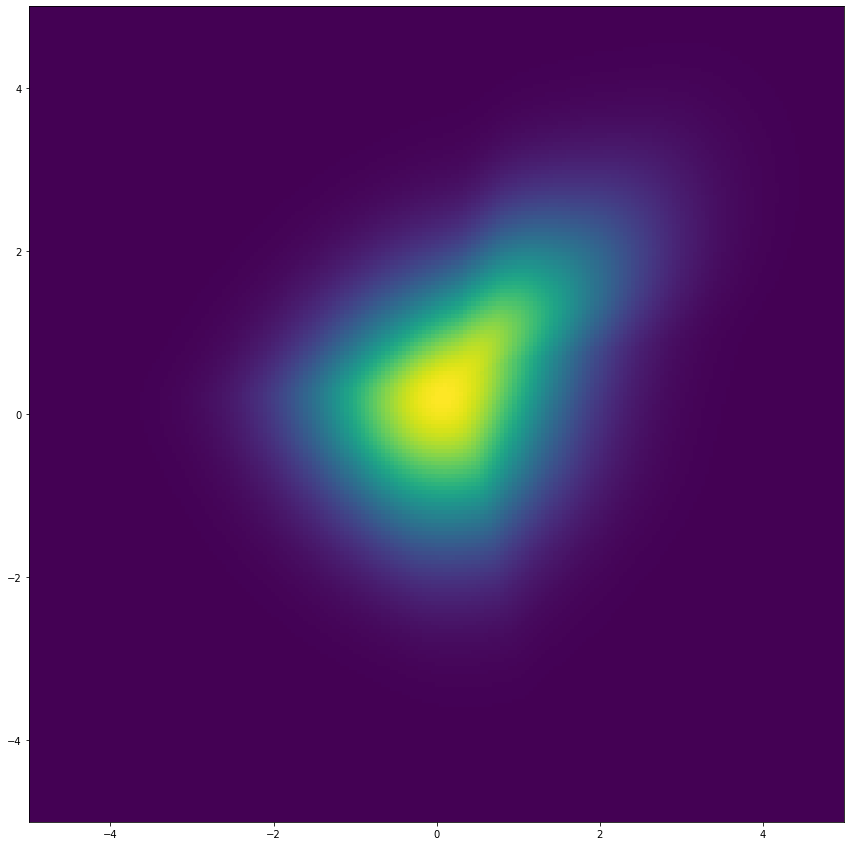

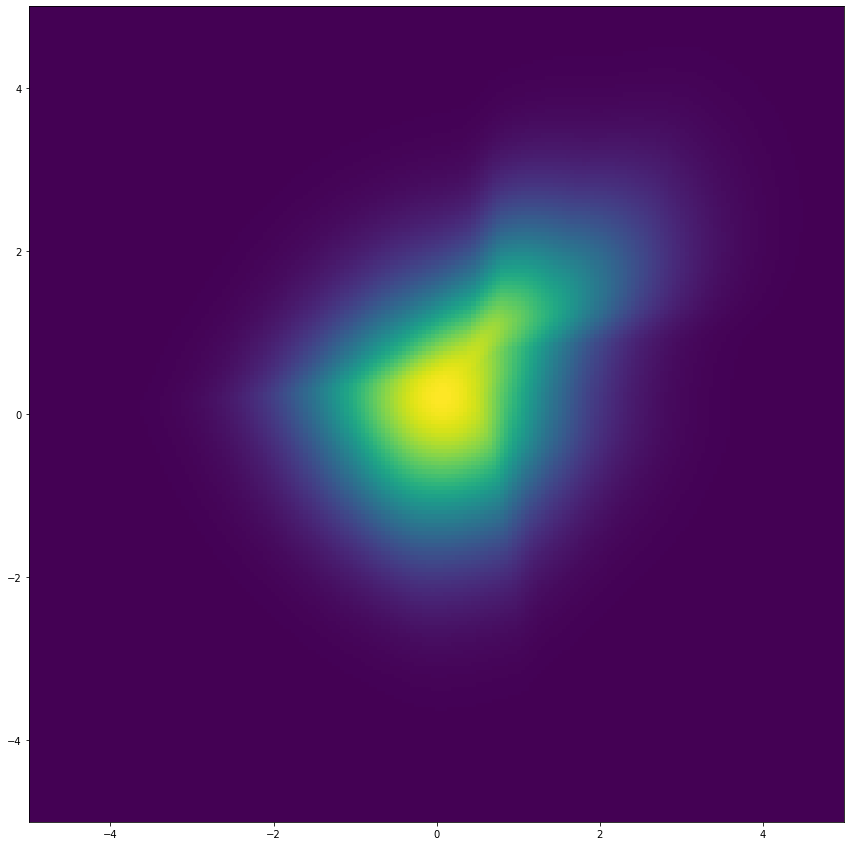

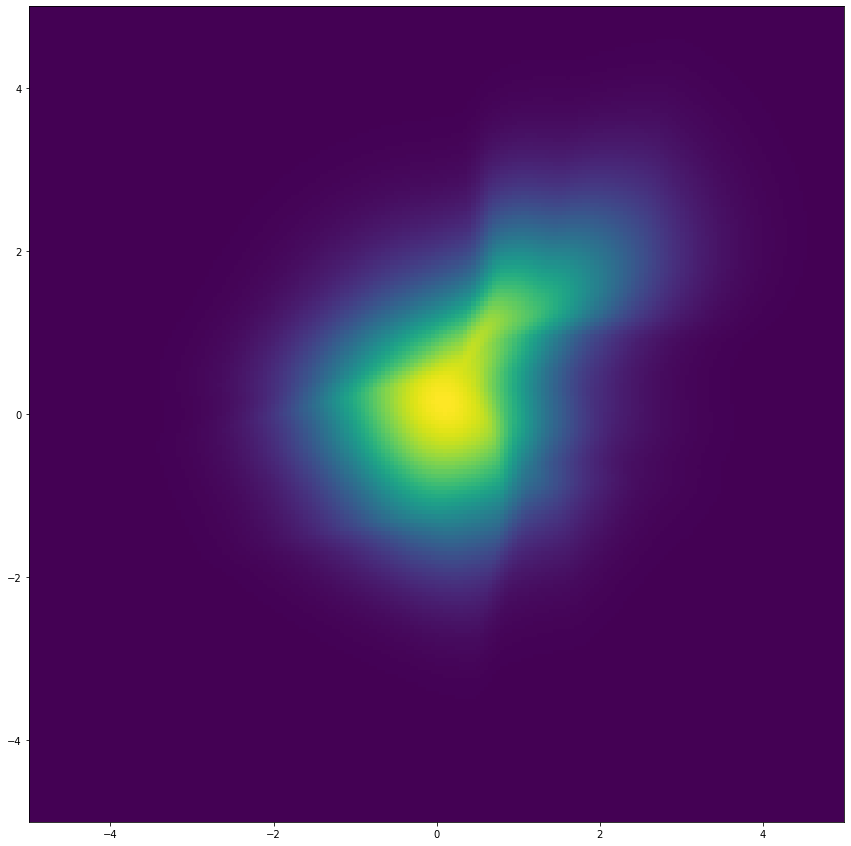

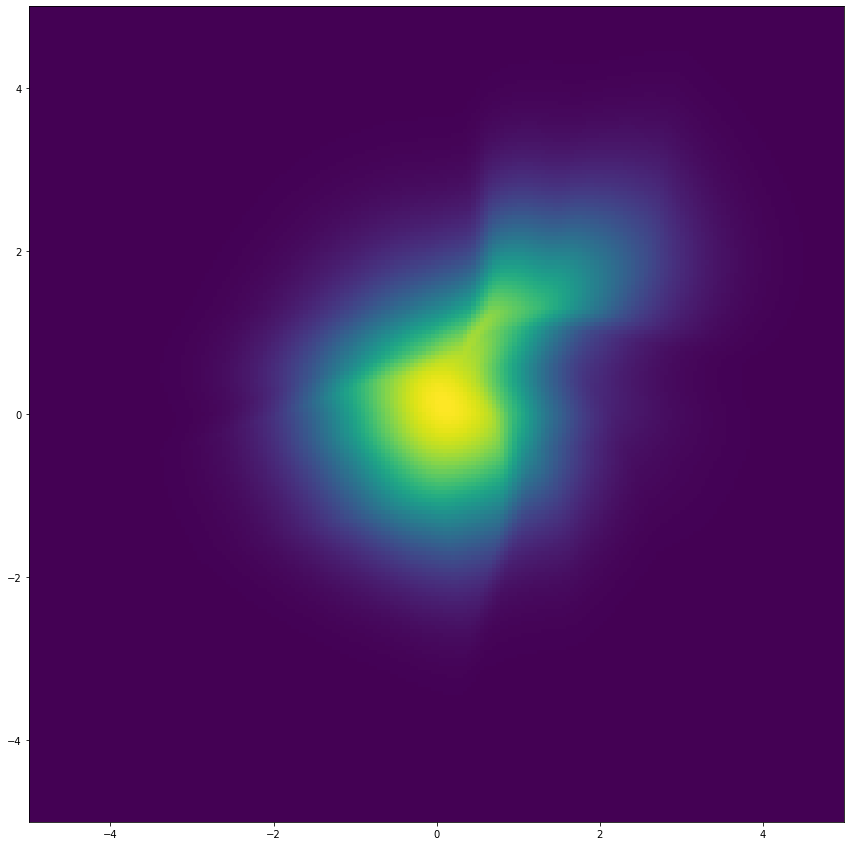

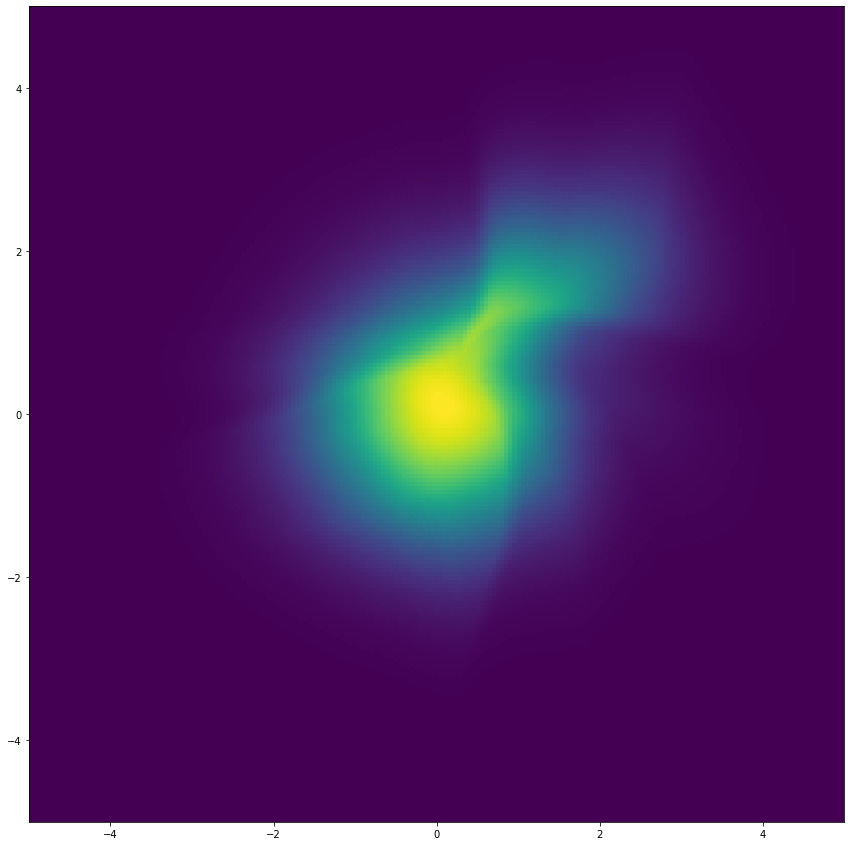

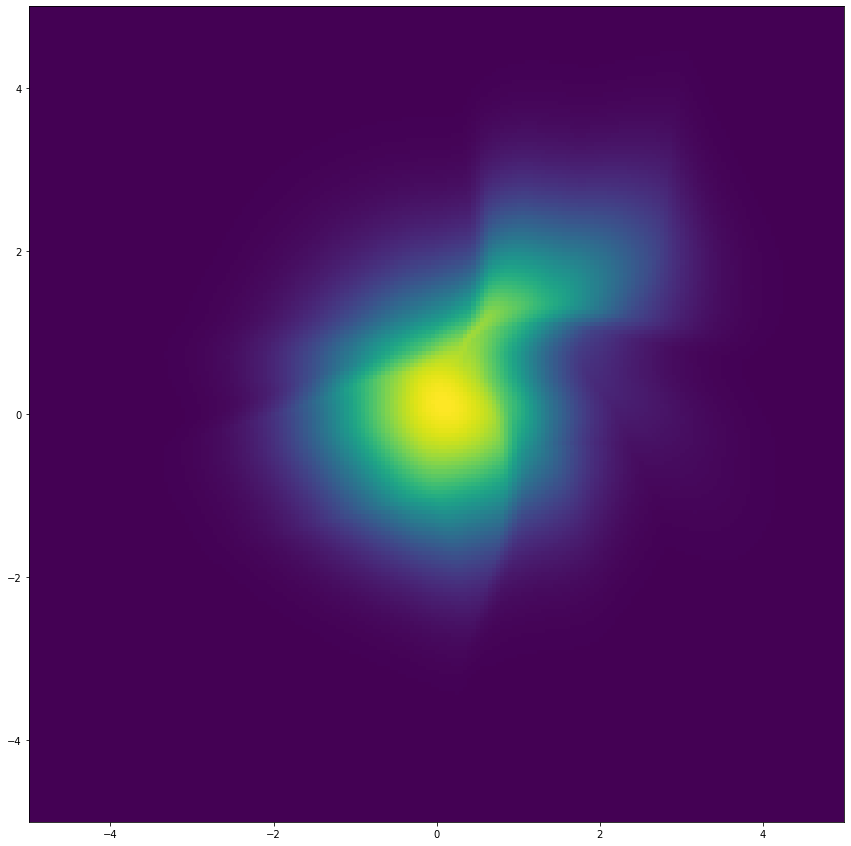

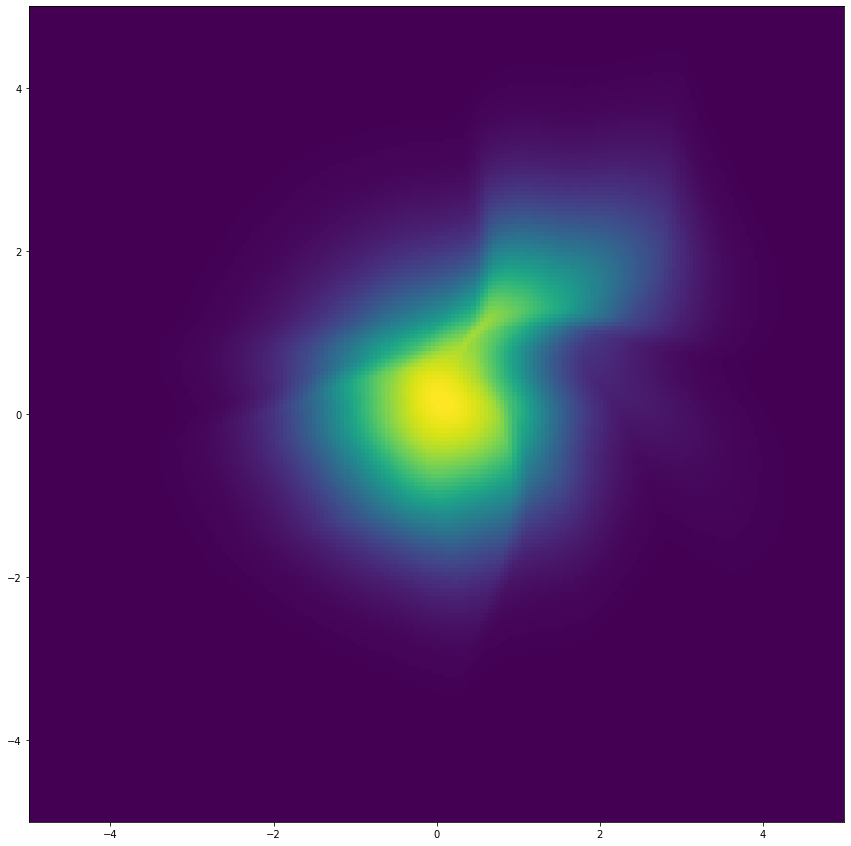

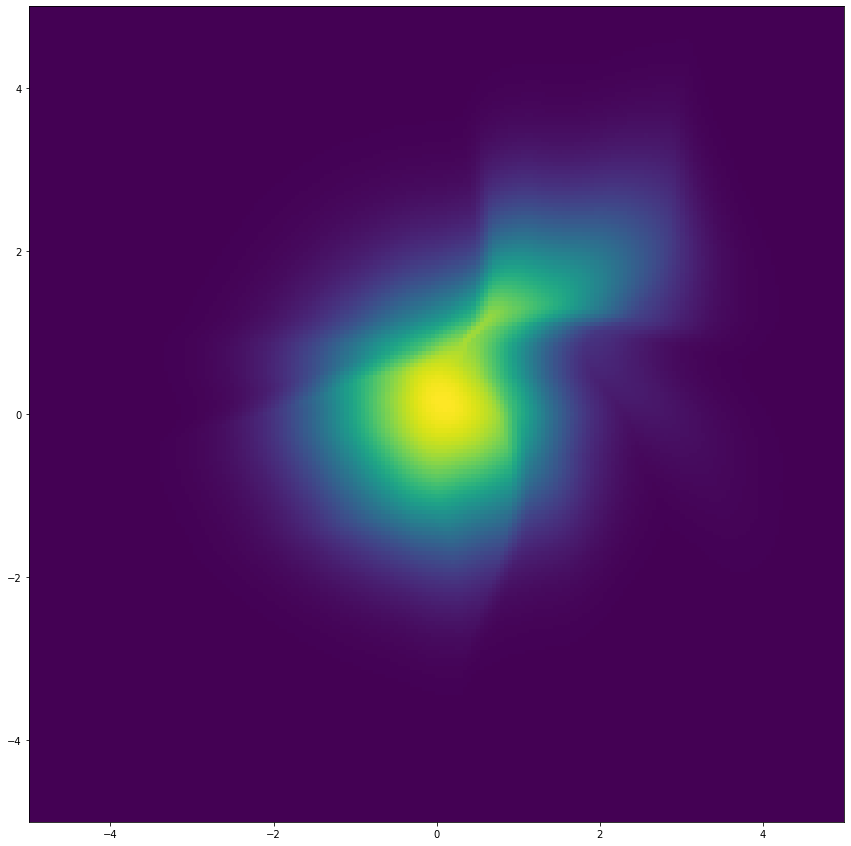

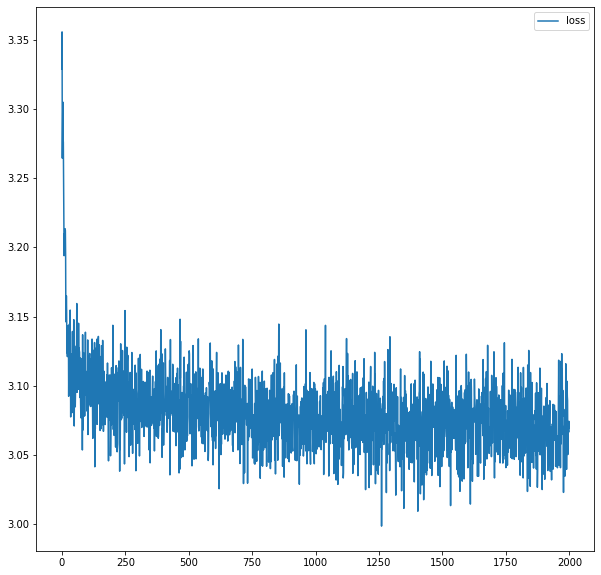

{'max_iter': 2000, 'num_samples': 2048, 'num_segments': 4, 'pow_of_two': 1, 'prob_delta': 0.8, 'dims_dense': [1, 16, 64, 16, 1]} {'loss': 3.066648483276367, 'Bias_prob_hyp': -0.005269885063171387, 'SqErr_prob_hyp': 2.777168857903689e-05}
4 1 2000 2048 [ 1 16 32 16  1]


 12%|█▏        | 249/2000 [00:07<00:52, 33.56it/s]<ipython-input-19-1b55656c51ce>:89: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, prob.data.numpy())
100%|██████████| 2000/2000 [01:05<00:00, 30.44it/s]


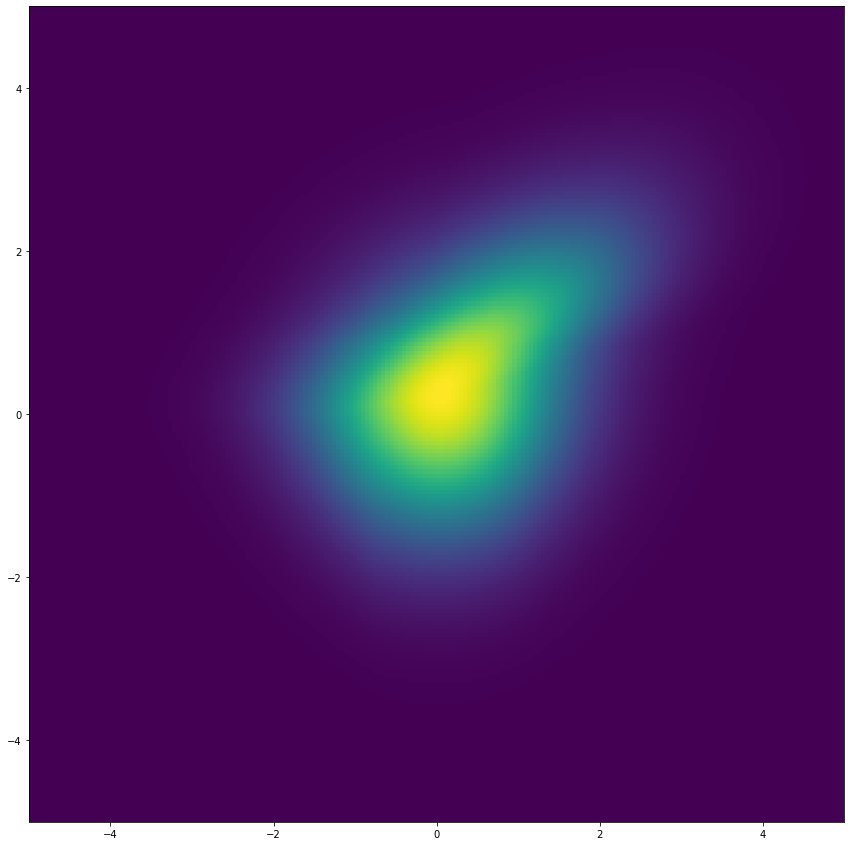

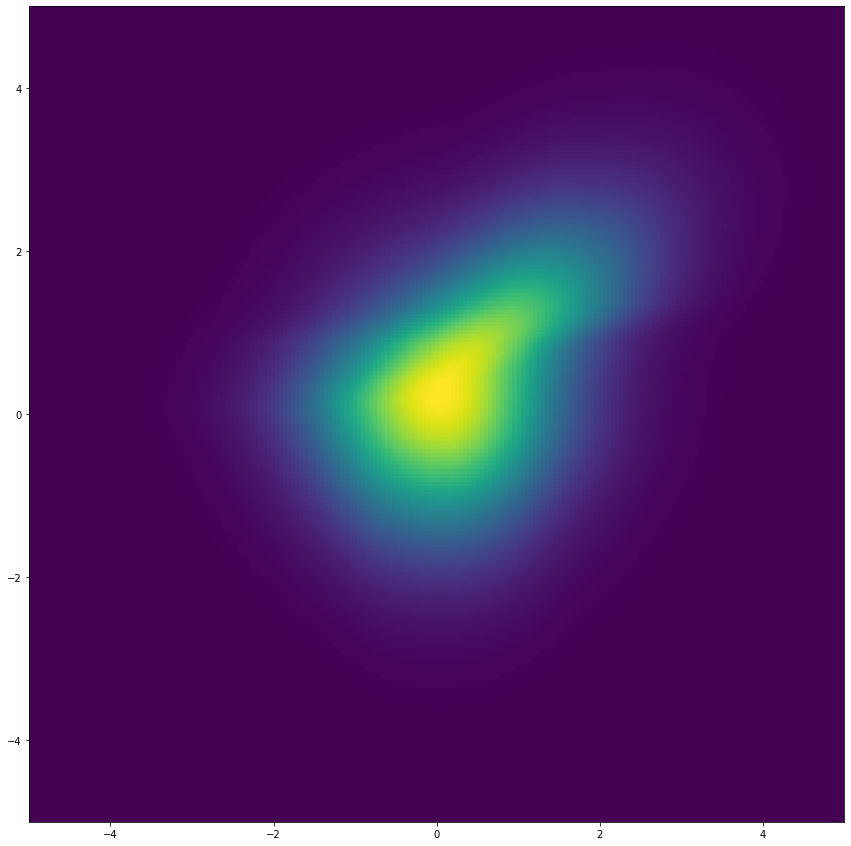

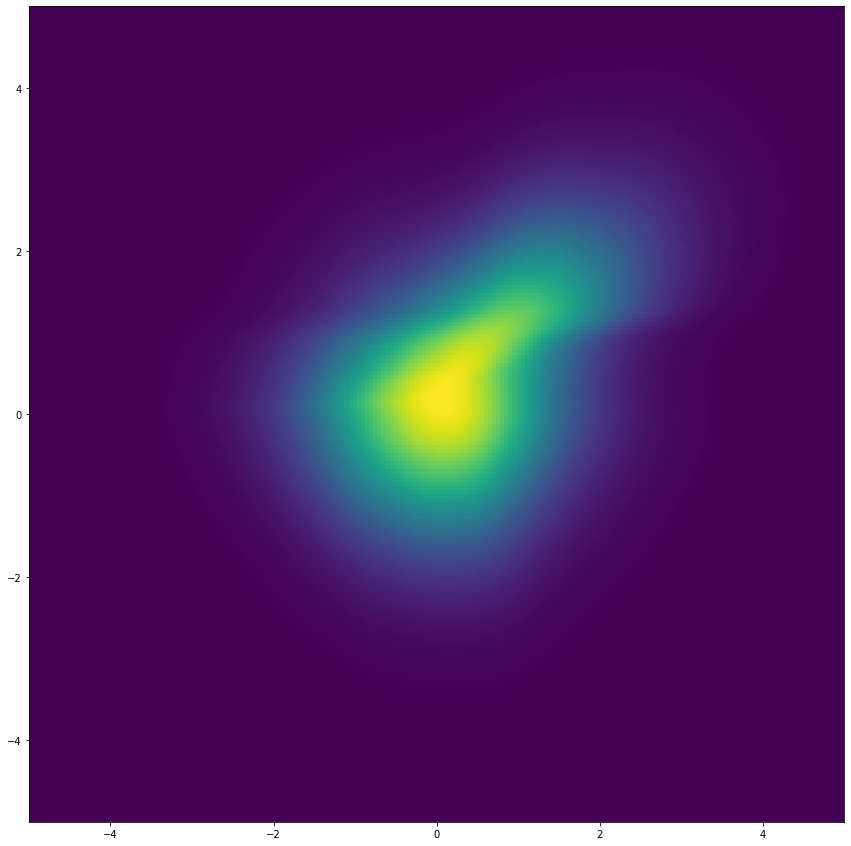

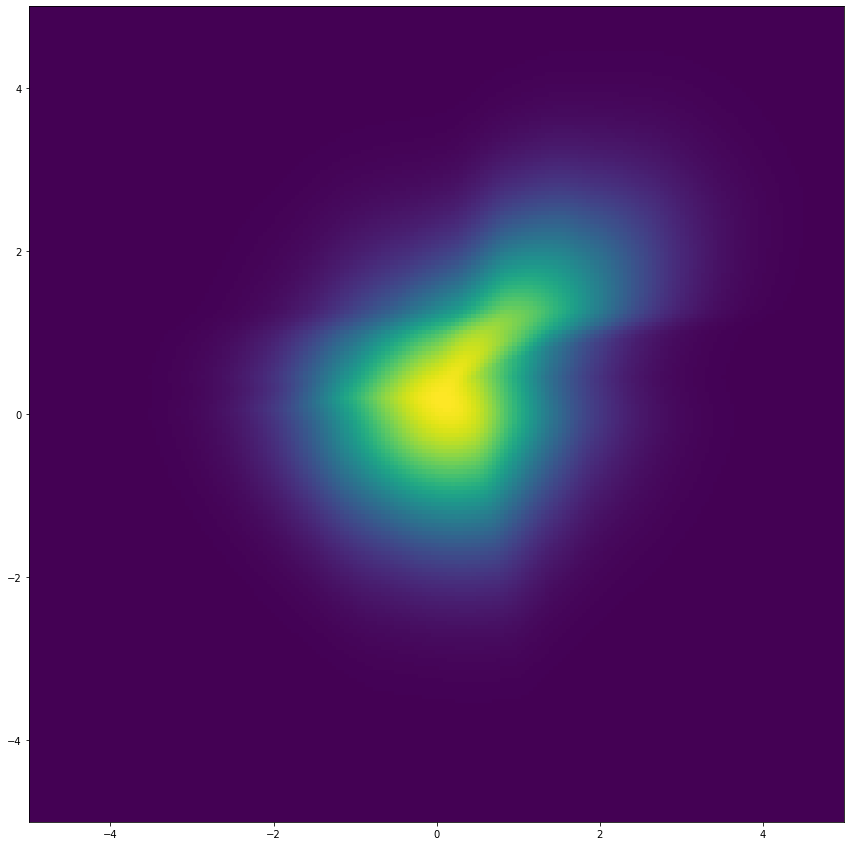

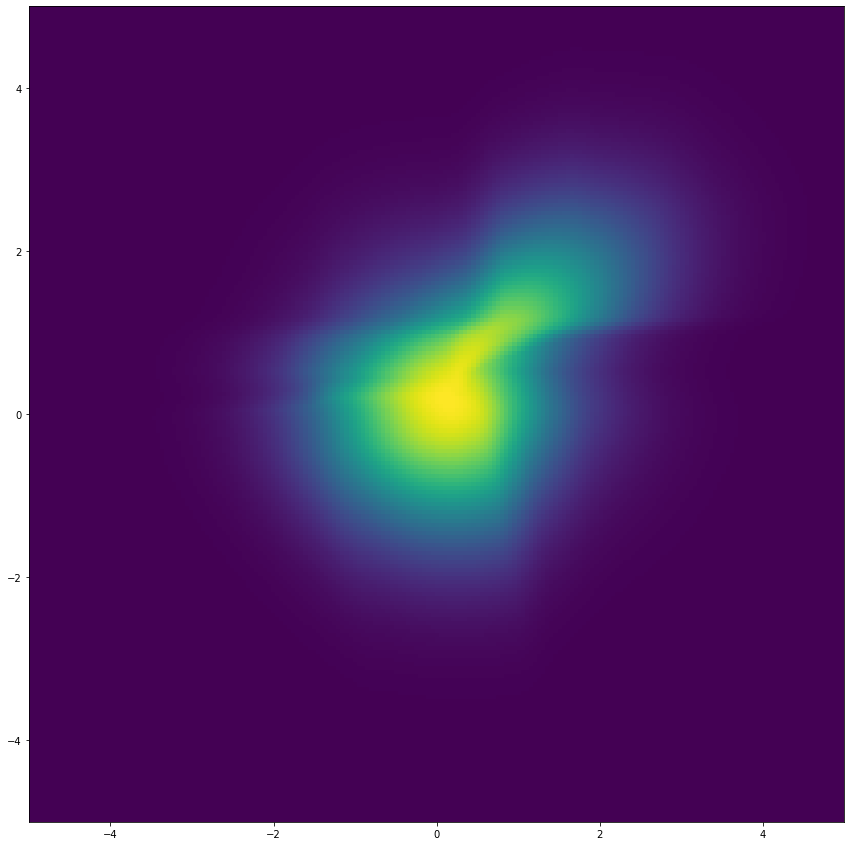

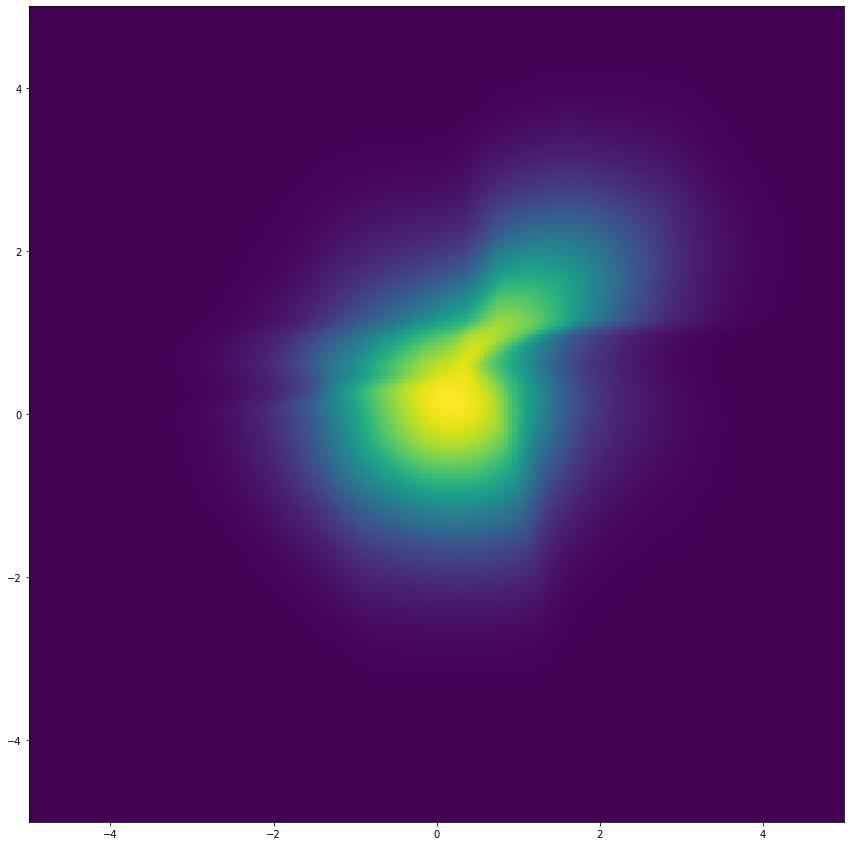

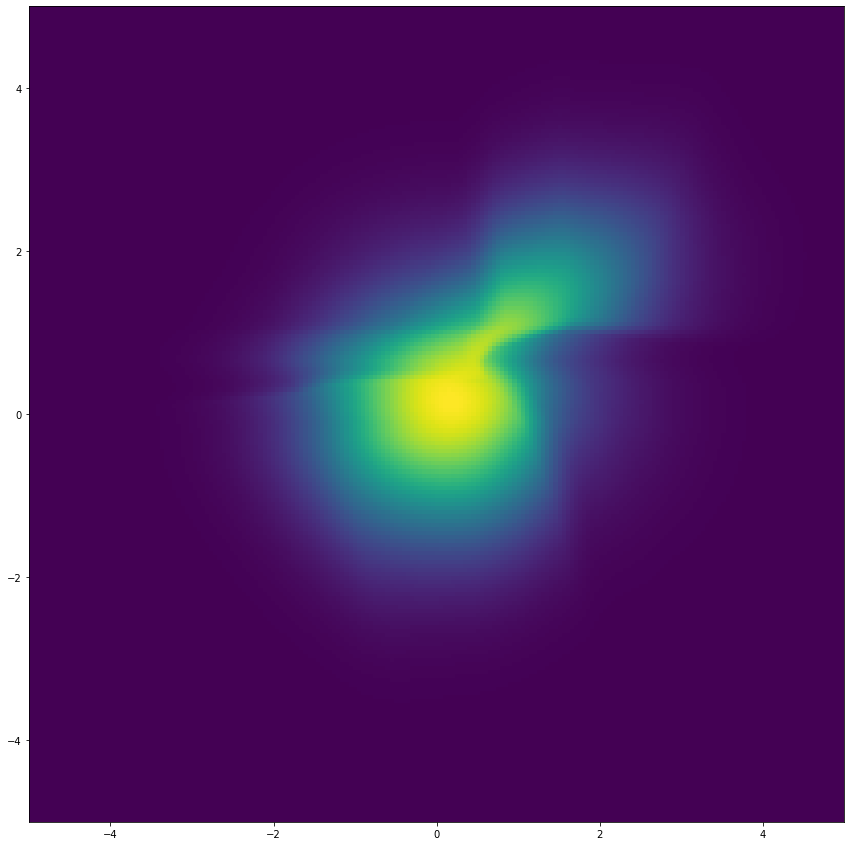

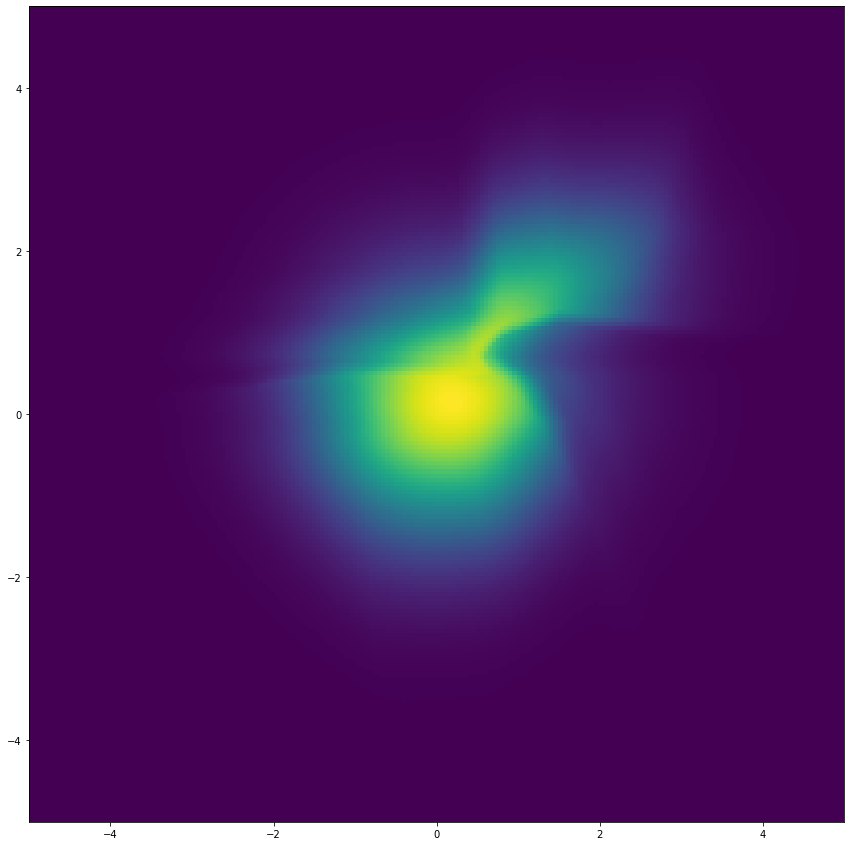

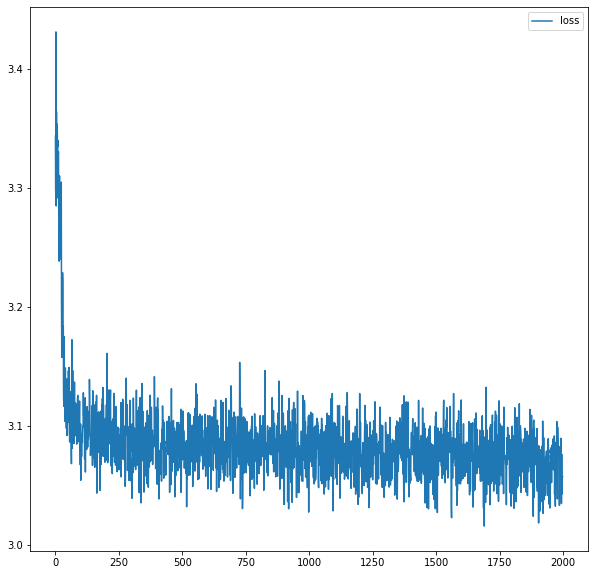

{'max_iter': 2000, 'num_samples': 2048, 'num_segments': 4, 'pow_of_two': 1, 'prob_delta': 0.8, 'dims_dense': [1, 16, 32, 16, 1]} {'loss': 3.057473659515381, 'Bias_prob_hyp': 0.007425427436828613, 'SqErr_prob_hyp': 5.513697261960715e-05}
4 1 2000 2048 [ 1  4 32  4  1]


 12%|█▏        | 249/2000 [00:07<00:54, 32.34it/s]<ipython-input-19-1b55656c51ce>:89: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, prob.data.numpy())
100%|██████████| 2000/2000 [01:02<00:00, 31.88it/s]


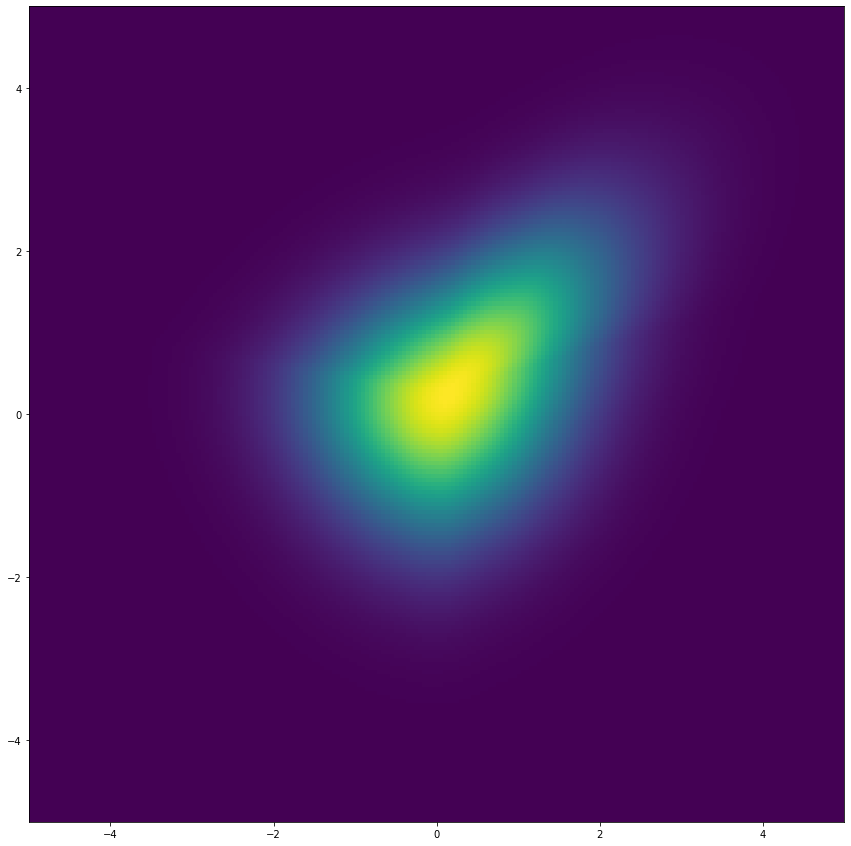

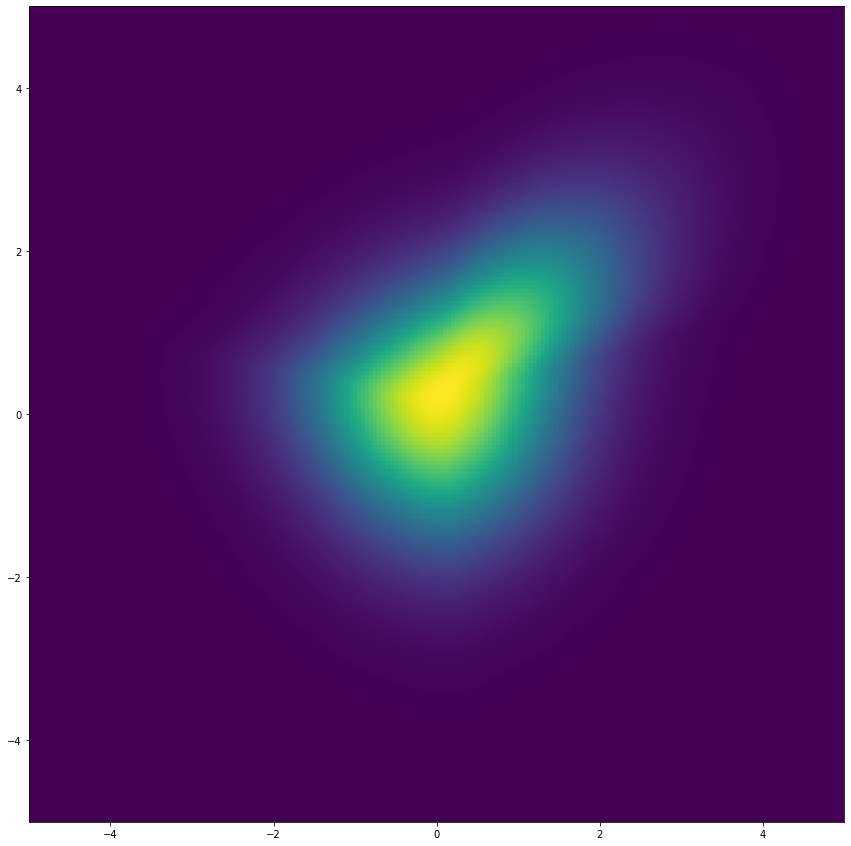

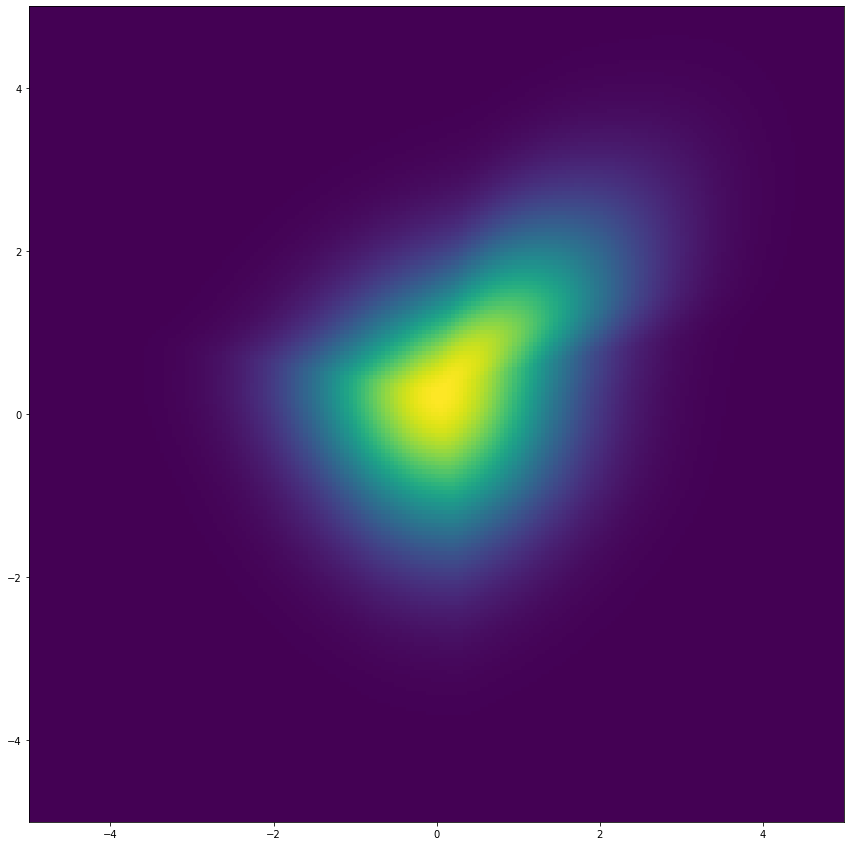

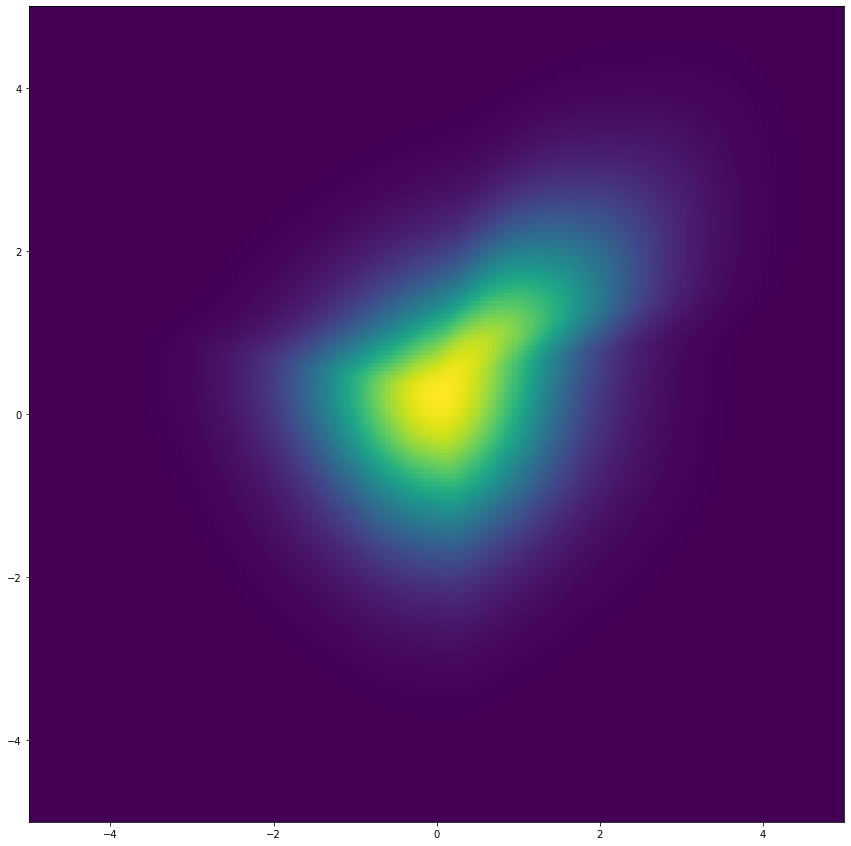

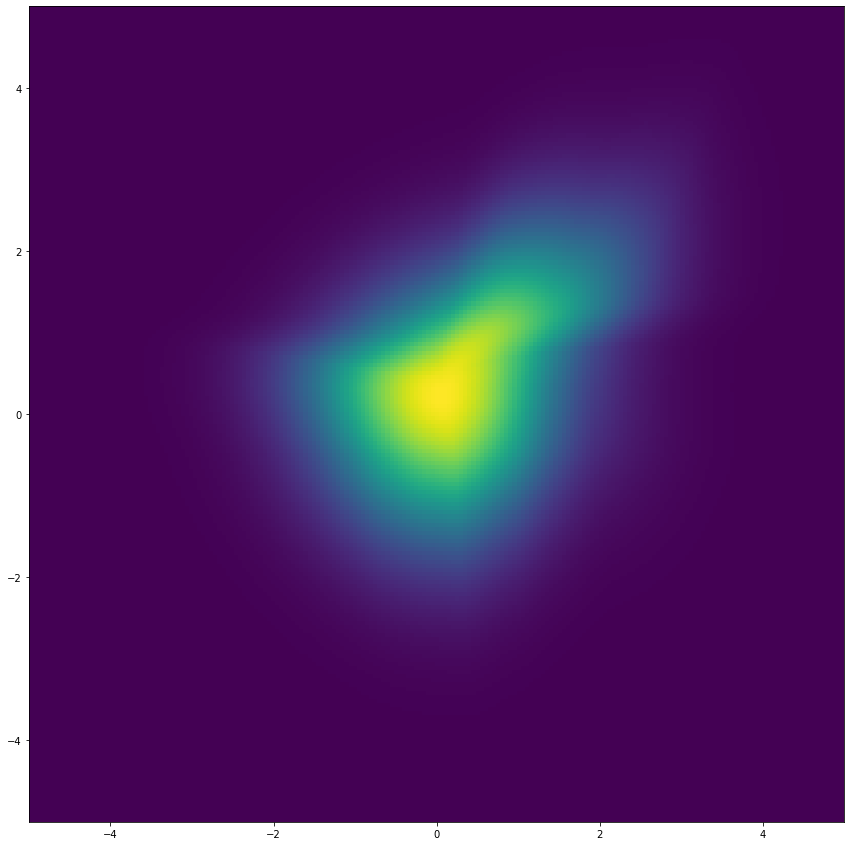

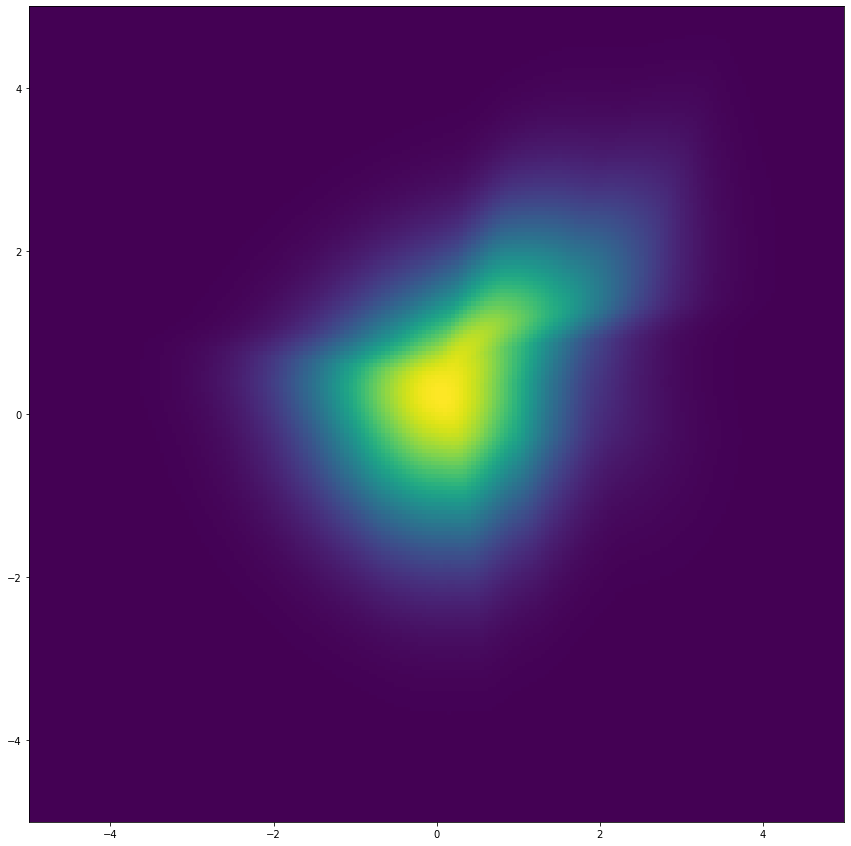

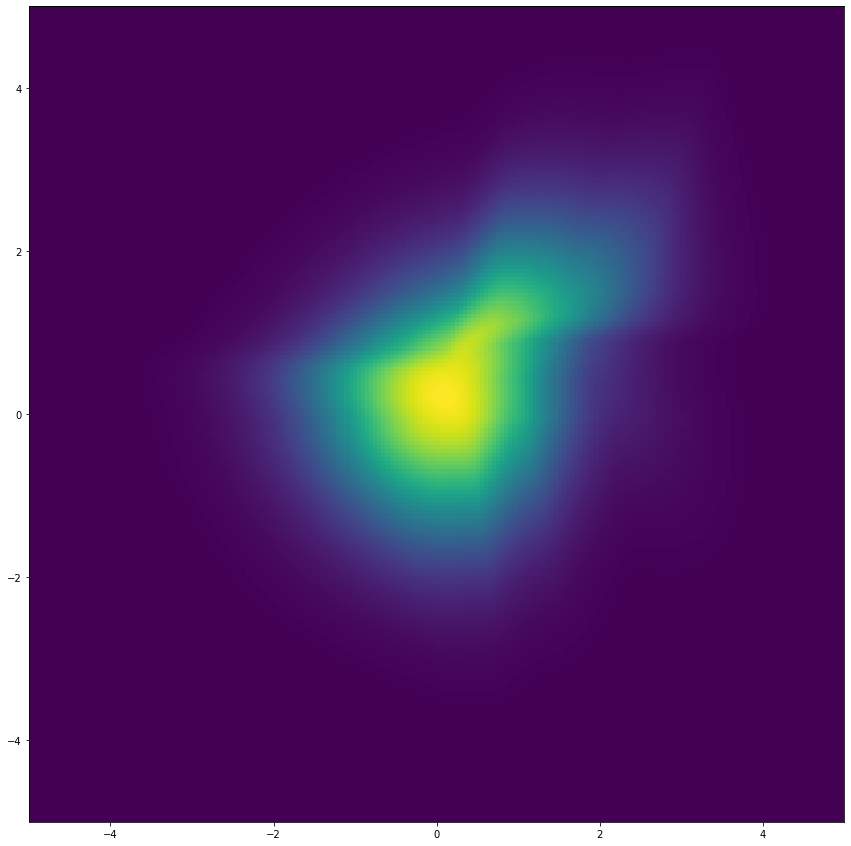

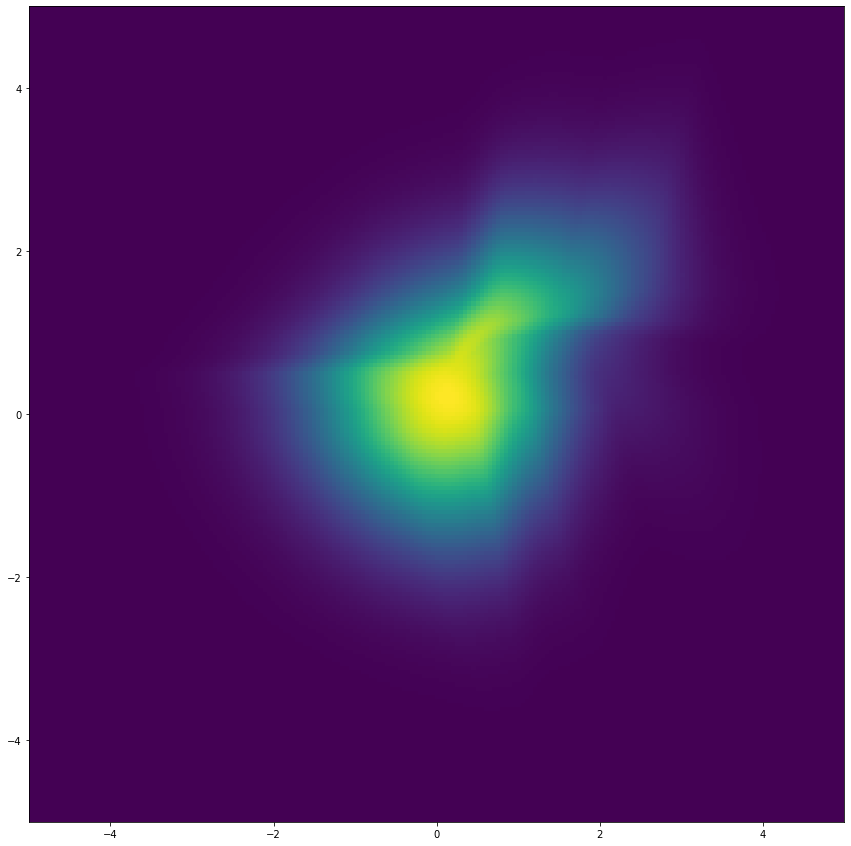

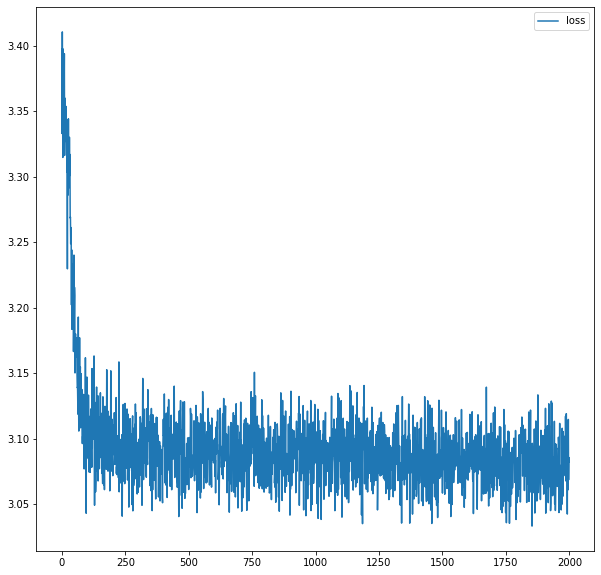

{'max_iter': 2000, 'num_samples': 2048, 'num_segments': 4, 'pow_of_two': 1, 'prob_delta': 0.8, 'dims_dense': [1, 4, 32, 4, 1]} {'loss': 3.0820987224578857, 'Bias_prob_hyp': 0.0003453493118286133, 'SqErr_prob_hyp': 1.1926614718049677e-07}
4 1 2000 5000 [ 1 16 64 16  1]


 12%|█▏        | 249/2000 [00:17<01:59, 14.61it/s]<ipython-input-19-1b55656c51ce>:89: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, prob.data.numpy())
100%|██████████| 2000/2000 [02:22<00:00, 14.07it/s]


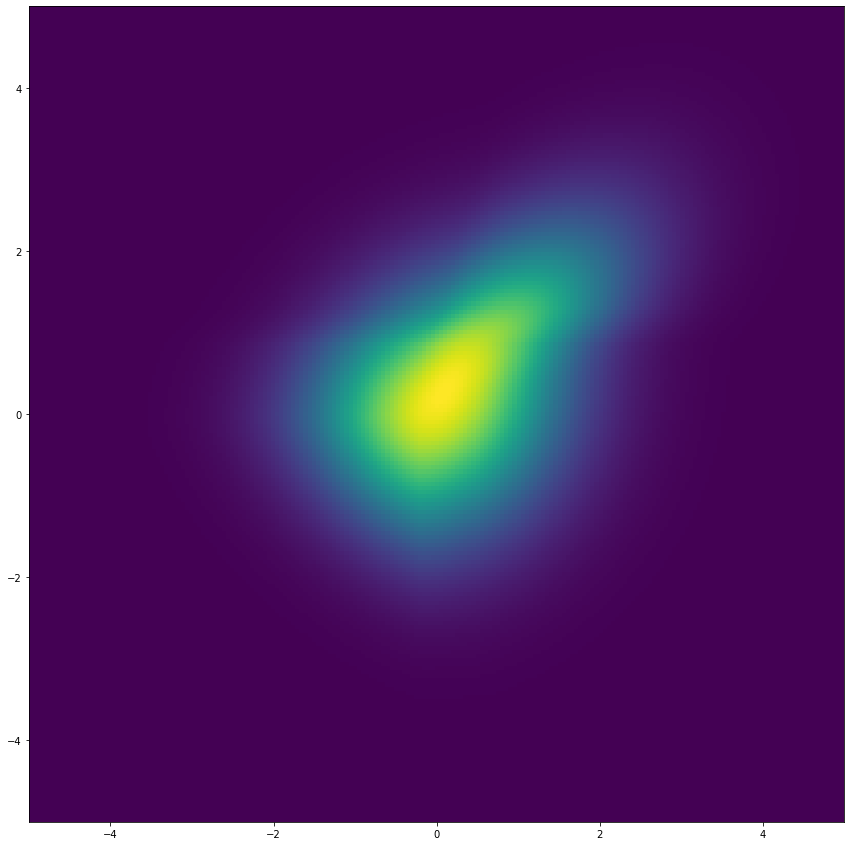

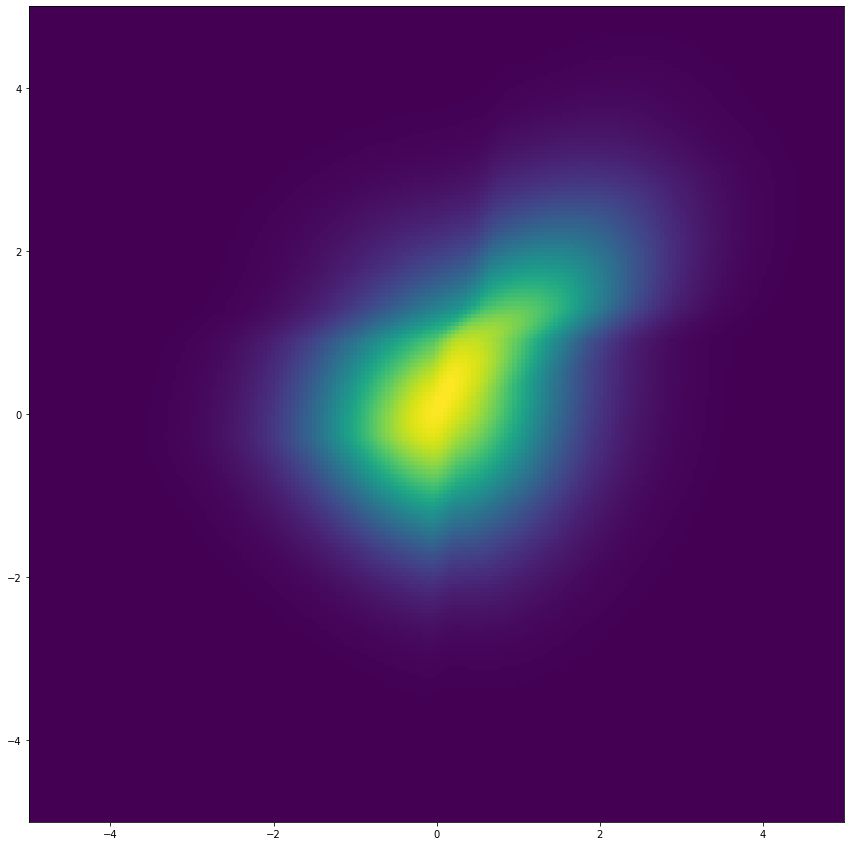

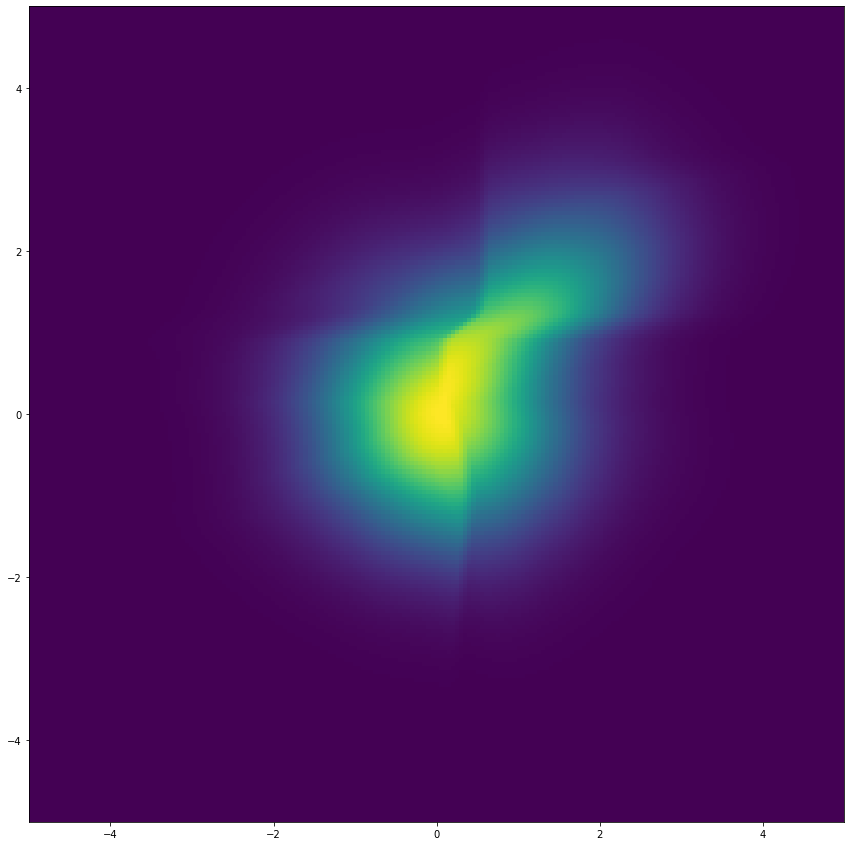

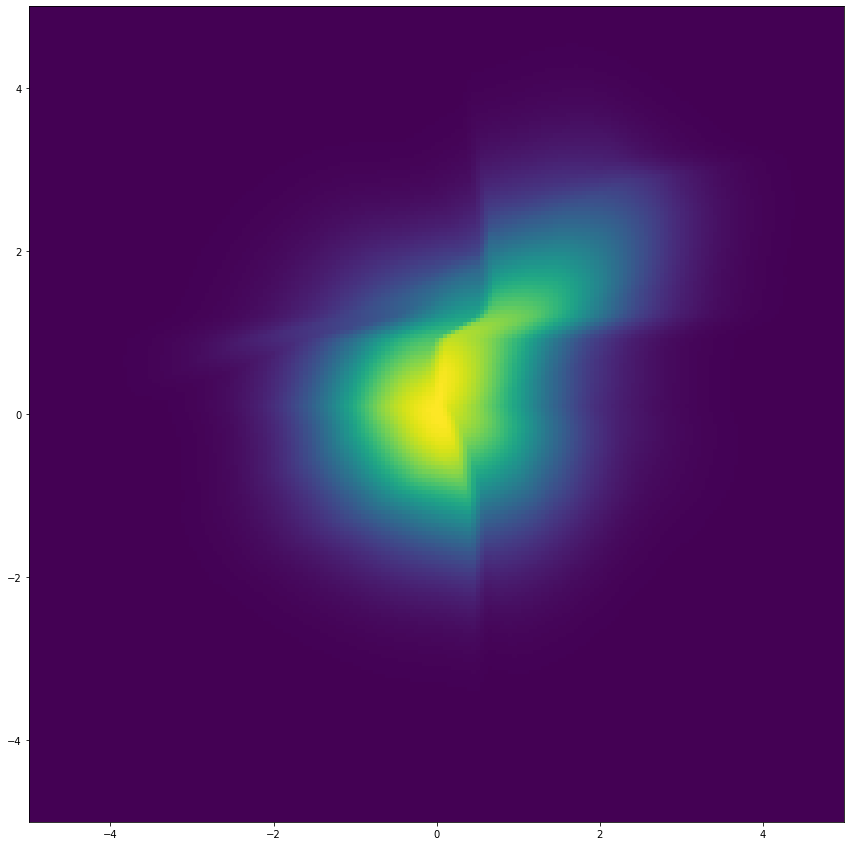

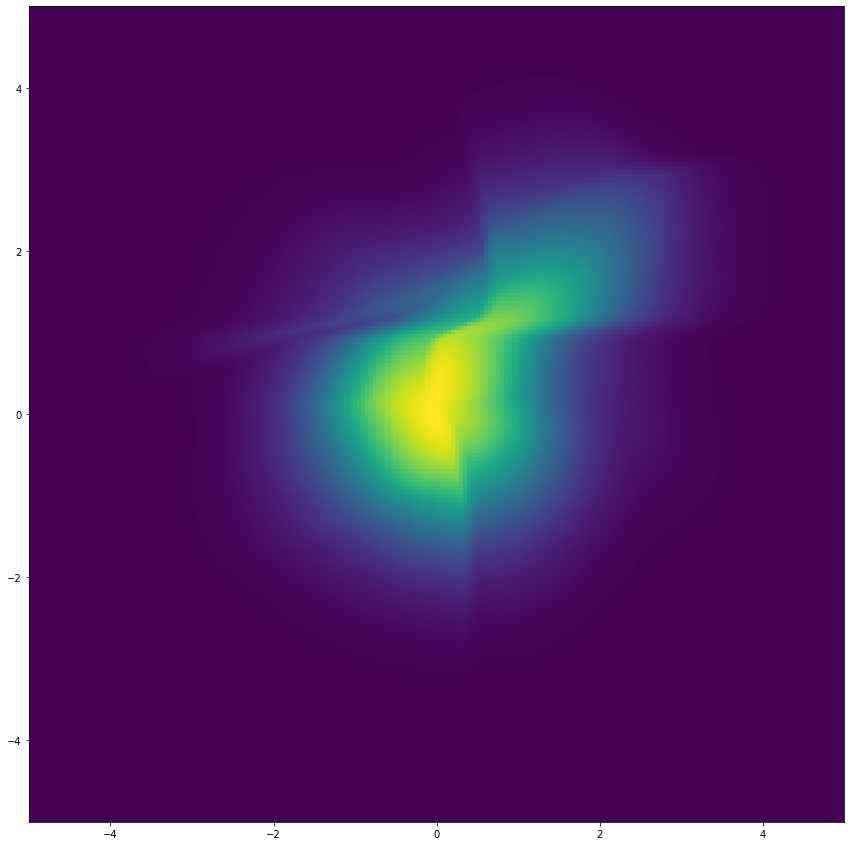

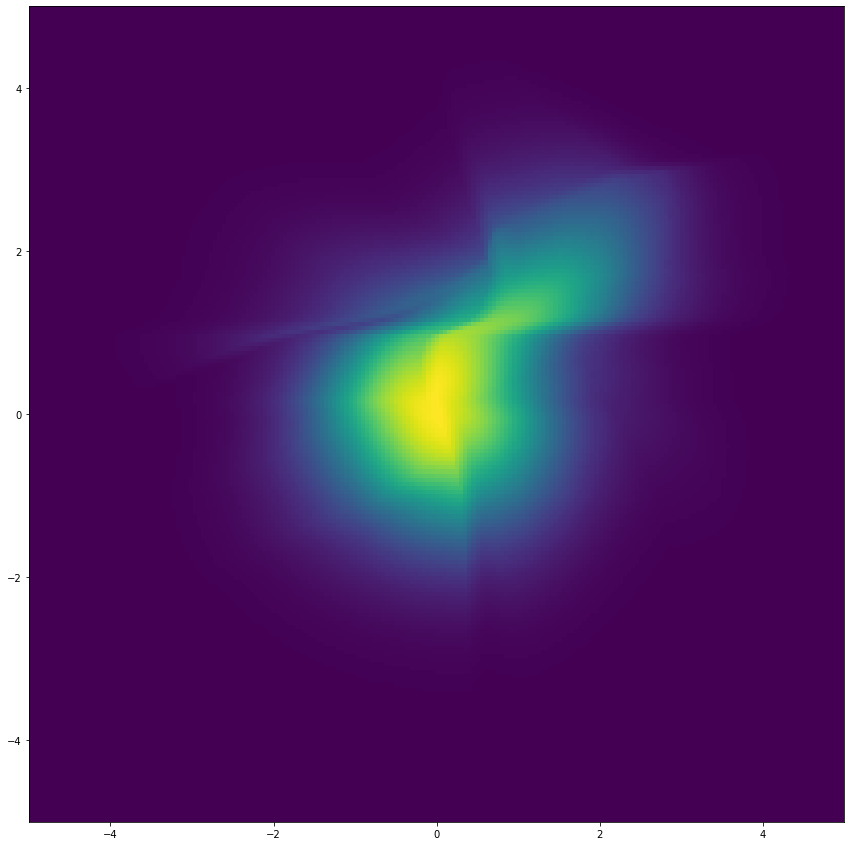

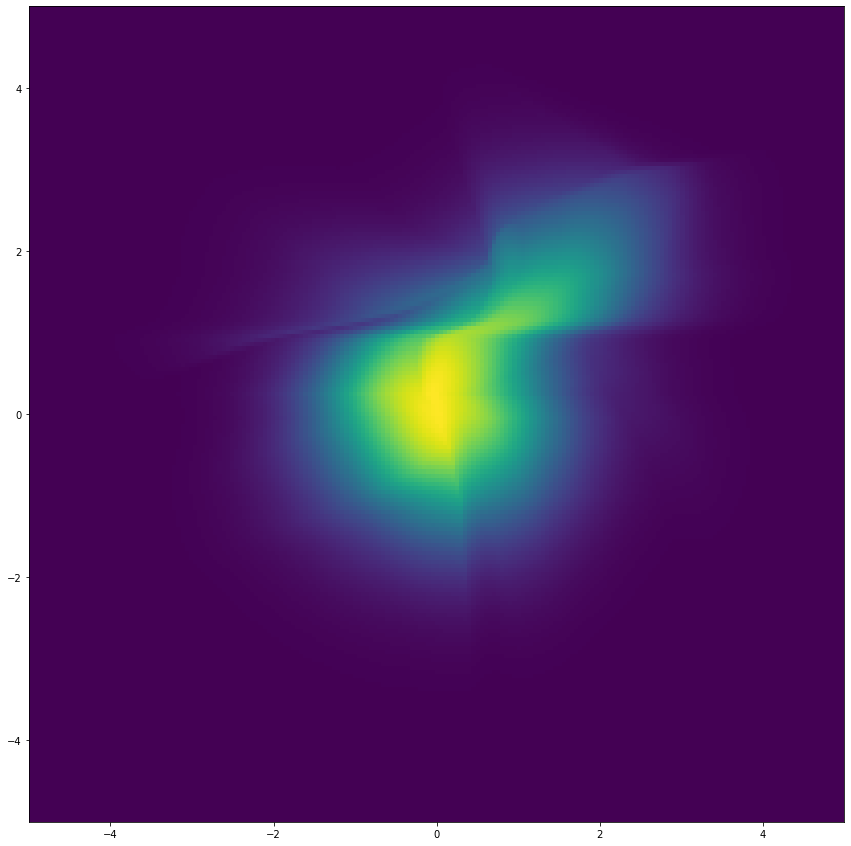

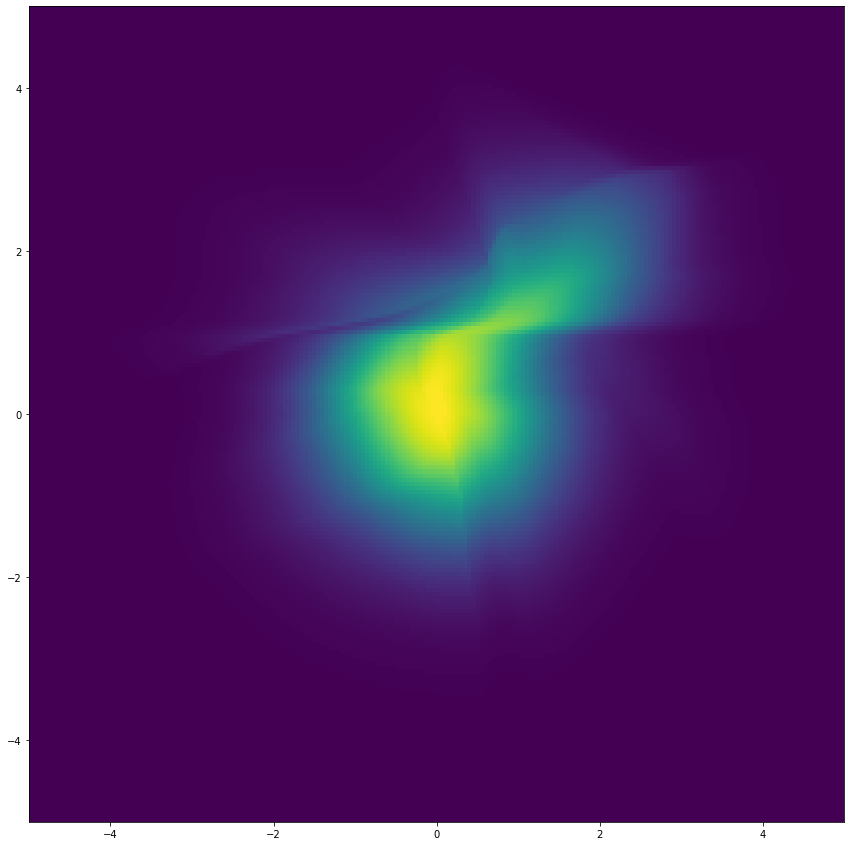

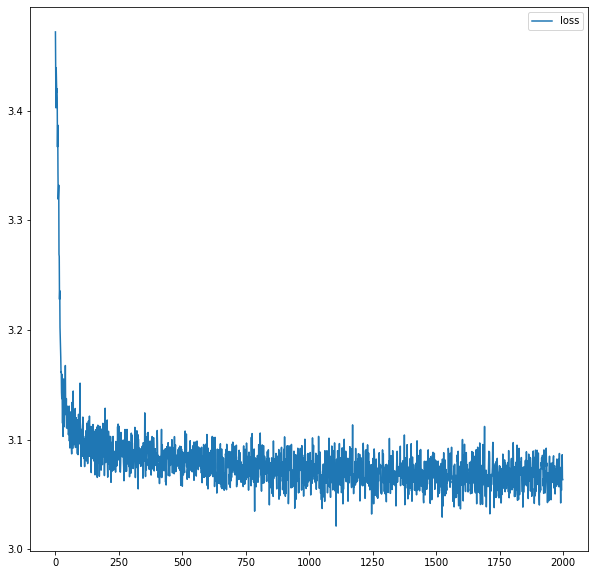

{'max_iter': 2000, 'num_samples': 5000, 'num_segments': 4, 'pow_of_two': 1, 'prob_delta': 0.8, 'dims_dense': [1, 16, 64, 16, 1]} {'loss': 3.063412666320801, 'Bias_prob_hyp': 0.0015066774368286406, 'SqErr_prob_hyp': 2.2700768986485222e-06}
4 1 2000 5000 [ 1 16 32 16  1]


 12%|█▏        | 249/2000 [00:12<01:26, 20.28it/s]<ipython-input-19-1b55656c51ce>:89: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, prob.data.numpy())
100%|██████████| 2000/2000 [01:47<00:00, 18.65it/s]


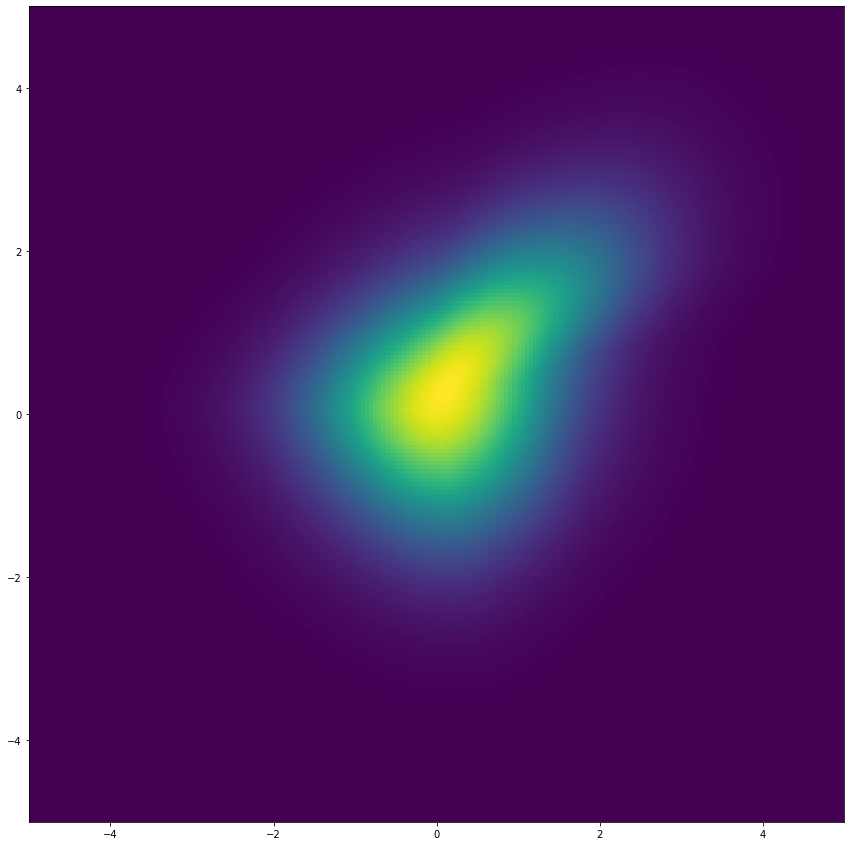

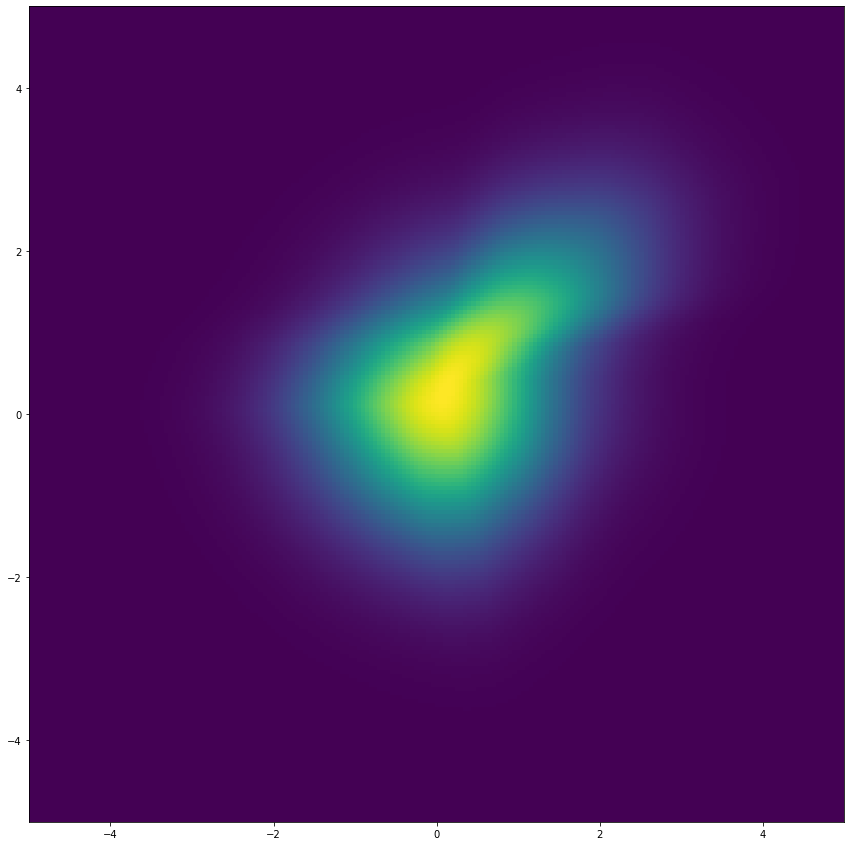

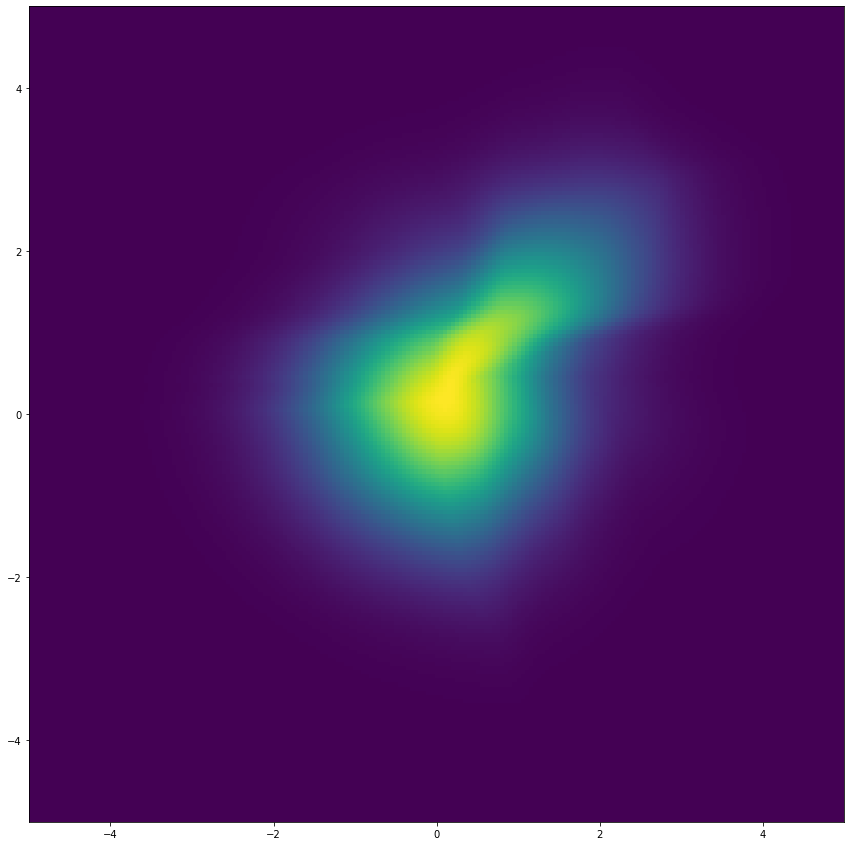

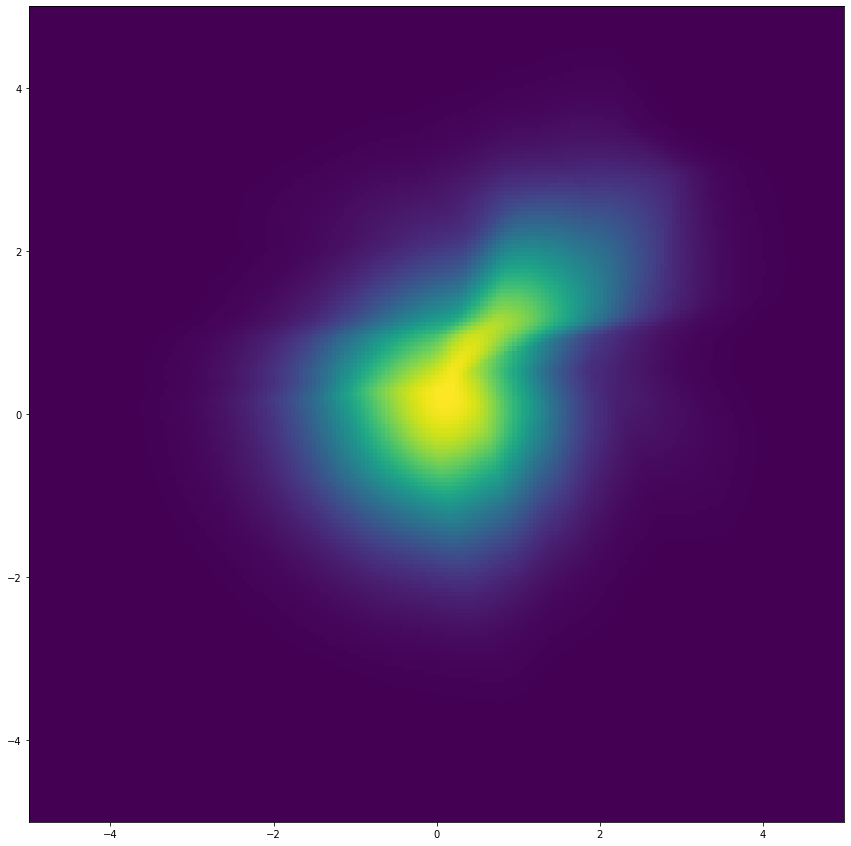

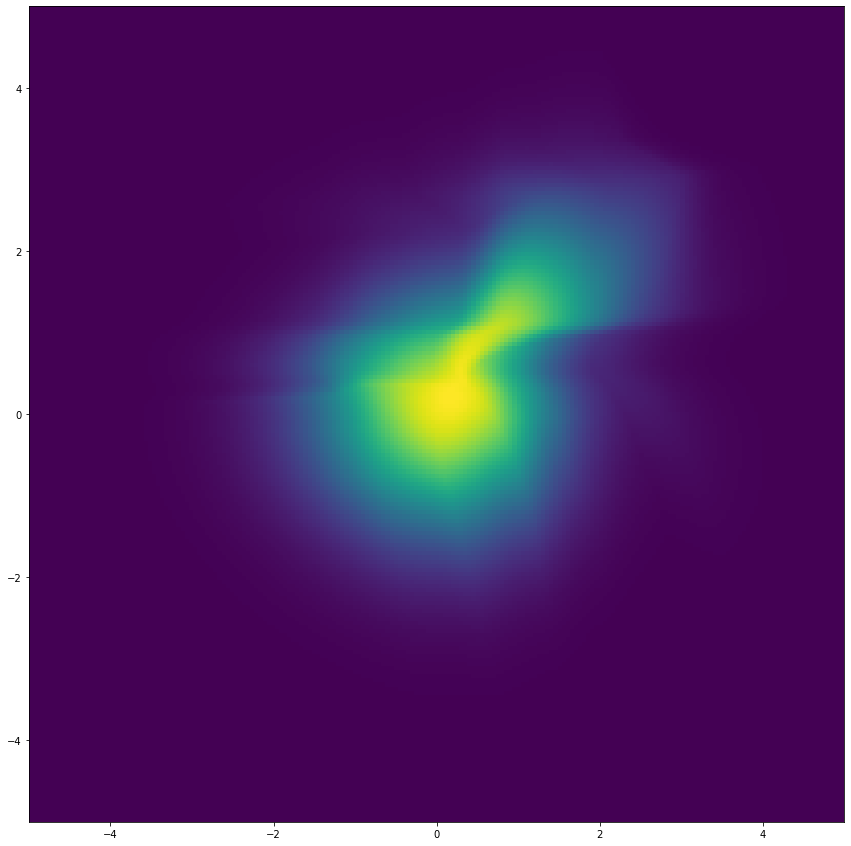

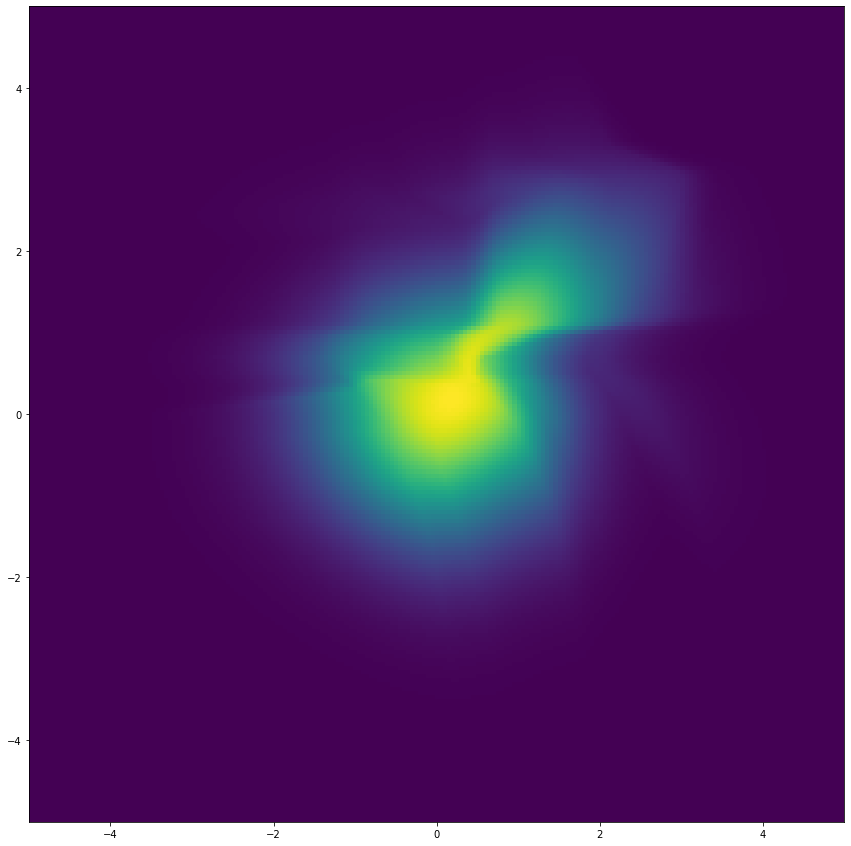

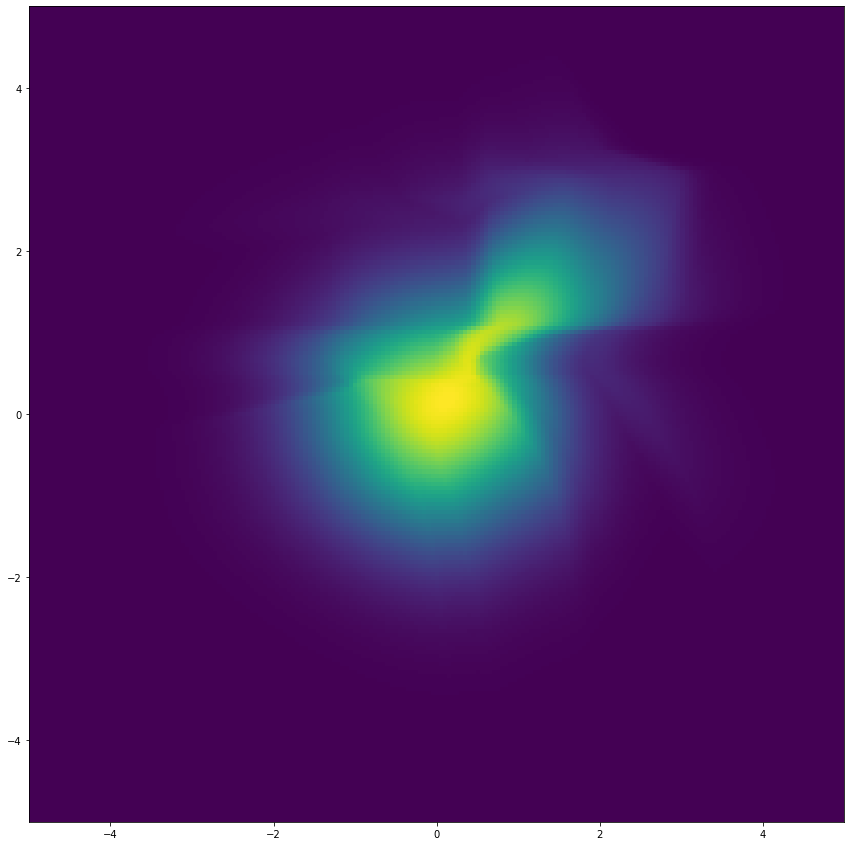

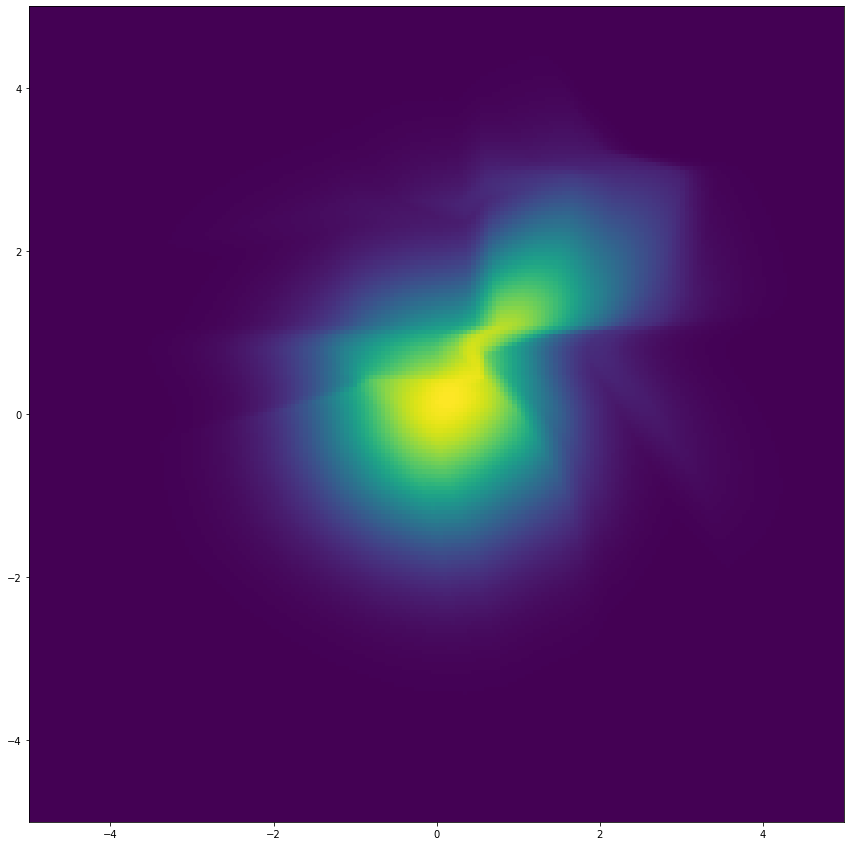

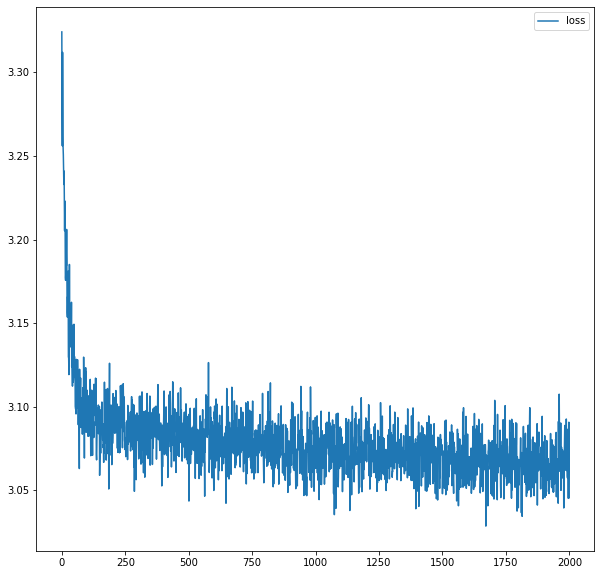

{'max_iter': 2000, 'num_samples': 5000, 'num_segments': 4, 'pow_of_two': 1, 'prob_delta': 0.8, 'dims_dense': [1, 16, 32, 16, 1]} {'loss': 3.045590877532959, 'Bias_prob_hyp': 0.004506677436828588, 'SqErr_prob_hyp': 2.031014151961989e-05}
4 1 2000 5000 [ 1  4 32  4  1]


 12%|█▏        | 247/2000 [00:12<01:25, 20.45it/s]<ipython-input-19-1b55656c51ce>:89: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, prob.data.numpy())
100%|██████████| 2000/2000 [01:41<00:00, 19.71it/s]


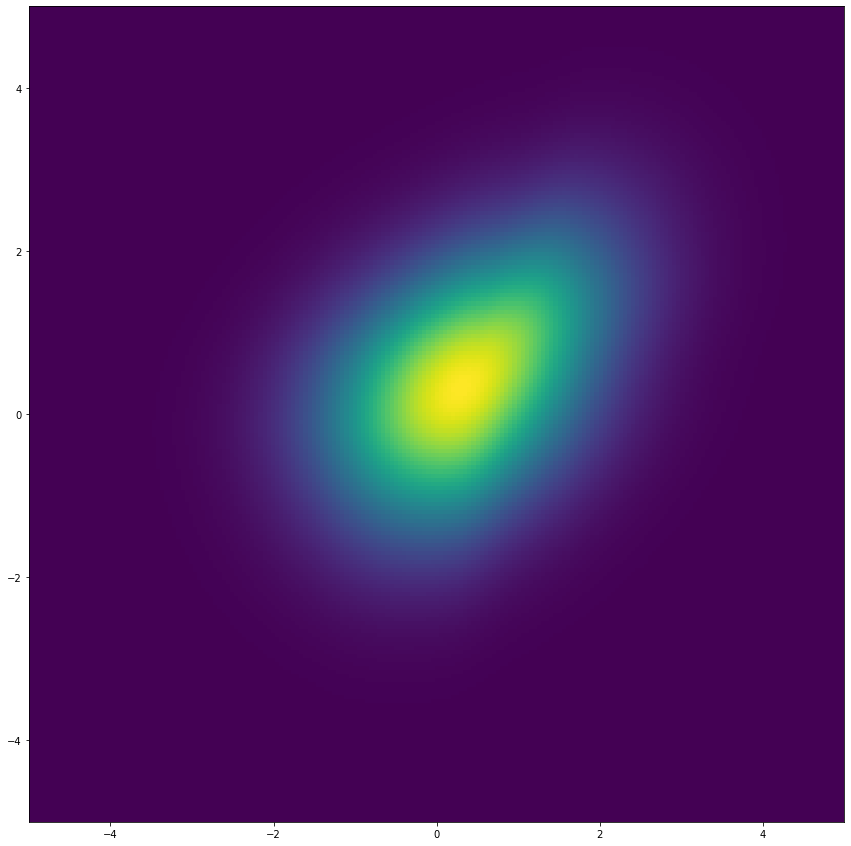

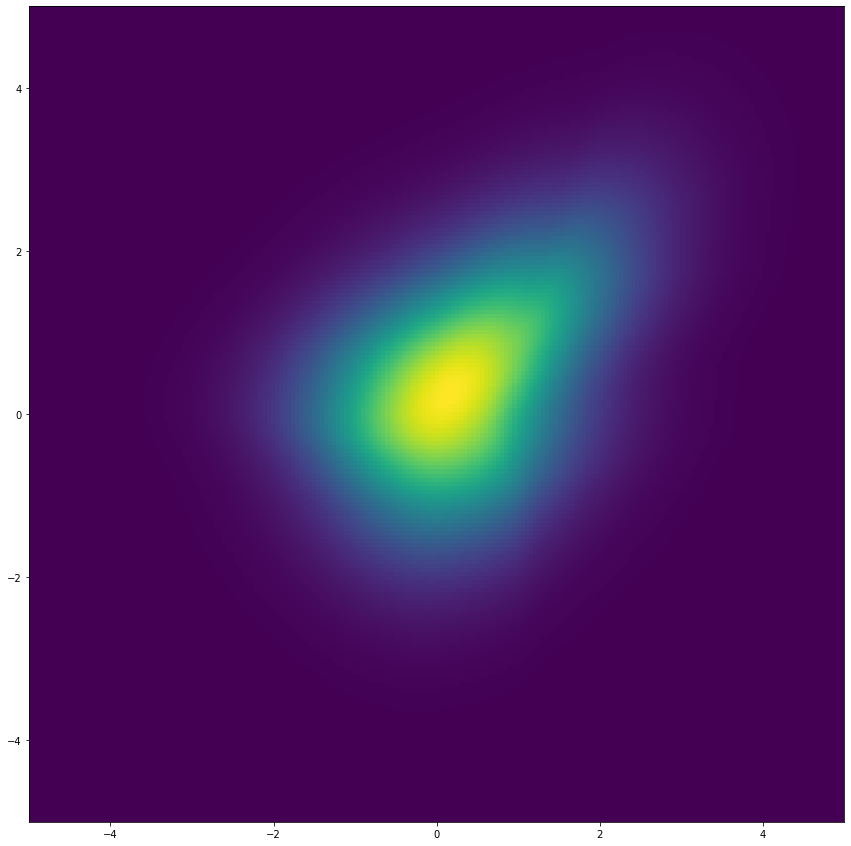

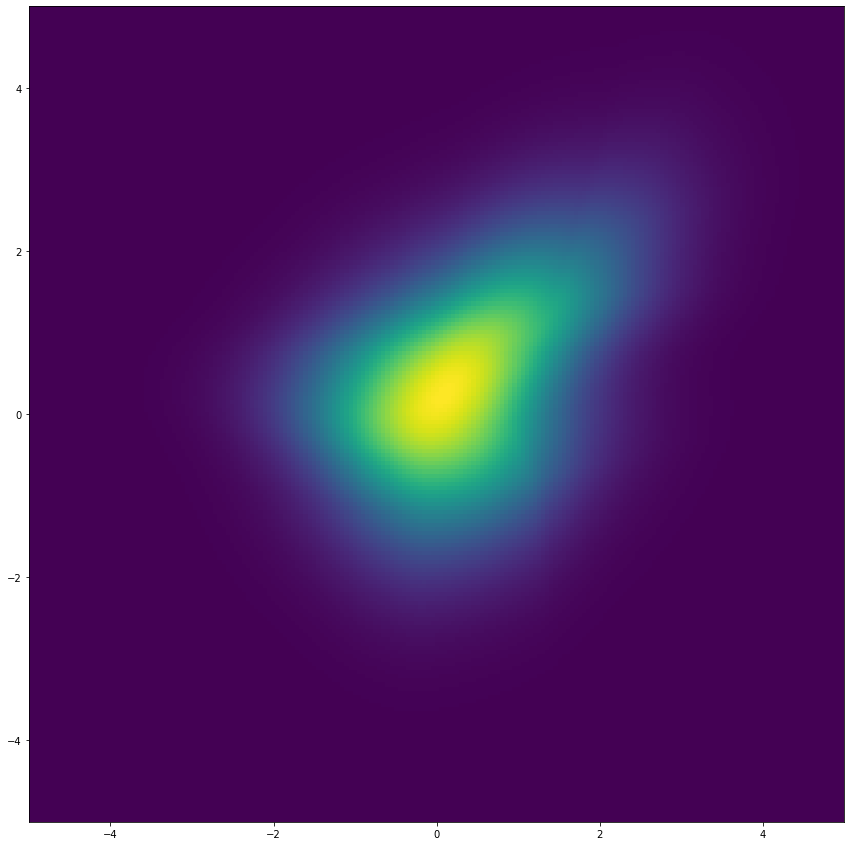

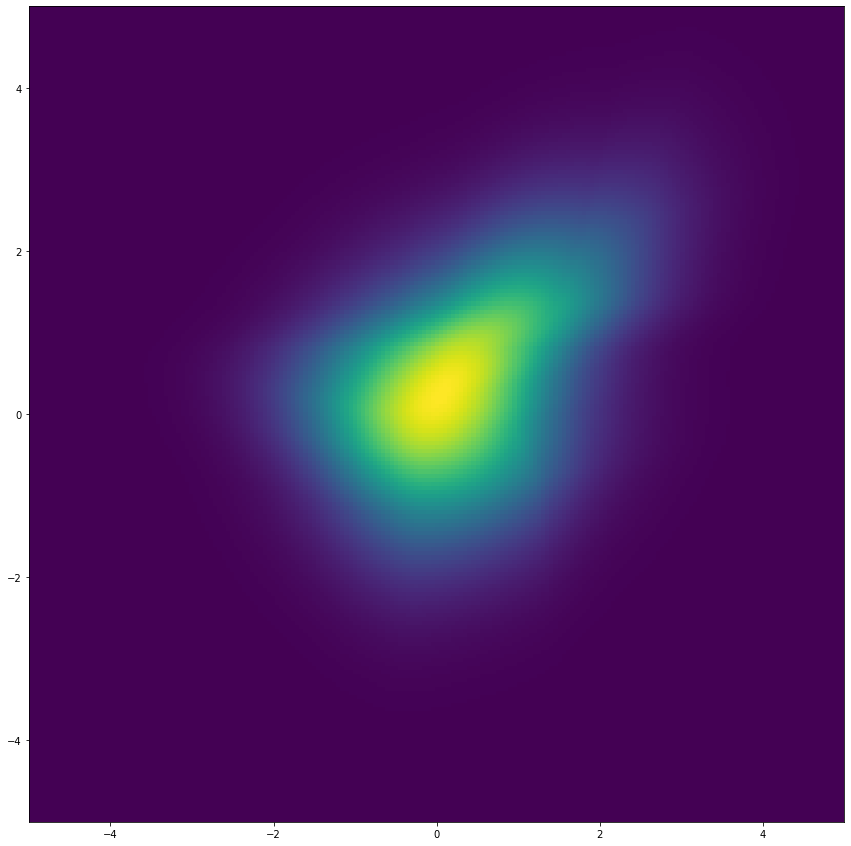

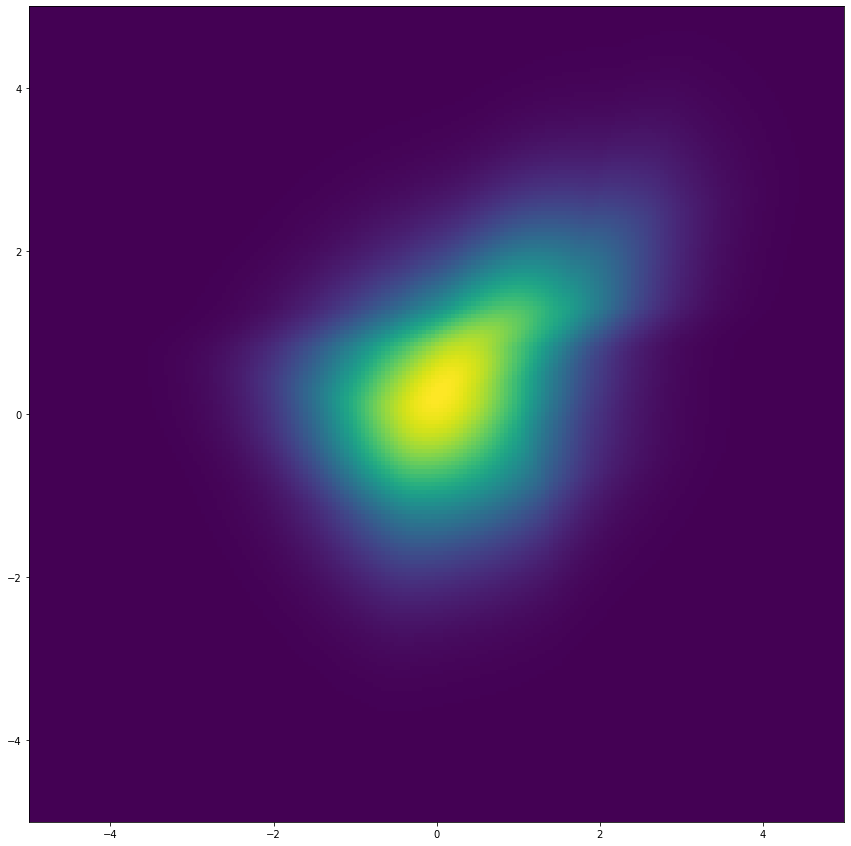

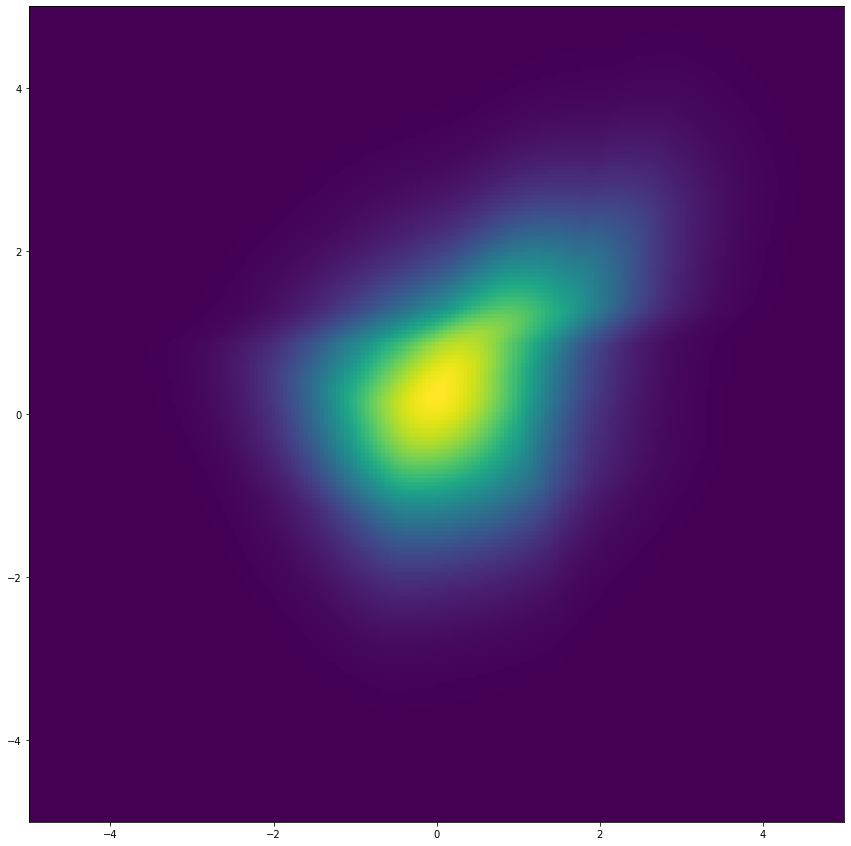

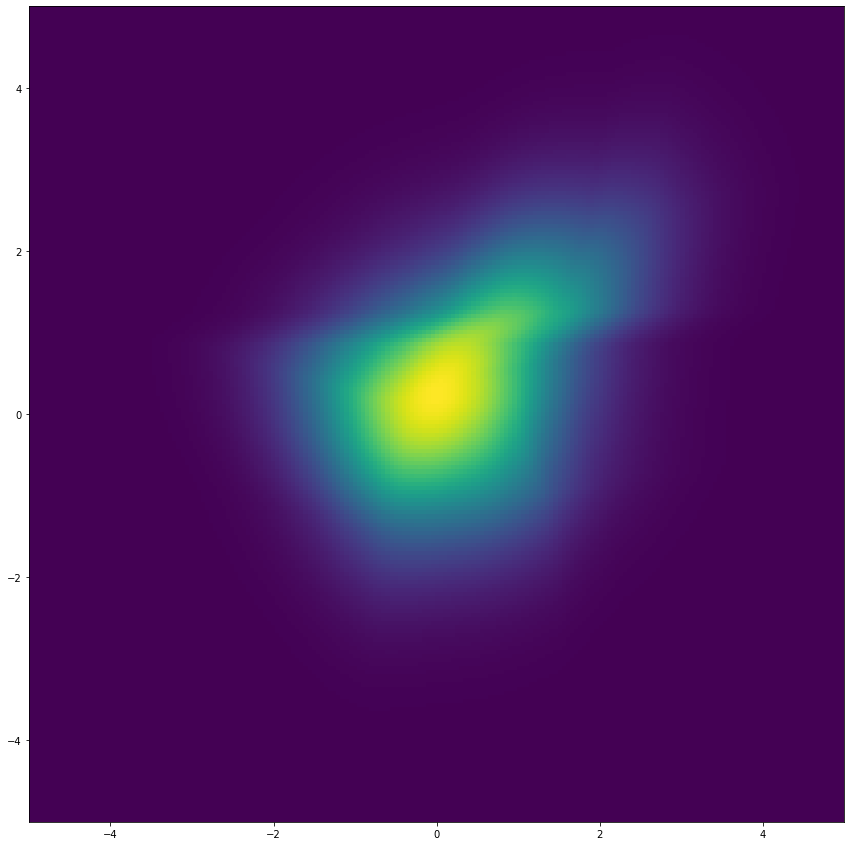

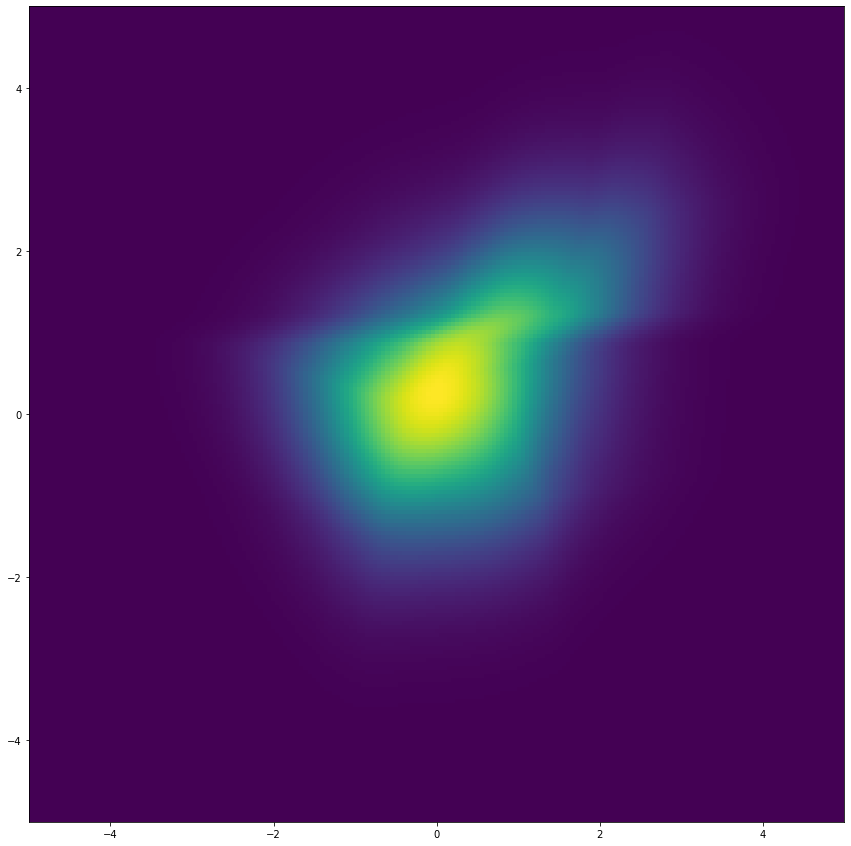

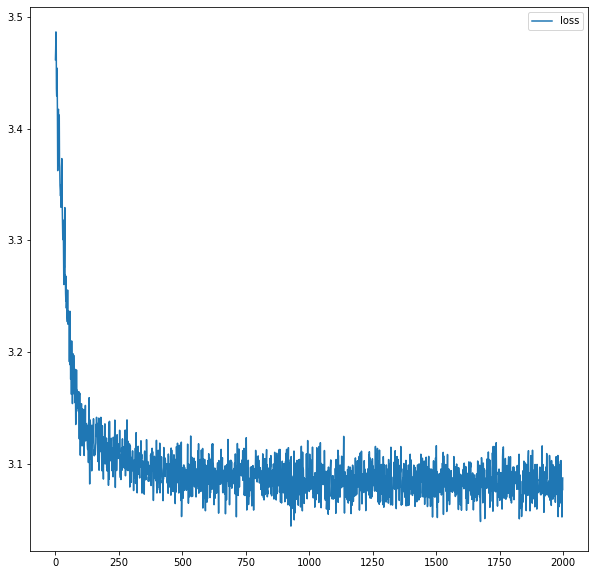

{'max_iter': 2000, 'num_samples': 5000, 'num_segments': 4, 'pow_of_two': 1, 'prob_delta': 0.8, 'dims_dense': [1, 4, 32, 4, 1]} {'loss': 3.0875473022460938, 'Bias_prob_hyp': 0.004706677436828621, 'SqErr_prob_hyp': 2.215281249435164e-05}
4 1 2000 10000 [ 1 16 64 16  1]


 12%|█▏        | 249/2000 [00:29<03:38,  8.03it/s]<ipython-input-19-1b55656c51ce>:89: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, prob.data.numpy())
100%|██████████| 2000/2000 [04:01<00:00,  8.30it/s]


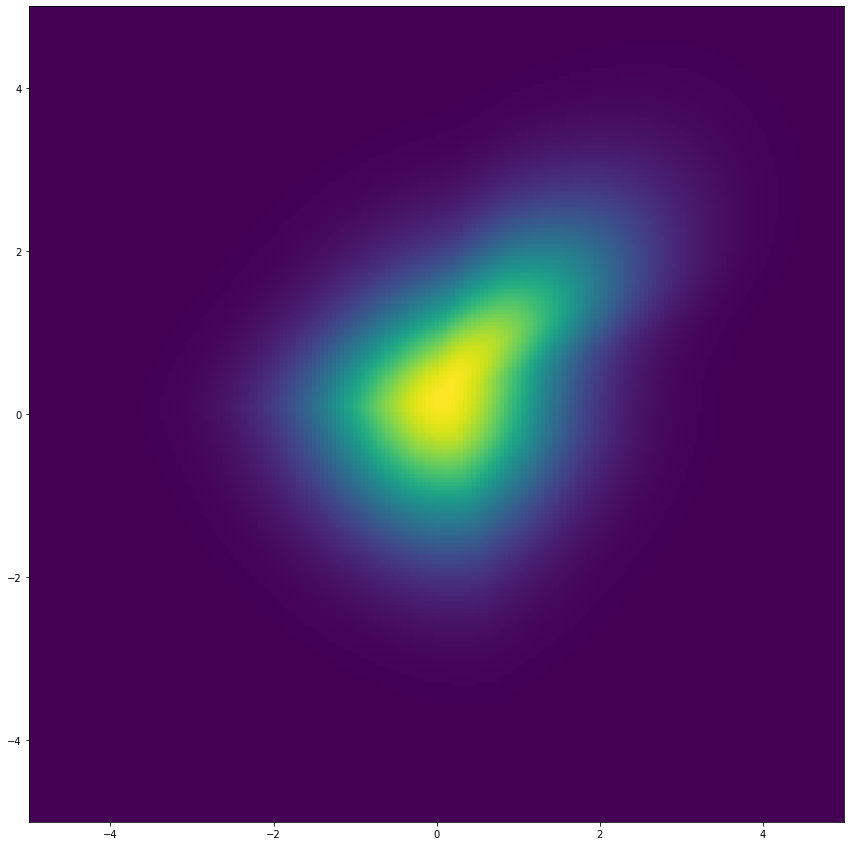

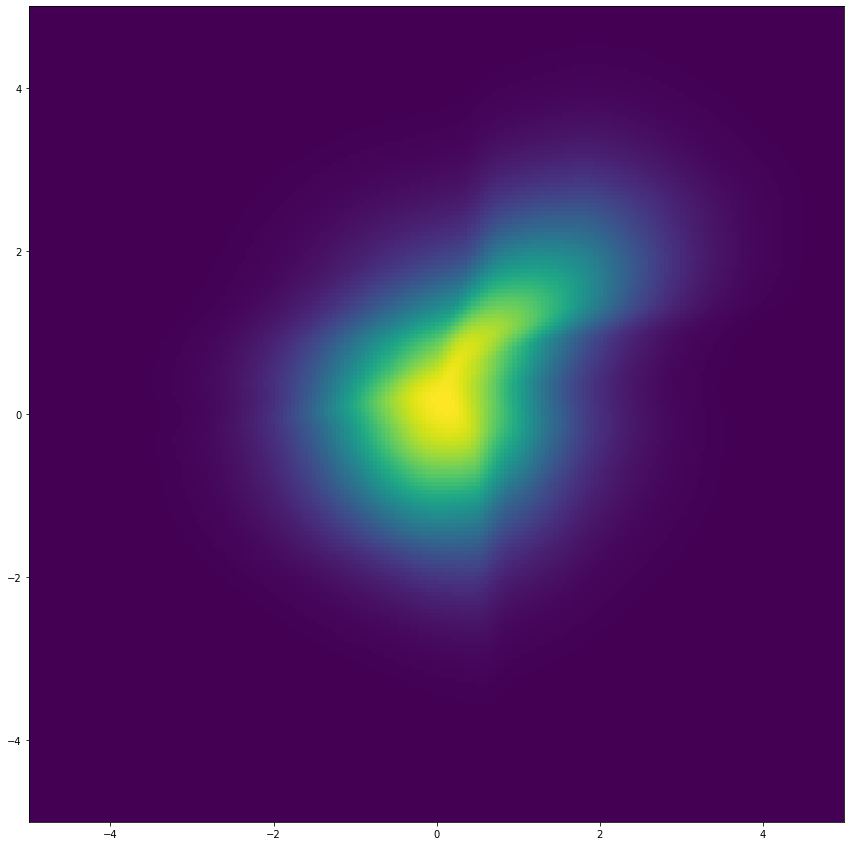

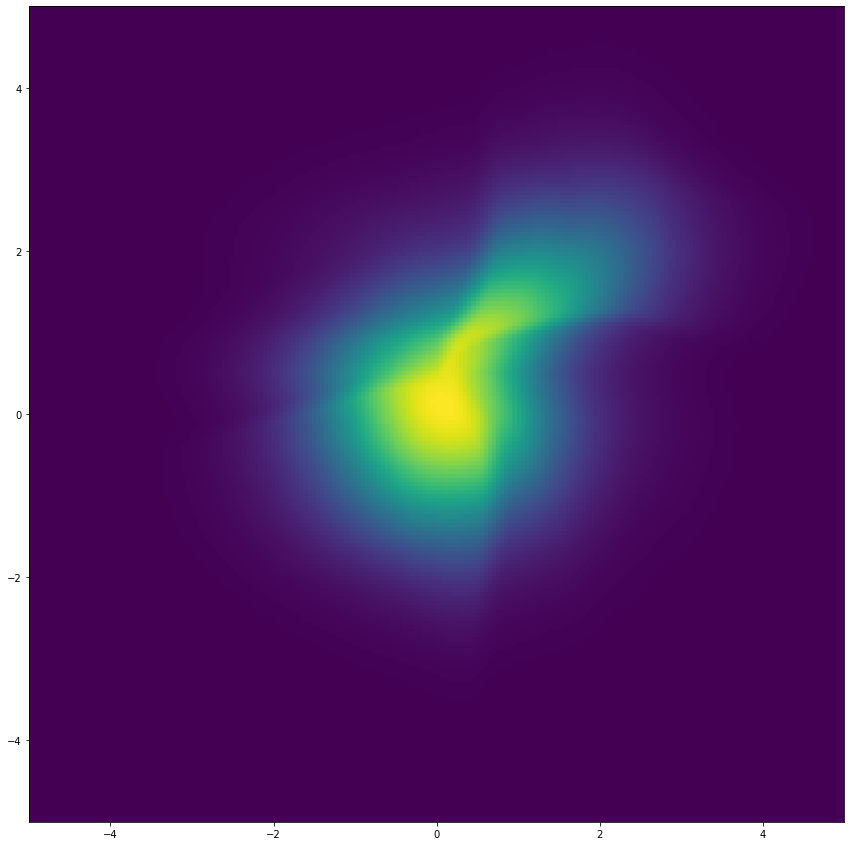

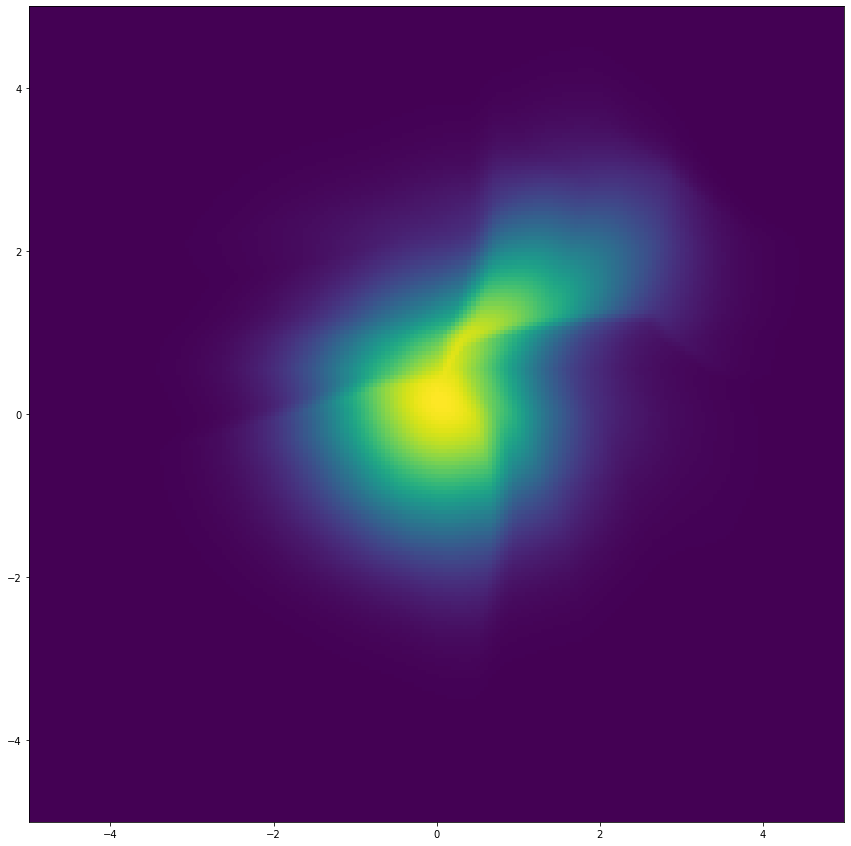

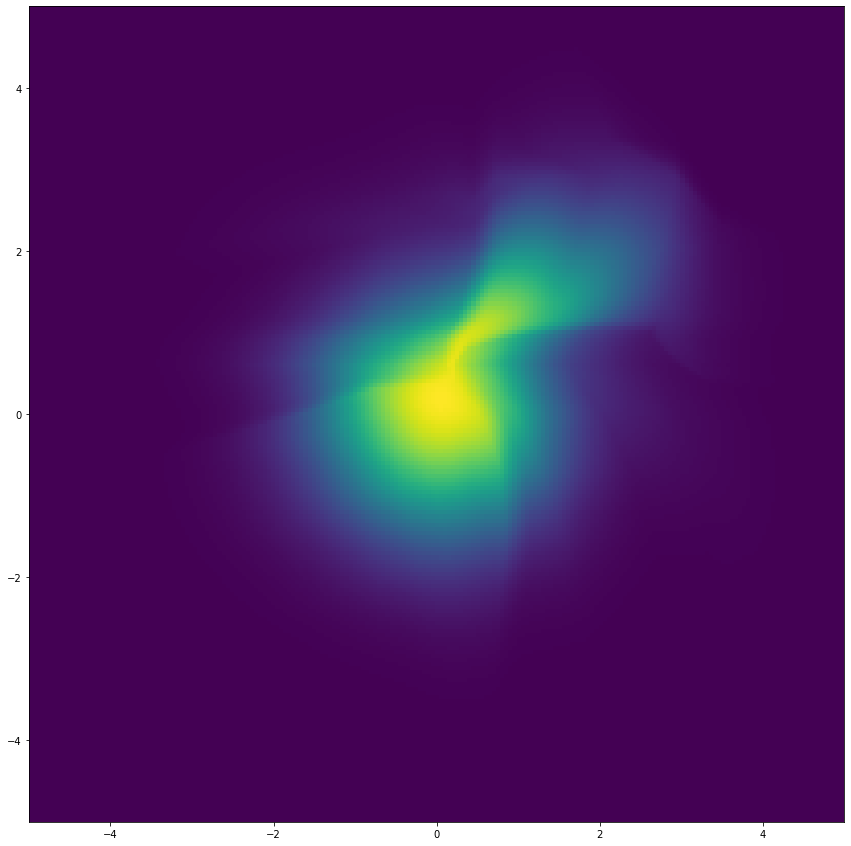

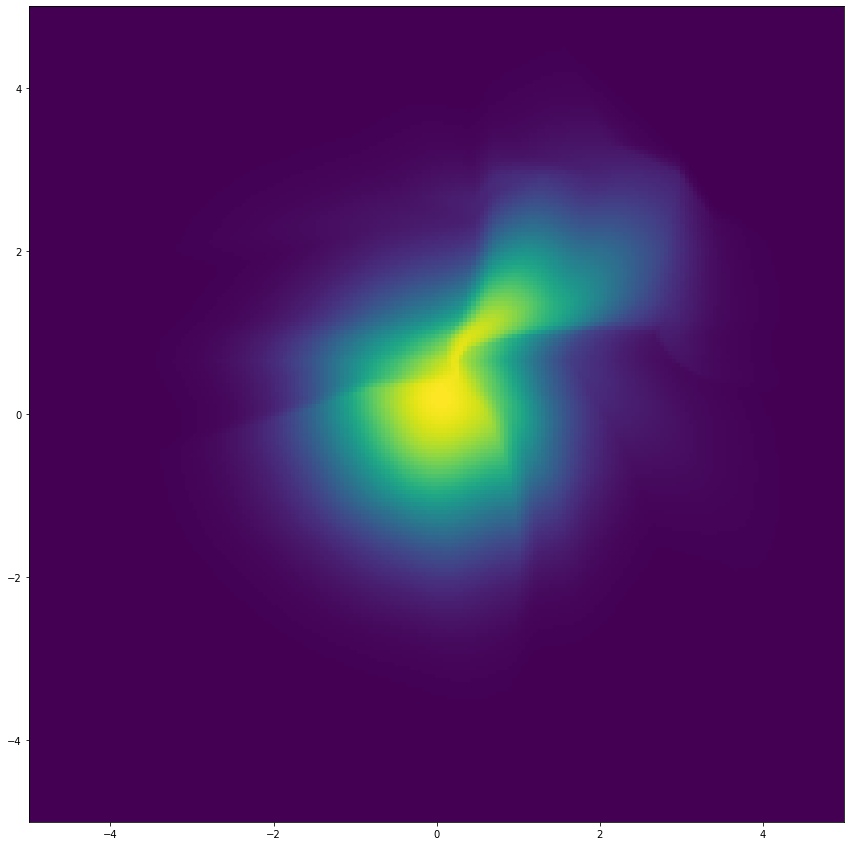

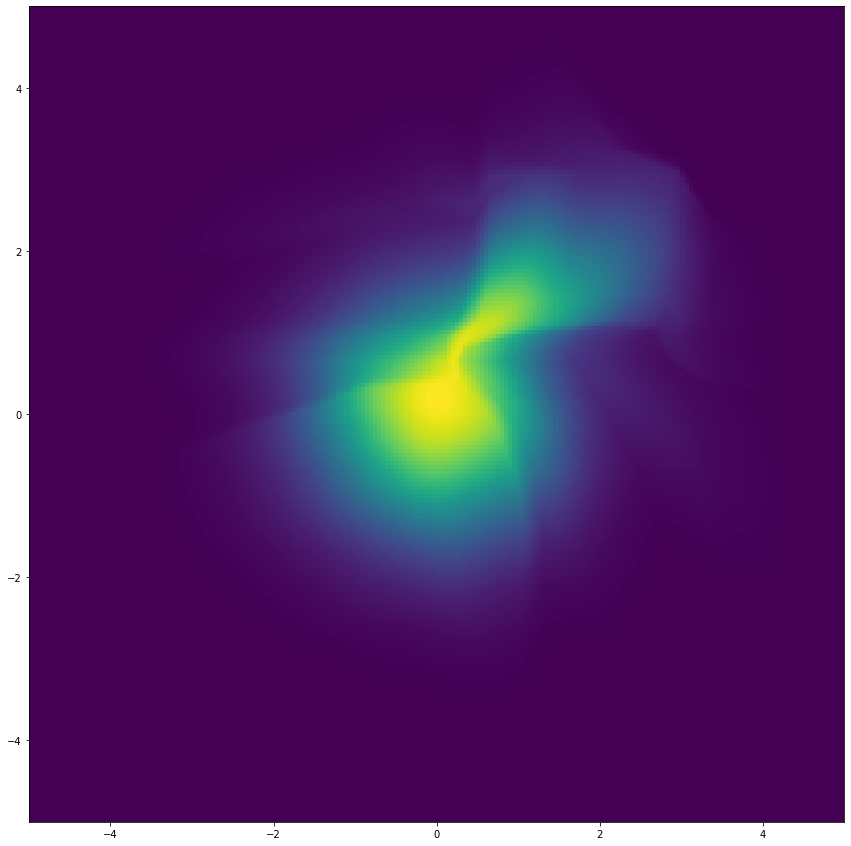

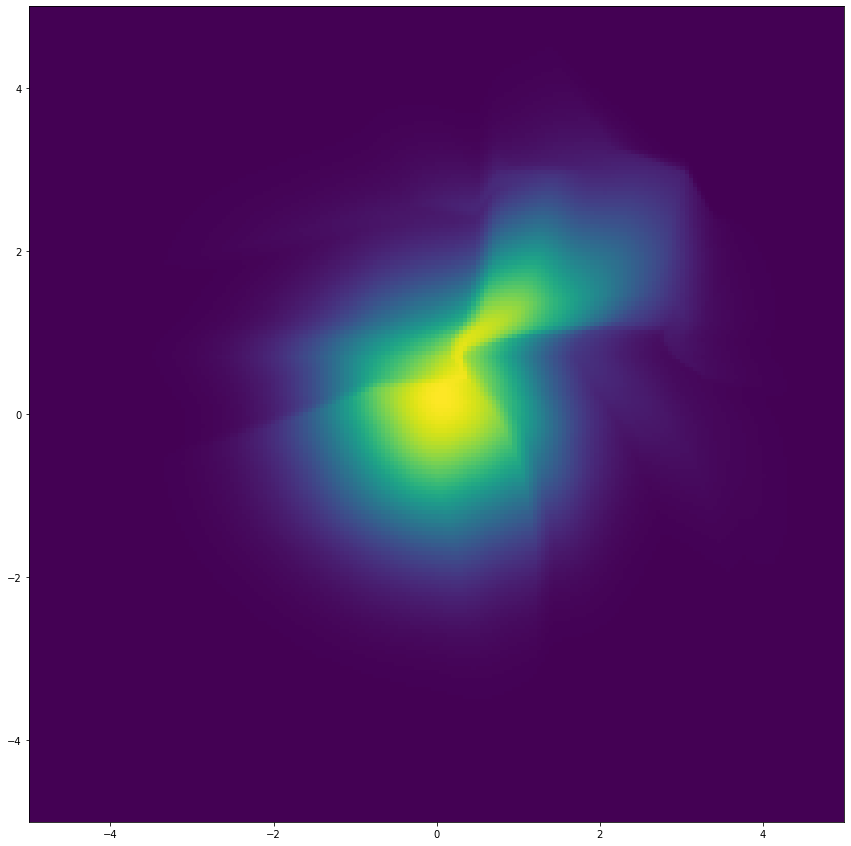

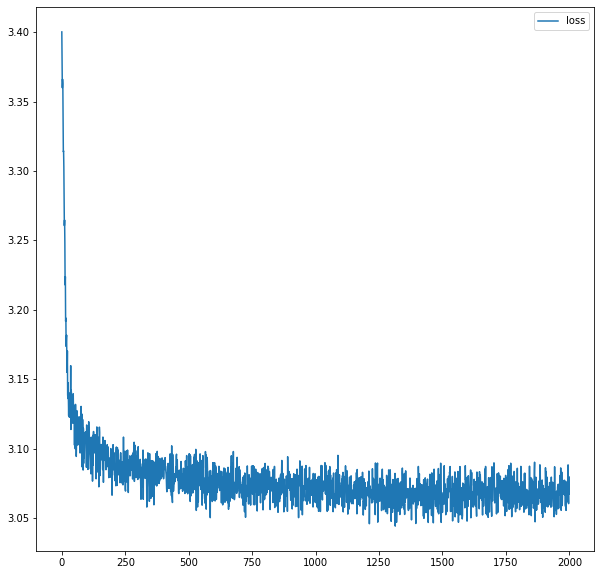

{'max_iter': 2000, 'num_samples': 10000, 'num_segments': 4, 'pow_of_two': 1, 'prob_delta': 0.8, 'dims_dense': [1, 16, 64, 16, 1]} {'loss': 3.0674290657043457, 'Bias_prob_hyp': 0.002306677436828608, 'SqErr_prob_hyp': 5.320760797574197e-06}
4 1 2000 10000 [ 1 16 32 16  1]


 12%|█▏        | 248/2000 [00:22<02:31, 11.56it/s]<ipython-input-19-1b55656c51ce>:89: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, prob.data.numpy())
100%|██████████| 2000/2000 [03:09<00:00, 10.57it/s]


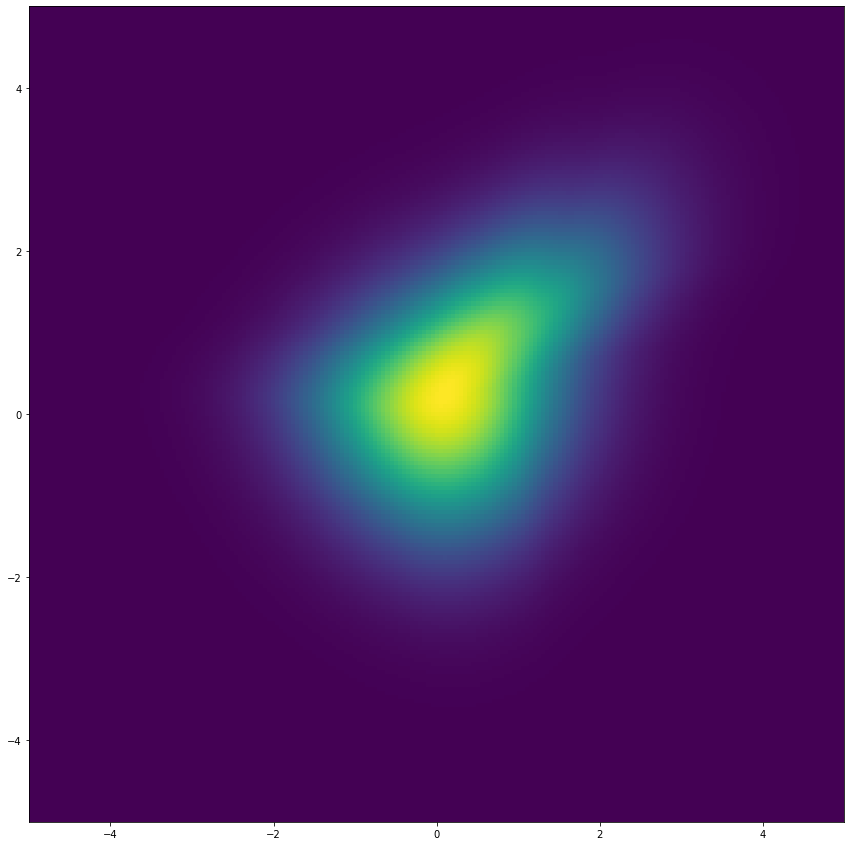

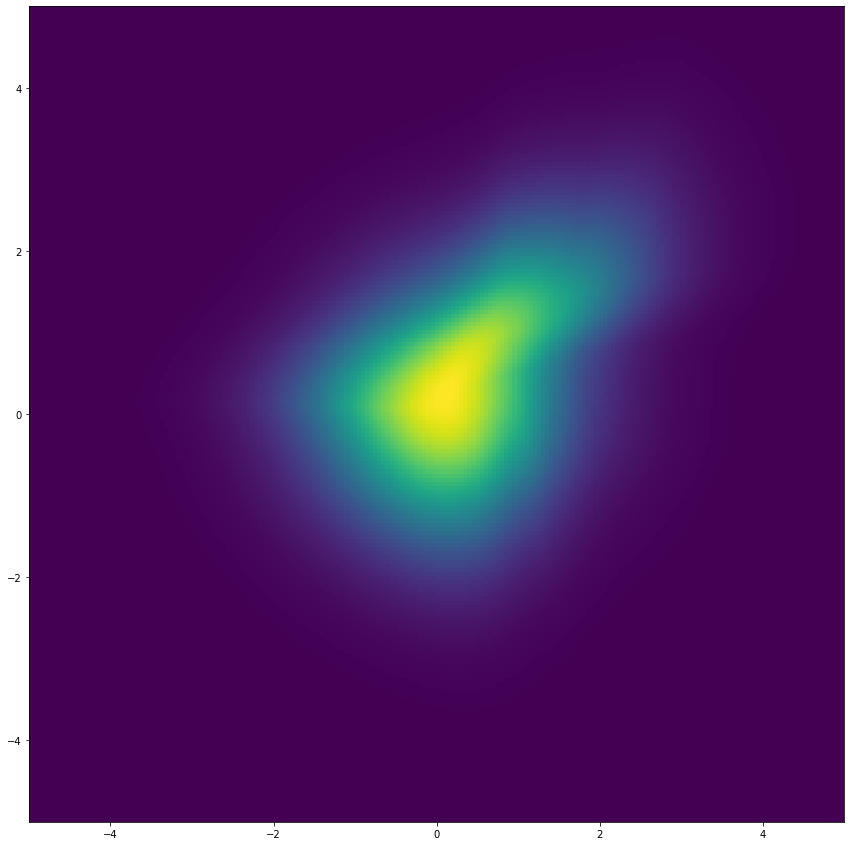

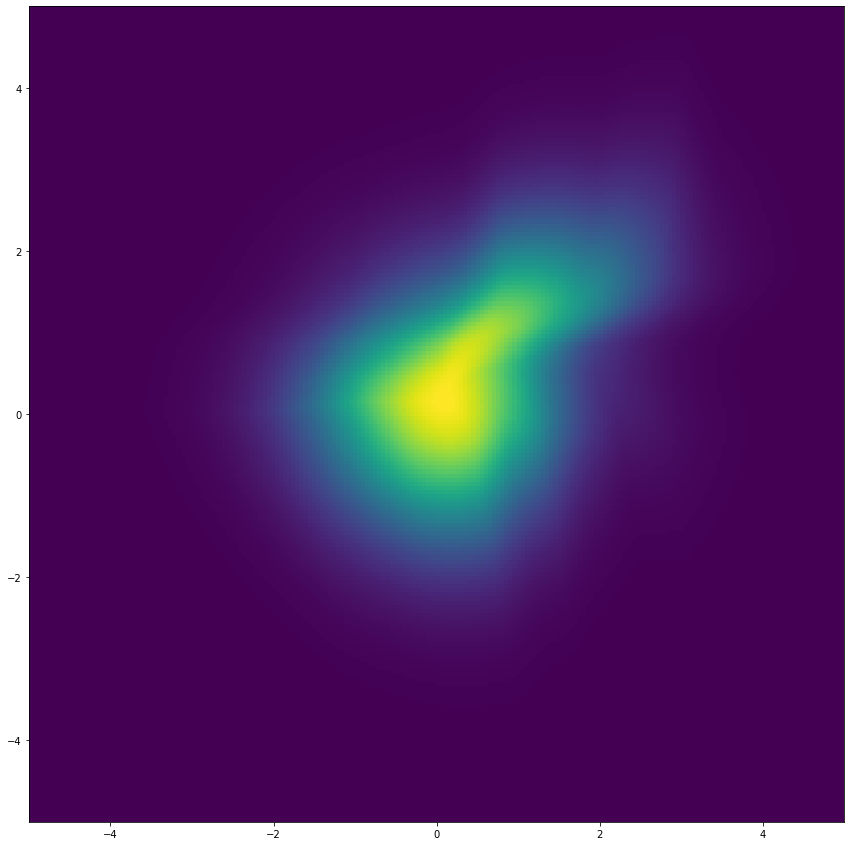

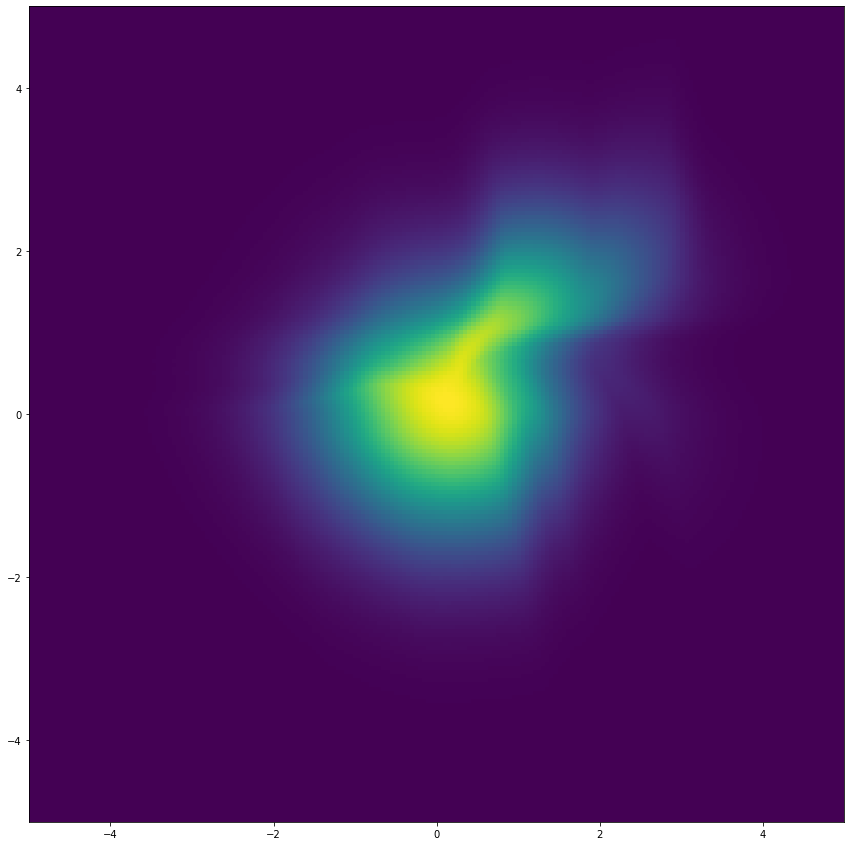

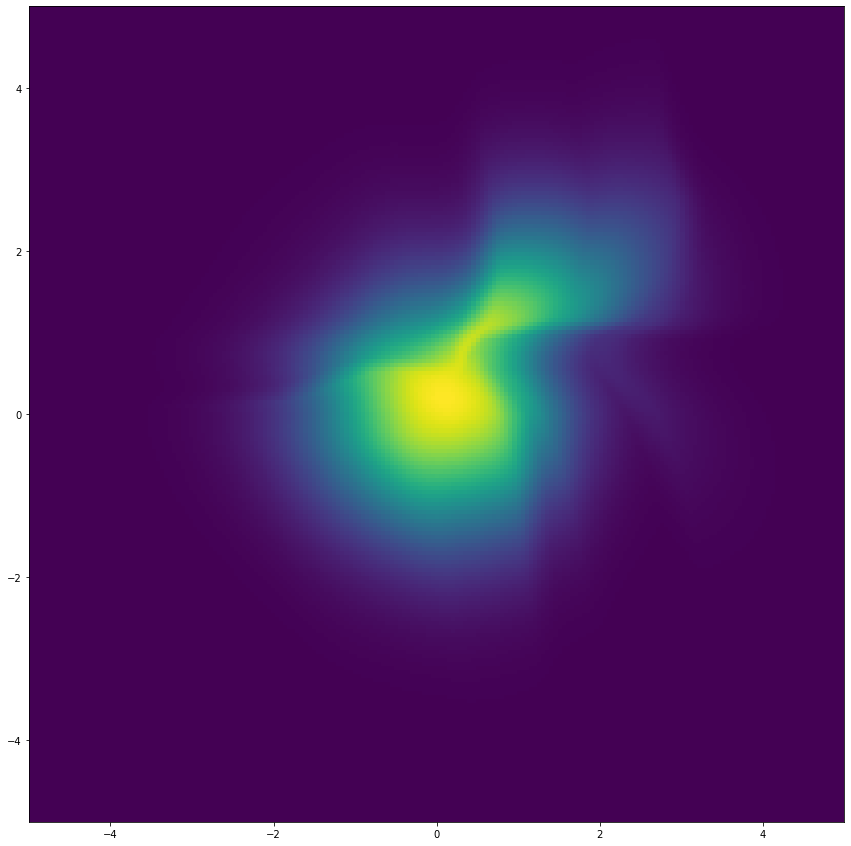

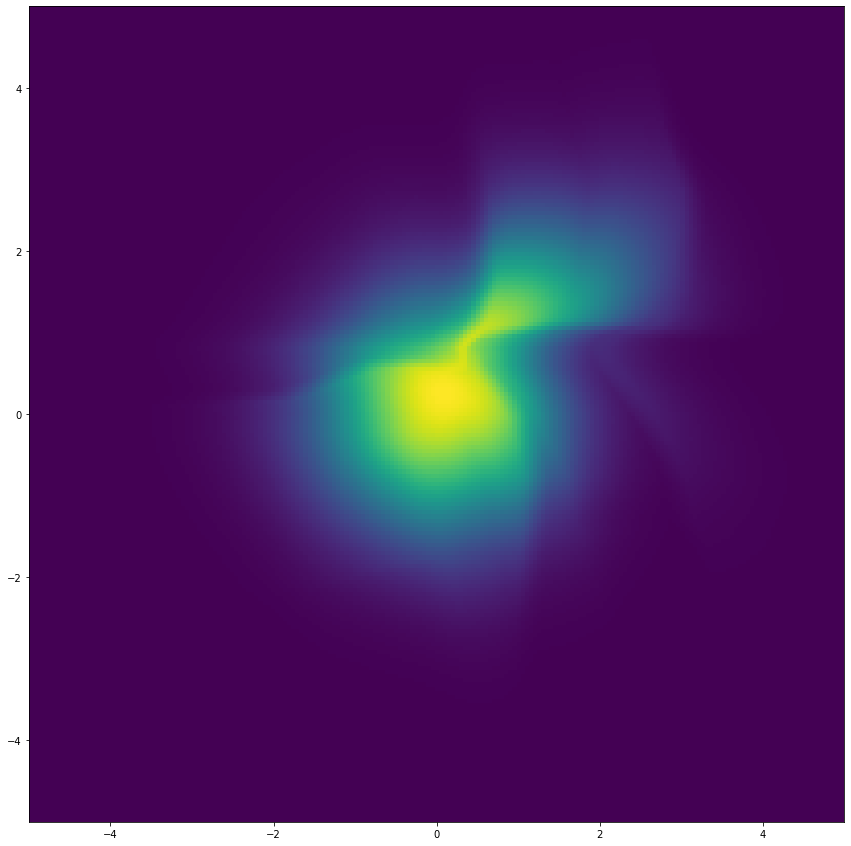

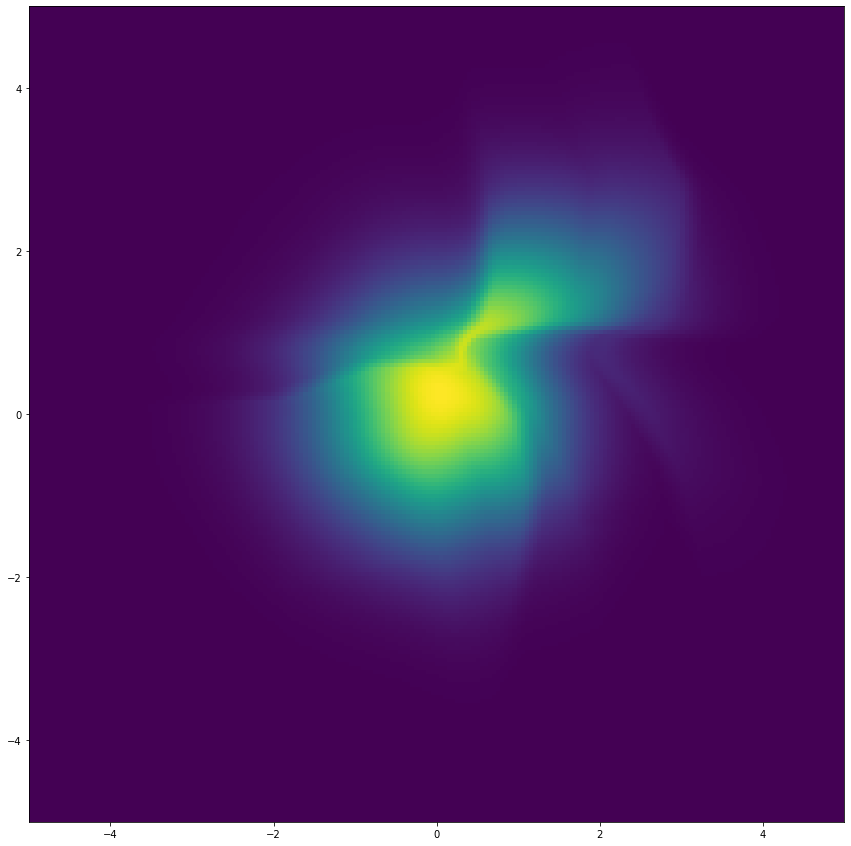

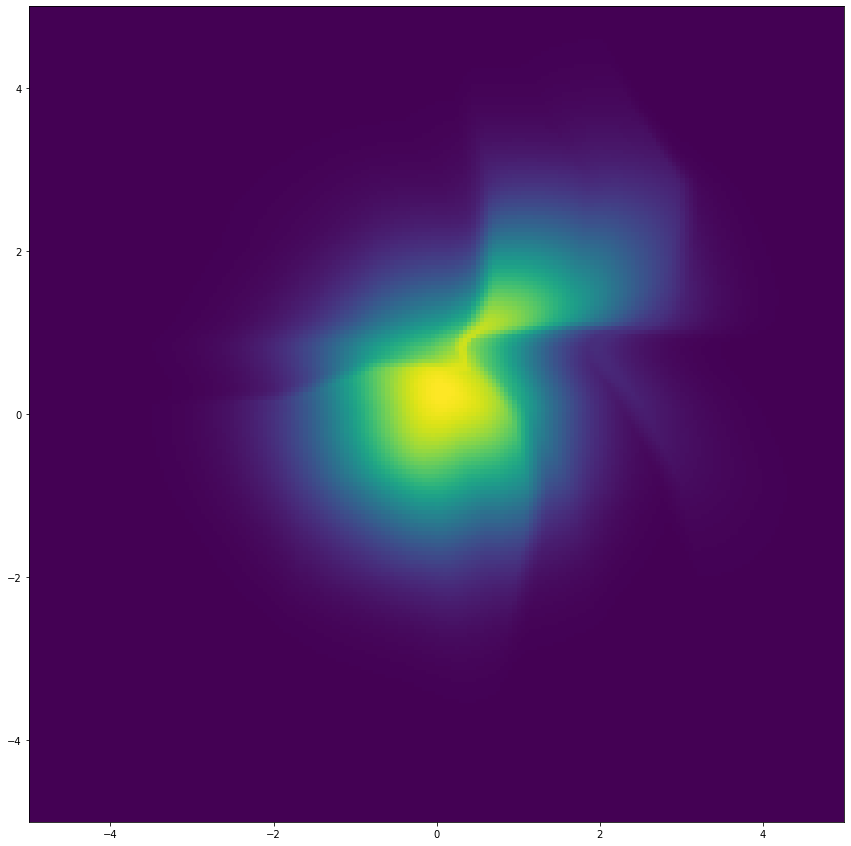

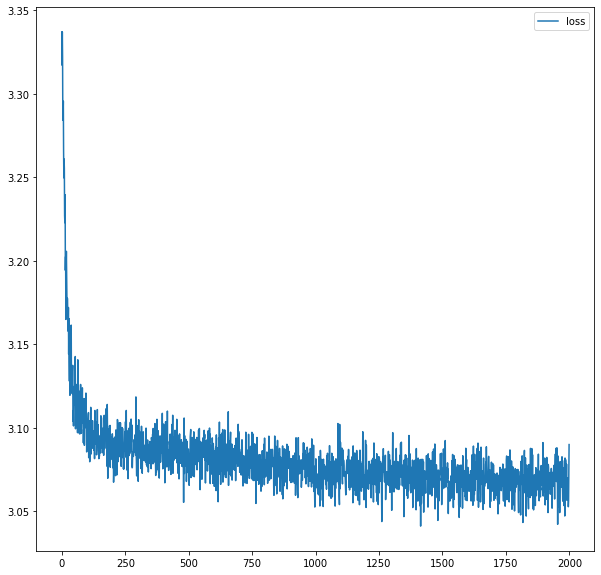

{'max_iter': 2000, 'num_samples': 10000, 'num_segments': 4, 'pow_of_two': 1, 'prob_delta': 0.8, 'dims_dense': [1, 16, 32, 16, 1]} {'loss': 3.090028762817383, 'Bias_prob_hyp': 6.677436828639305e-06, 'SqErr_prob_hyp': 4.458816260046854e-11}
4 1 2000 10000 [ 1  4 32  4  1]


 12%|█▏        | 248/2000 [00:19<02:04, 14.04it/s]<ipython-input-19-1b55656c51ce>:89: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, prob.data.numpy())
100%|██████████| 2000/2000 [02:41<00:00, 12.37it/s]


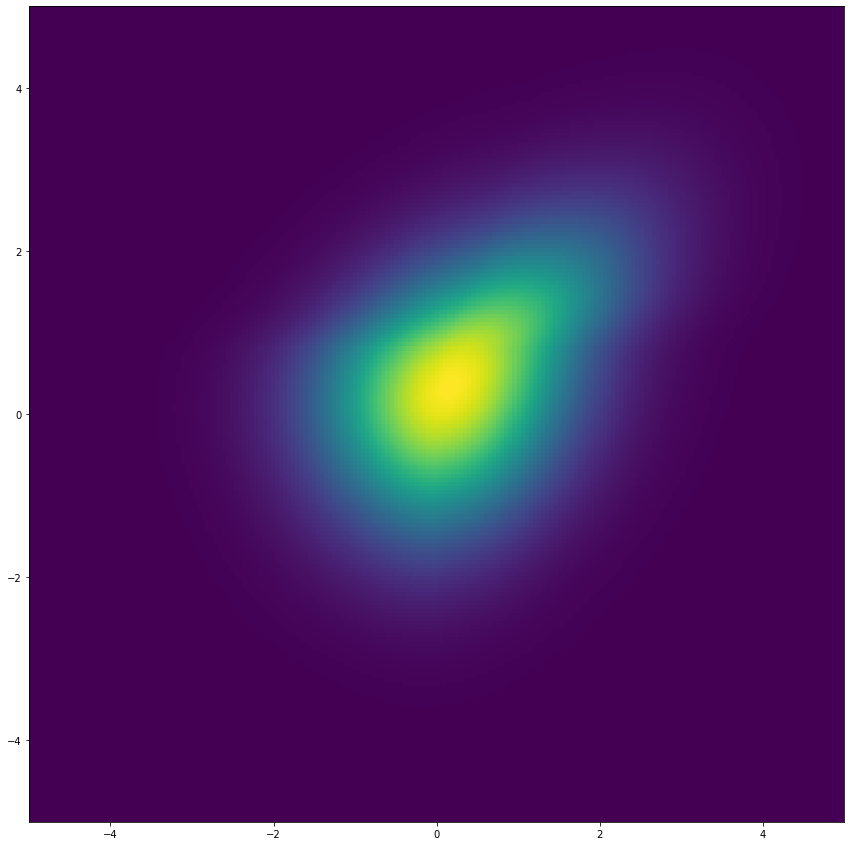

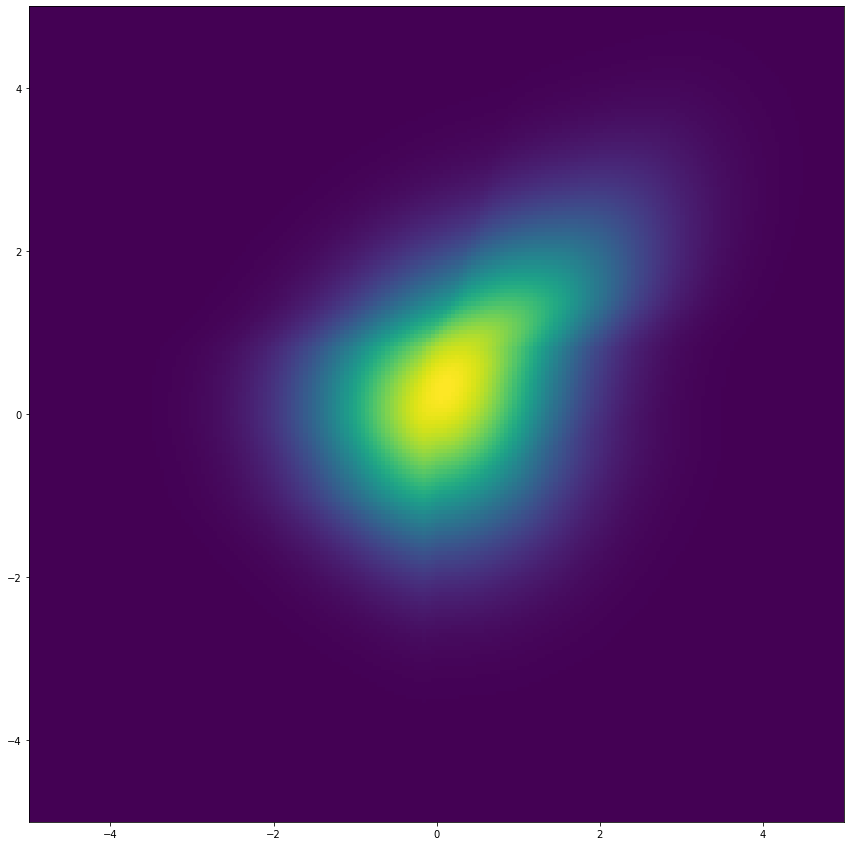

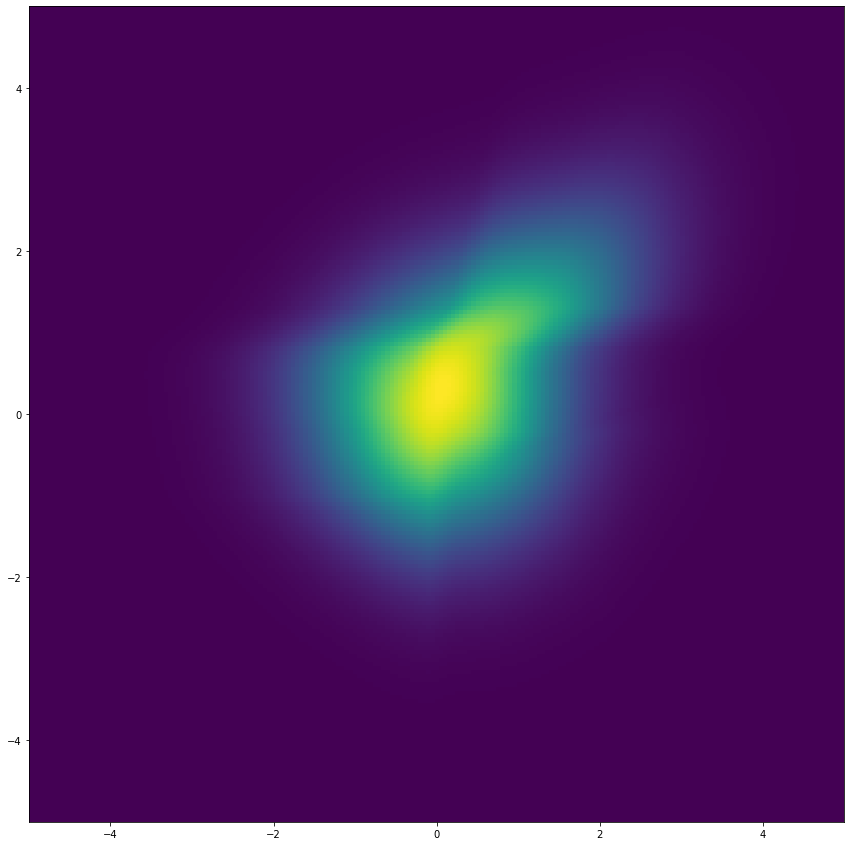

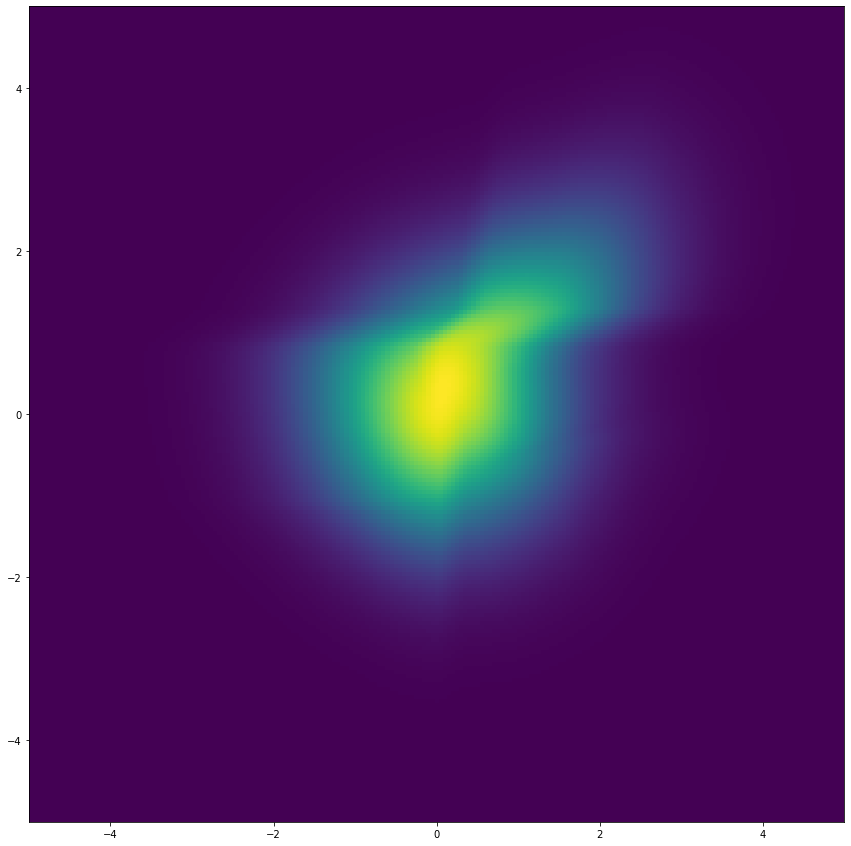

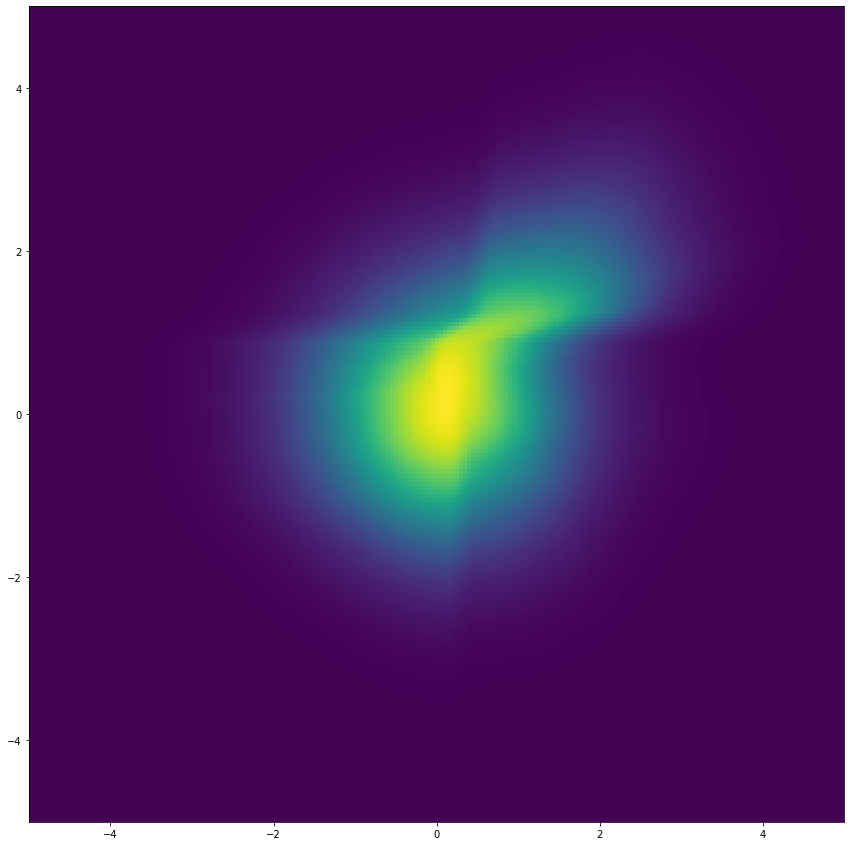

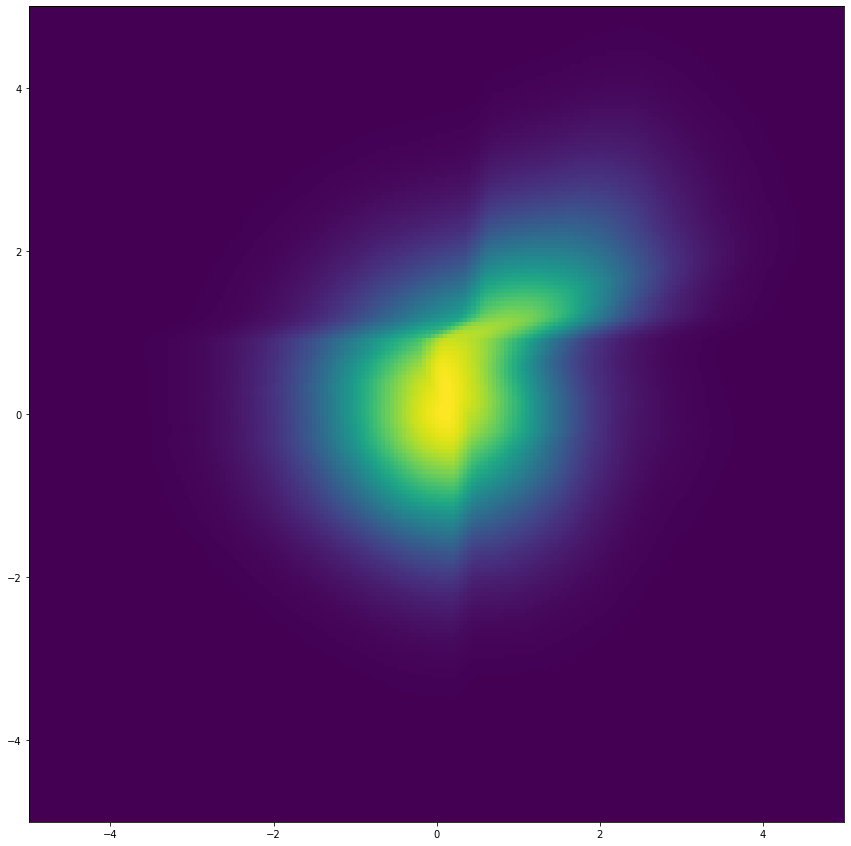

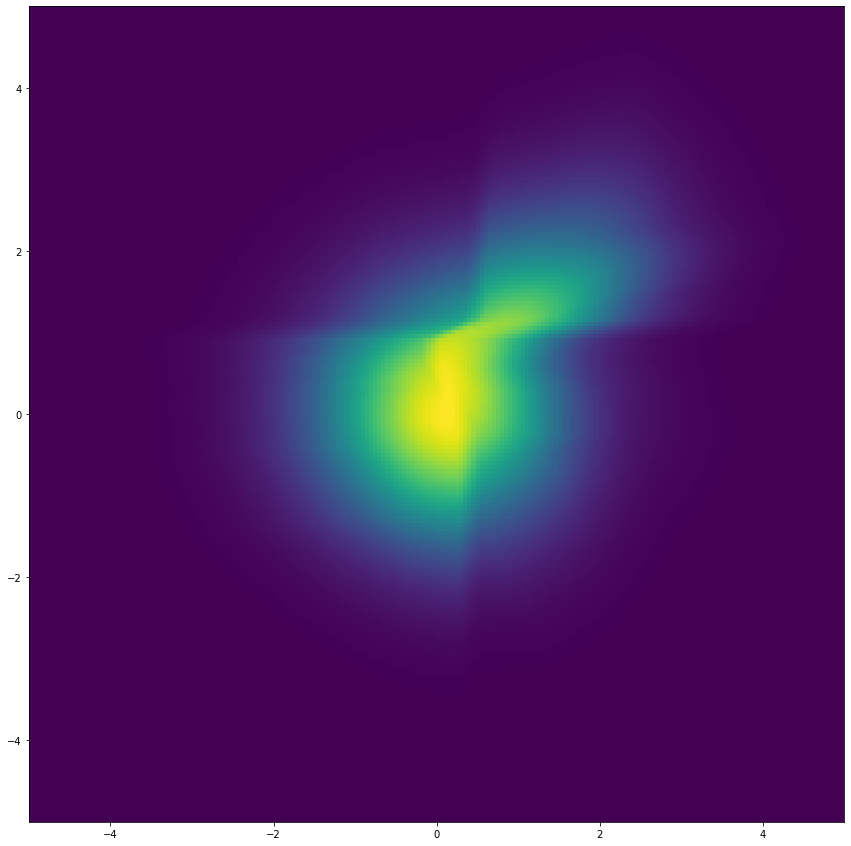

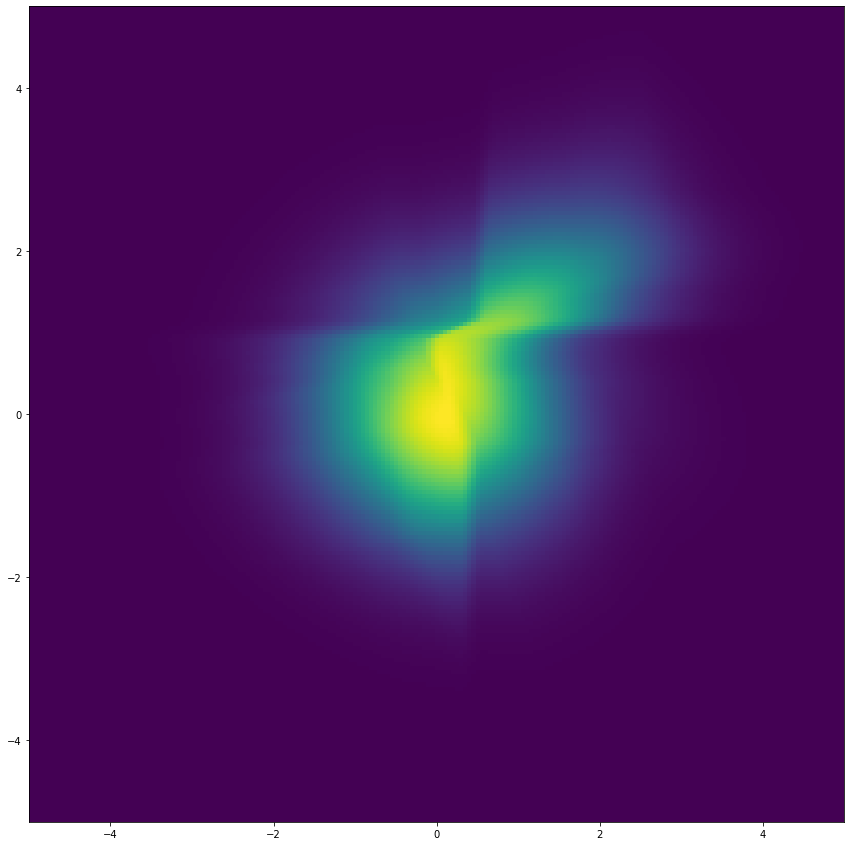

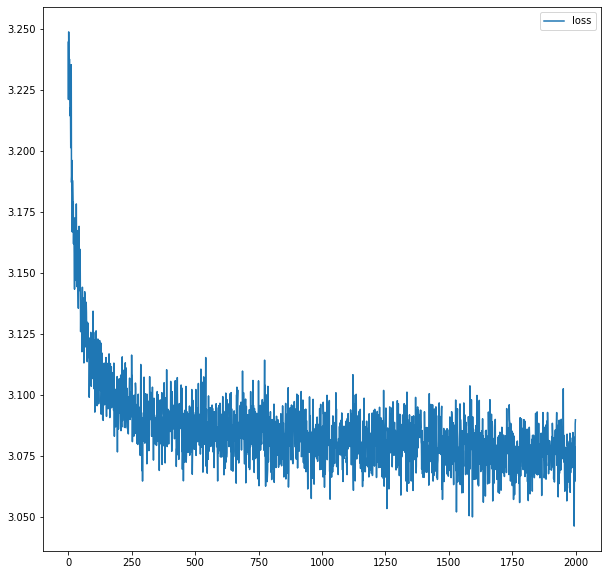

{'max_iter': 2000, 'num_samples': 10000, 'num_segments': 4, 'pow_of_two': 1, 'prob_delta': 0.8, 'dims_dense': [1, 4, 32, 4, 1]} {'loss': 3.0897409915924072, 'Bias_prob_hyp': 0.004106677436828632, 'SqErr_prob_hyp': 1.686479957015738e-05}
4 1 4000 2048 [ 1 16 64 16  1]


 12%|█▏        | 499/4000 [00:21<02:03, 28.40it/s]<ipython-input-19-1b55656c51ce>:89: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, prob.data.numpy())
100%|██████████| 4000/4000 [02:49<00:00, 23.53it/s]


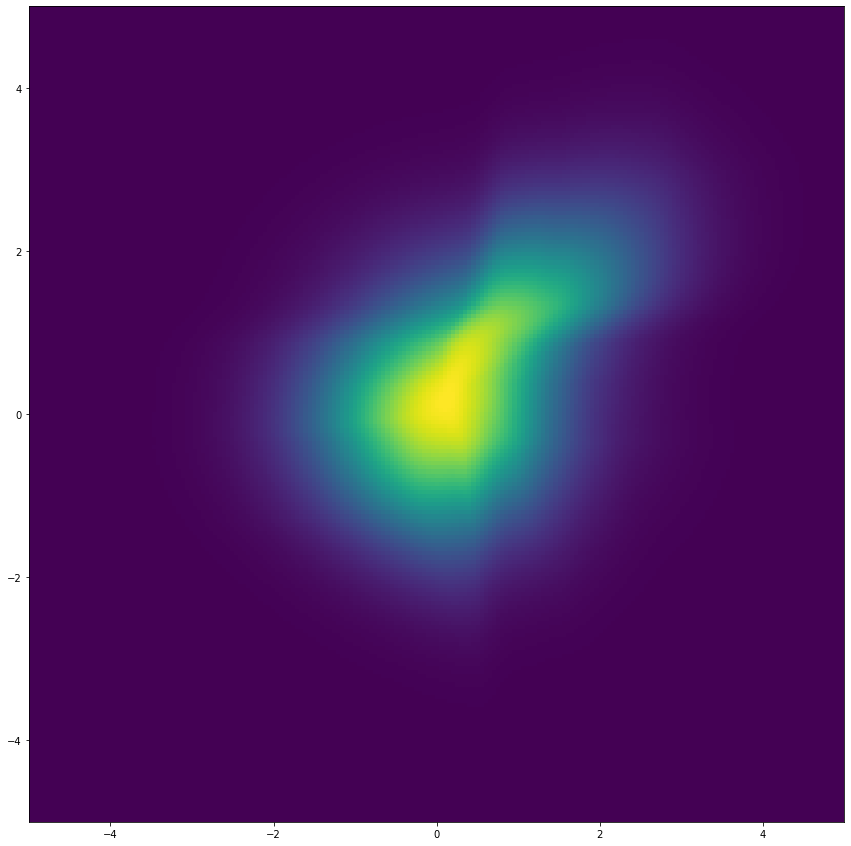

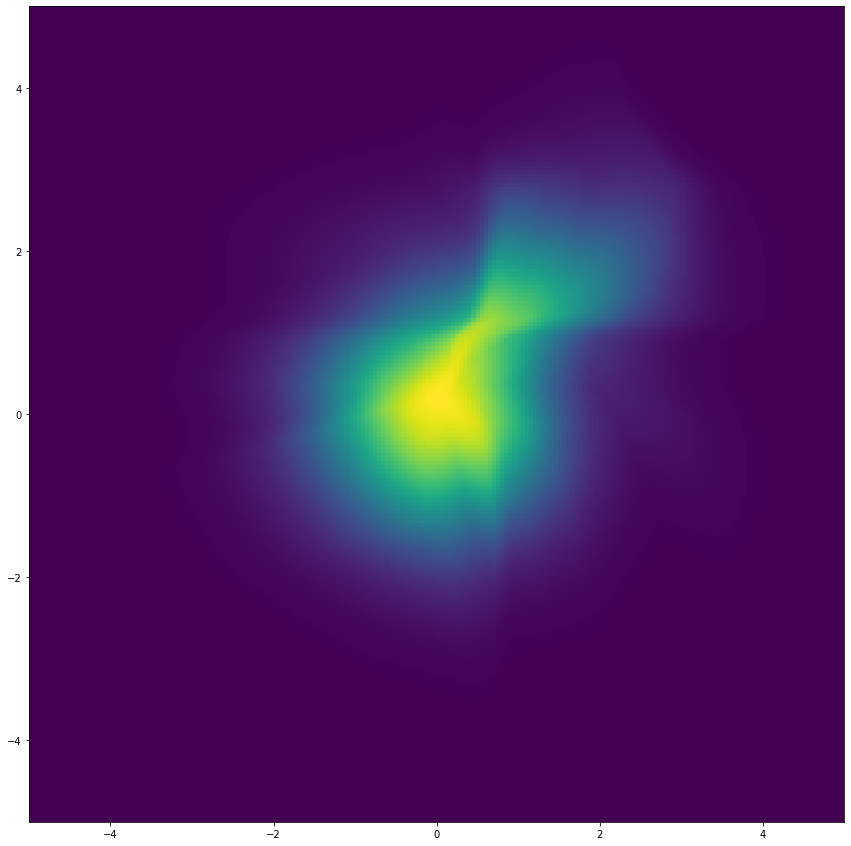

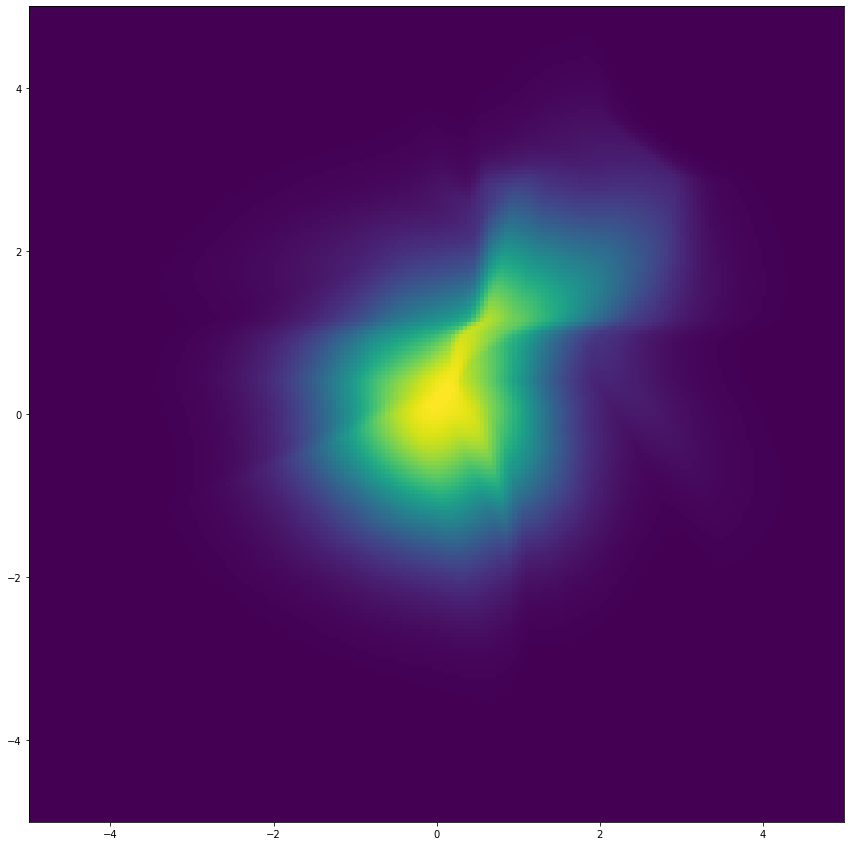

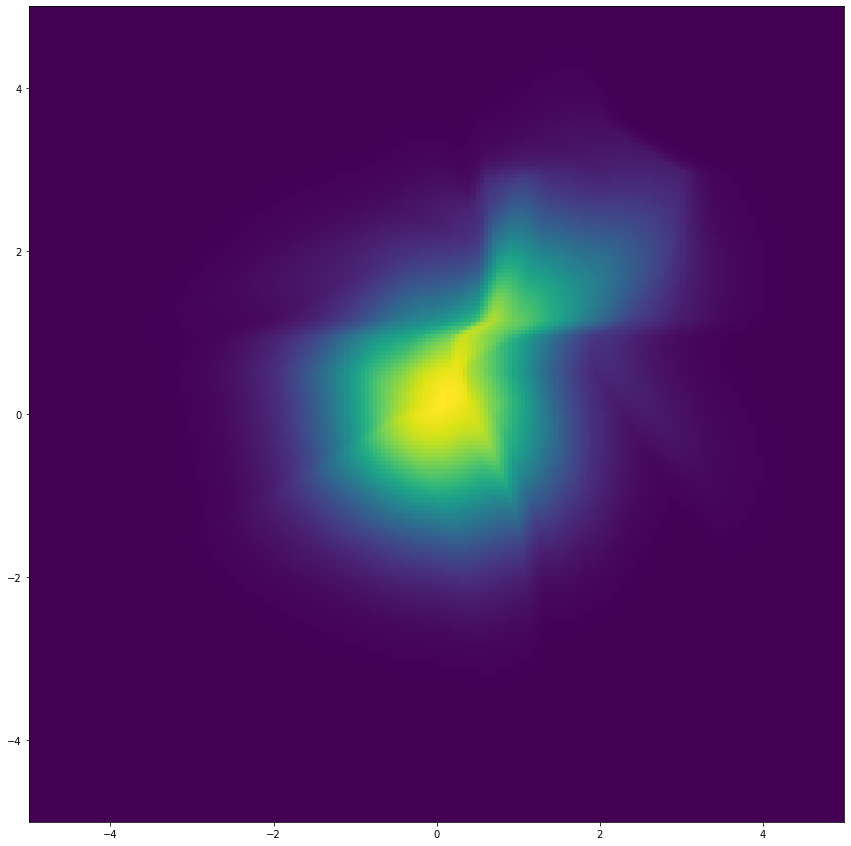

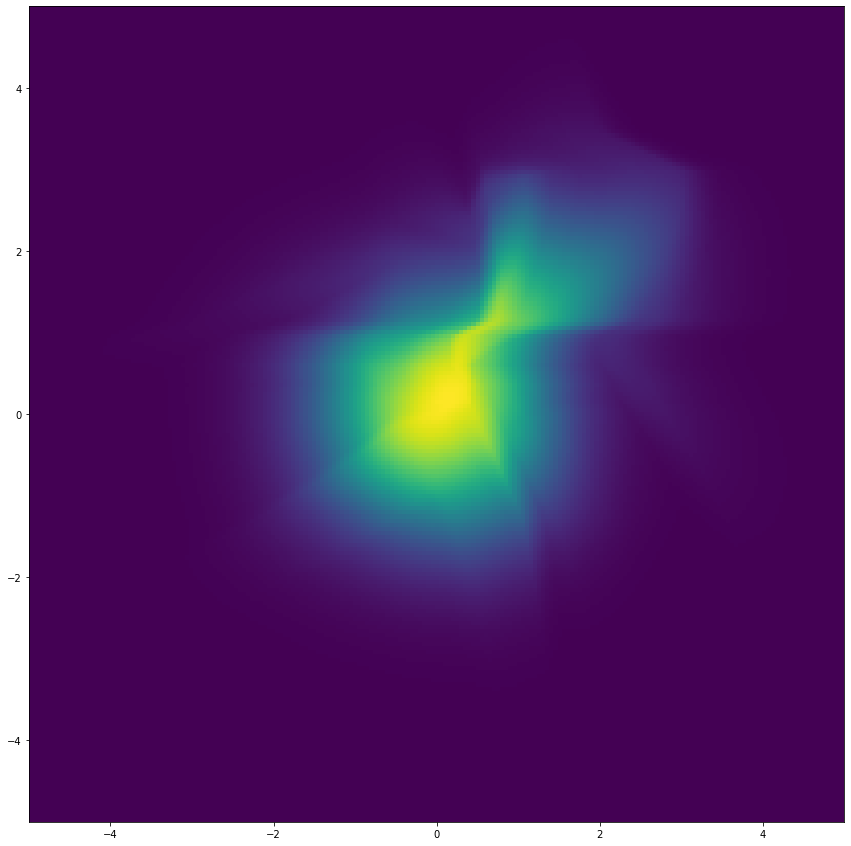

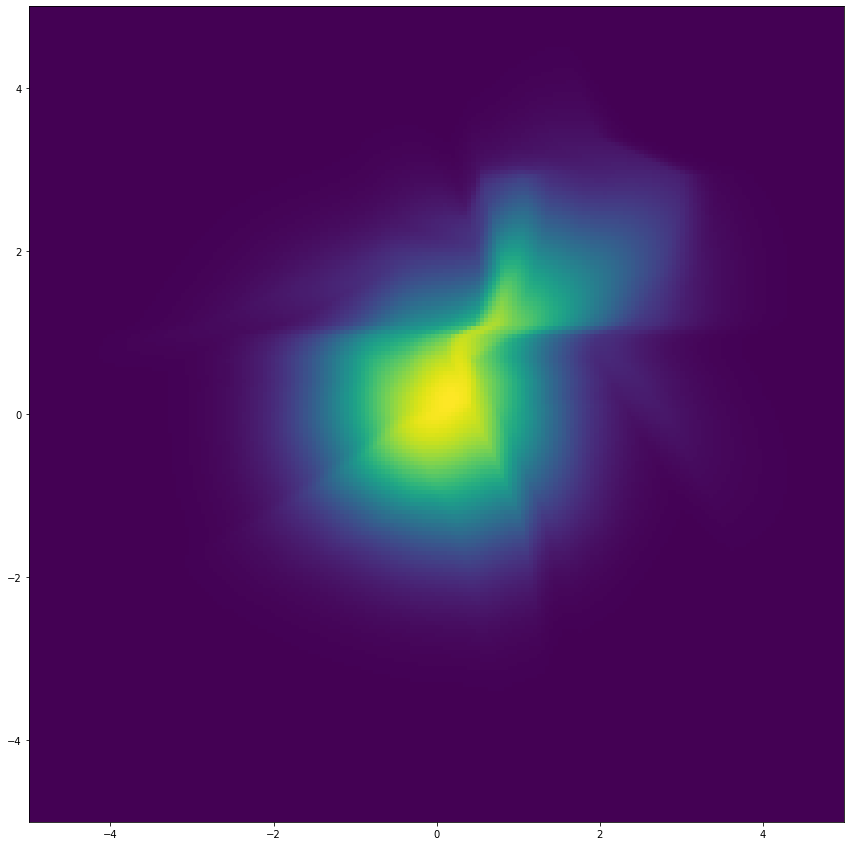

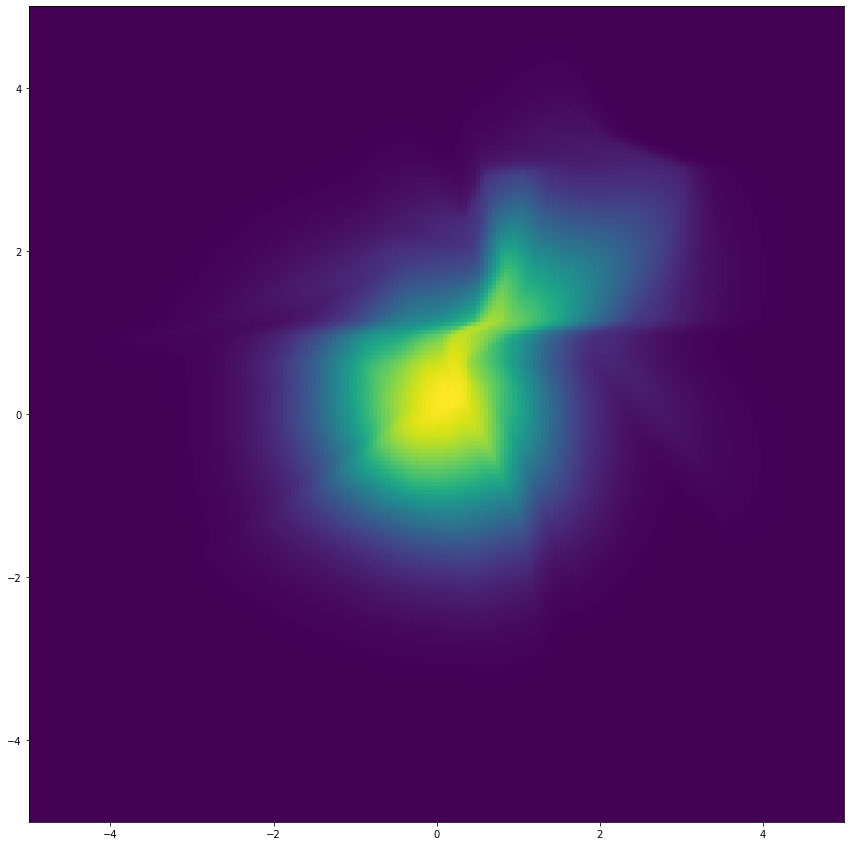

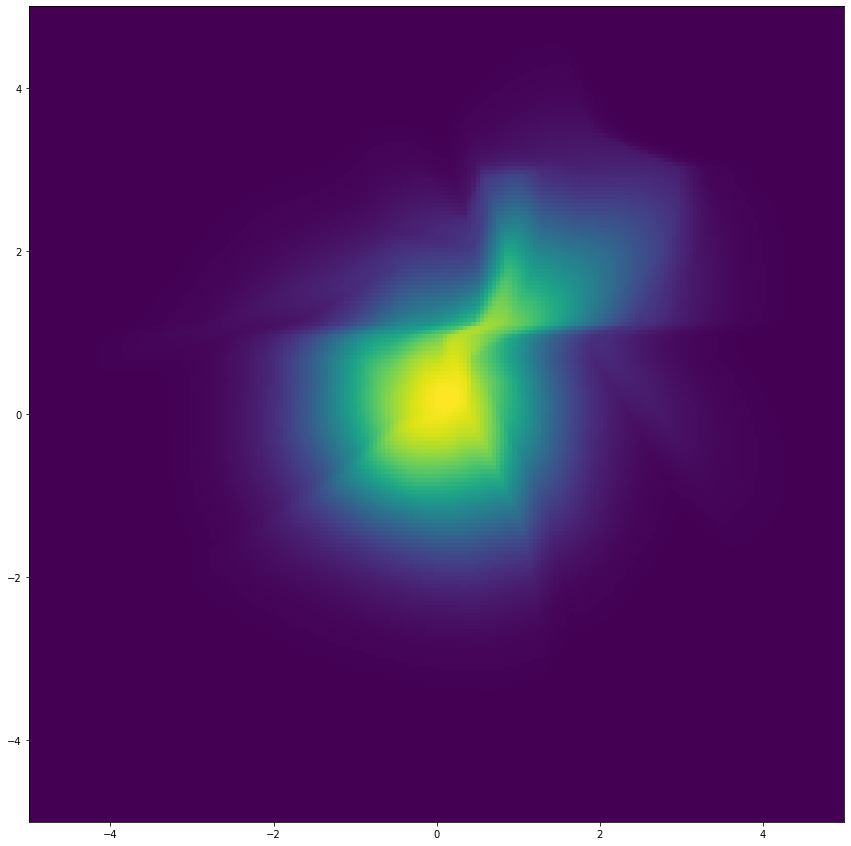

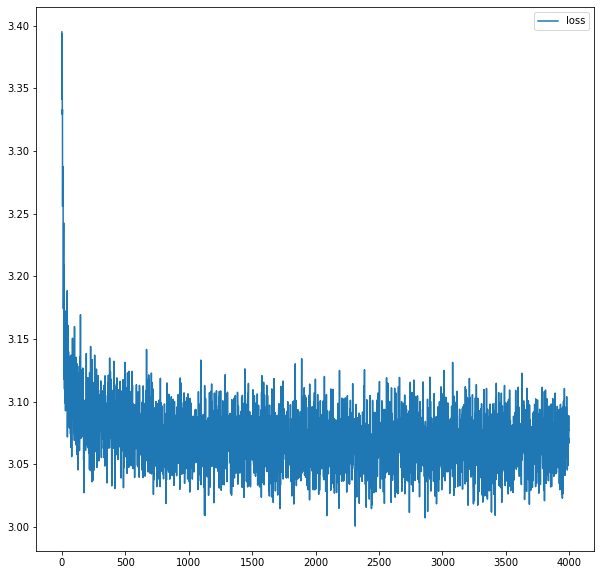

{'max_iter': 4000, 'num_samples': 2048, 'num_segments': 4, 'pow_of_two': 1, 'prob_delta': 0.8, 'dims_dense': [1, 16, 64, 16, 1]} {'loss': 3.0705549716949463, 'Bias_prob_hyp': 0.0003453493118286133, 'SqErr_prob_hyp': 1.1926614718049677e-07}
4 1 4000 2048 [ 1 16 32 16  1]


 12%|█▏        | 497/4000 [00:18<01:59, 29.20it/s]<ipython-input-19-1b55656c51ce>:89: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, prob.data.numpy())
100%|██████████| 4000/4000 [02:24<00:00, 27.67it/s]


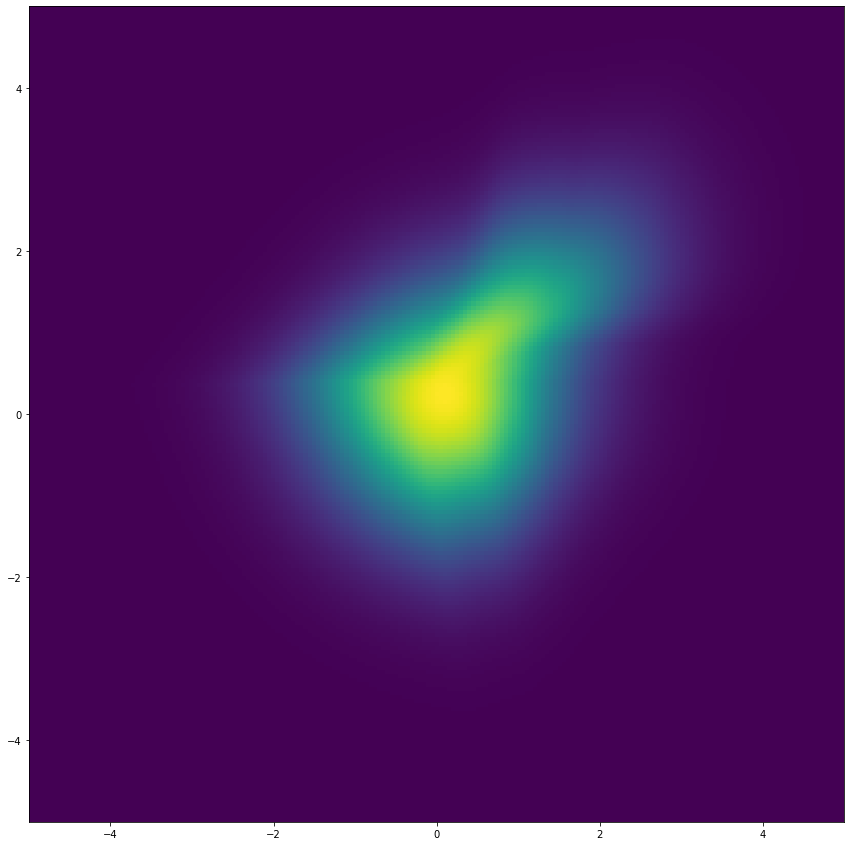

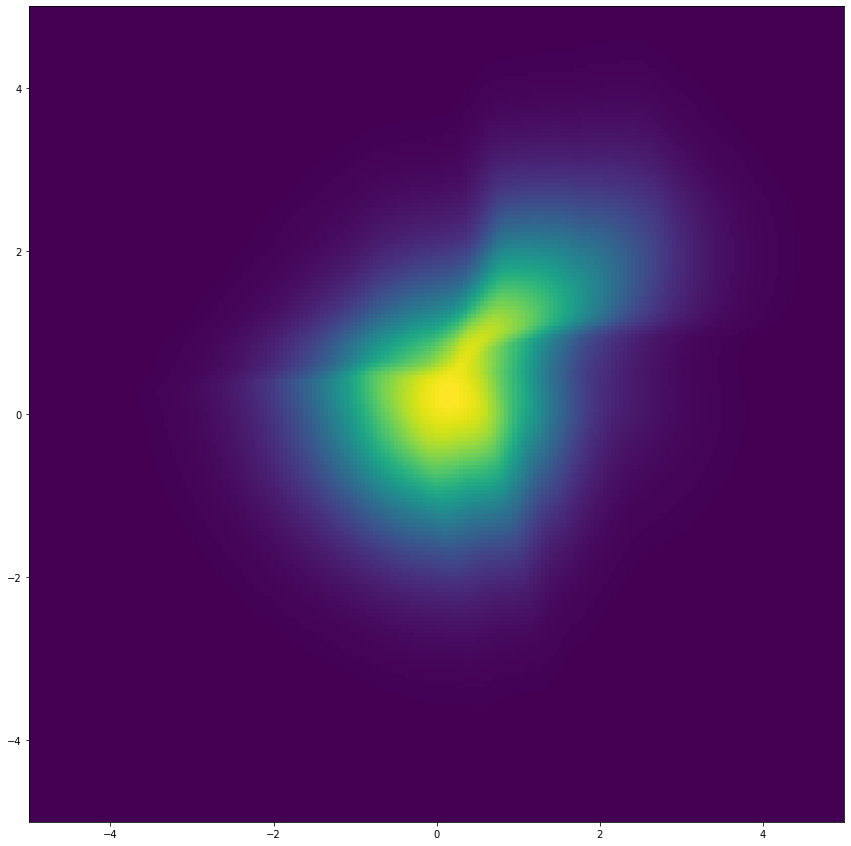

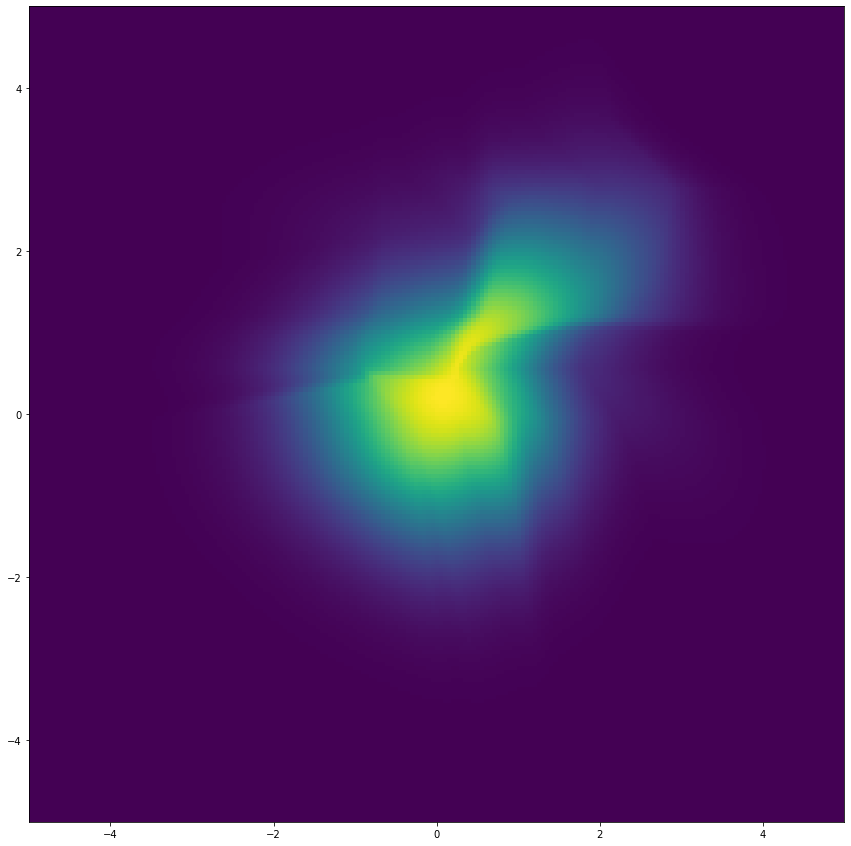

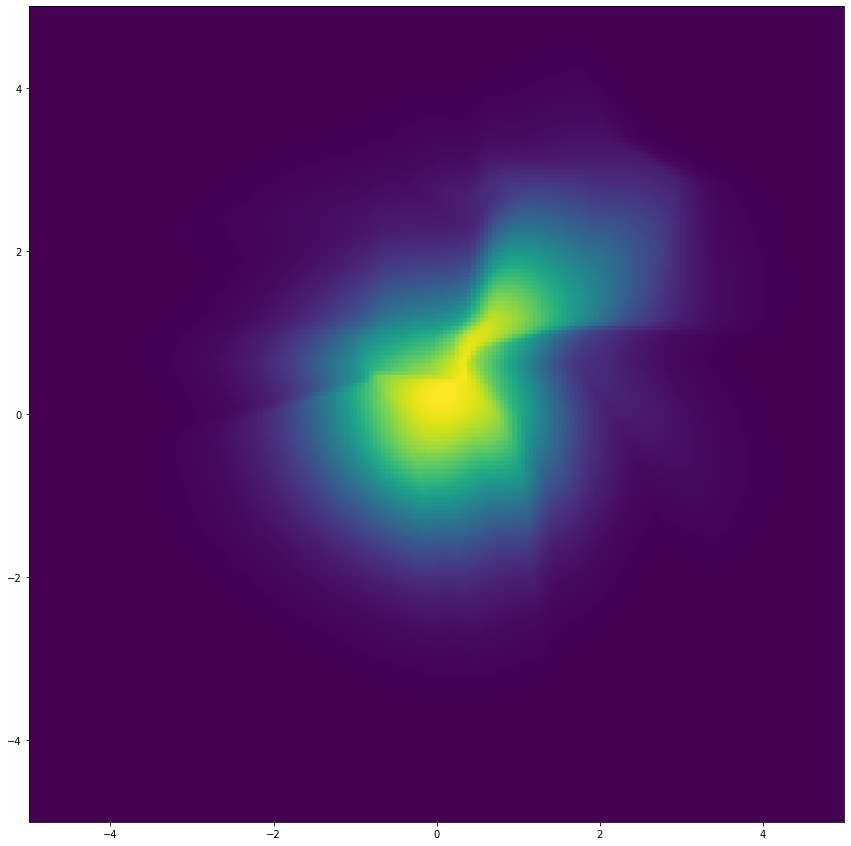

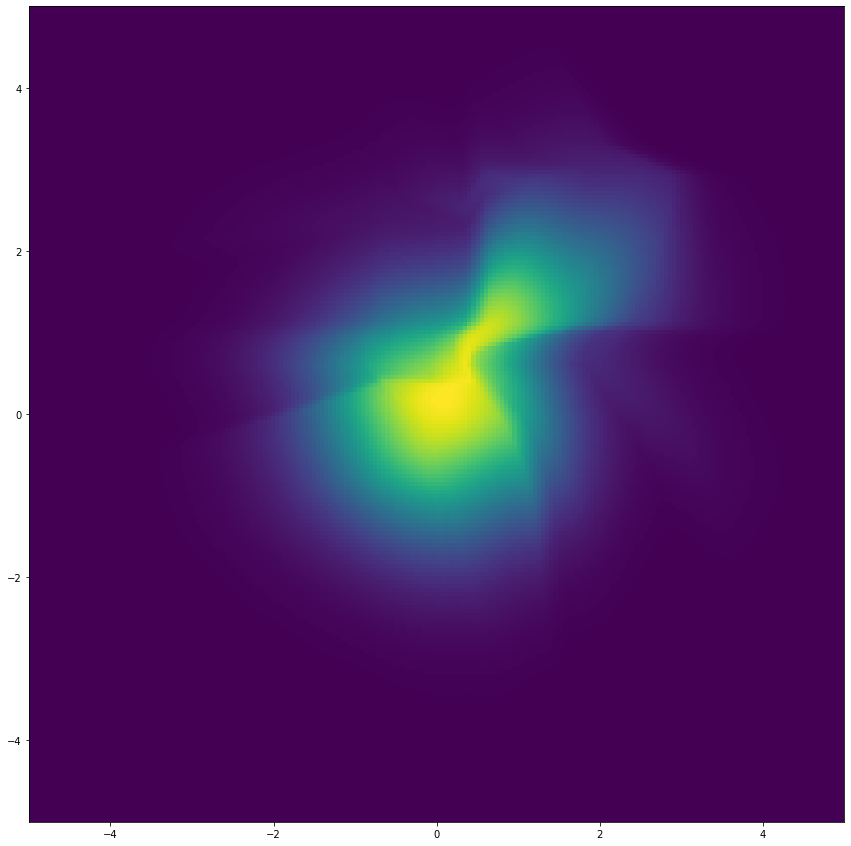

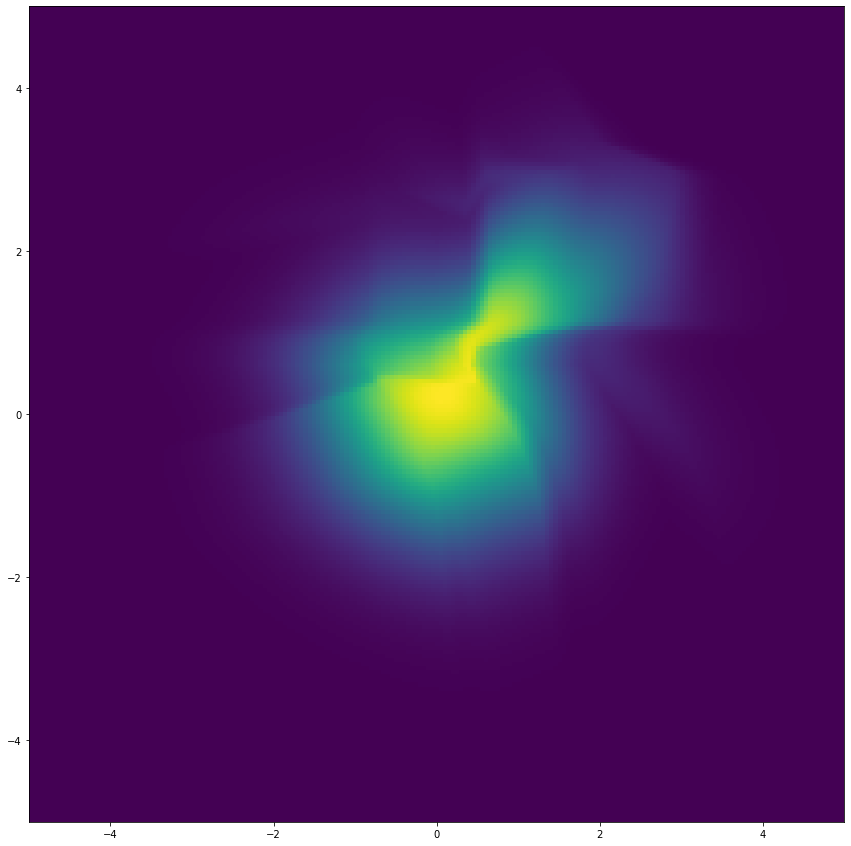

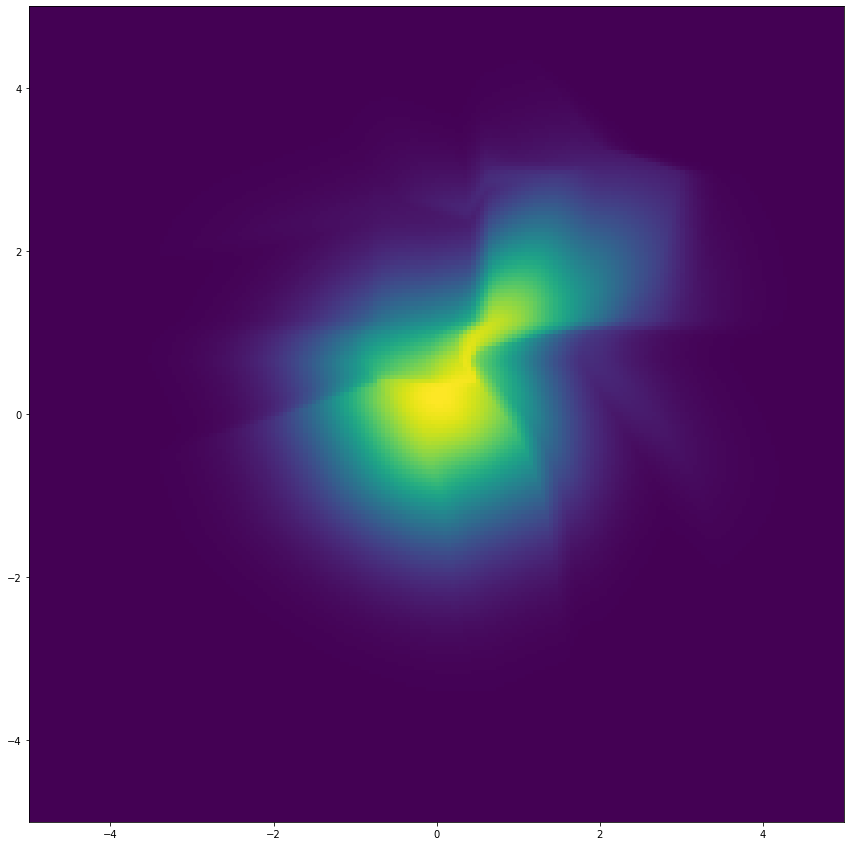

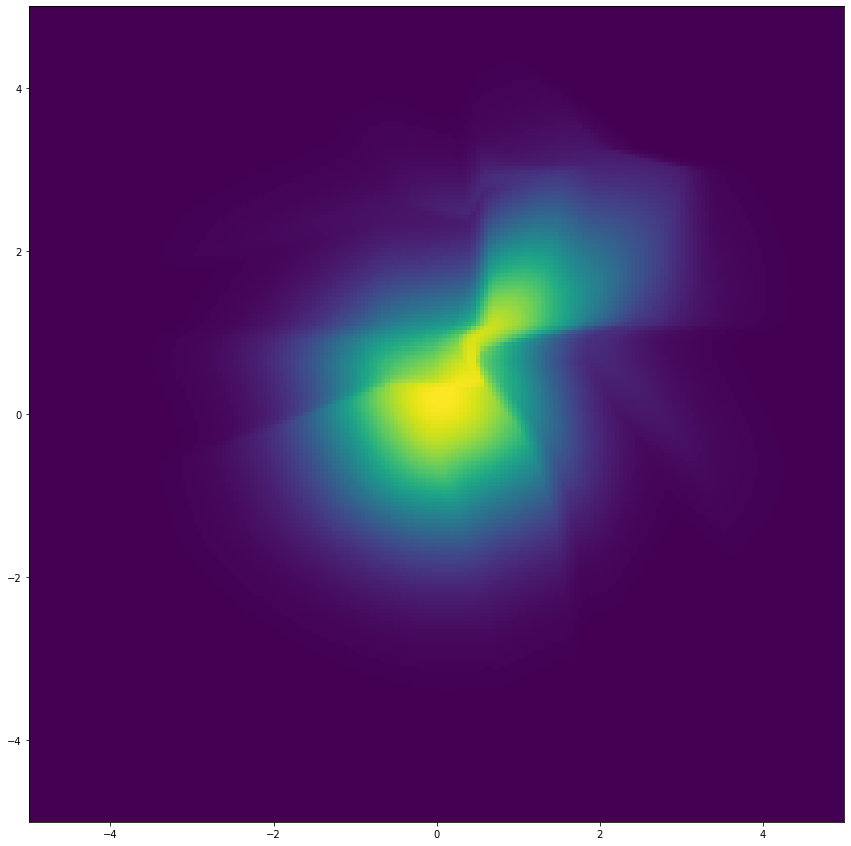

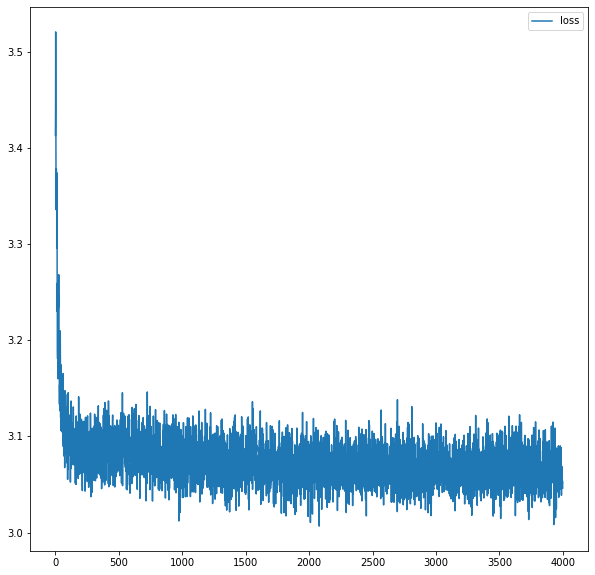

{'max_iter': 4000, 'num_samples': 2048, 'num_segments': 4, 'pow_of_two': 1, 'prob_delta': 0.8, 'dims_dense': [1, 16, 32, 16, 1]} {'loss': 3.0462656021118164, 'Bias_prob_hyp': 0.007181286811828613, 'SqErr_prob_hyp': 5.157088027374357e-05}
4 1 4000 2048 [ 1  4 32  4  1]


 12%|█▏        | 498/4000 [00:15<01:56, 30.07it/s]<ipython-input-19-1b55656c51ce>:89: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, prob.data.numpy())
100%|██████████| 4000/4000 [02:08<00:00, 31.04it/s]


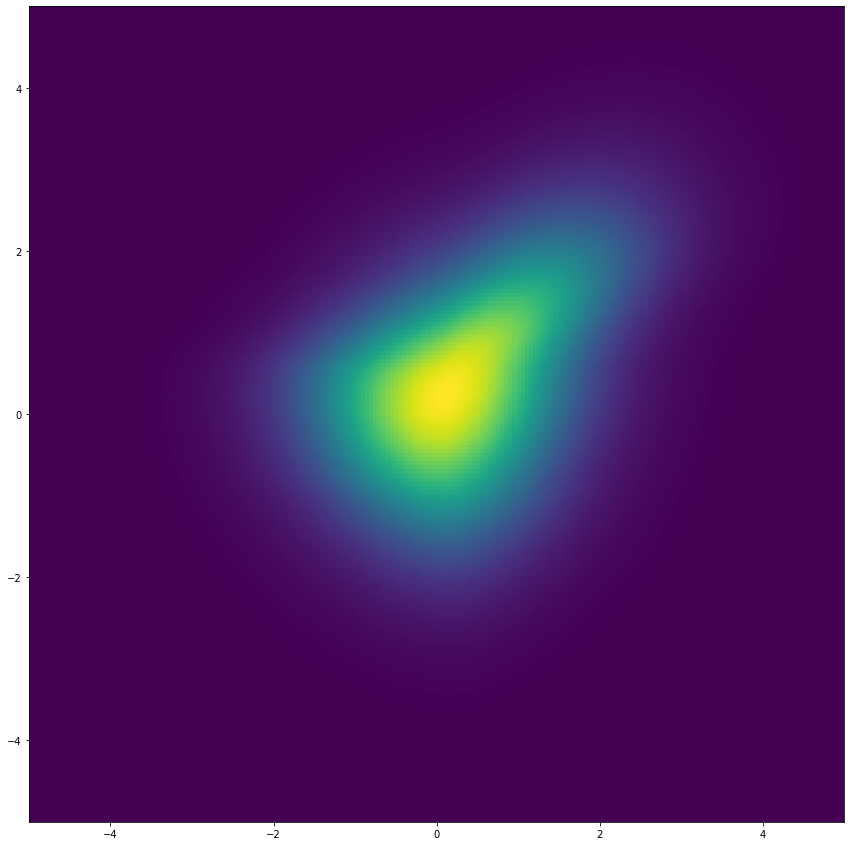

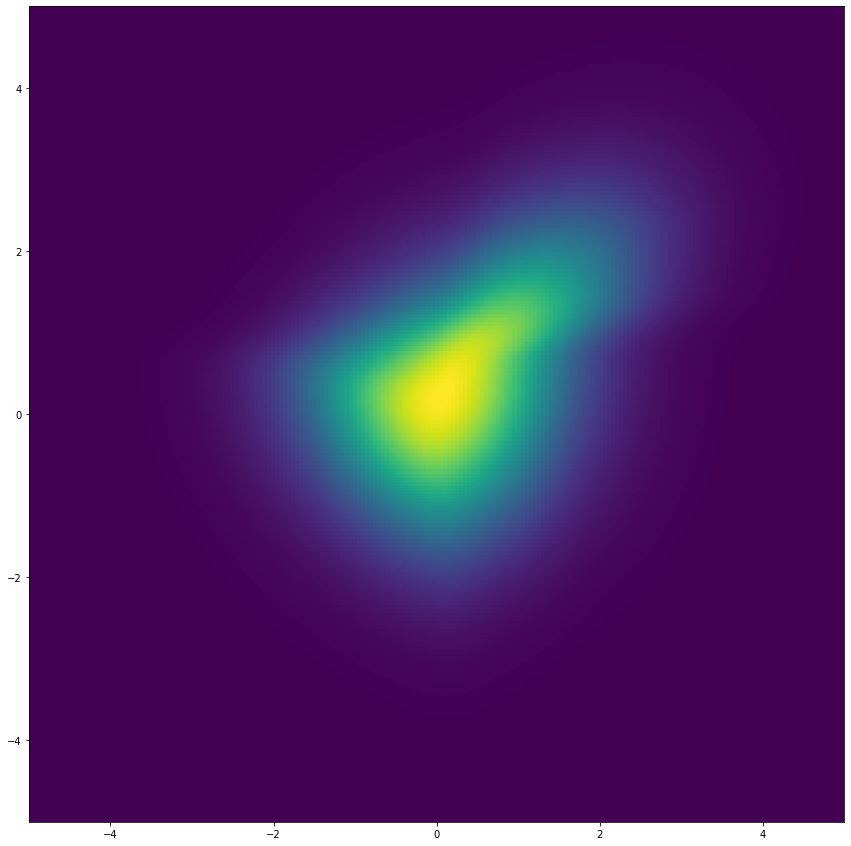

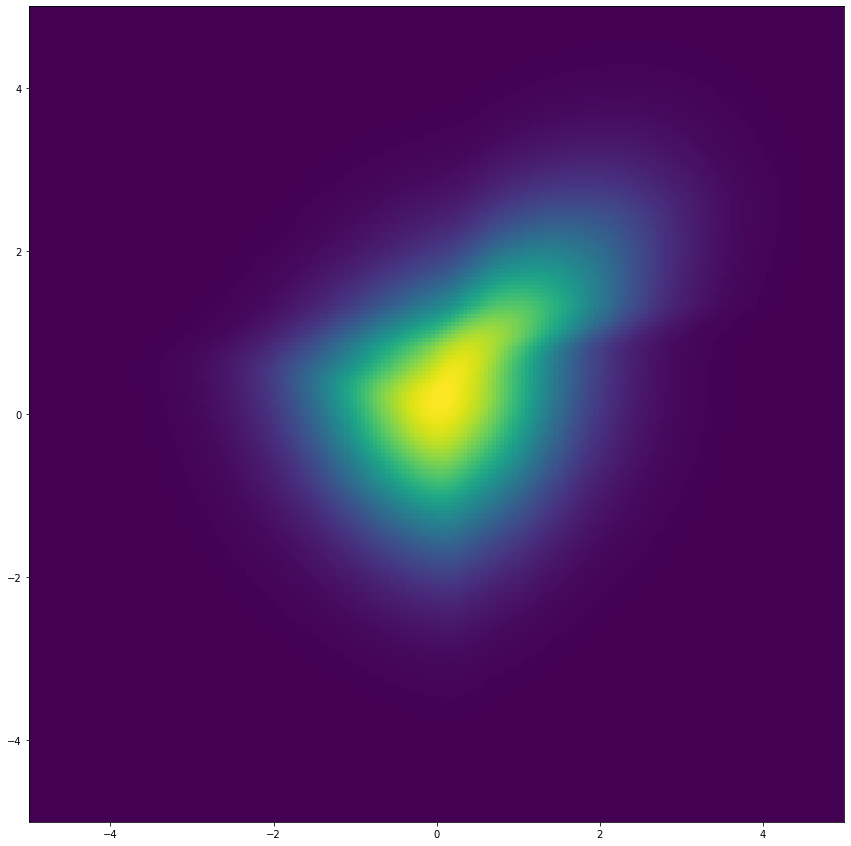

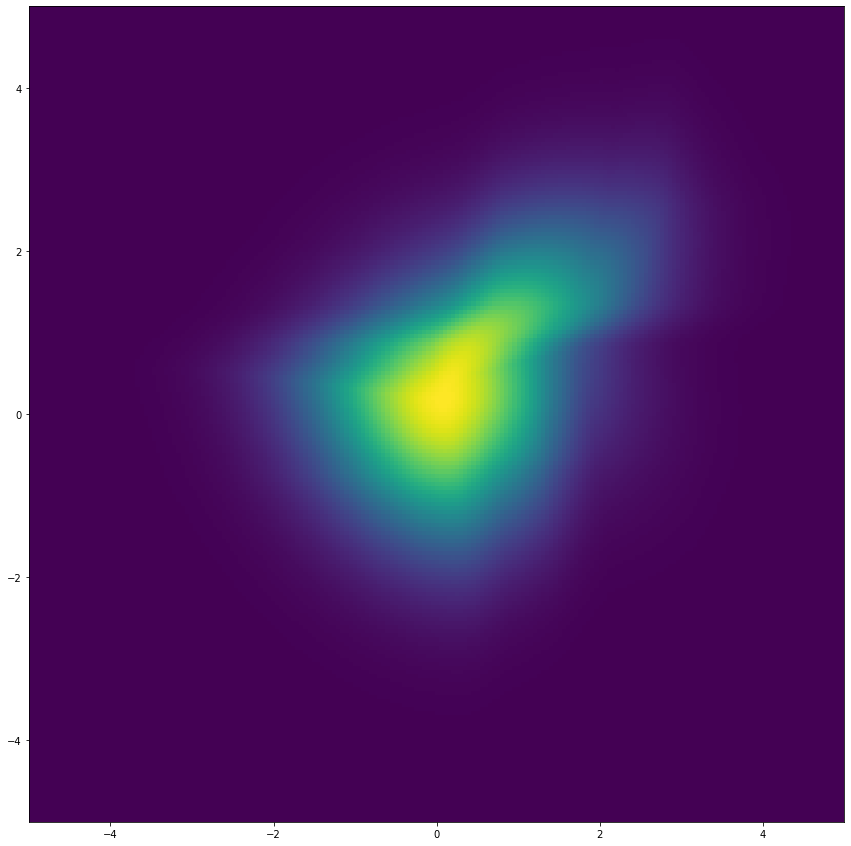

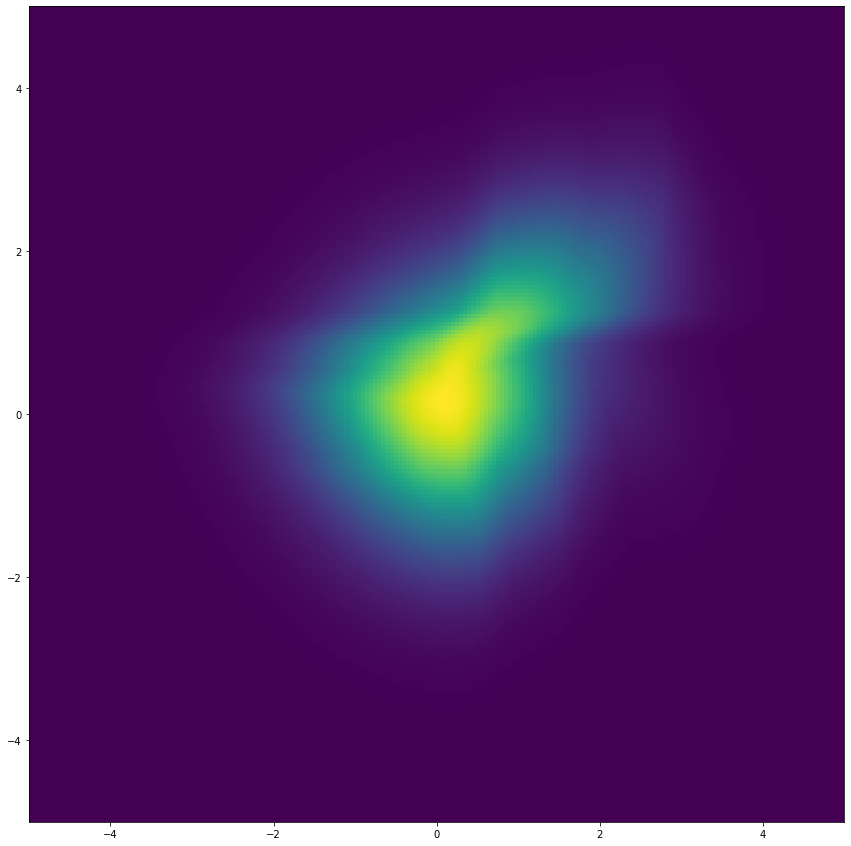

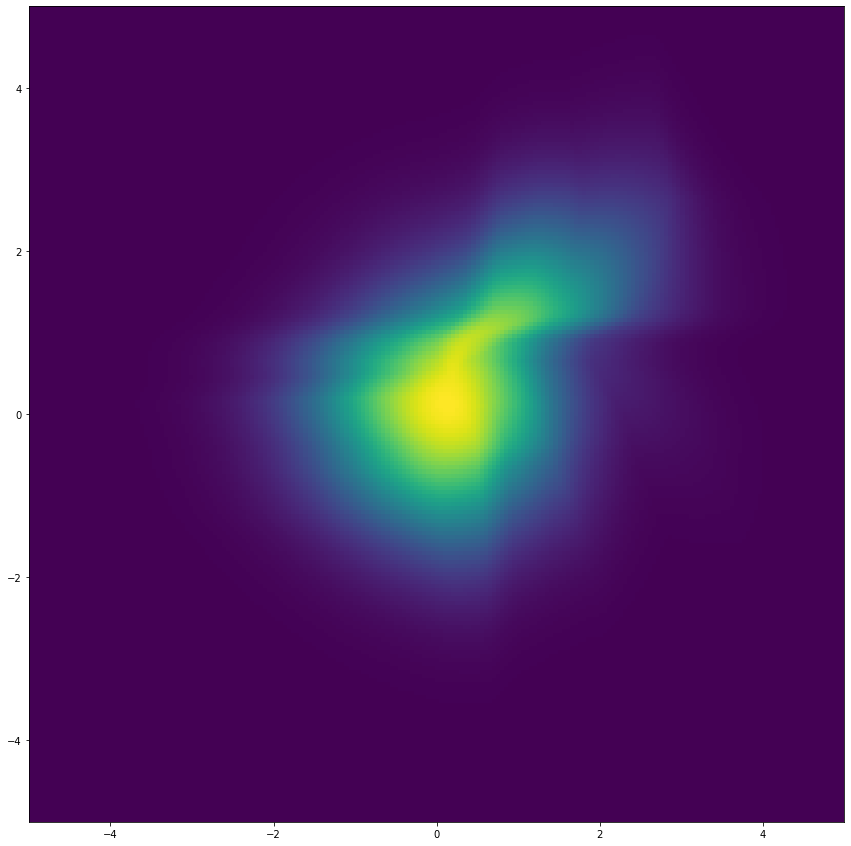

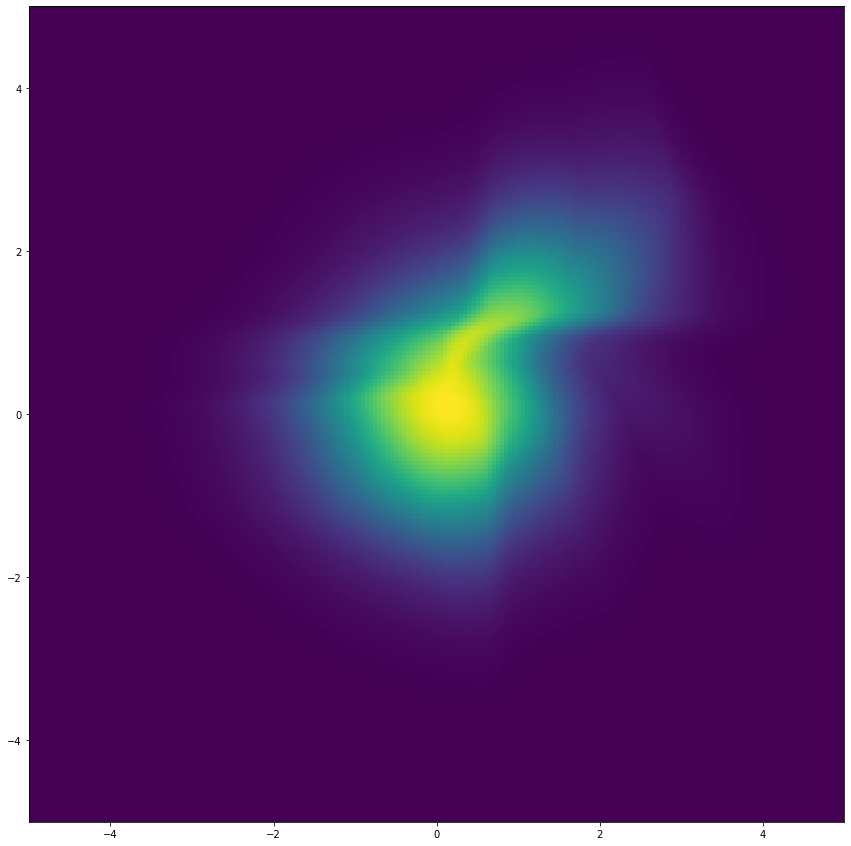

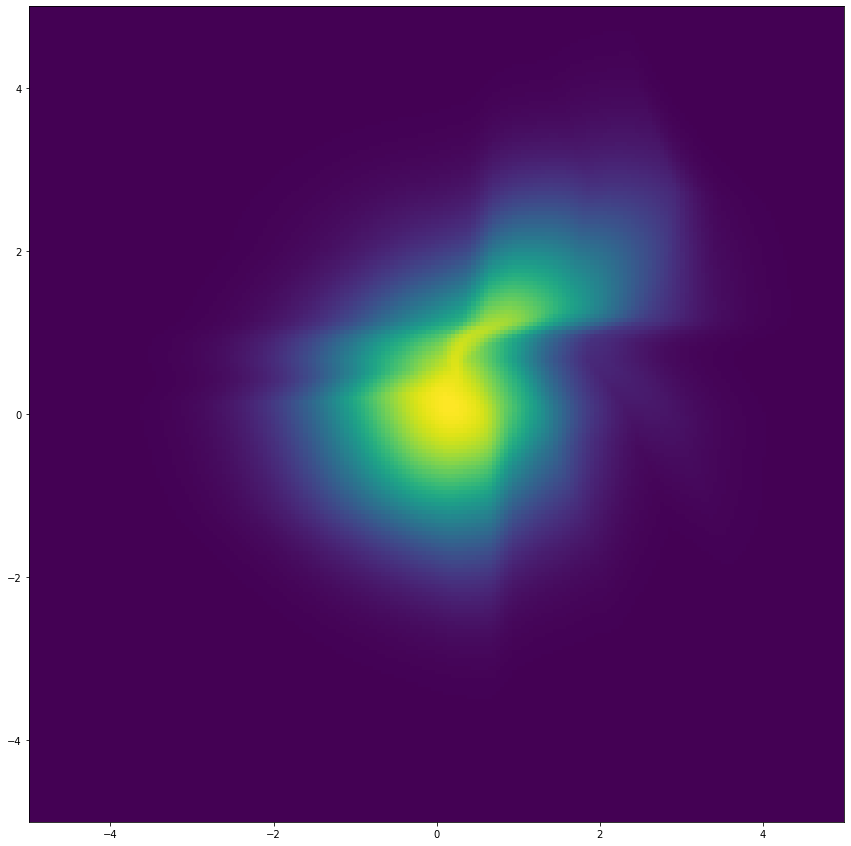

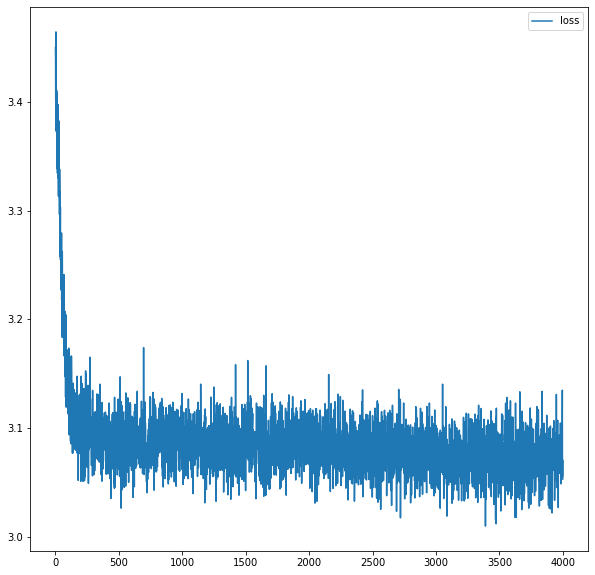

{'max_iter': 4000, 'num_samples': 2048, 'num_segments': 4, 'pow_of_two': 1, 'prob_delta': 0.8, 'dims_dense': [1, 4, 32, 4, 1]} {'loss': 3.0530025959014893, 'Bias_prob_hyp': 0.018411755561828613, 'SqErr_prob_hyp': 0.0003389927428685269}
4 1 4000 5000 [ 1 16 64 16  1]


 12%|█▏        | 498/4000 [00:34<03:36, 16.14it/s]<ipython-input-19-1b55656c51ce>:89: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, prob.data.numpy())
100%|██████████| 4000/4000 [04:43<00:00, 14.10it/s]


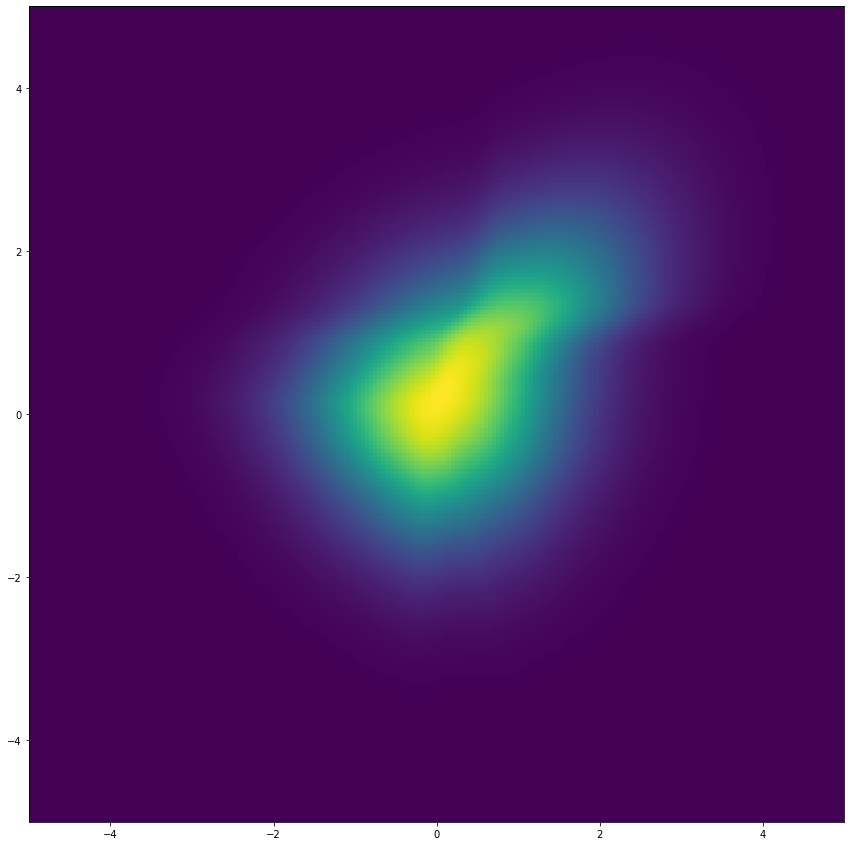

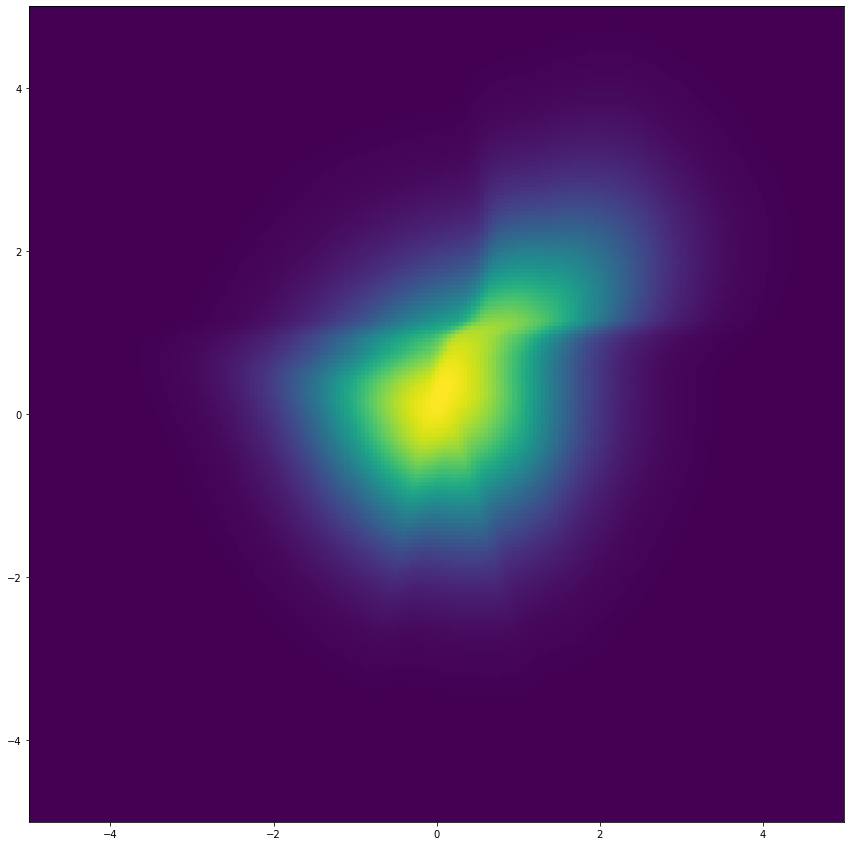

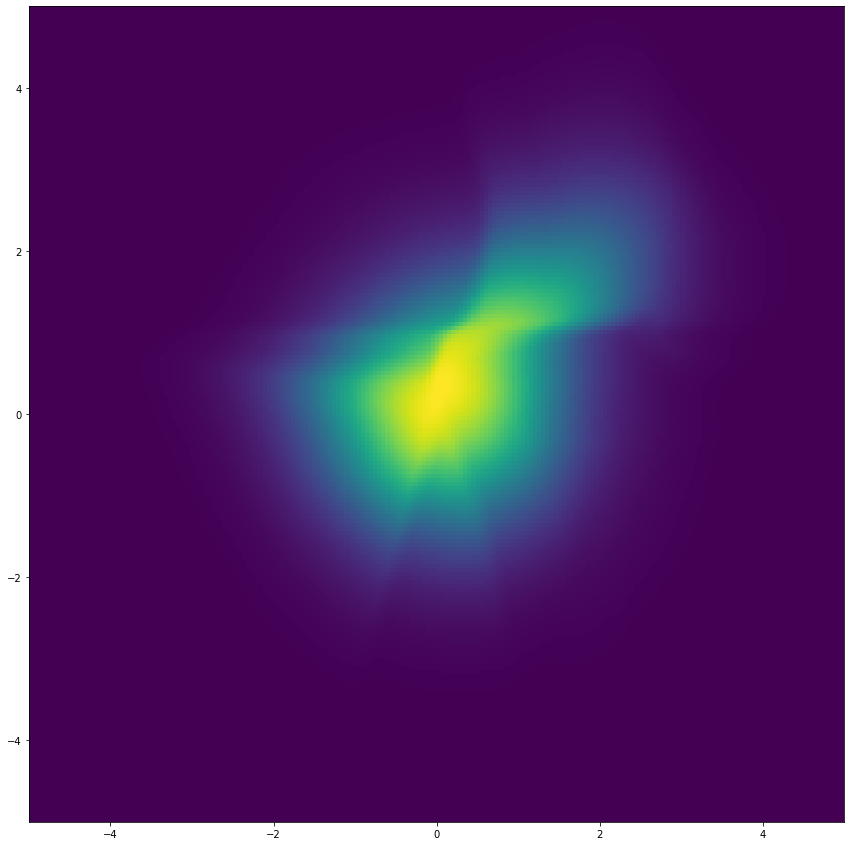

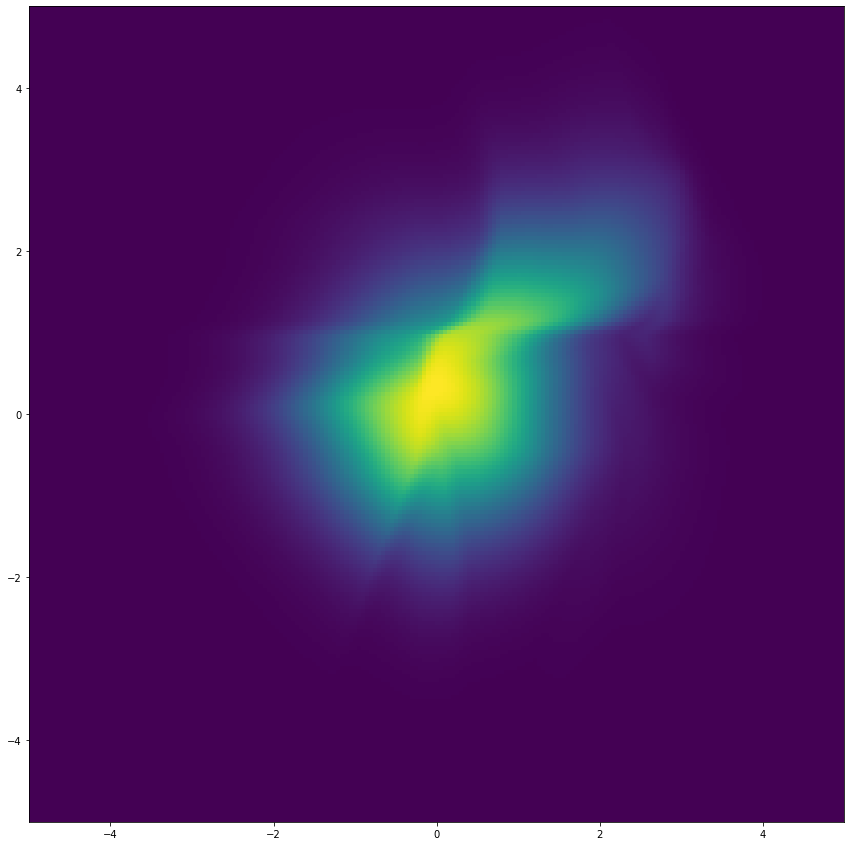

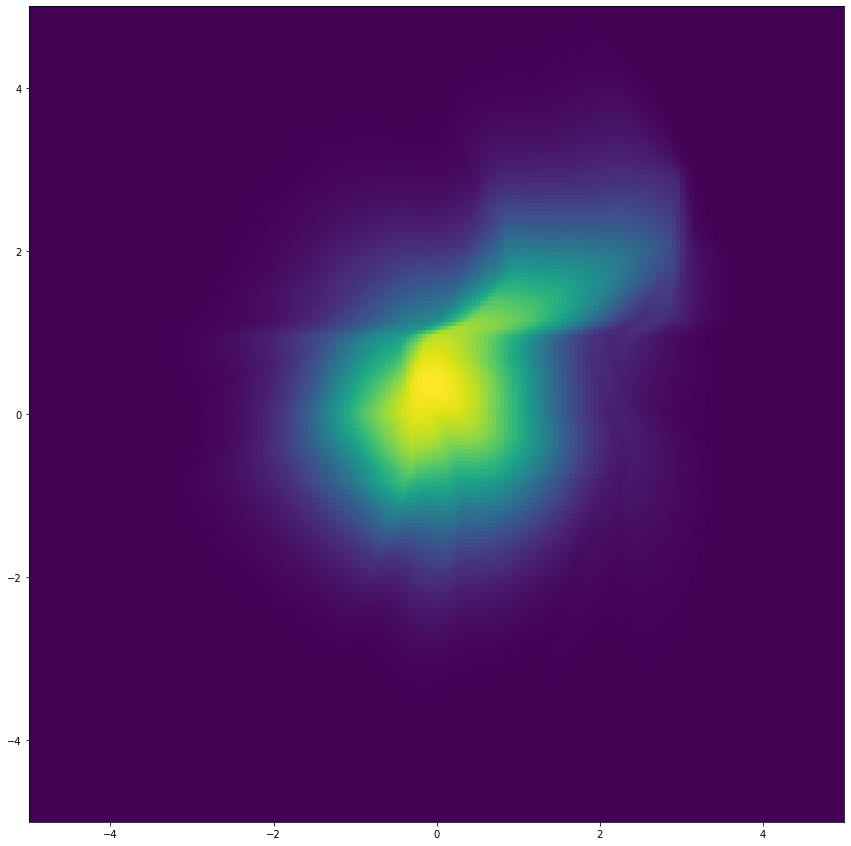

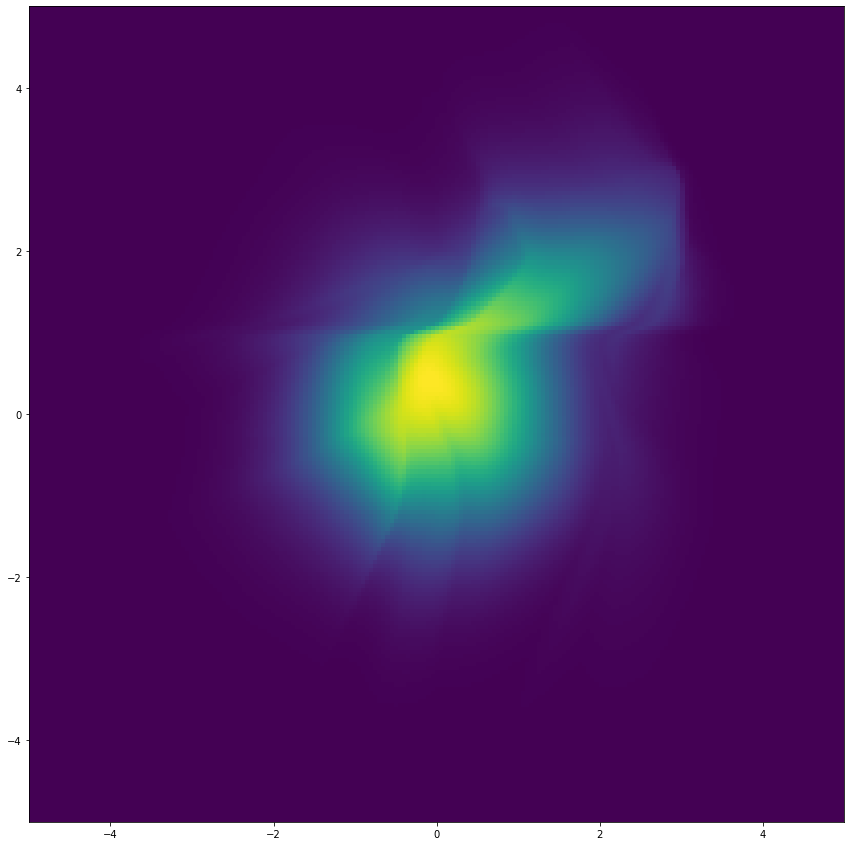

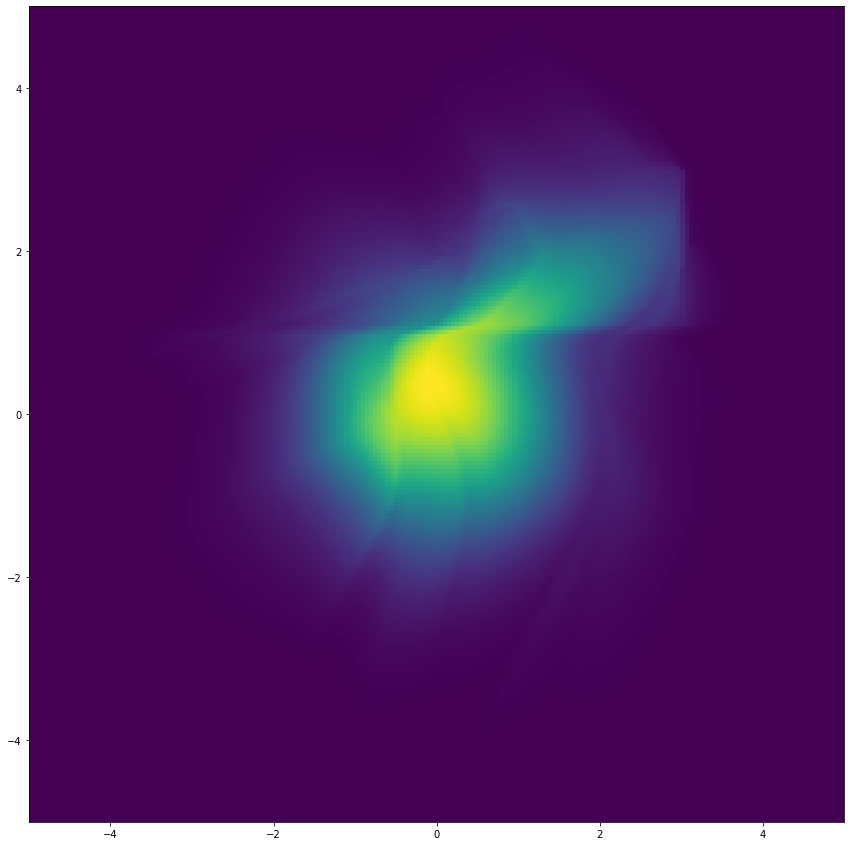

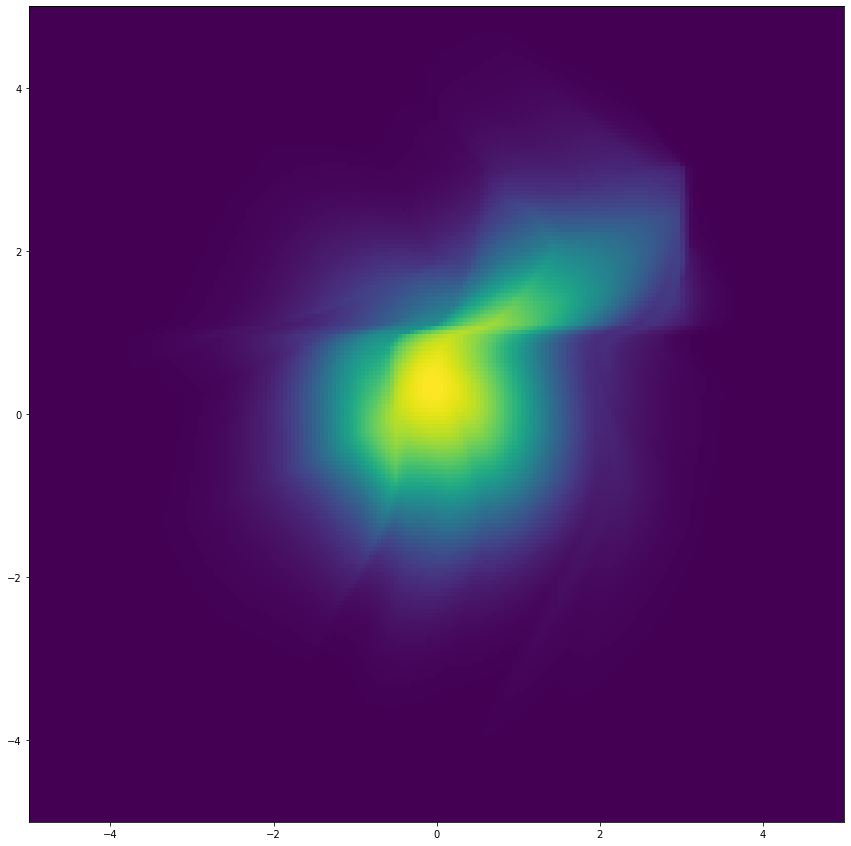

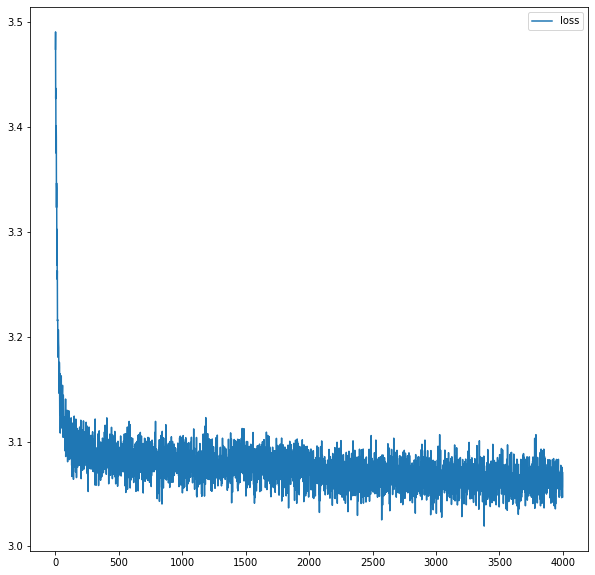

{'max_iter': 4000, 'num_samples': 5000, 'num_segments': 4, 'pow_of_two': 1, 'prob_delta': 0.8, 'dims_dense': [1, 16, 64, 16, 1]} {'loss': 3.0473239421844482, 'Bias_prob_hyp': -0.0019933225631713625, 'SqErr_prob_hyp': 3.97333484084805e-06}
4 1 4000 5000 [ 1 16 32 16  1]


 12%|█▏        | 498/4000 [00:26<02:58, 19.63it/s]<ipython-input-19-1b55656c51ce>:89: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, prob.data.numpy())
100%|██████████| 4000/4000 [03:36<00:00, 18.51it/s]


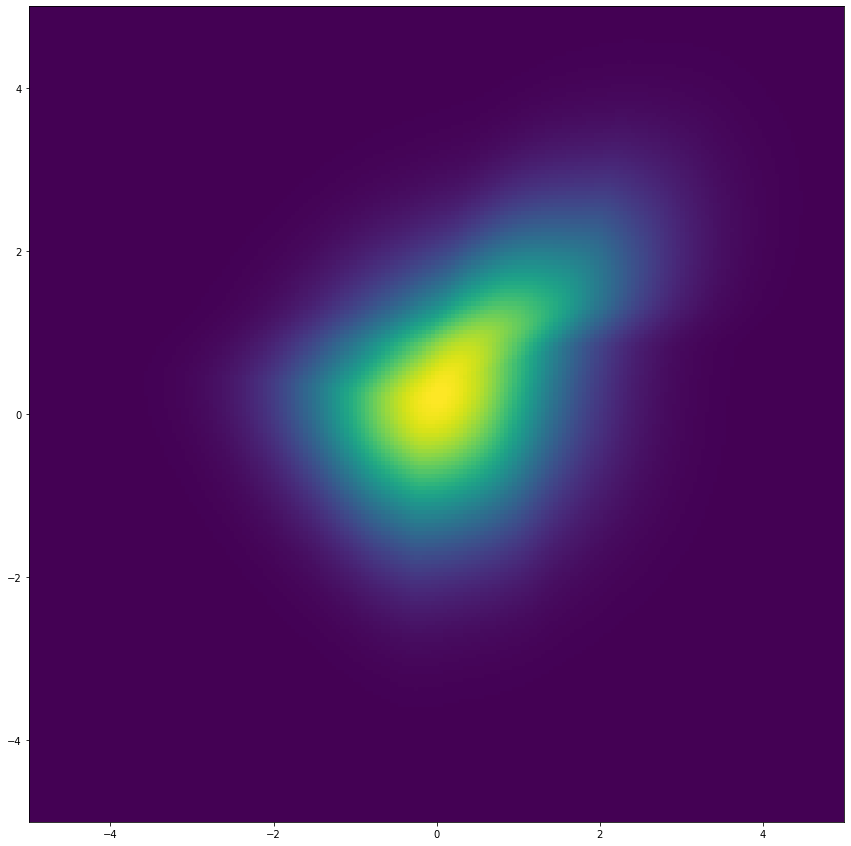

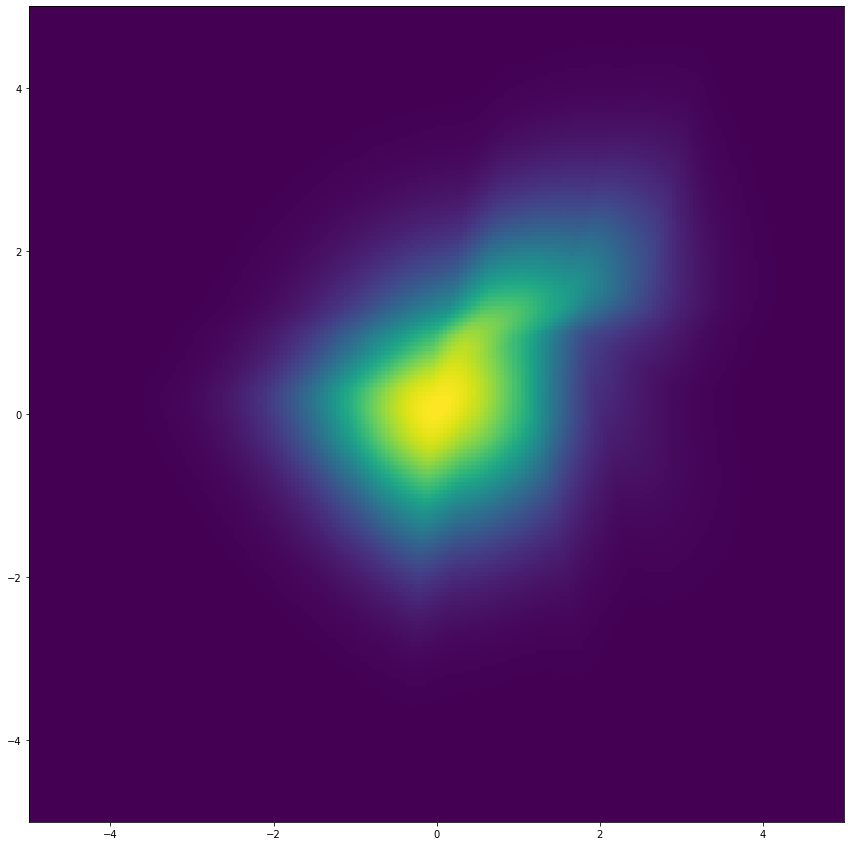

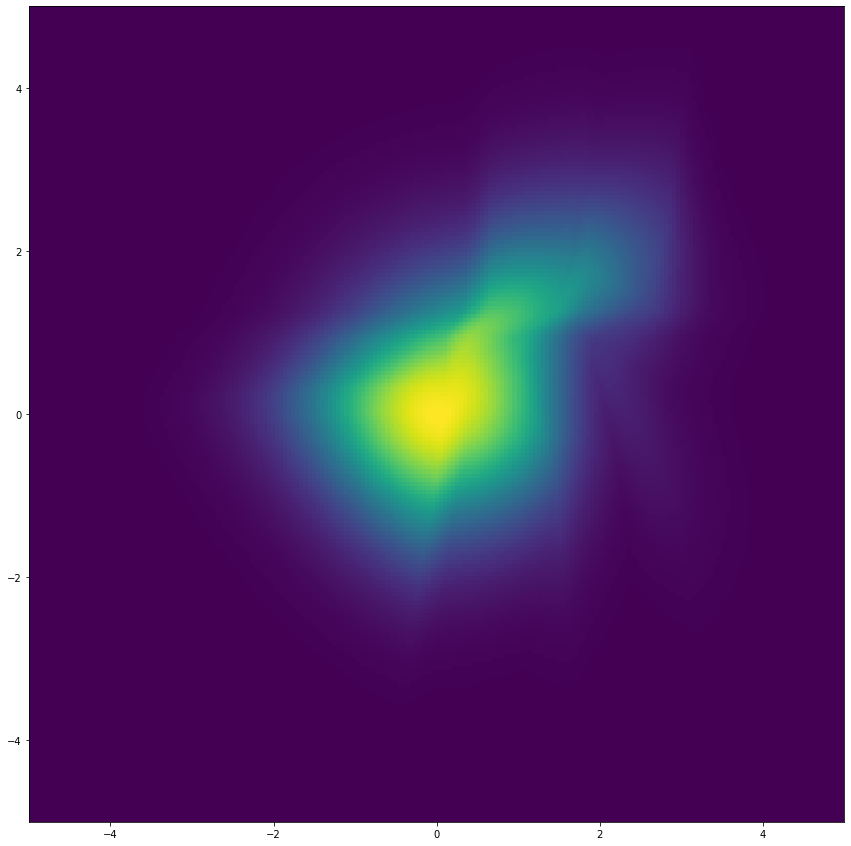

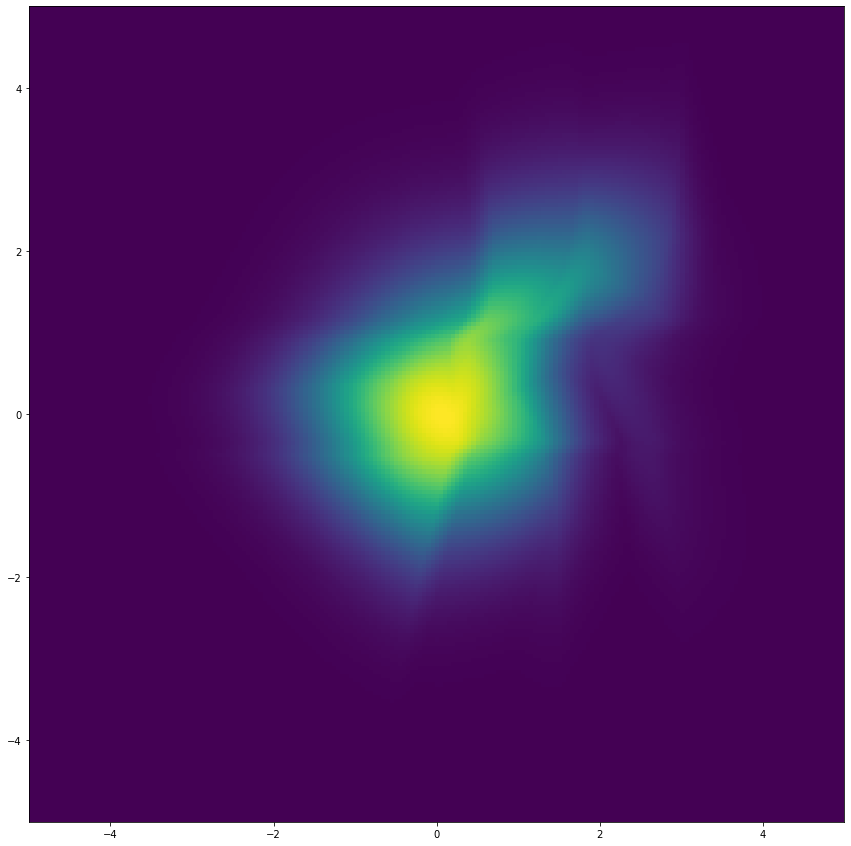

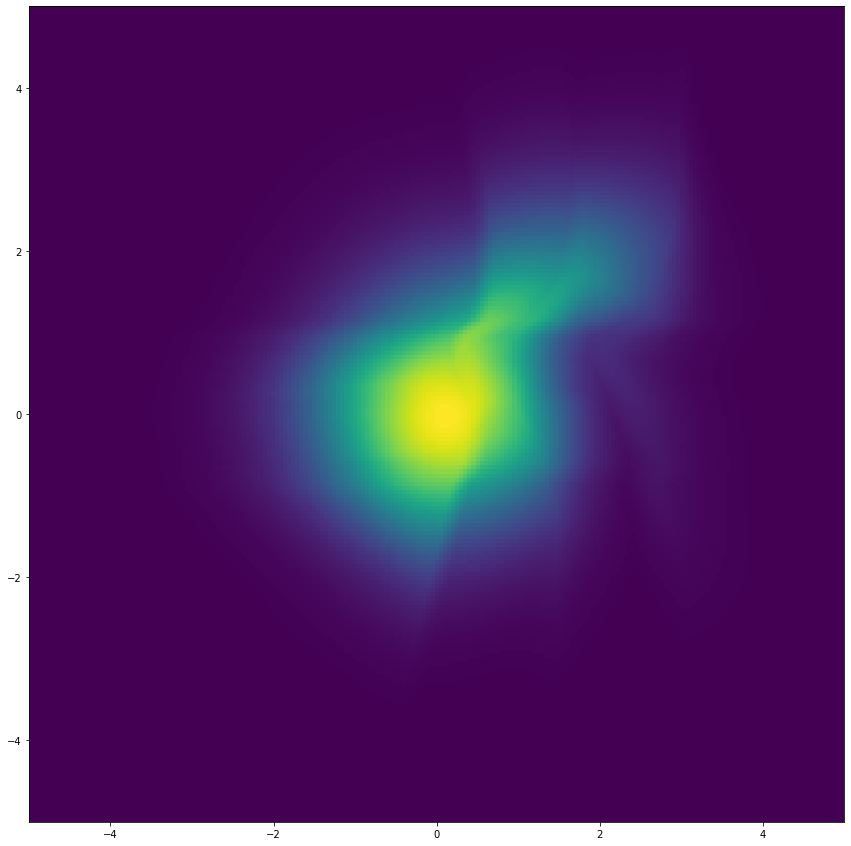

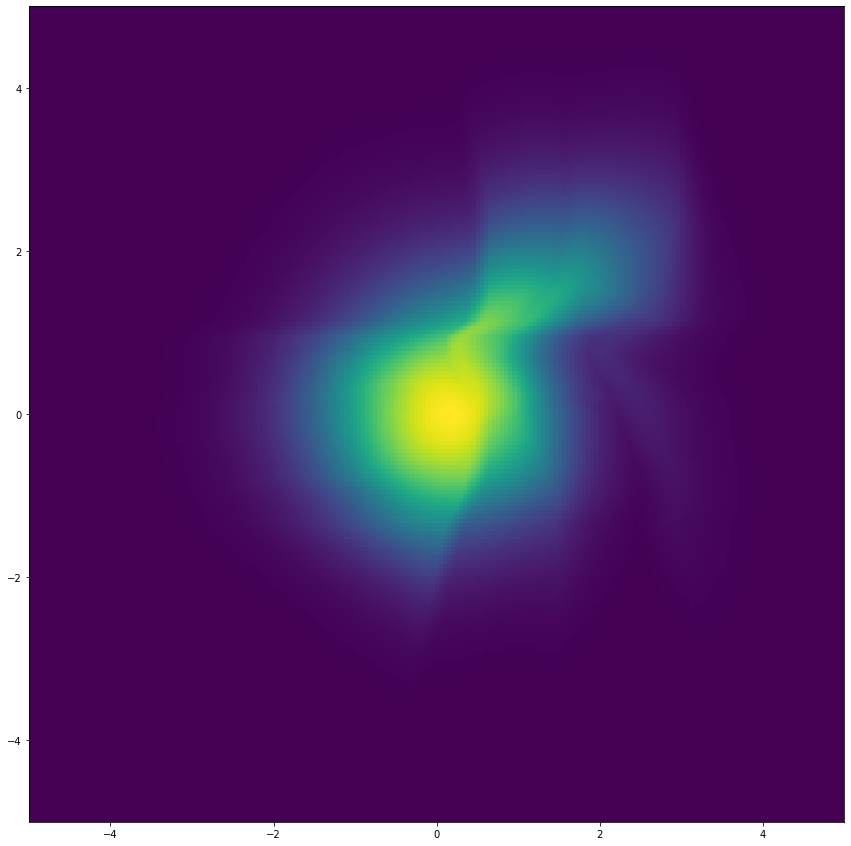

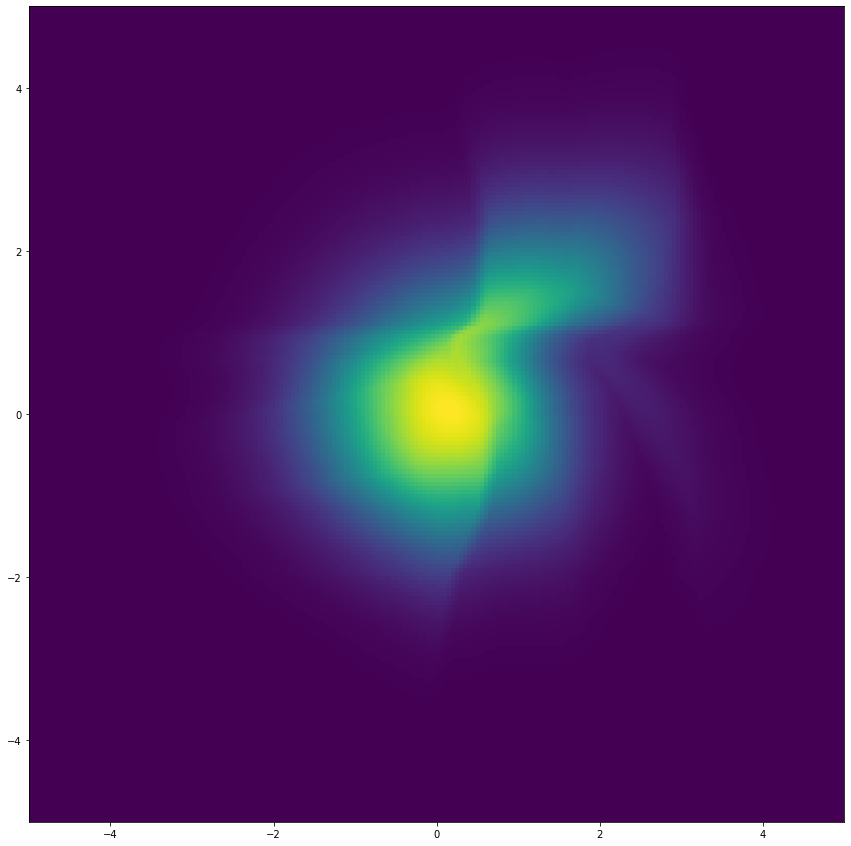

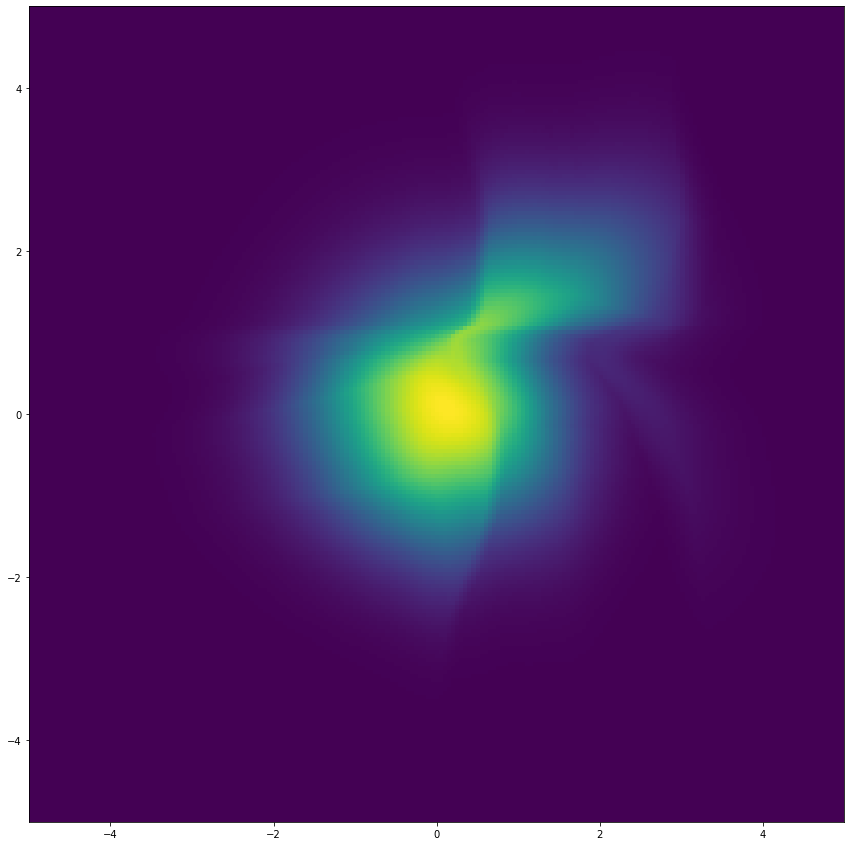

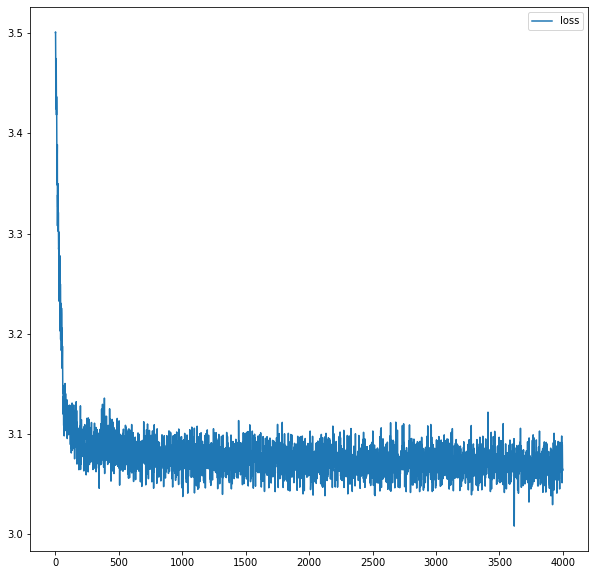

{'max_iter': 4000, 'num_samples': 5000, 'num_segments': 4, 'pow_of_two': 1, 'prob_delta': 0.8, 'dims_dense': [1, 16, 32, 16, 1]} {'loss': 3.0647475719451904, 'Bias_prob_hyp': -0.013693322563171406, 'SqErr_prob_hyp': 0.00018750708281905913}
4 1 4000 5000 [ 1  4 32  4  1]


 12%|█▏        | 498/4000 [00:24<02:56, 19.83it/s]<ipython-input-19-1b55656c51ce>:89: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, prob.data.numpy())
100%|██████████| 4000/4000 [03:18<00:00, 20.16it/s]


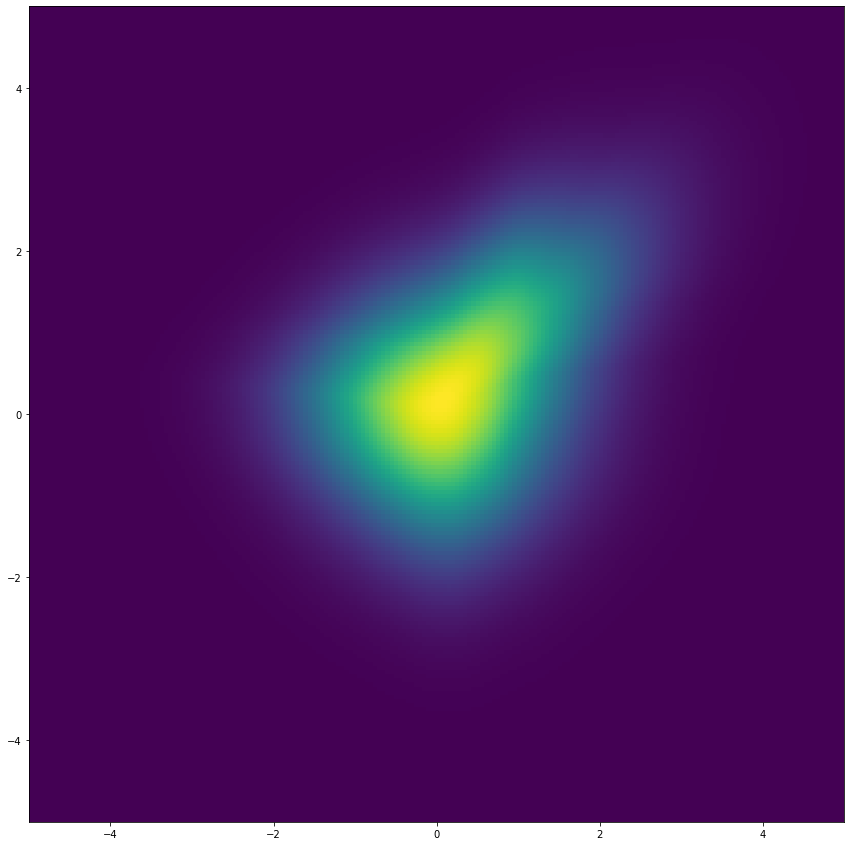

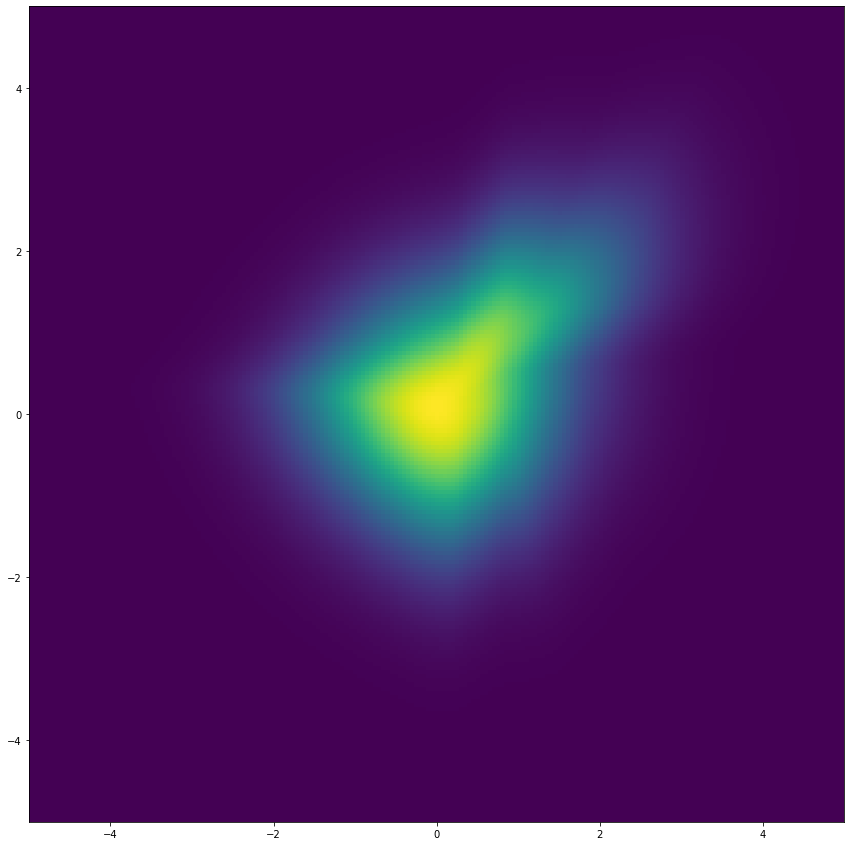

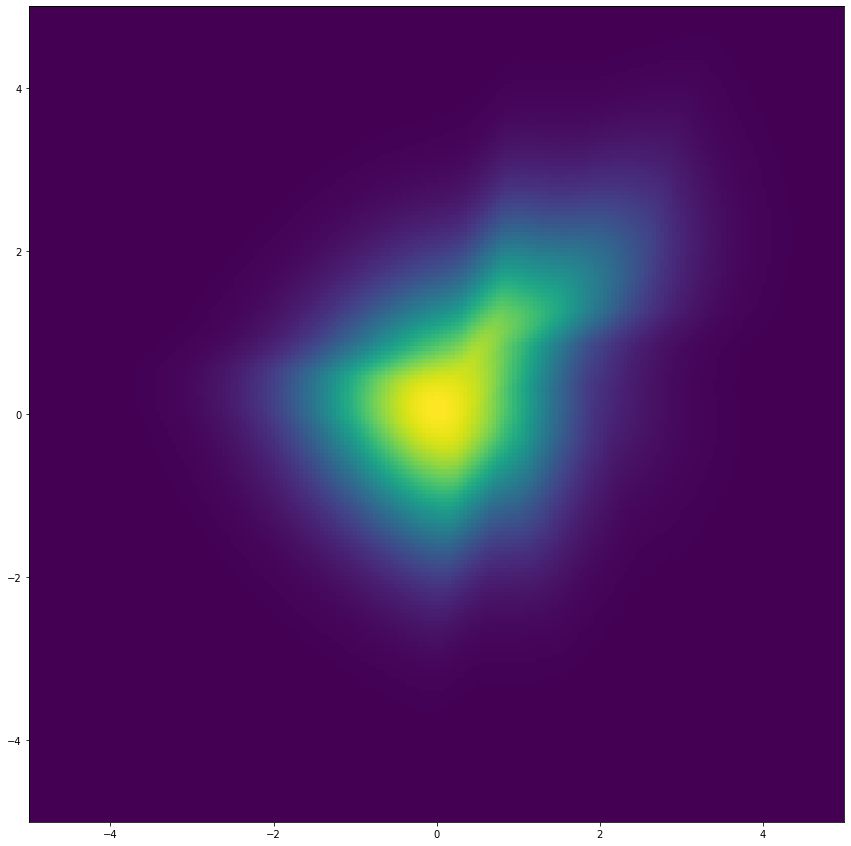

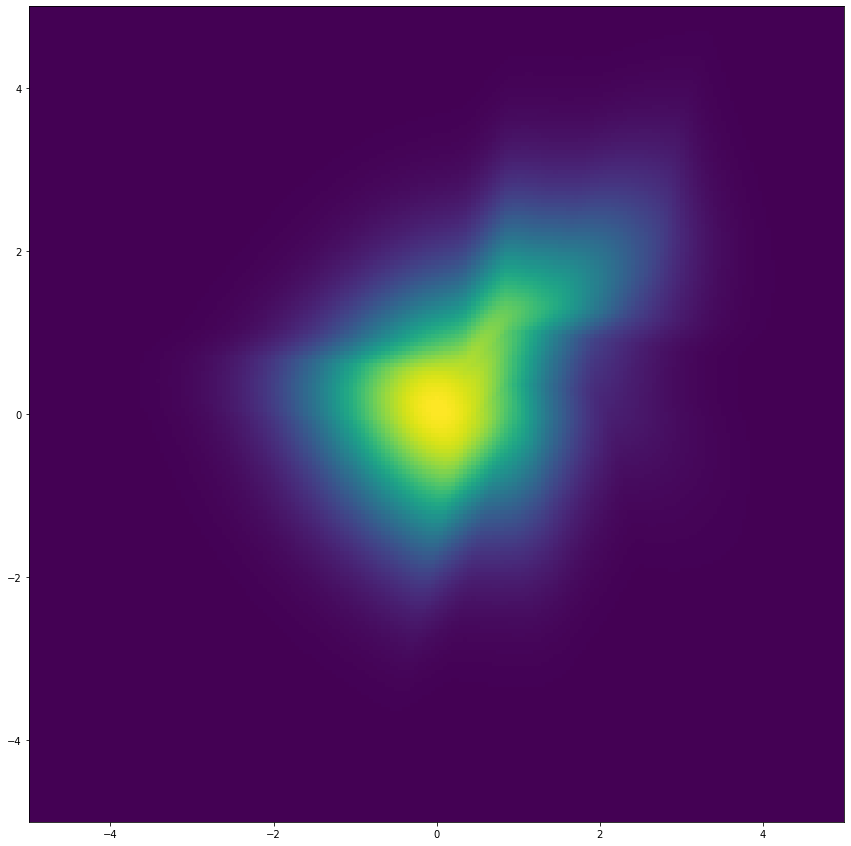

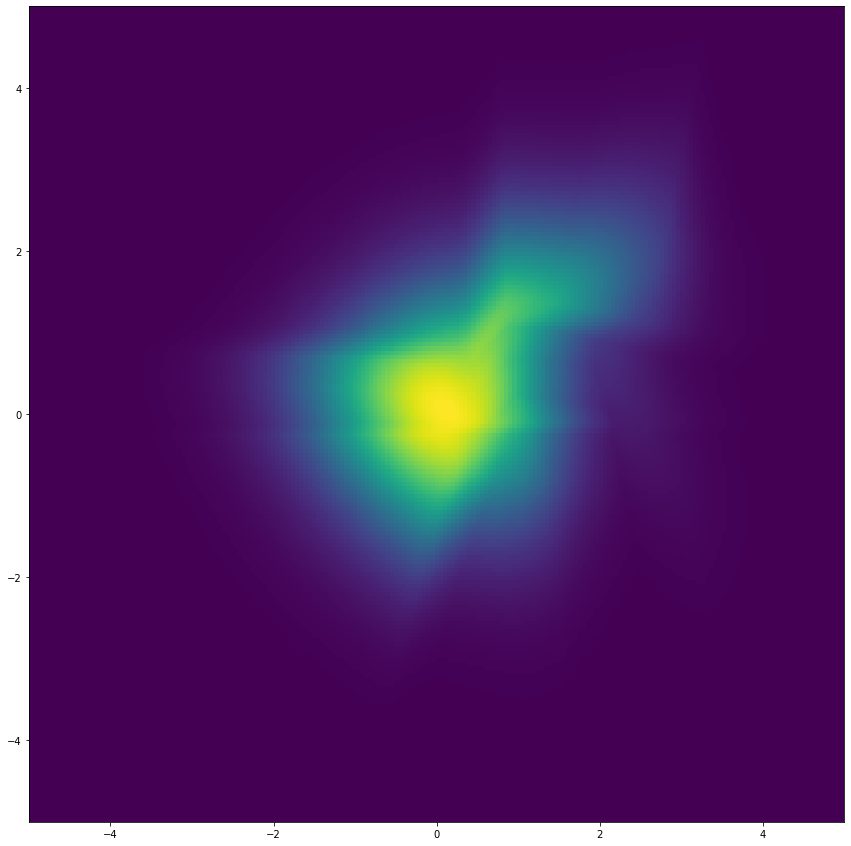

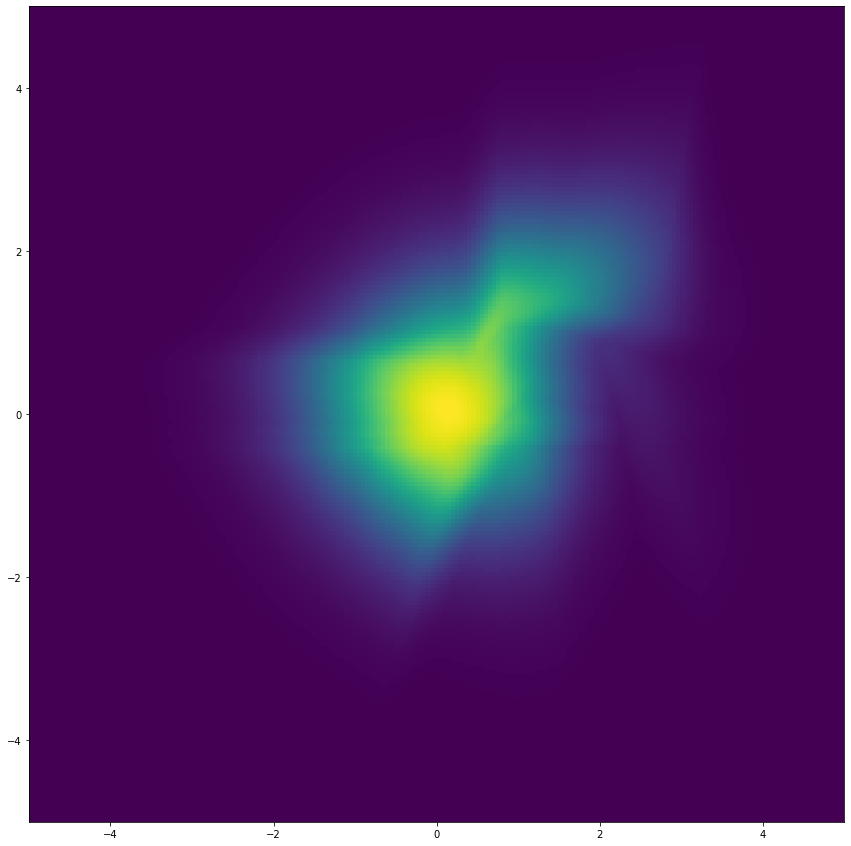

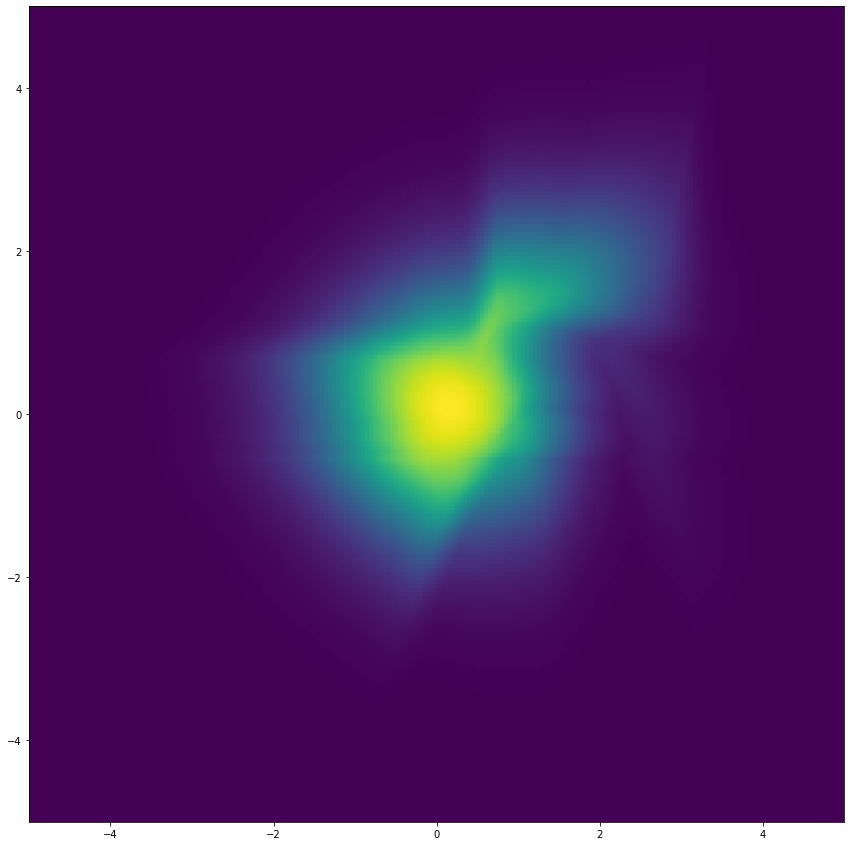

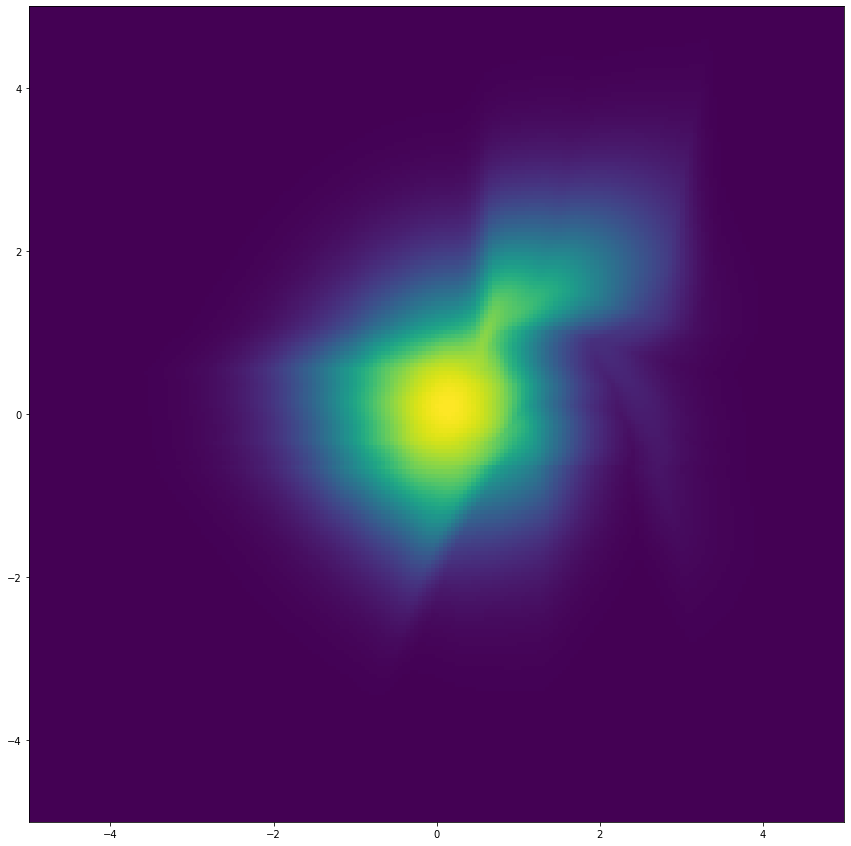

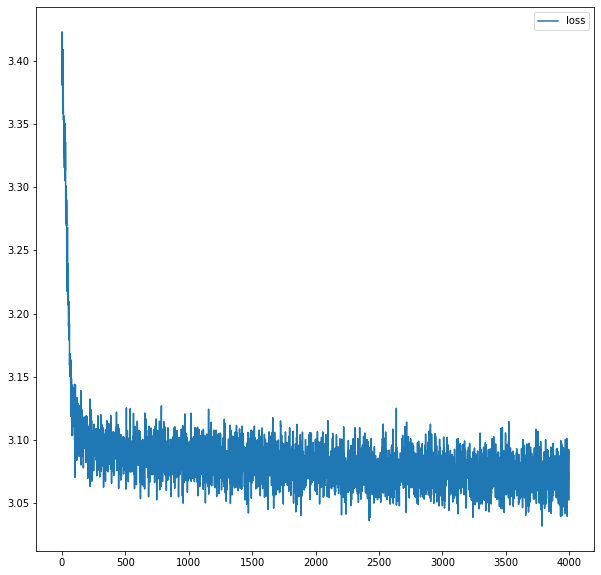

{'max_iter': 4000, 'num_samples': 5000, 'num_segments': 4, 'pow_of_two': 1, 'prob_delta': 0.8, 'dims_dense': [1, 4, 32, 4, 1]} {'loss': 3.052476644515991, 'Bias_prob_hyp': 0.006106677436828634, 'SqErr_prob_hyp': 3.729150931747193e-05}
4 1 4000 10000 [ 1 16 64 16  1]


 12%|█▏        | 499/4000 [00:59<08:34,  6.80it/s]<ipython-input-19-1b55656c51ce>:89: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, prob.data.numpy())
100%|██████████| 4000/4000 [4:06:34<00:00,  3.70s/it]      


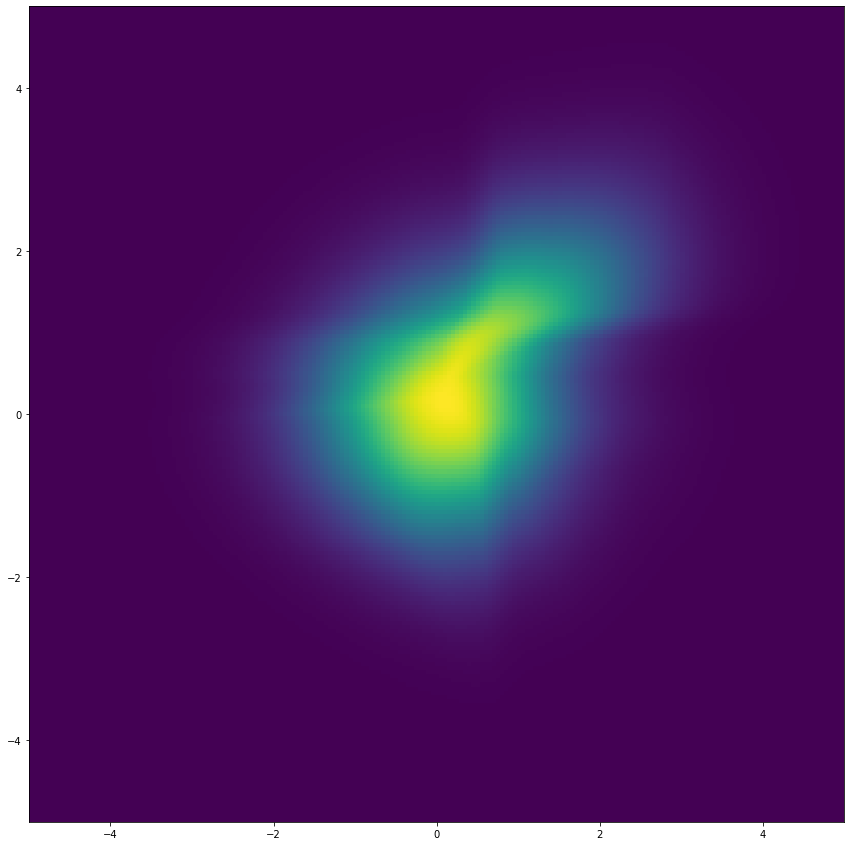

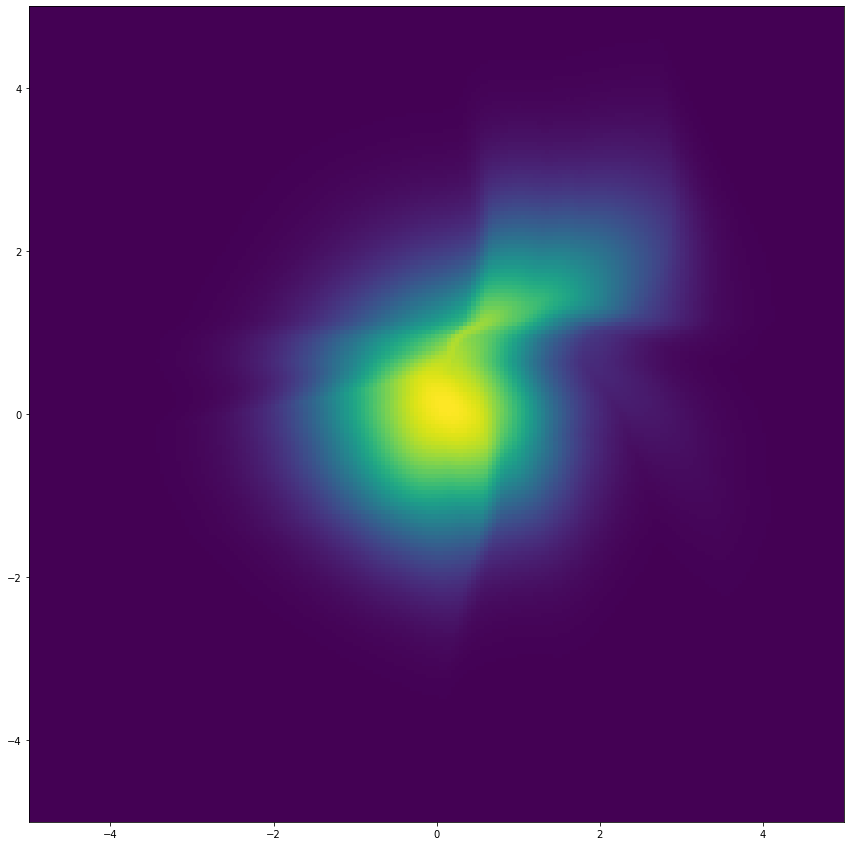

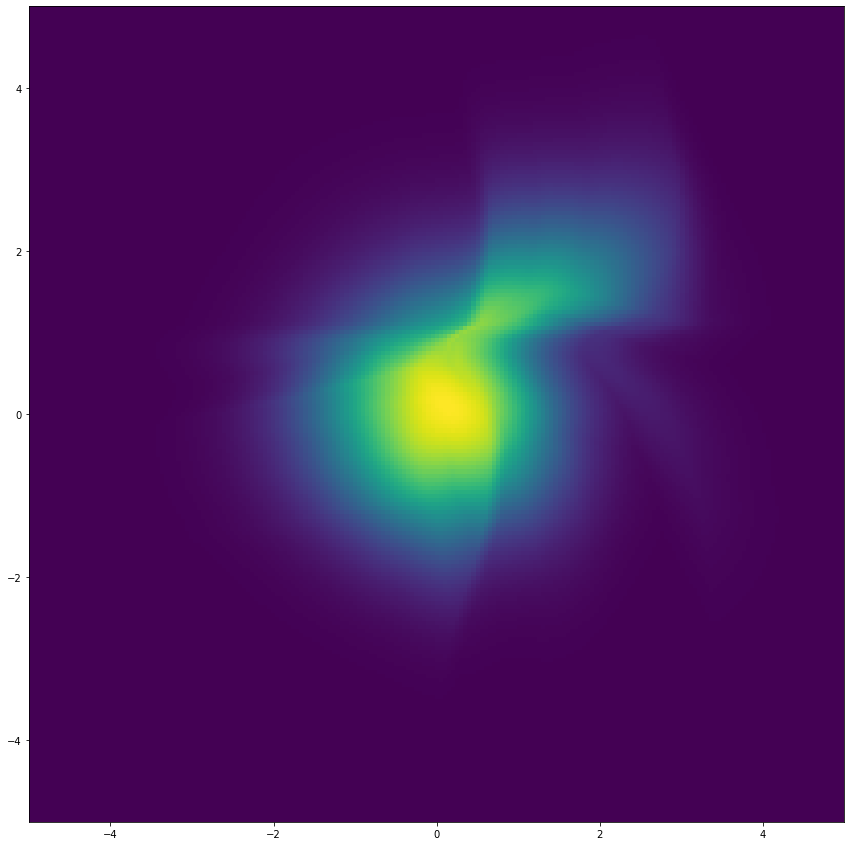

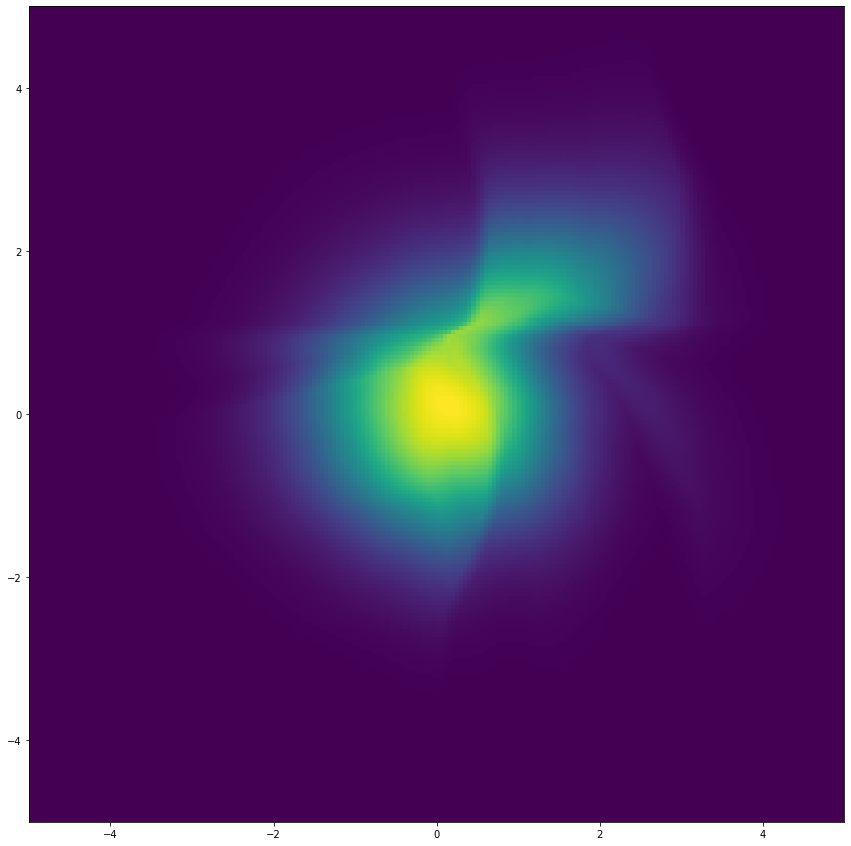

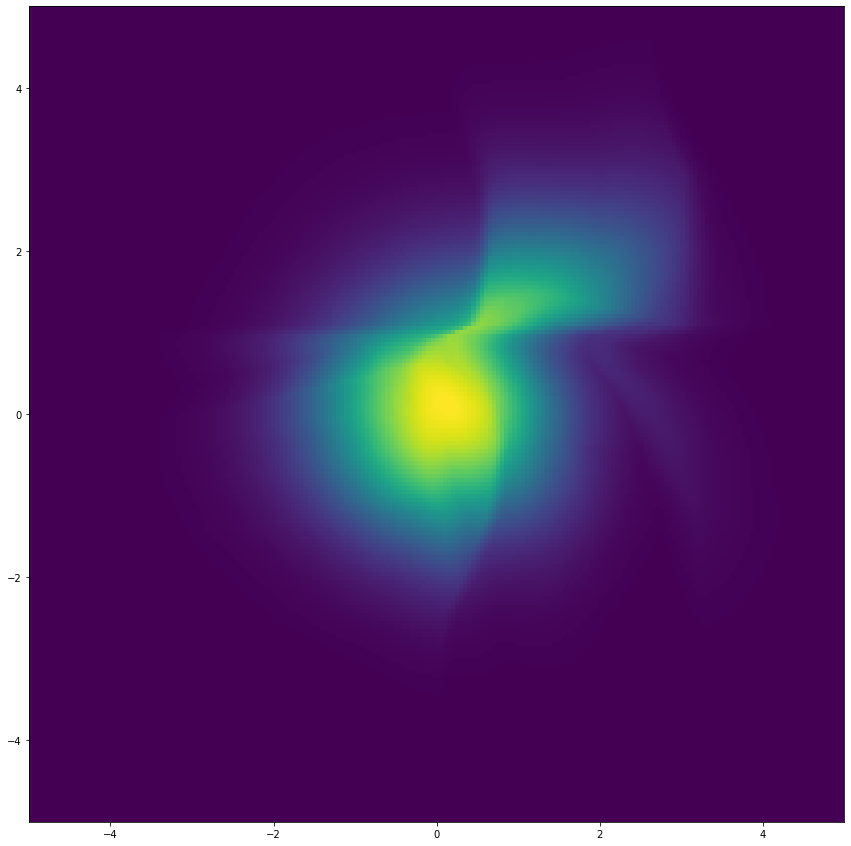

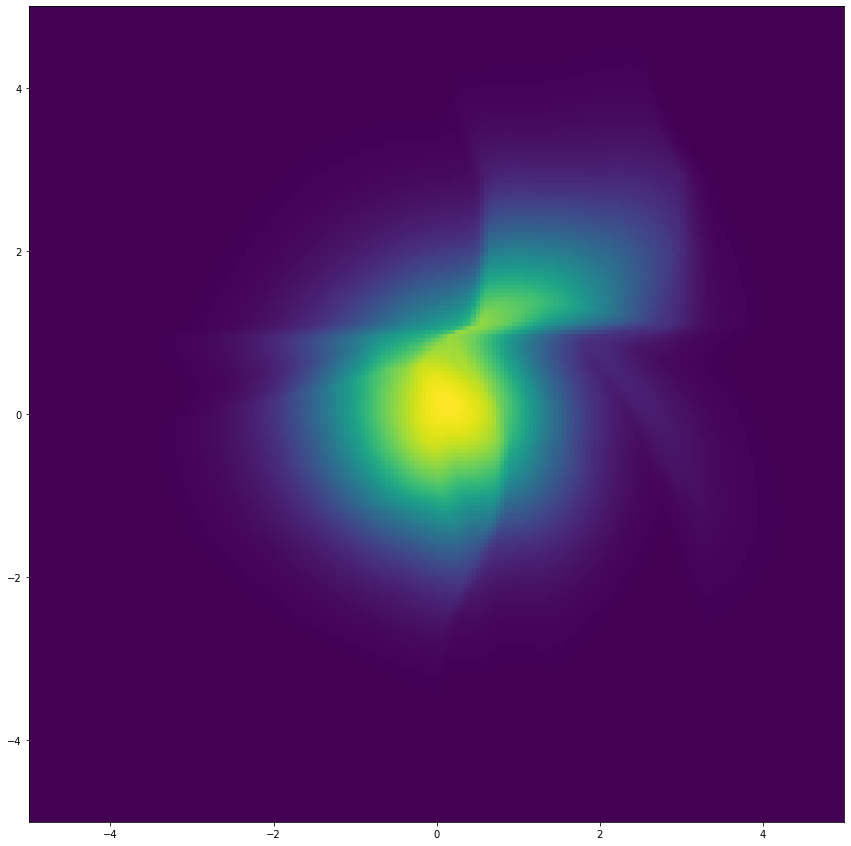

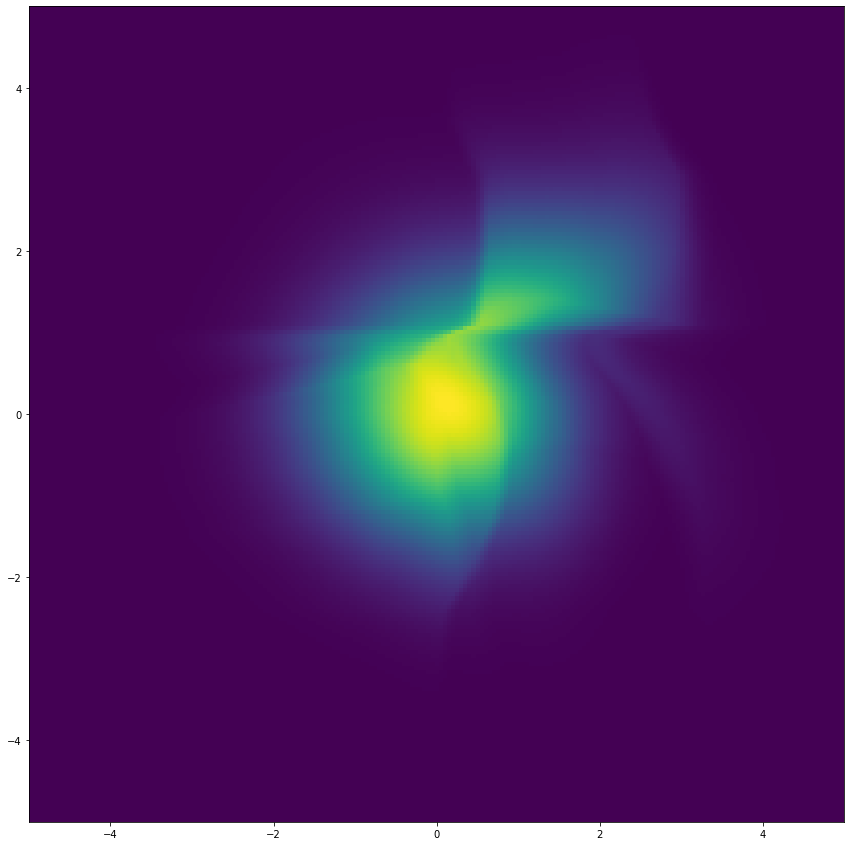

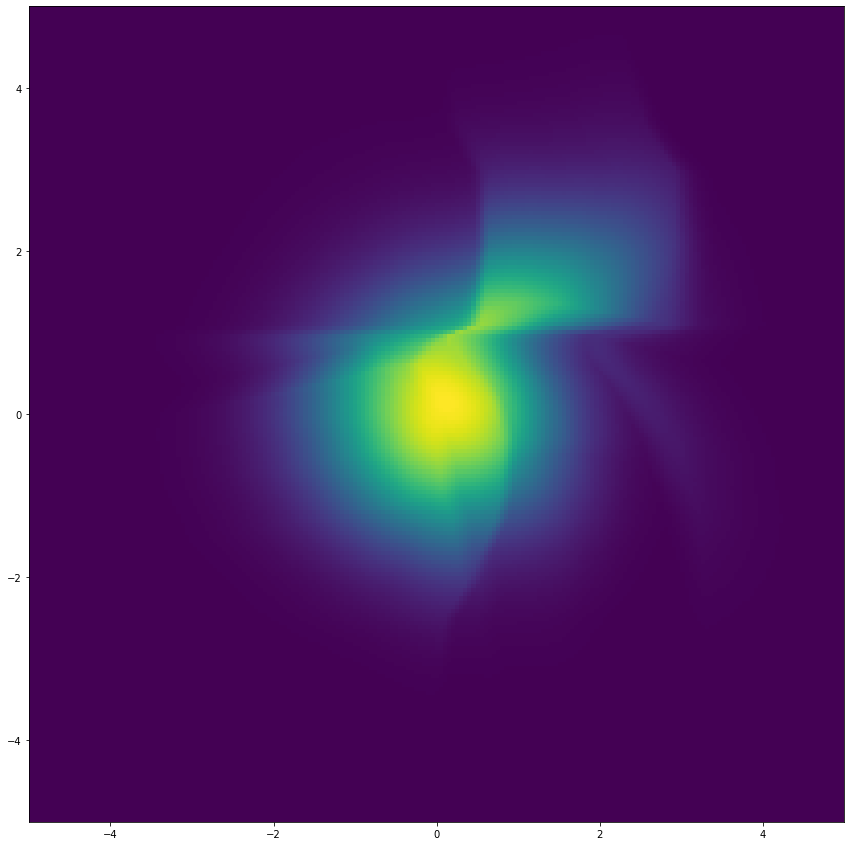

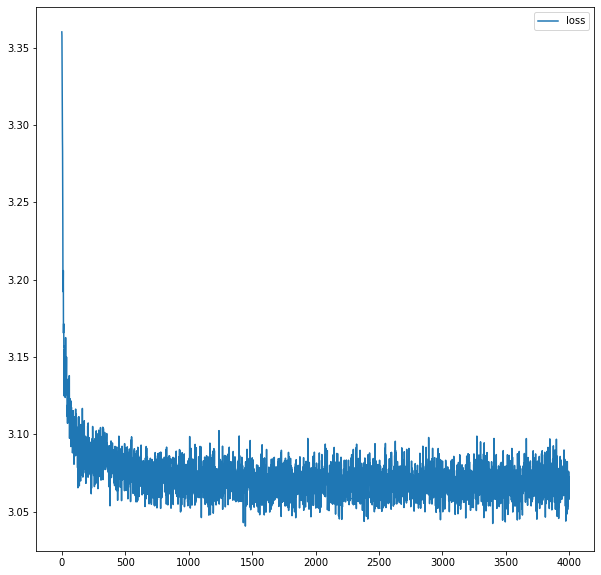

{'max_iter': 4000, 'num_samples': 10000, 'num_segments': 4, 'pow_of_two': 1, 'prob_delta': 0.8, 'dims_dense': [1, 16, 64, 16, 1]} {'loss': 3.0582008361816406, 'Bias_prob_hyp': -0.011843322563171388, 'SqErr_prob_hyp': 0.0001402642893353245}
4 1 4000 10000 [ 1 16 32 16  1]


 12%|█▏        | 498/4000 [00:45<05:24, 10.80it/s]<ipython-input-19-1b55656c51ce>:89: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, prob.data.numpy())
100%|██████████| 4000/4000 [05:59<00:00, 11.11it/s]


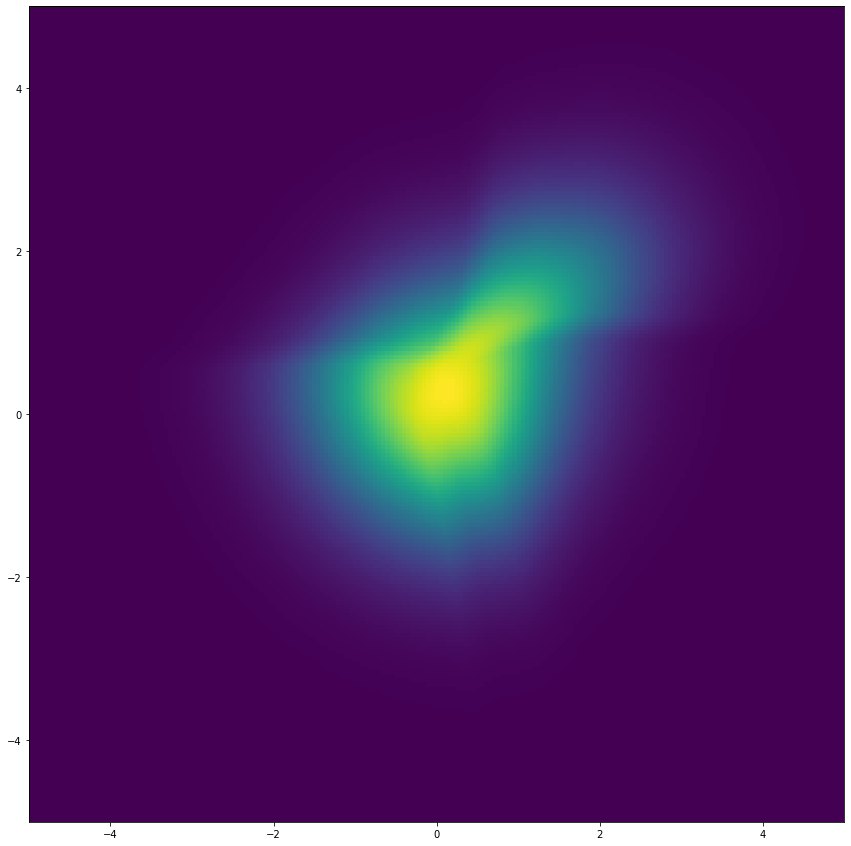

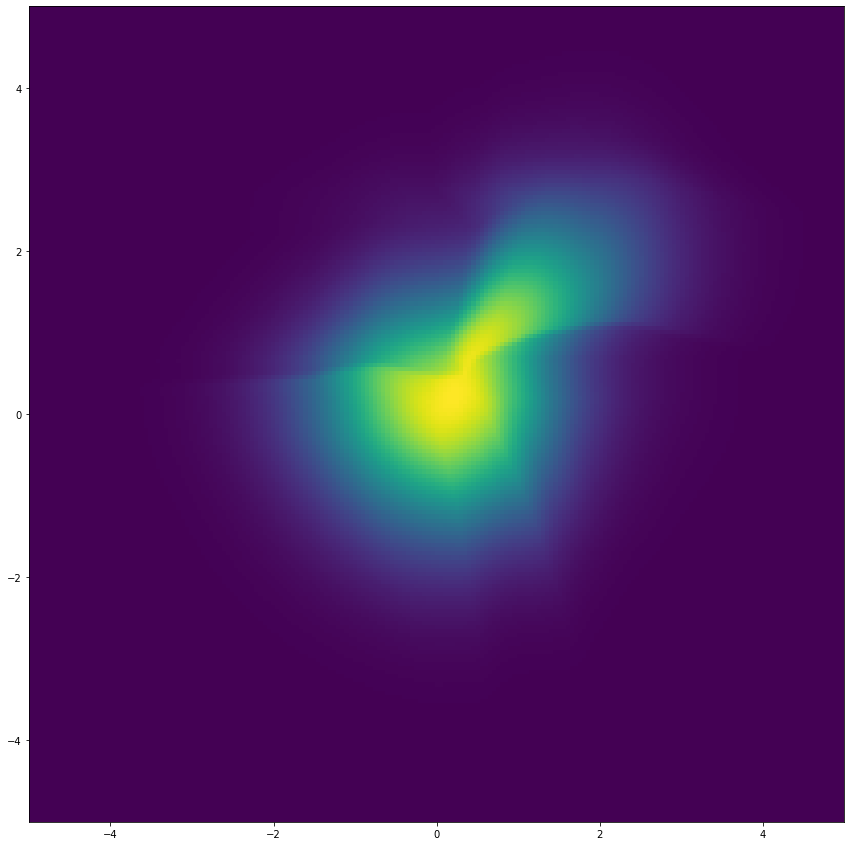

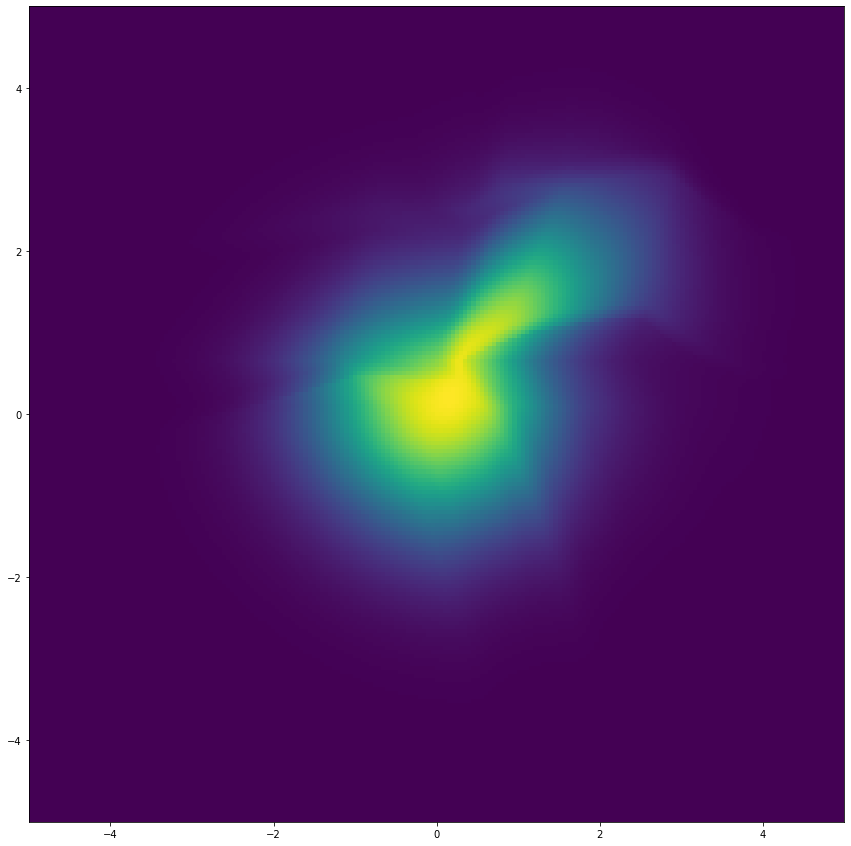

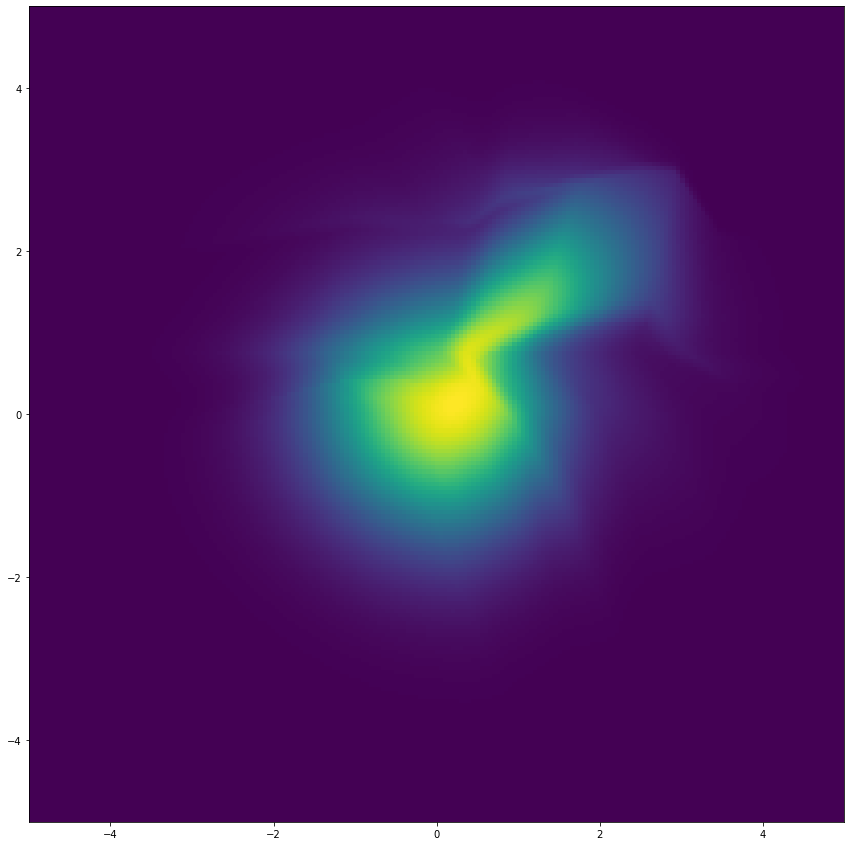

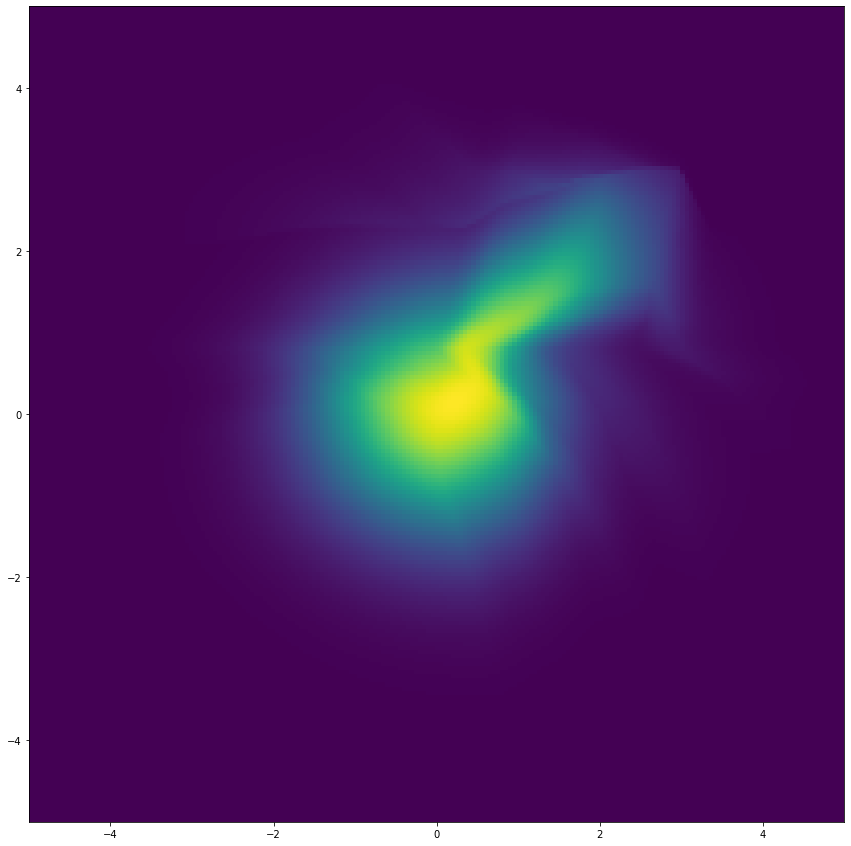

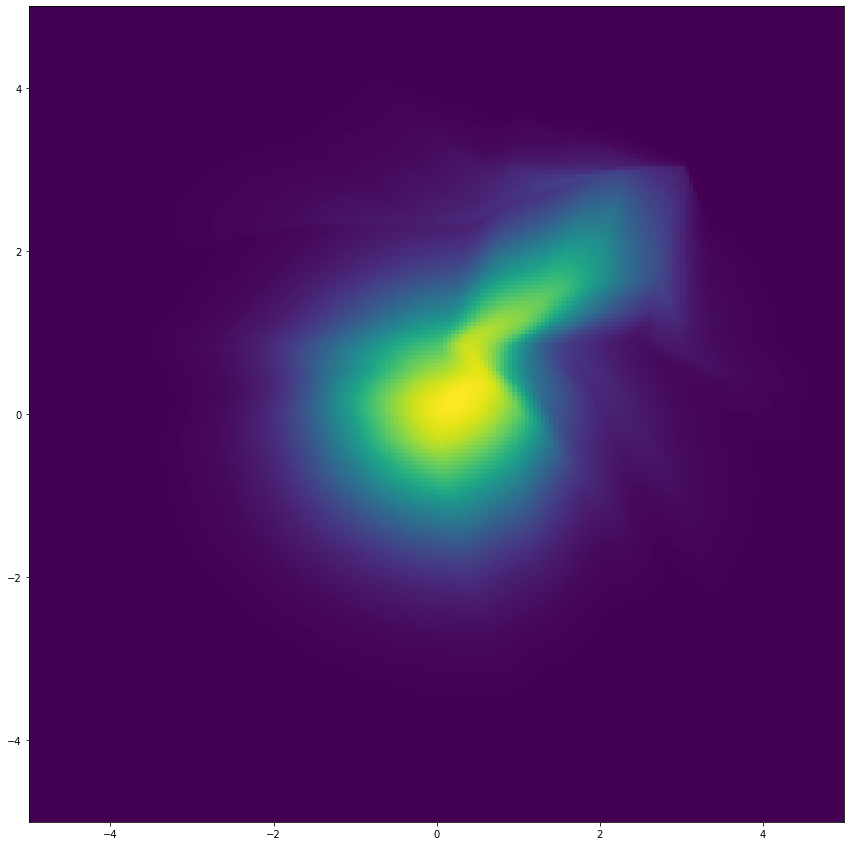

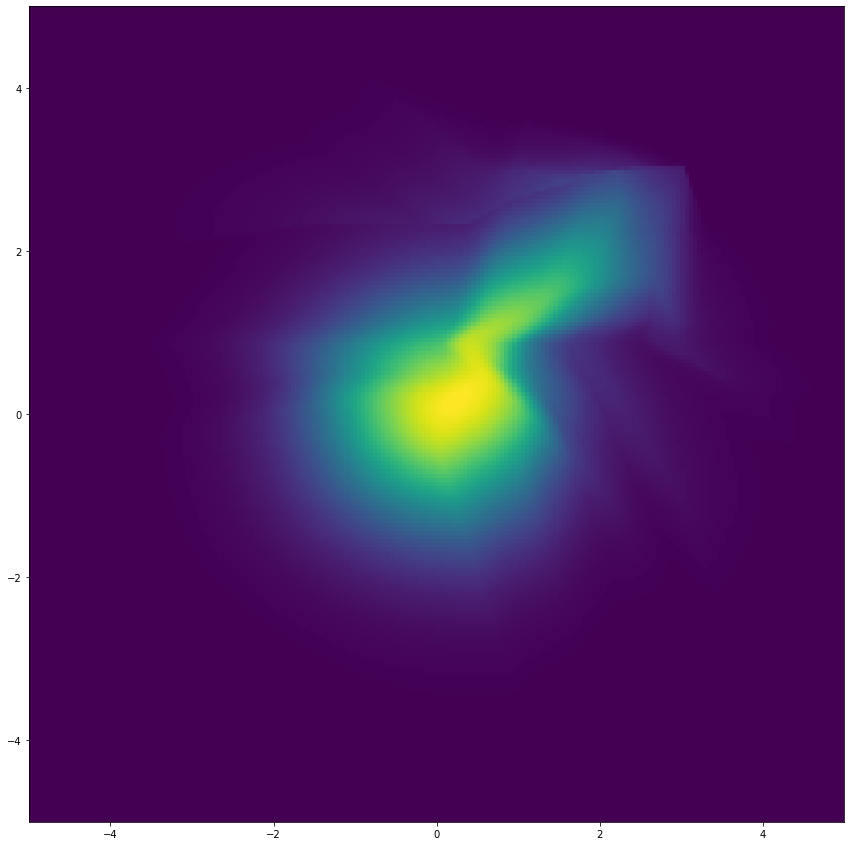

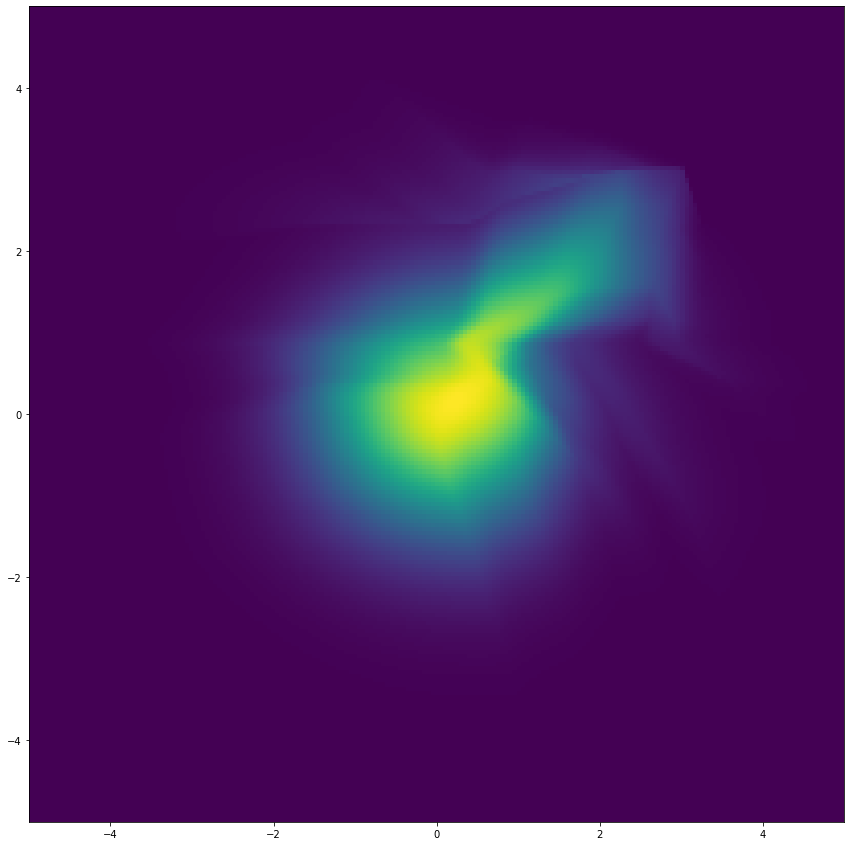

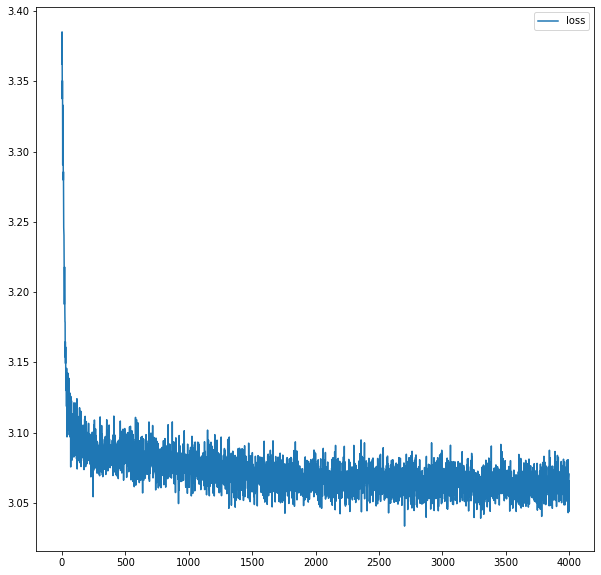

{'max_iter': 4000, 'num_samples': 10000, 'num_segments': 4, 'pow_of_two': 1, 'prob_delta': 0.8, 'dims_dense': [1, 16, 32, 16, 1]} {'loss': 3.065509080886841, 'Bias_prob_hyp': 5.66774368286338e-05, 'SqErr_prob_hyp': 3.212331845463775e-09}
4 1 4000 10000 [ 1  4 32  4  1]


 12%|█▏        | 498/4000 [00:35<04:34, 12.78it/s]<ipython-input-19-1b55656c51ce>:89: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, prob.data.numpy())
100%|██████████| 4000/4000 [04:50<00:00, 13.79it/s]


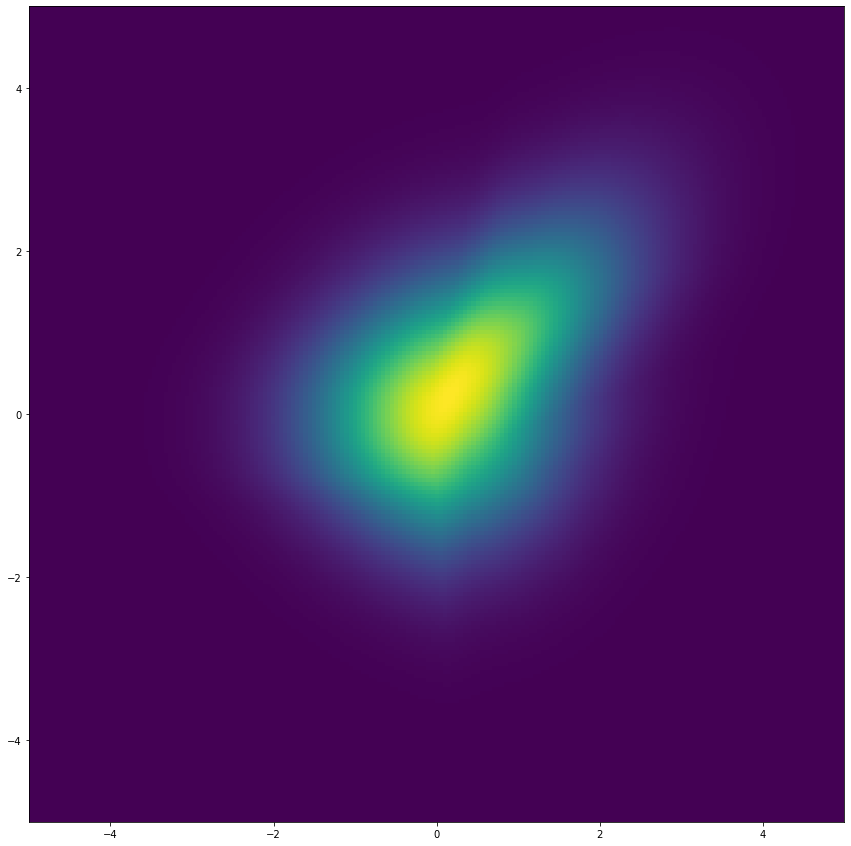

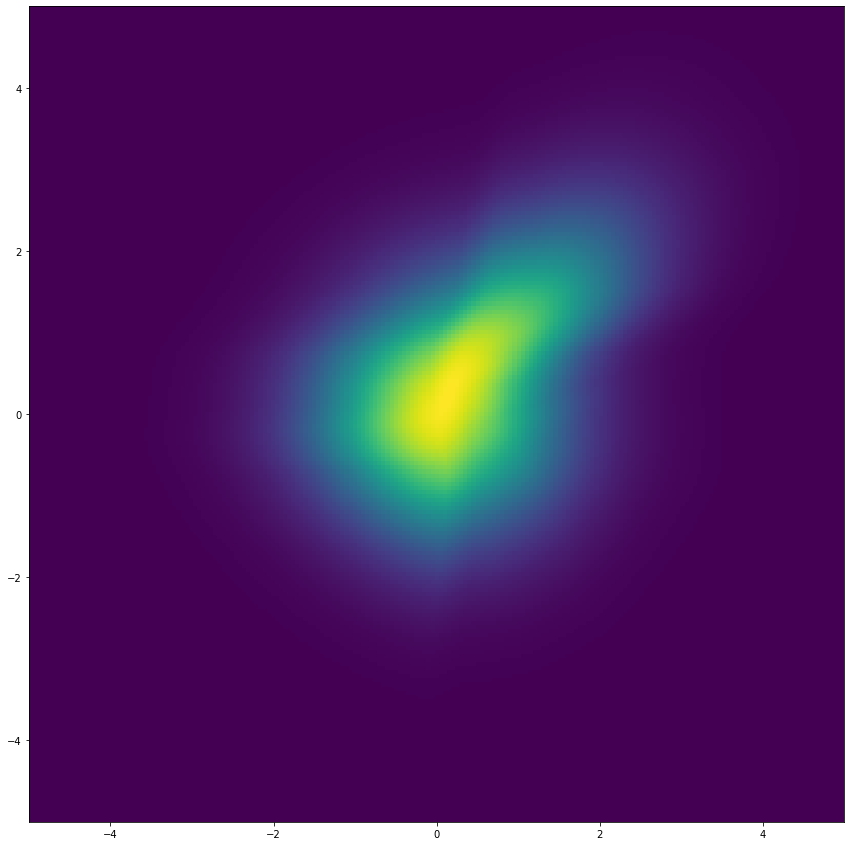

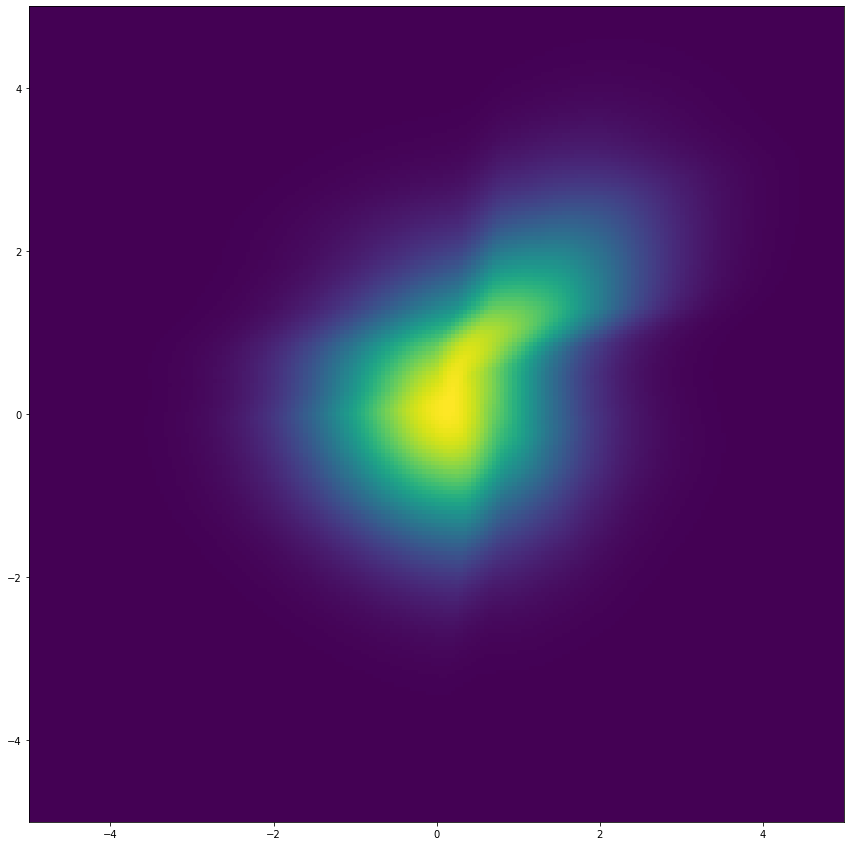

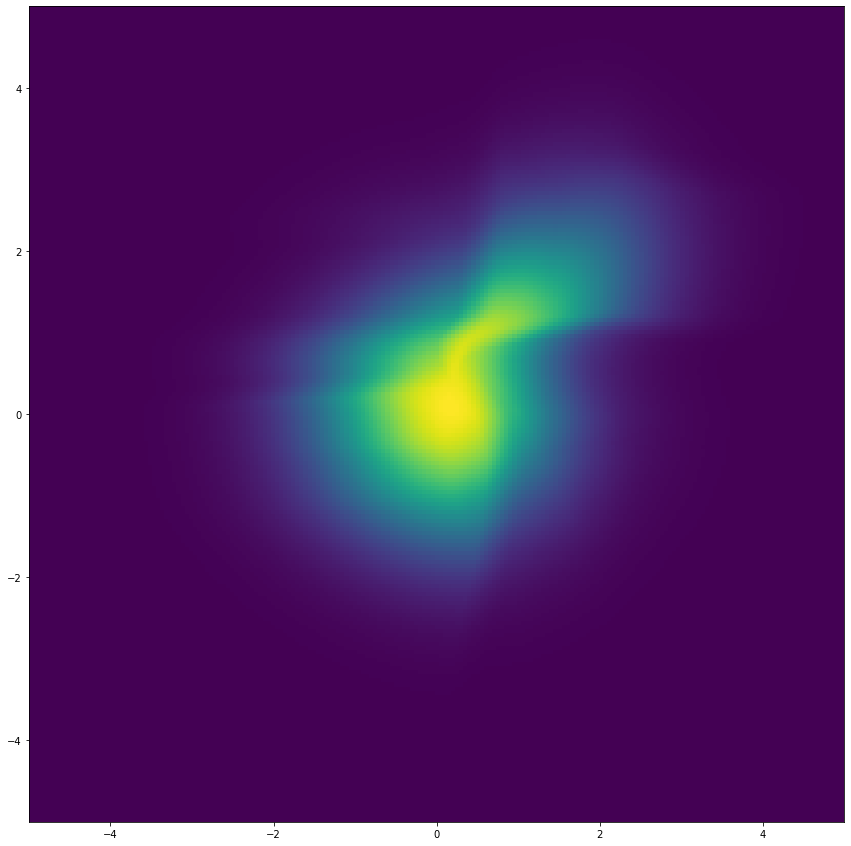

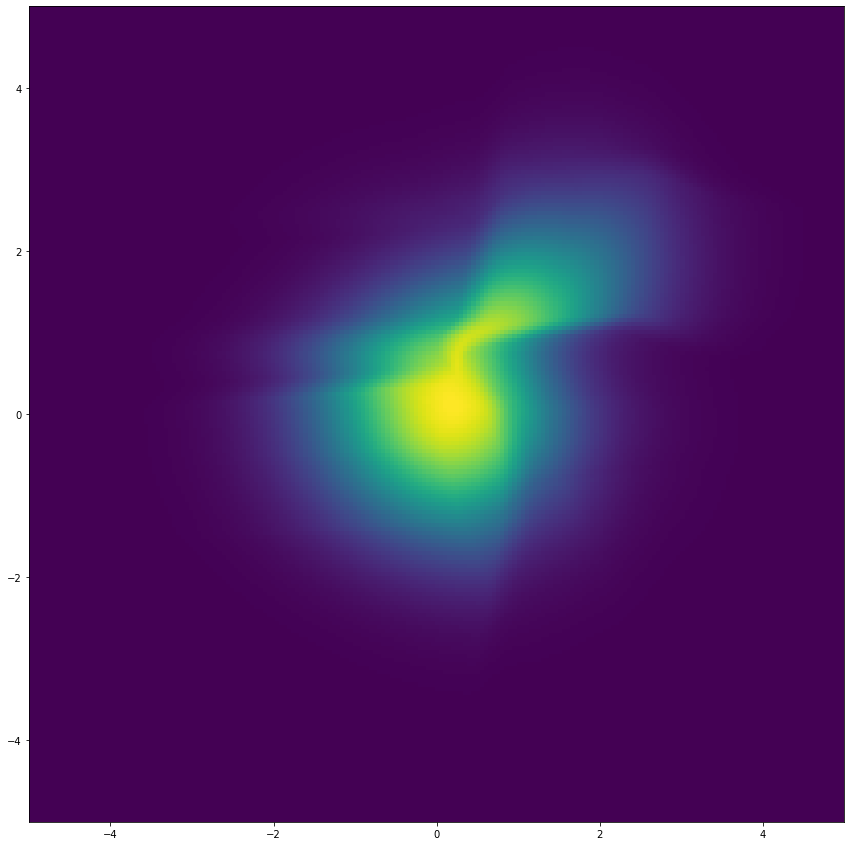

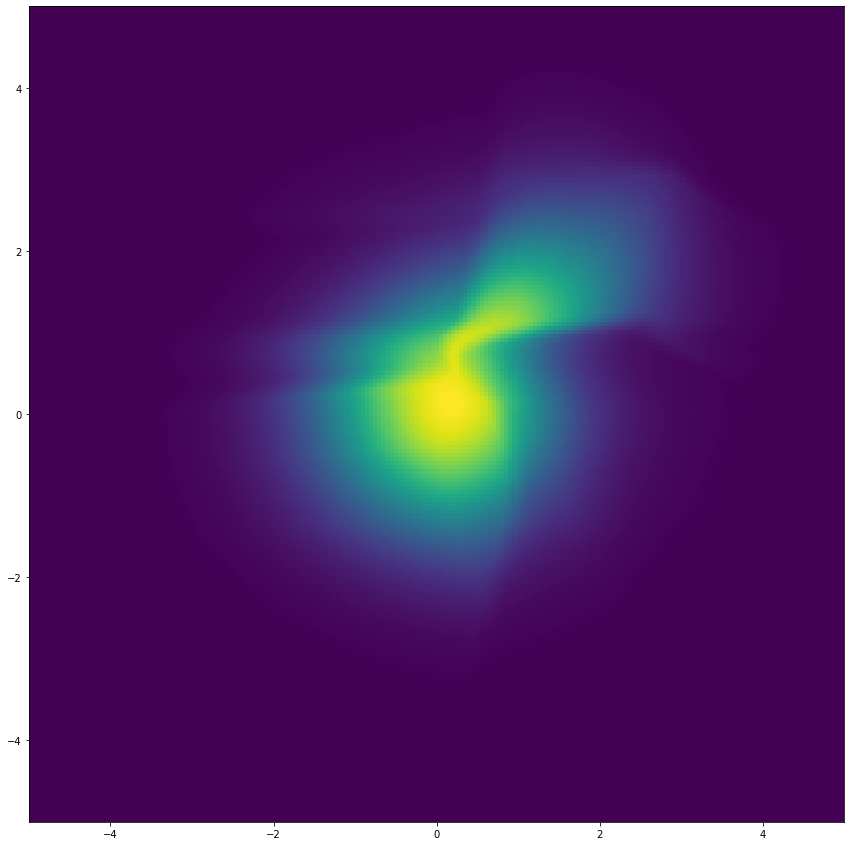

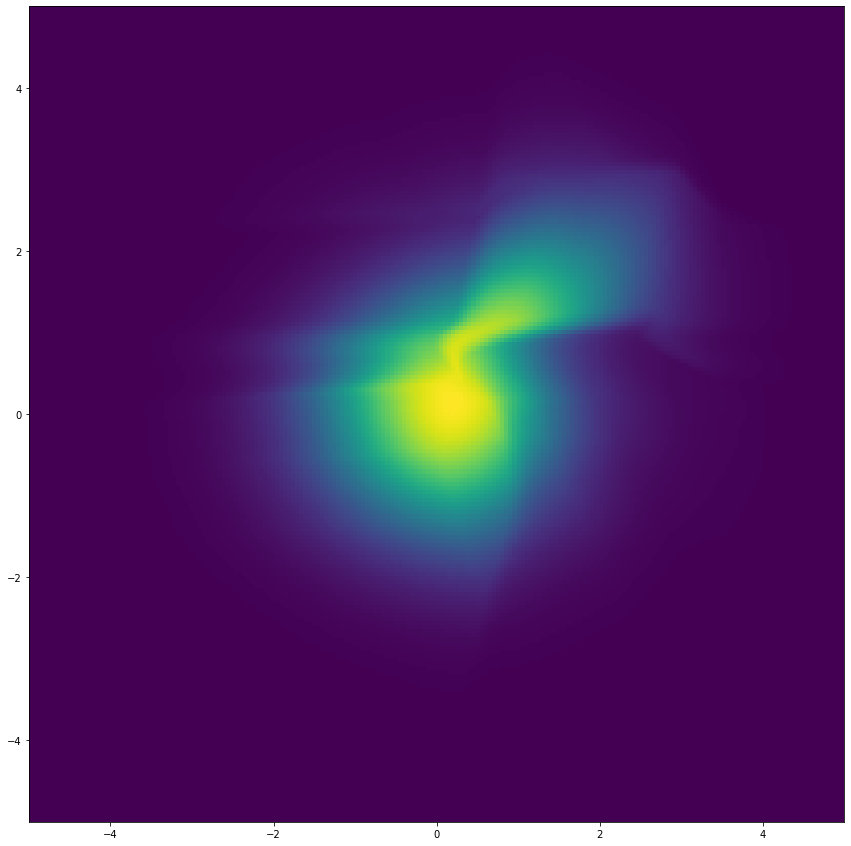

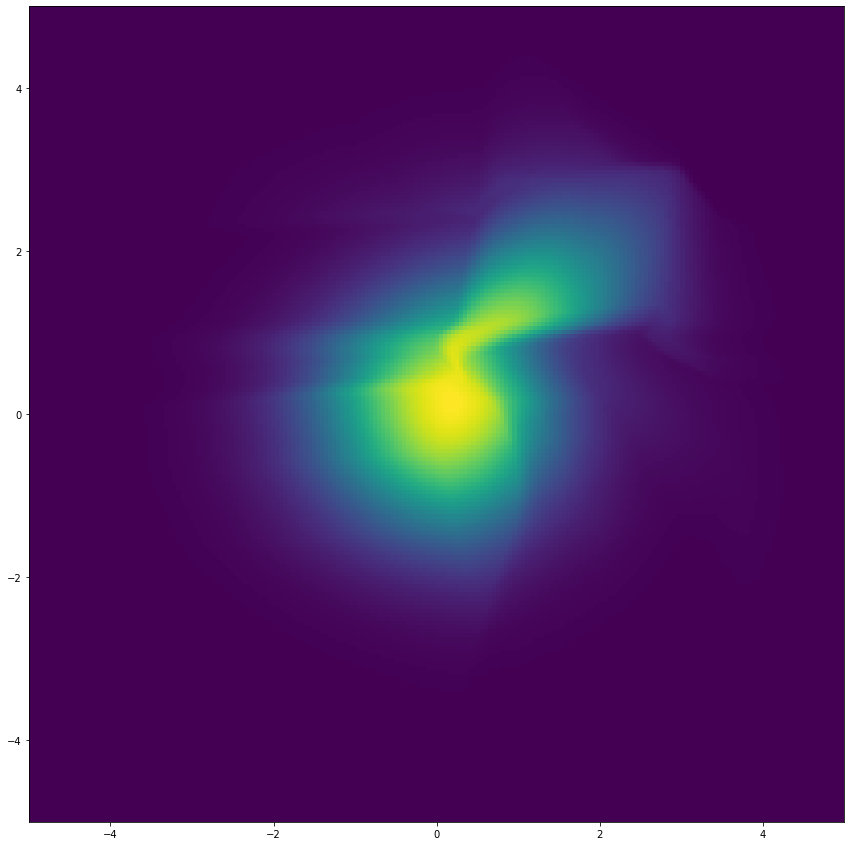

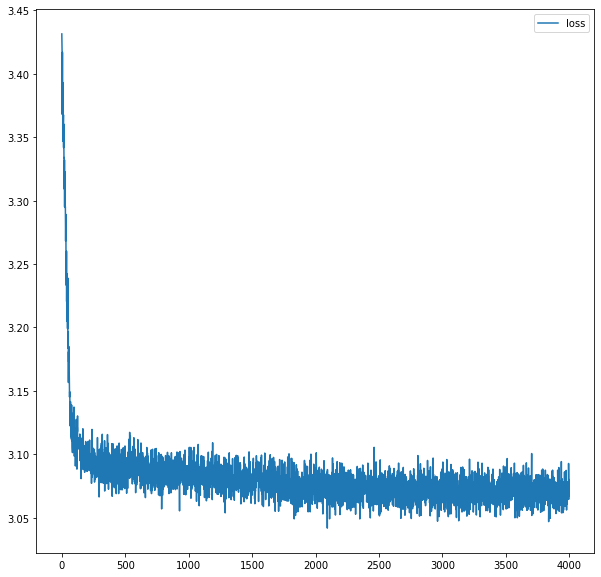

{'max_iter': 4000, 'num_samples': 10000, 'num_segments': 4, 'pow_of_two': 1, 'prob_delta': 0.8, 'dims_dense': [1, 4, 32, 4, 1]} {'loss': 3.0650157928466797, 'Bias_prob_hyp': 0.0026066774368286305, 'SqErr_prob_hyp': 6.794767259671479e-06}
6 1 2000 2048 [ 1 16 64 16  1]


 12%|█▏        | 248/2000 [00:12<01:27, 19.93it/s]<ipython-input-19-1b55656c51ce>:89: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, prob.data.numpy())
100%|██████████| 2000/2000 [01:52<00:00, 17.80it/s]


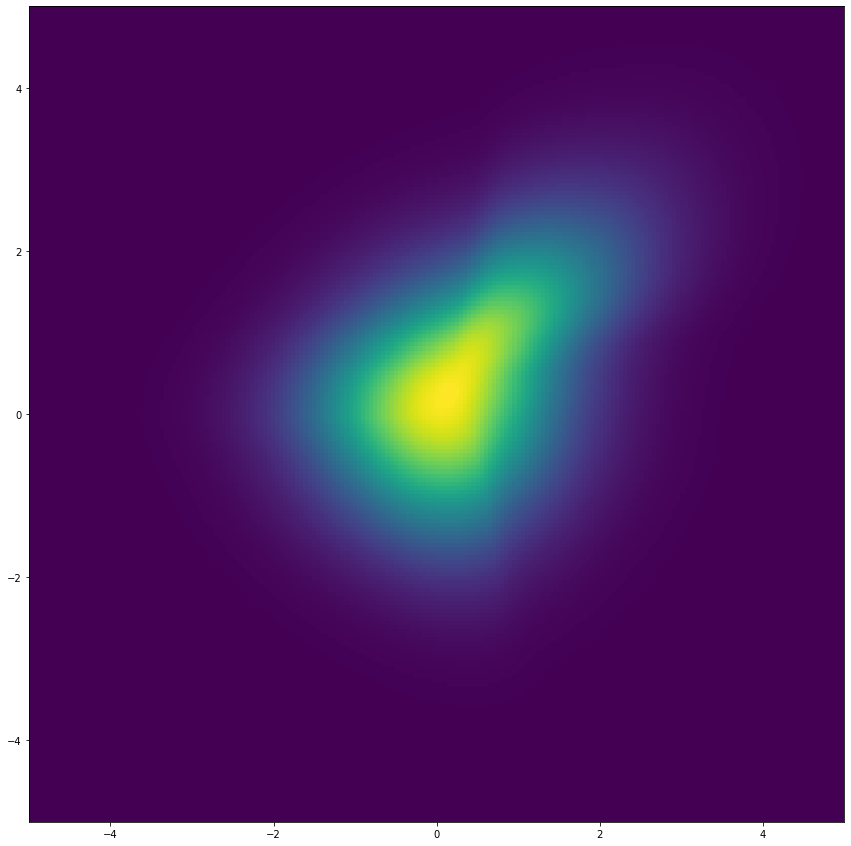

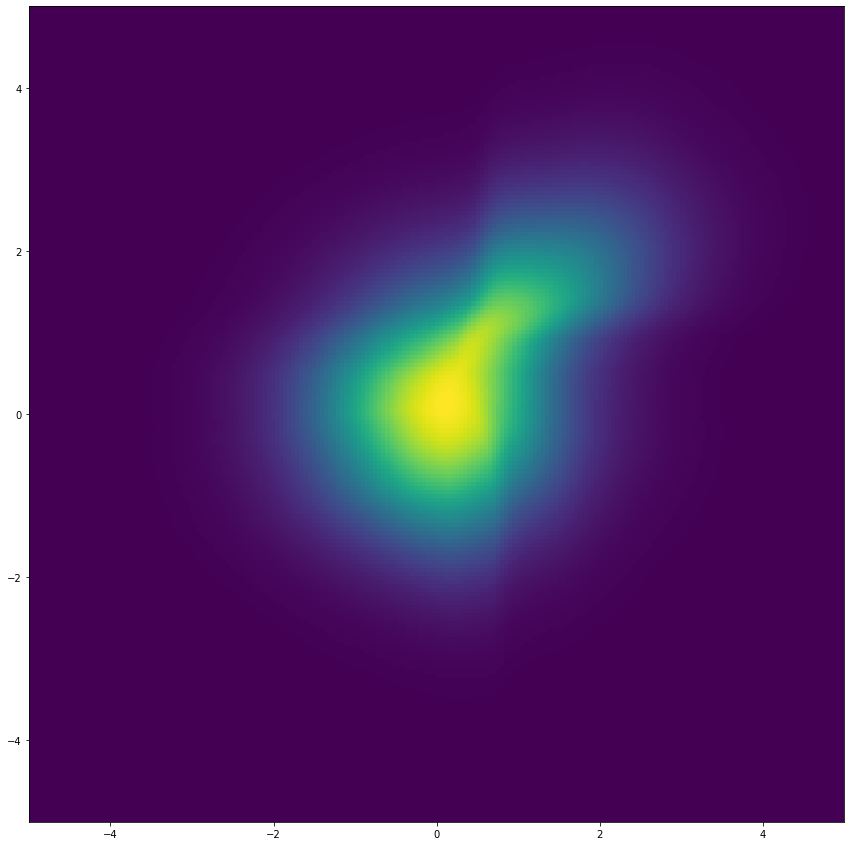

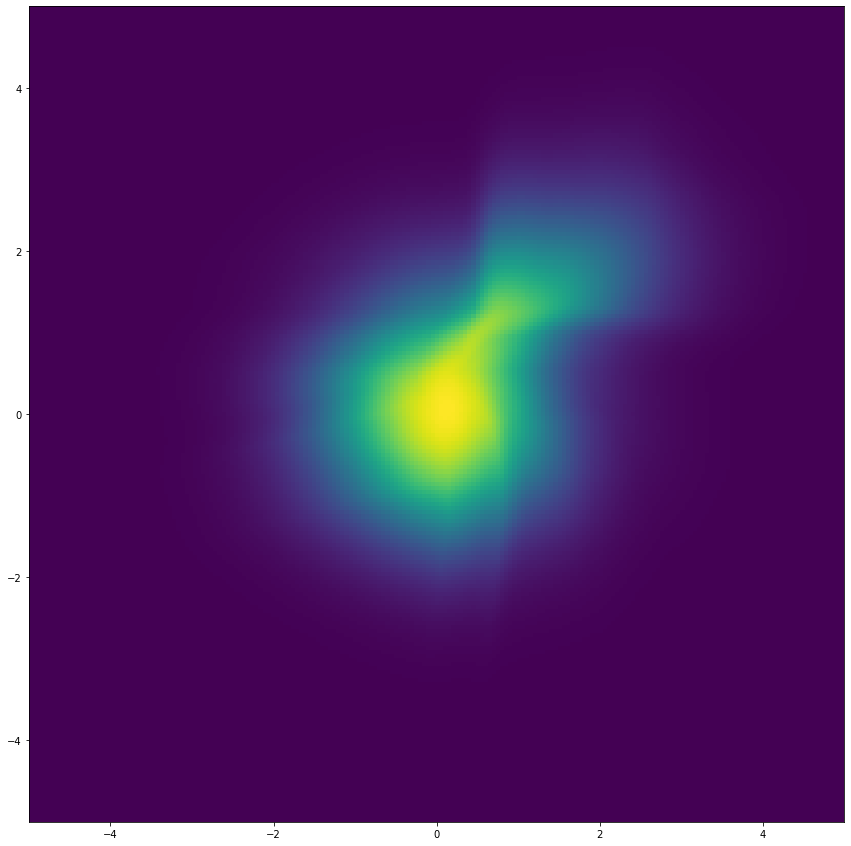

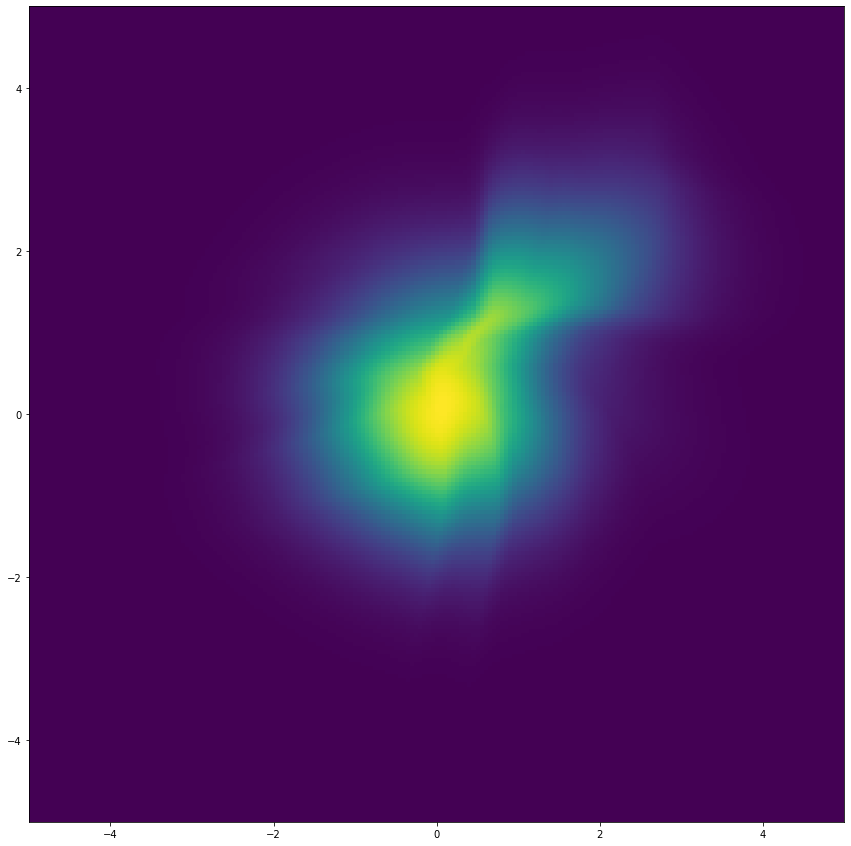

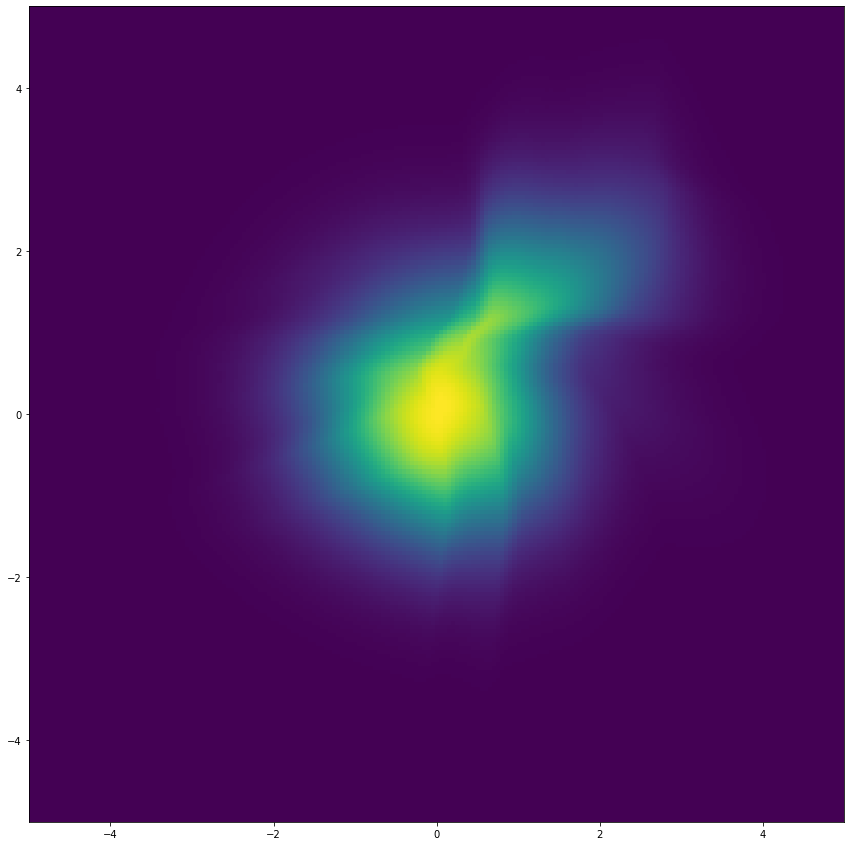

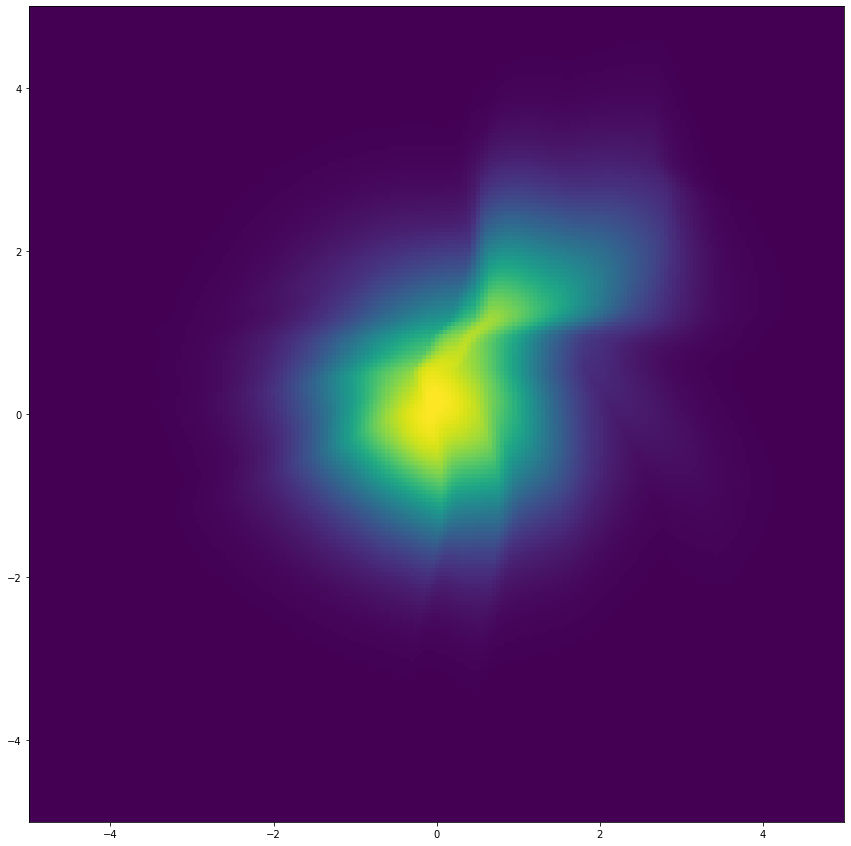

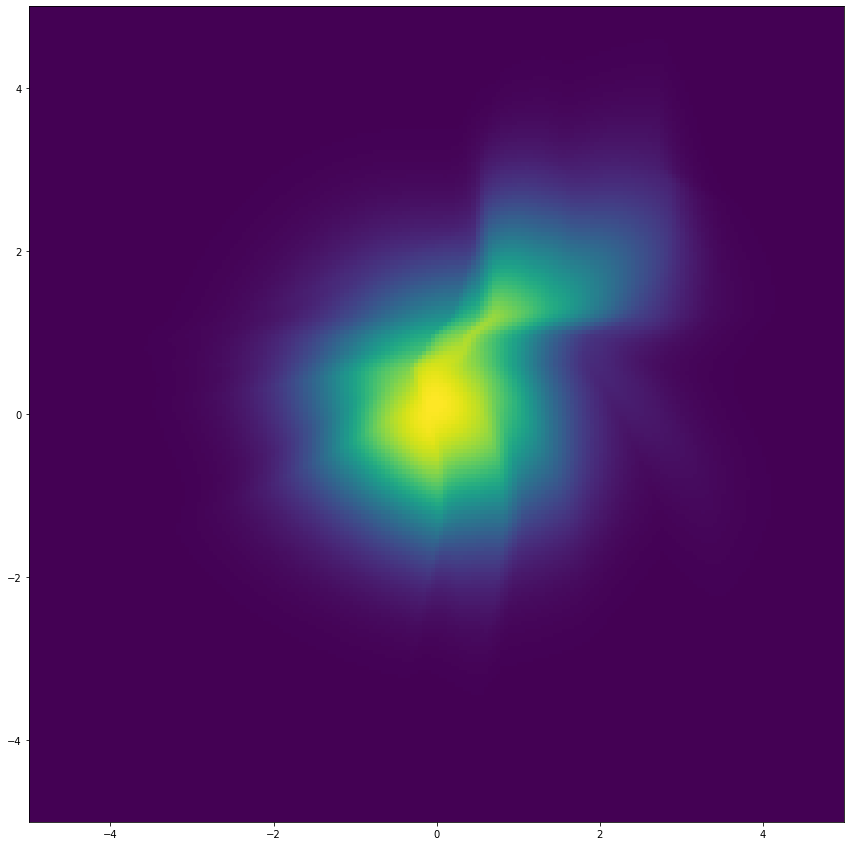

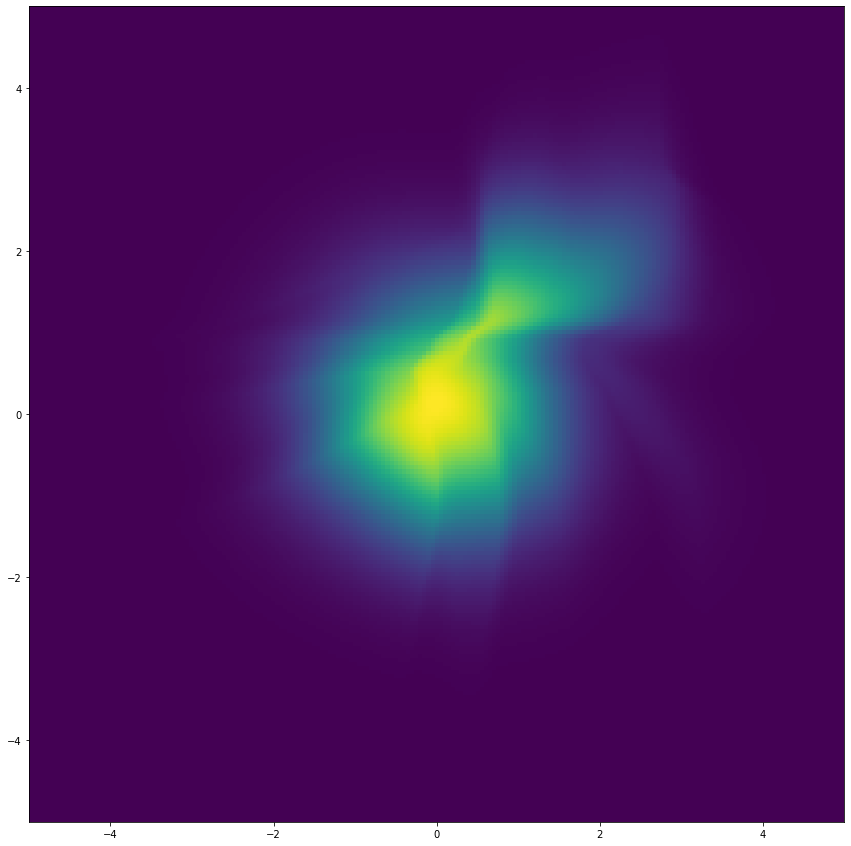

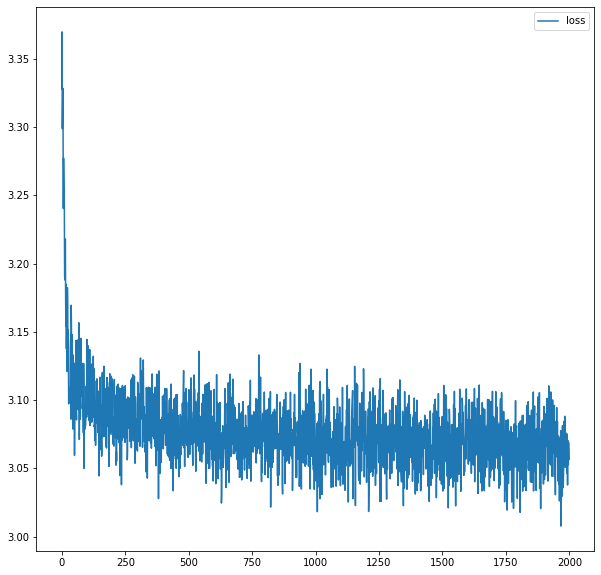

{'max_iter': 2000, 'num_samples': 2048, 'num_segments': 6, 'pow_of_two': 1, 'prob_delta': 0.8, 'dims_dense': [1, 16, 64, 16, 1]} {'loss': 3.0567119121551514, 'Bias_prob_hyp': -0.0018519163131713867, 'SqErr_prob_hyp': 3.4295940309903017e-06}
6 1 2000 2048 [ 1 16 32 16  1]


 12%|█▏        | 247/2000 [00:10<01:16, 22.79it/s]<ipython-input-19-1b55656c51ce>:89: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, prob.data.numpy())
100%|██████████| 2000/2000 [01:47<00:00, 18.65it/s]


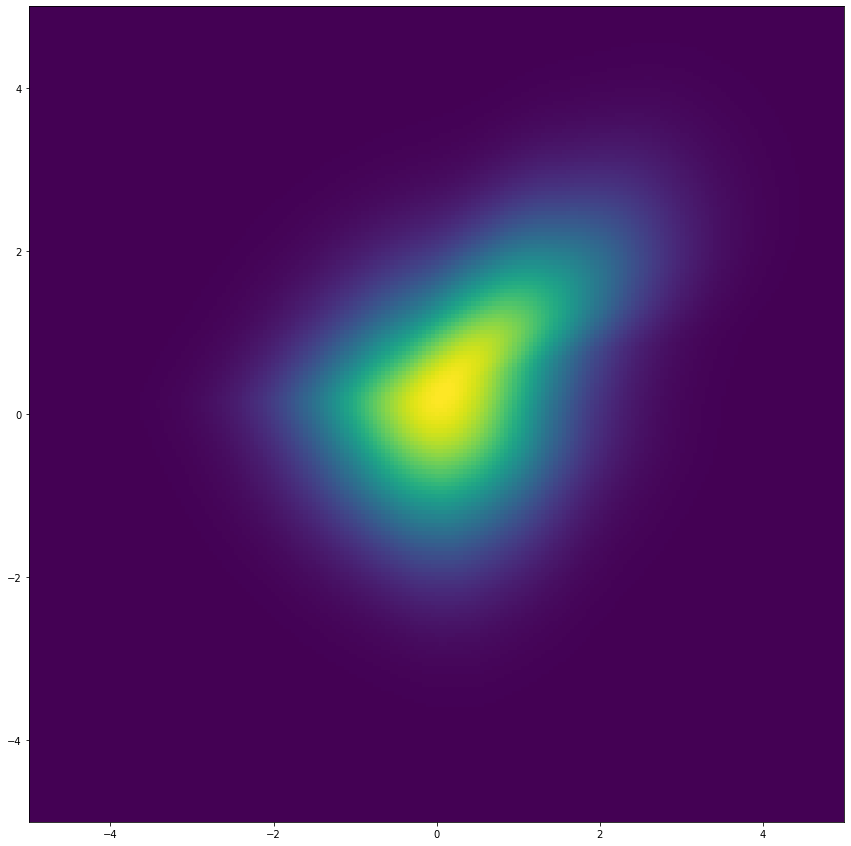

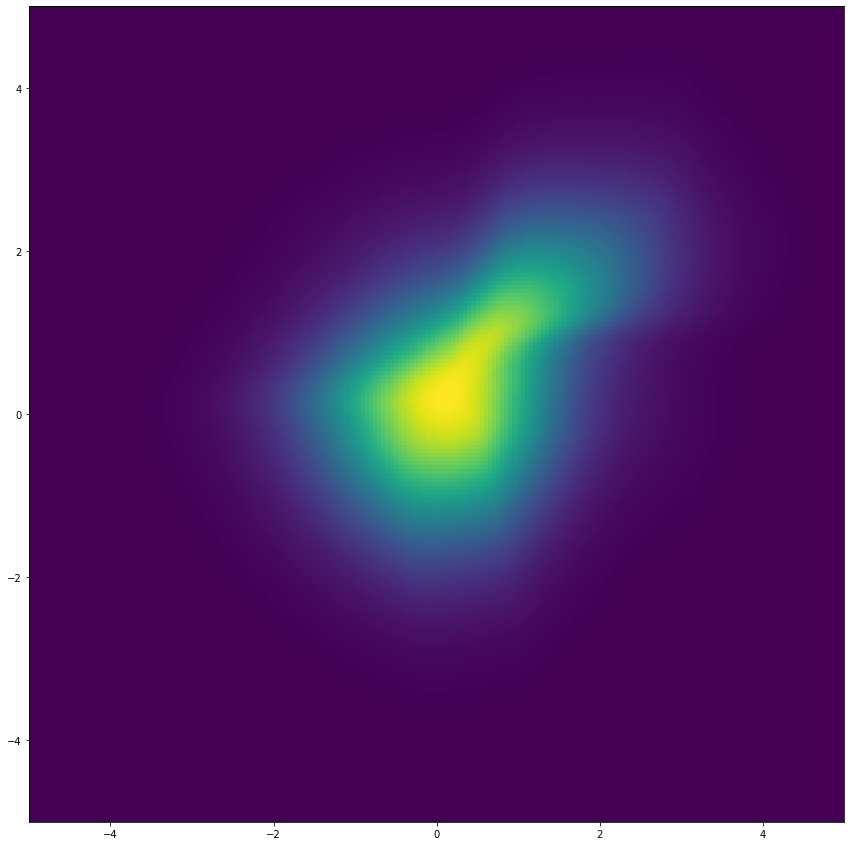

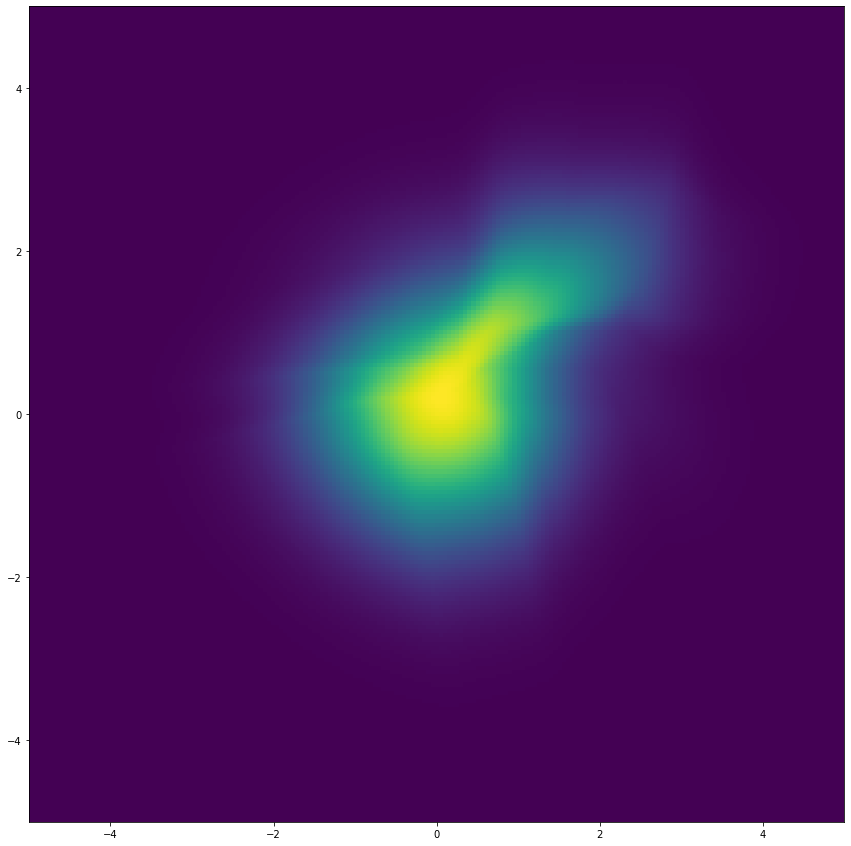

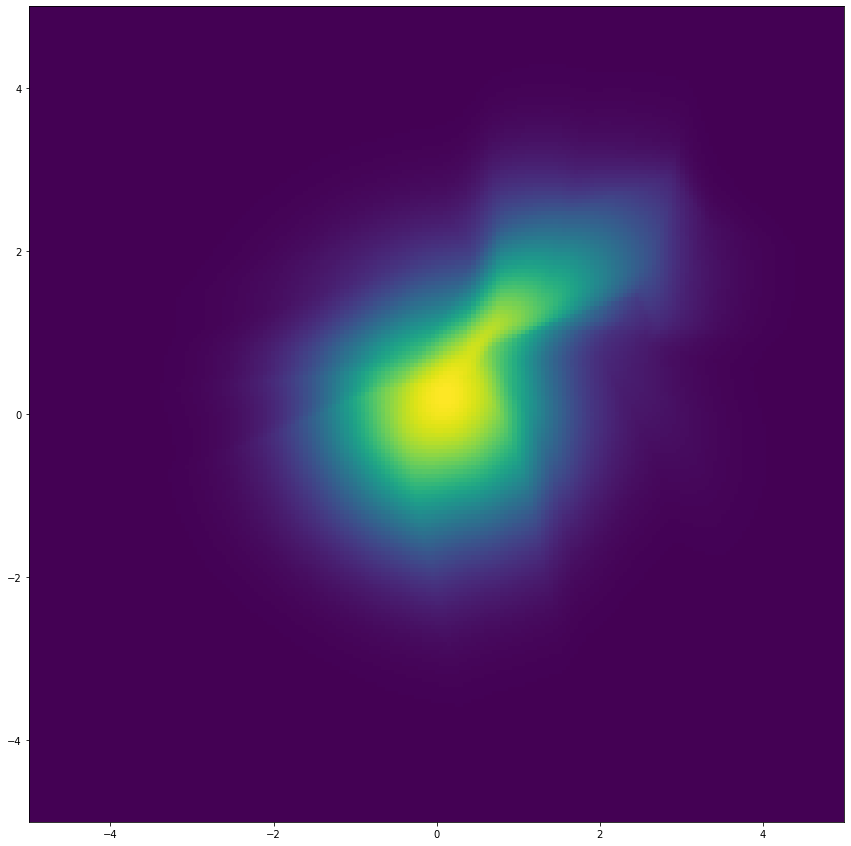

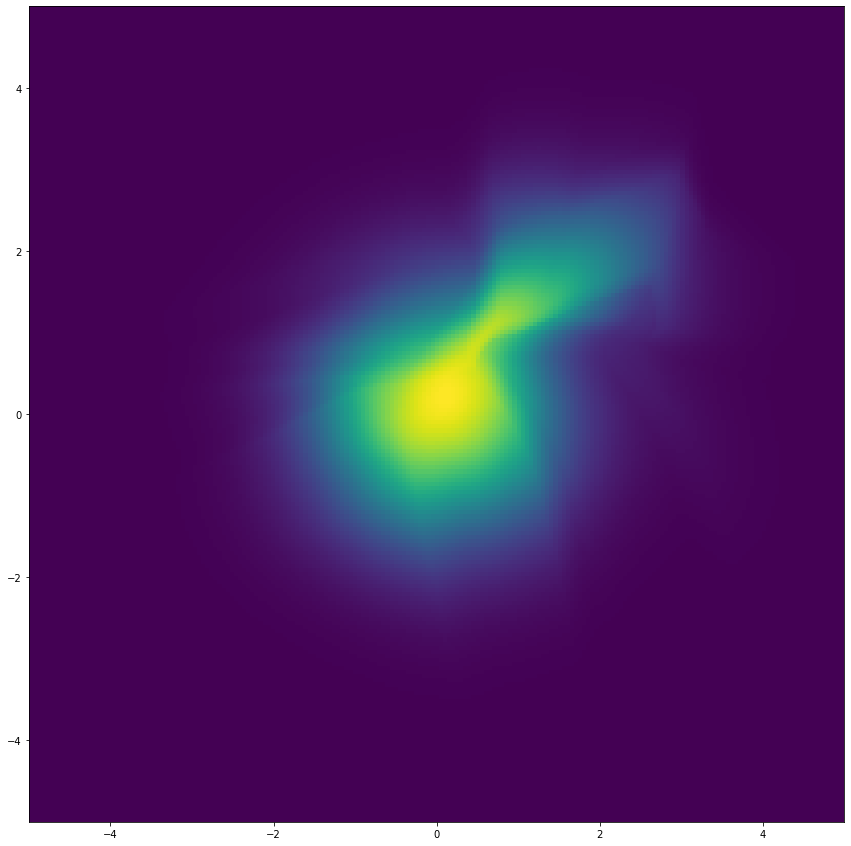

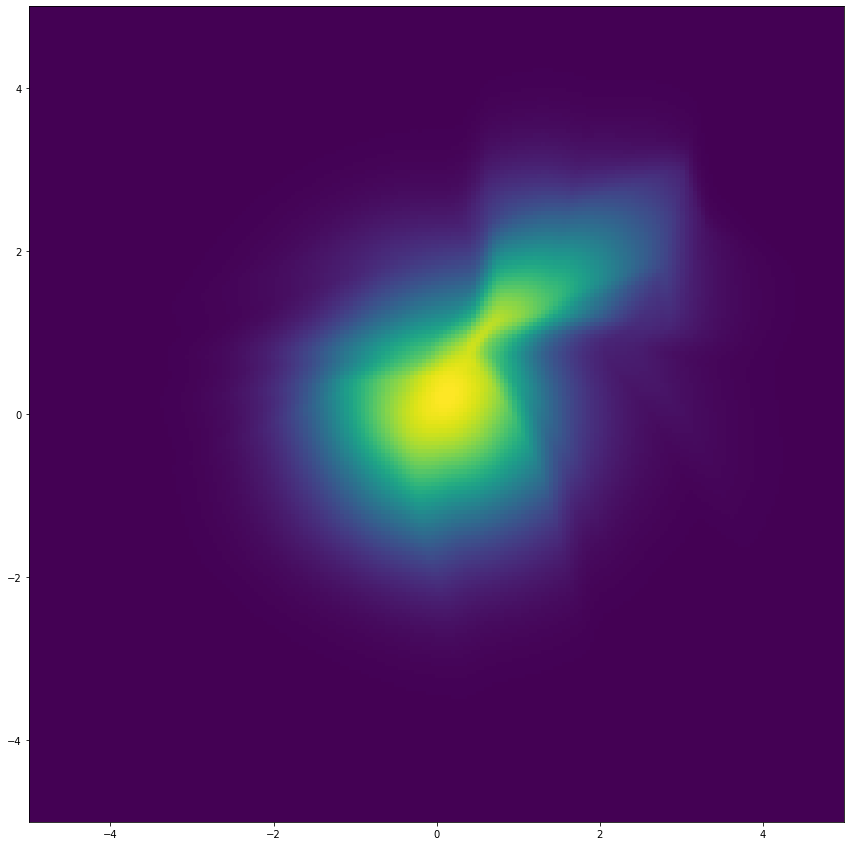

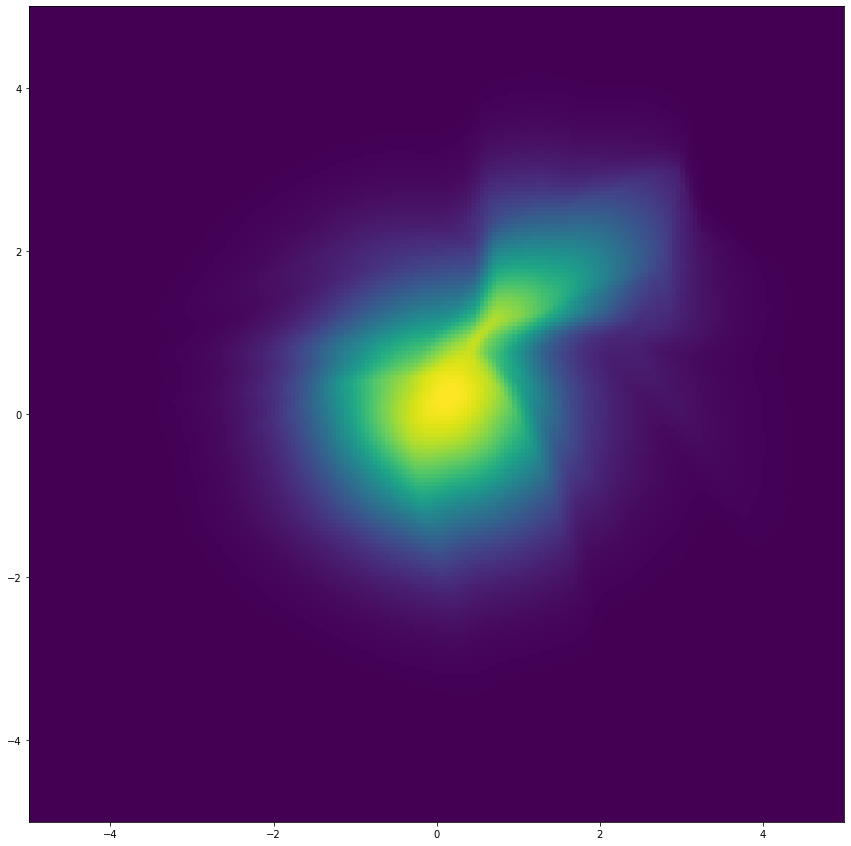

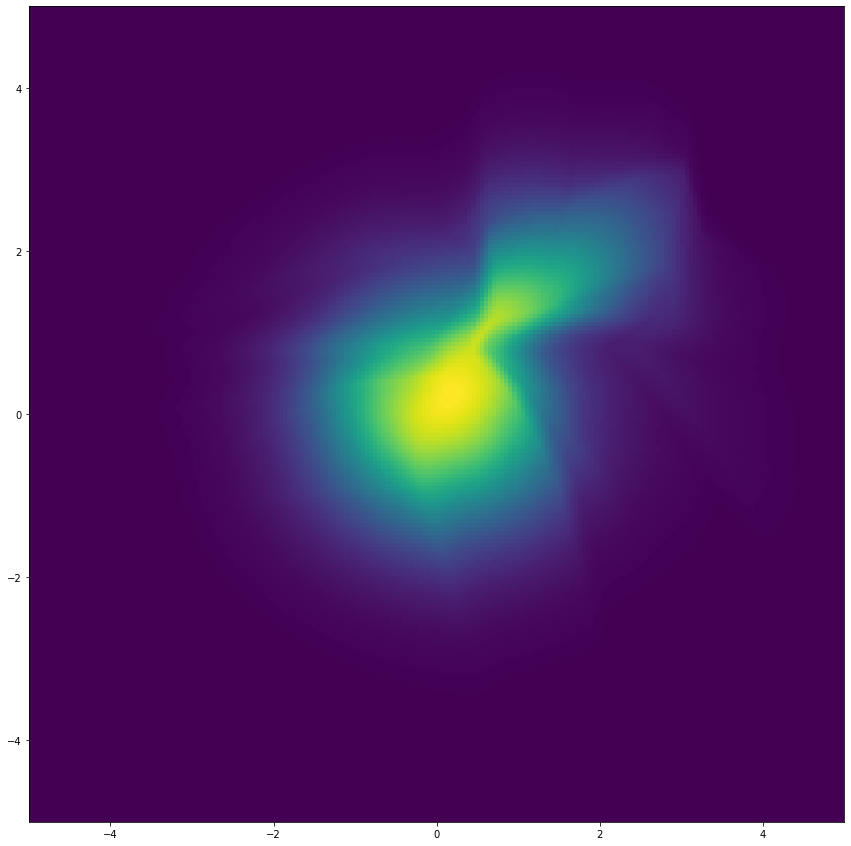

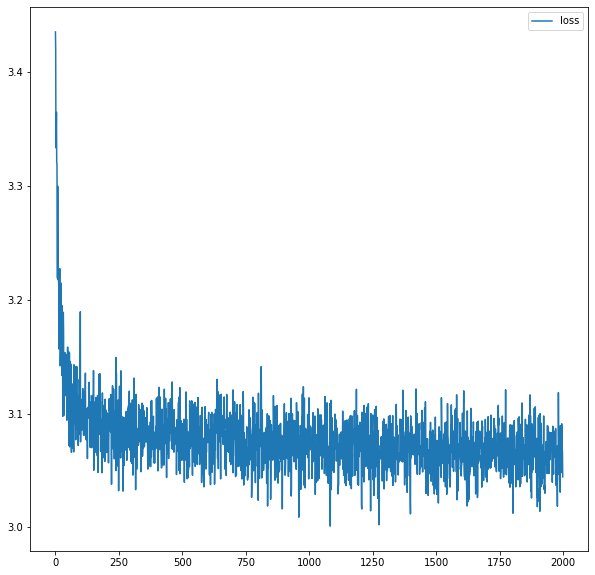

{'max_iter': 2000, 'num_samples': 2048, 'num_segments': 6, 'pow_of_two': 1, 'prob_delta': 0.8, 'dims_dense': [1, 16, 32, 16, 1]} {'loss': 3.0444231033325195, 'Bias_prob_hyp': 0.014749646186828613, 'SqErr_prob_hyp': 0.00021755206263662785}
6 1 2000 2048 [ 1  4 32  4  1]


 12%|█▏        | 247/2000 [00:11<01:02, 28.27it/s]<ipython-input-19-1b55656c51ce>:89: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, prob.data.numpy())
100%|██████████| 2000/2000 [01:36<00:00, 20.72it/s]


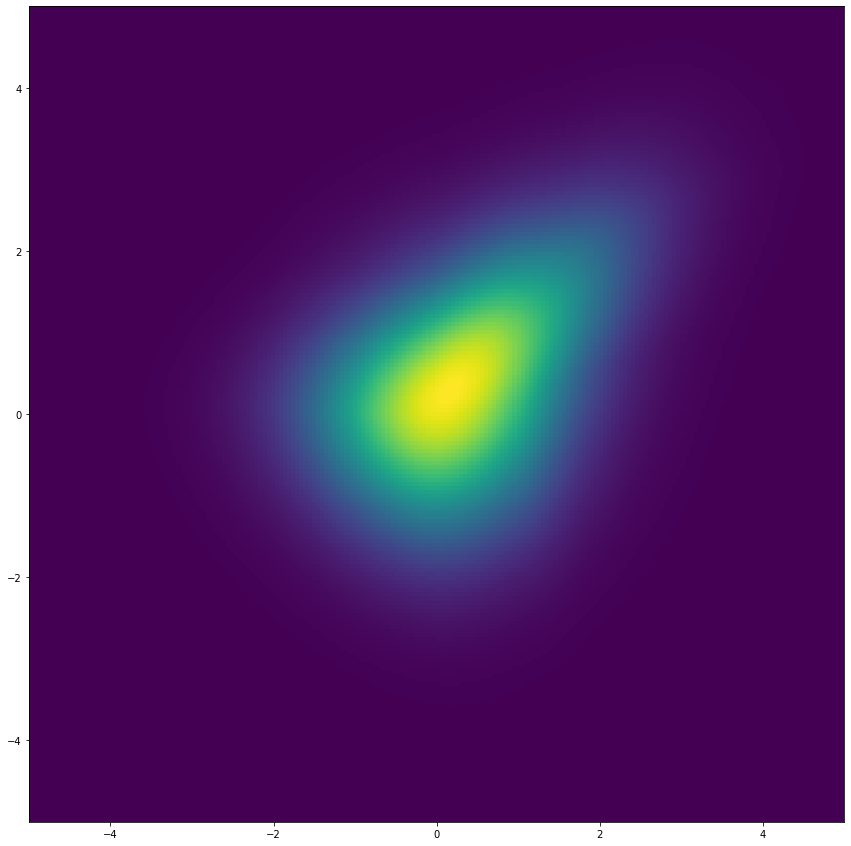

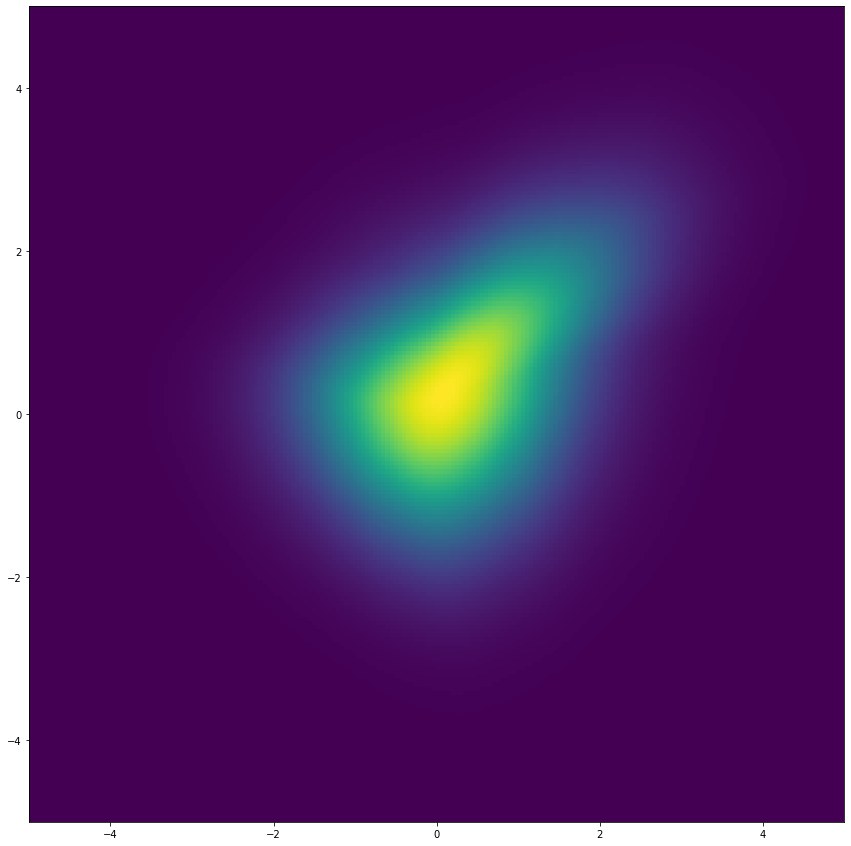

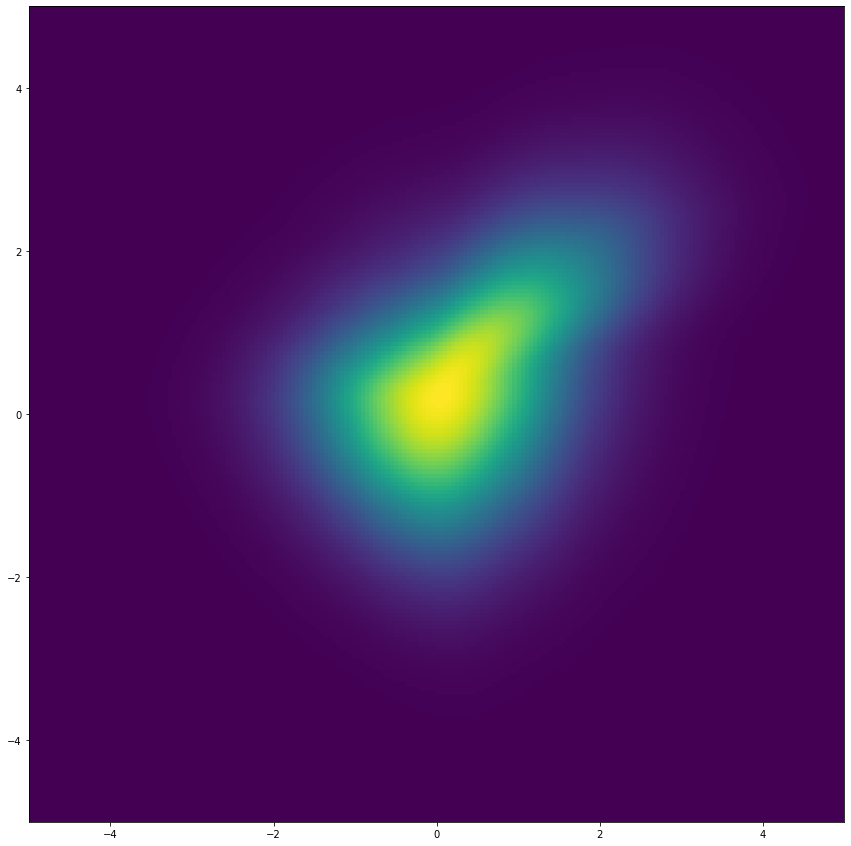

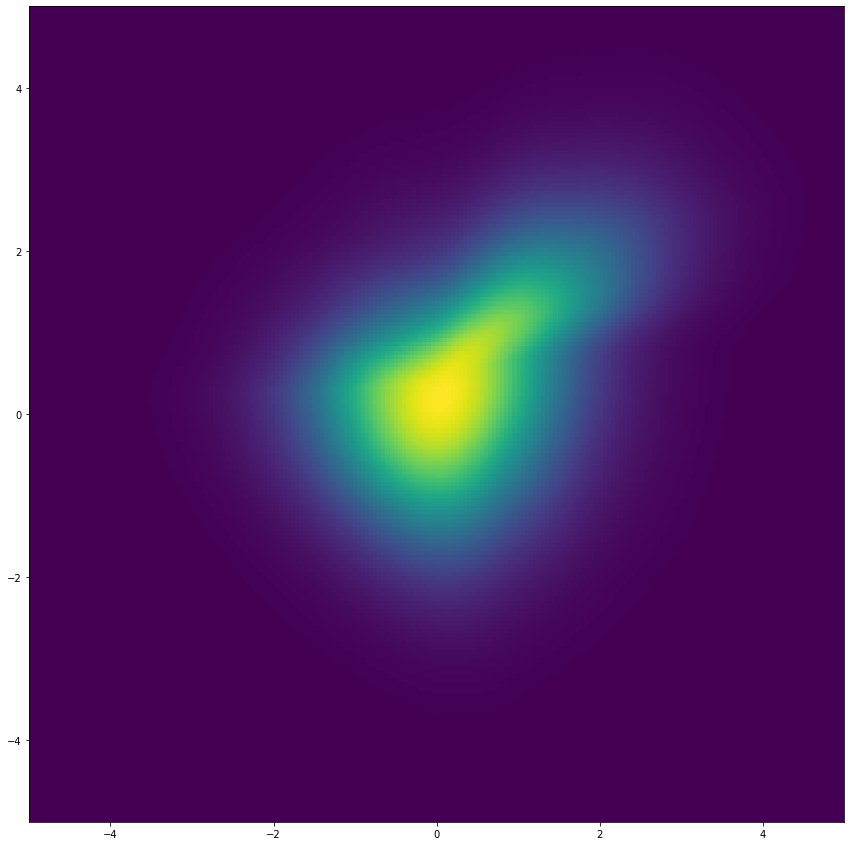

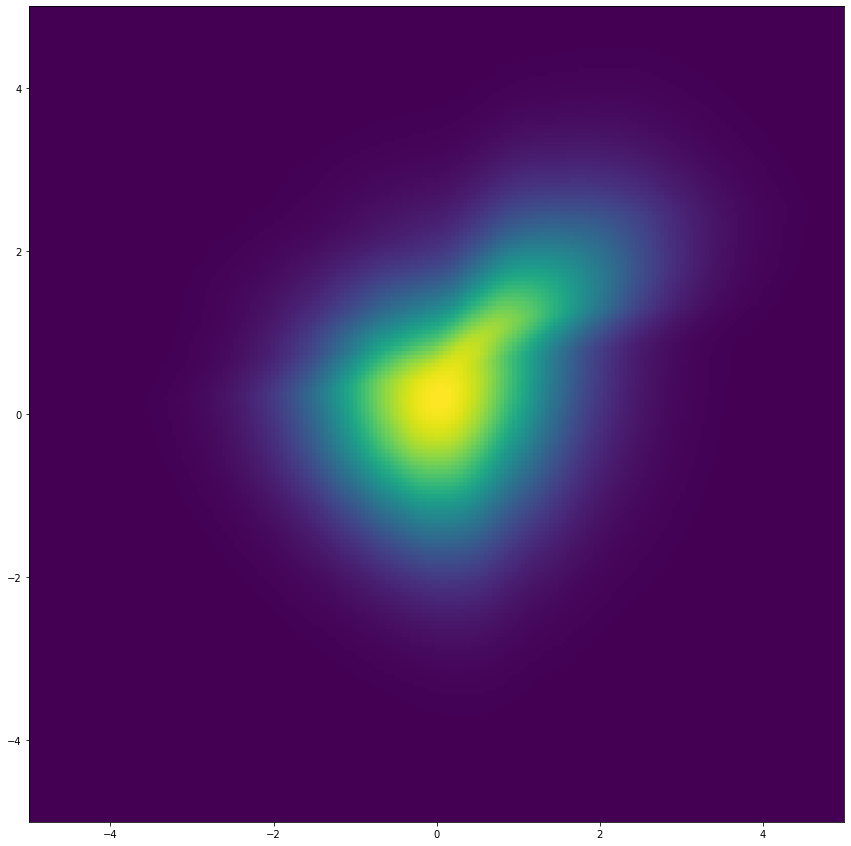

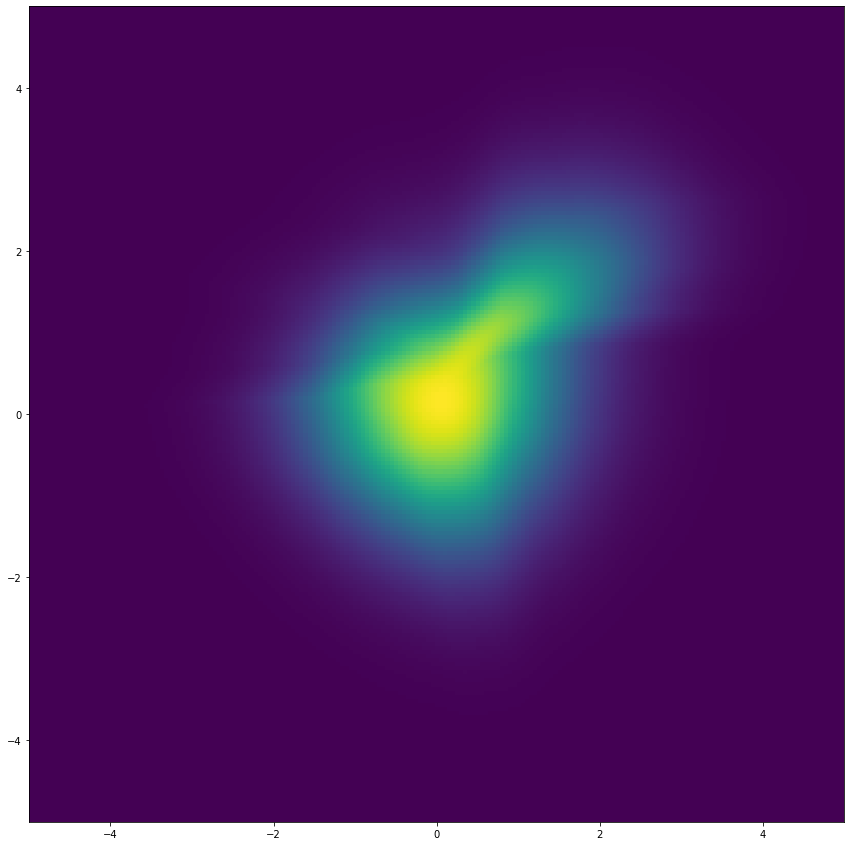

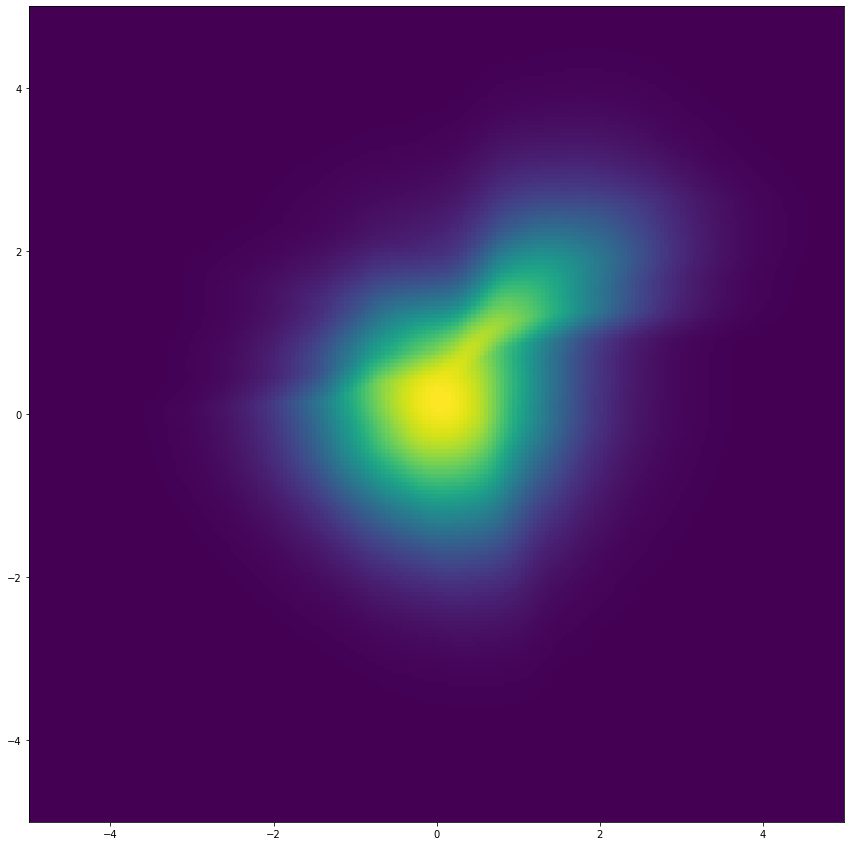

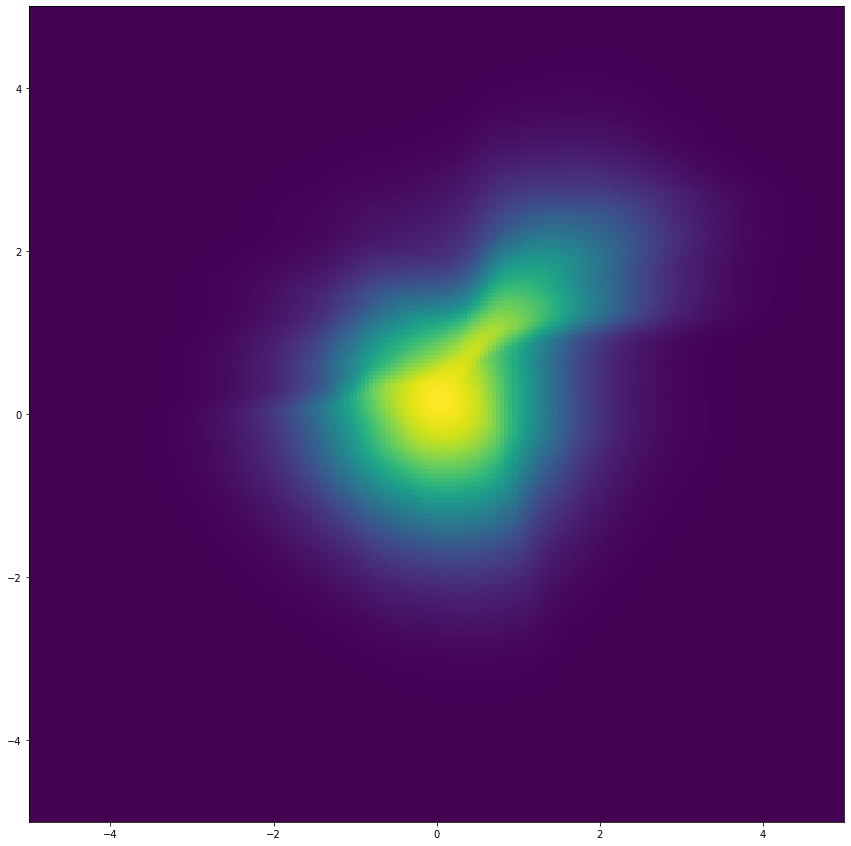

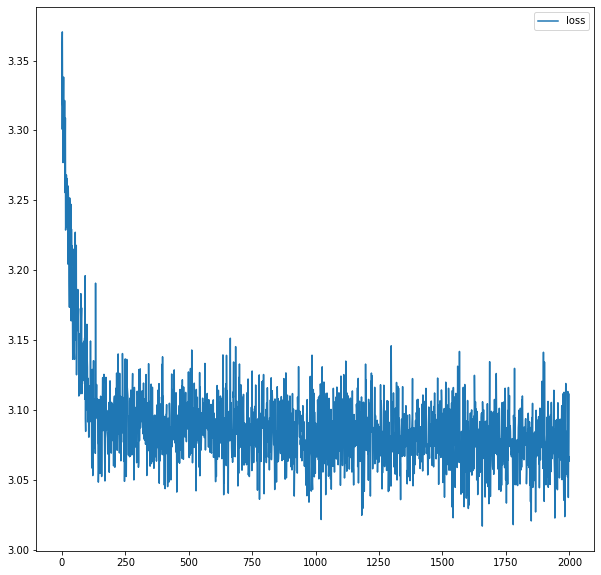

{'max_iter': 2000, 'num_samples': 2048, 'num_segments': 6, 'pow_of_two': 1, 'prob_delta': 0.8, 'dims_dense': [1, 4, 32, 4, 1]} {'loss': 3.1111936569213867, 'Bias_prob_hyp': 0.0013219118118286133, 'SqErr_prob_hyp': 1.747450838252007e-06}
6 1 2000 5000 [ 1 16 64 16  1]


 12%|█▏        | 248/2000 [00:26<02:42, 10.78it/s]<ipython-input-19-1b55656c51ce>:89: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, prob.data.numpy())
100%|██████████| 2000/2000 [03:13<00:00, 10.33it/s]


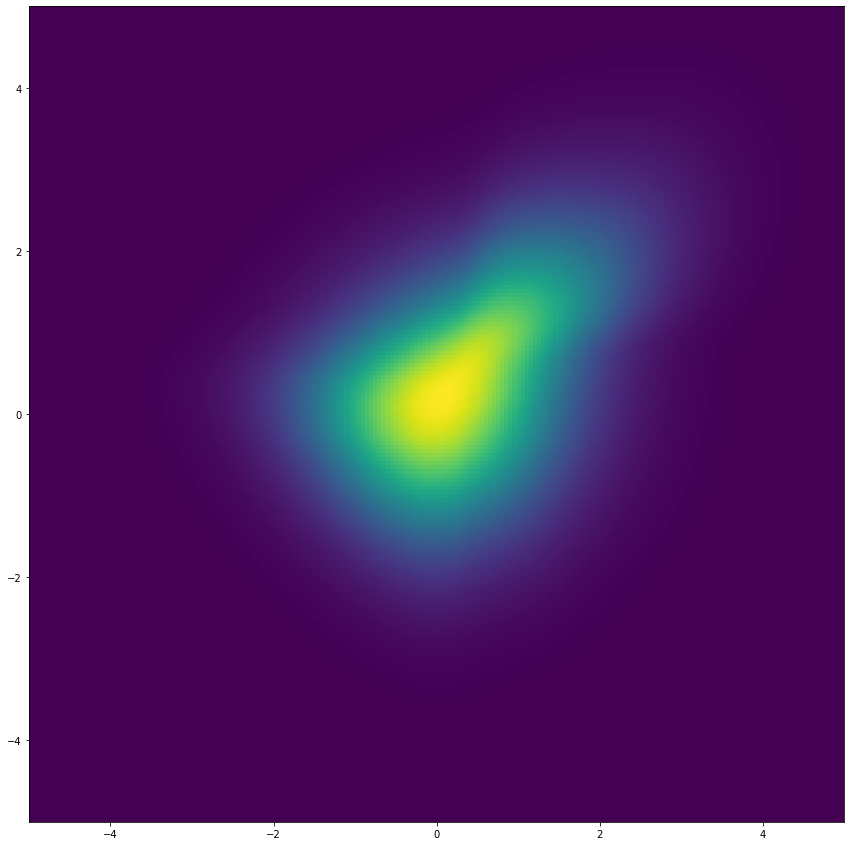

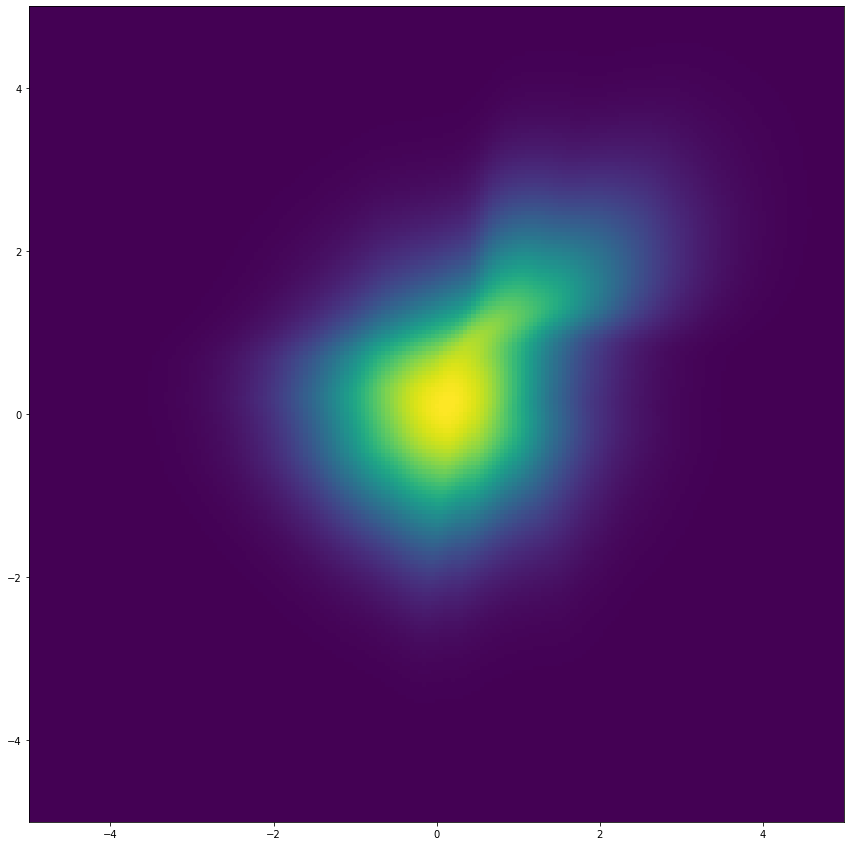

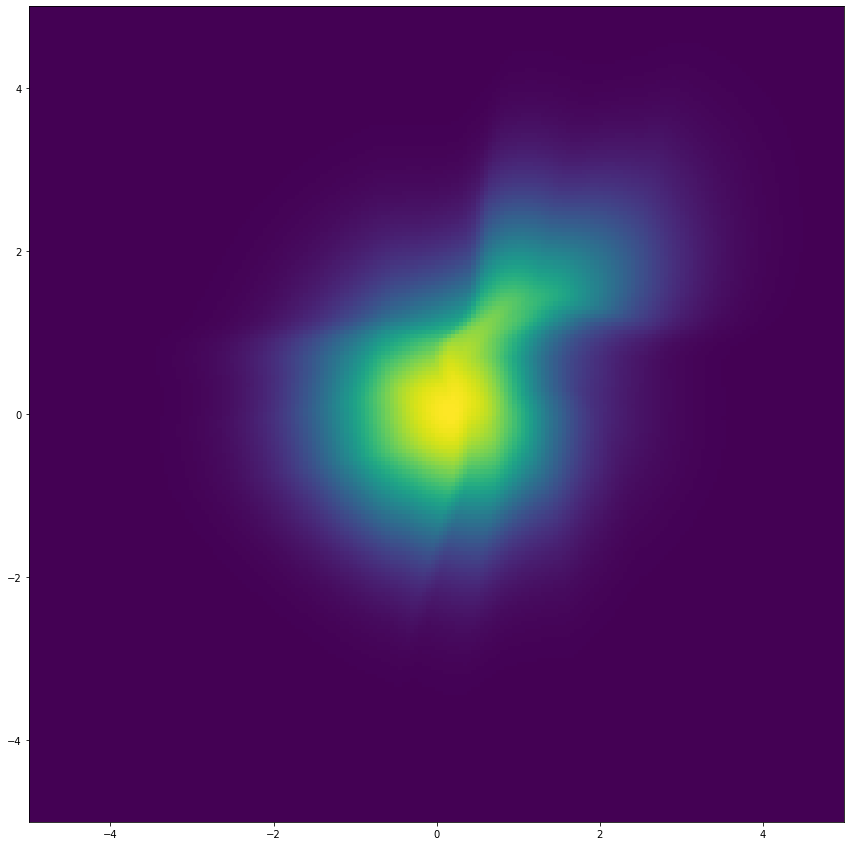

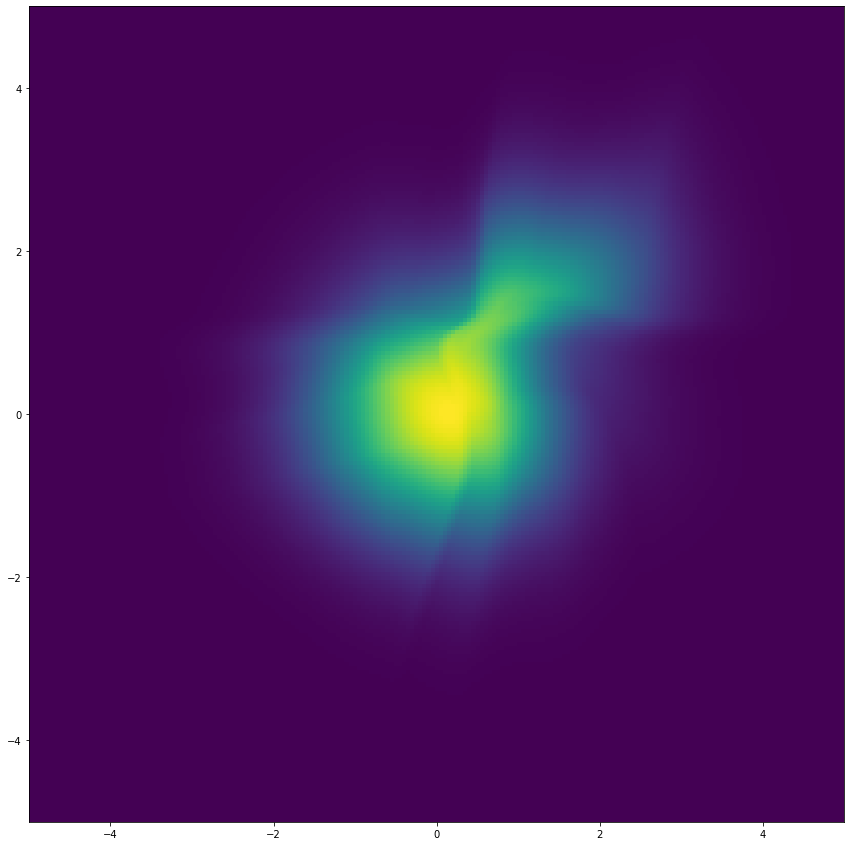

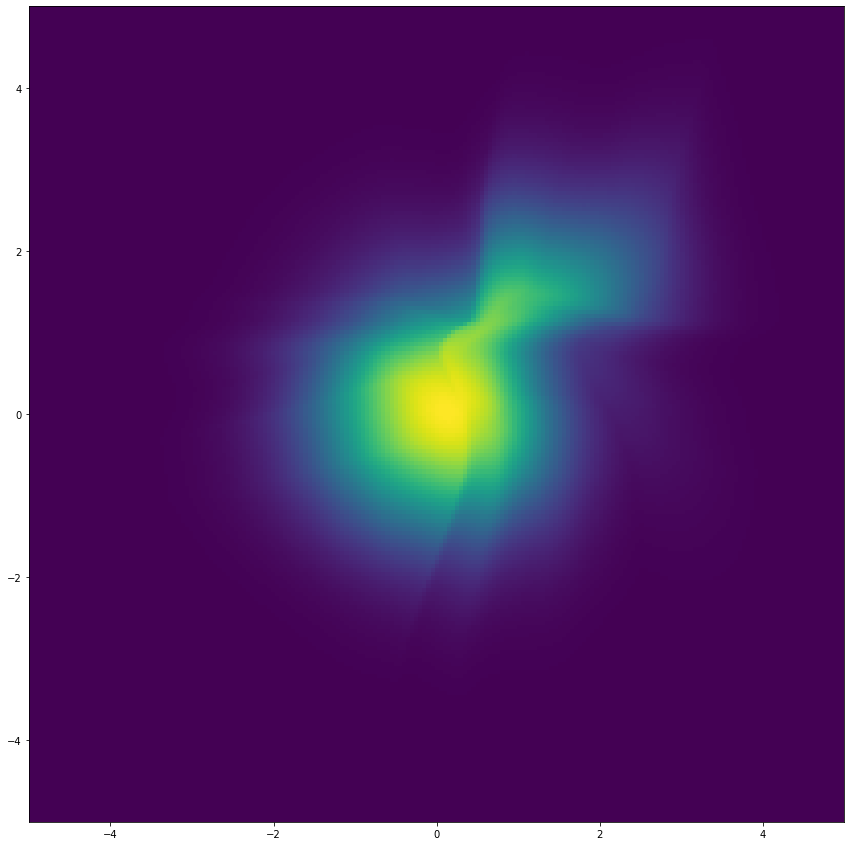

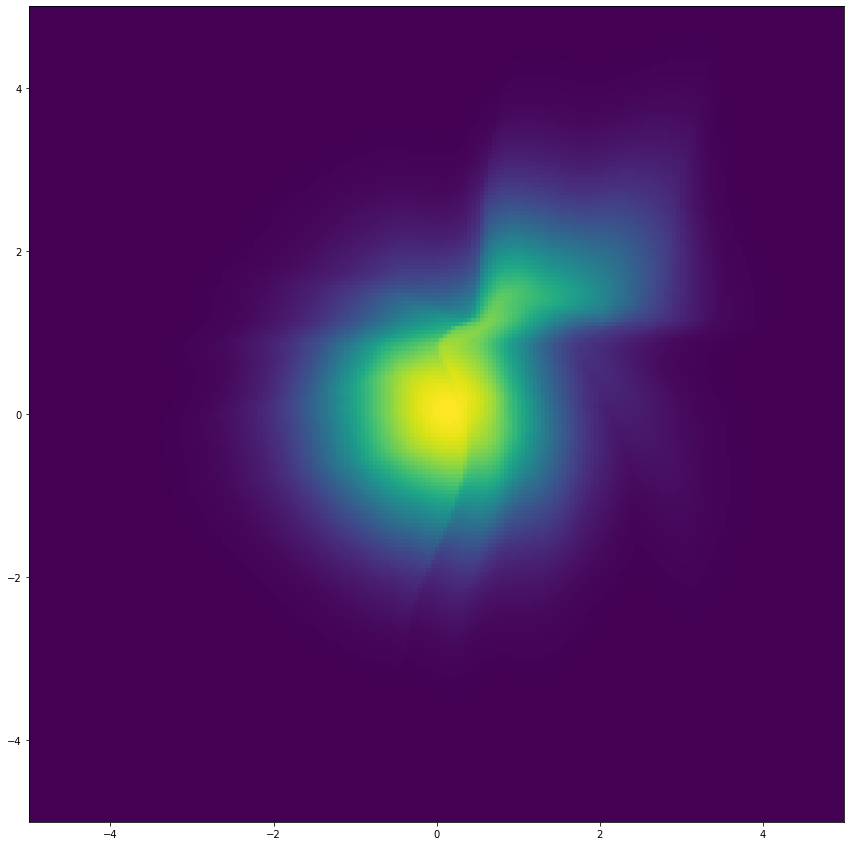

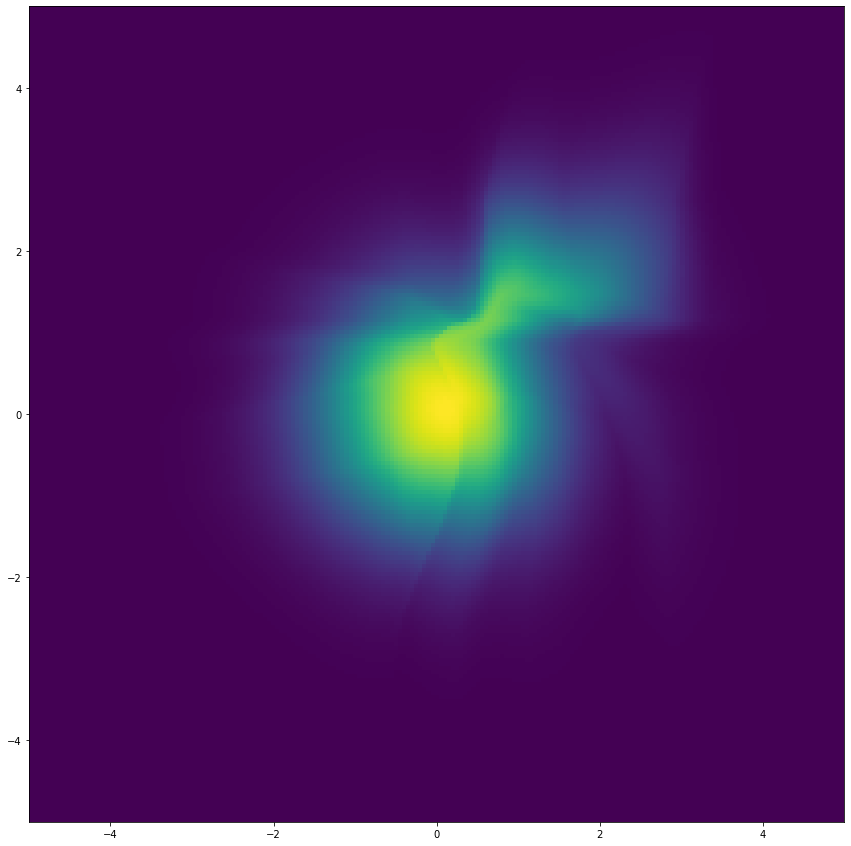

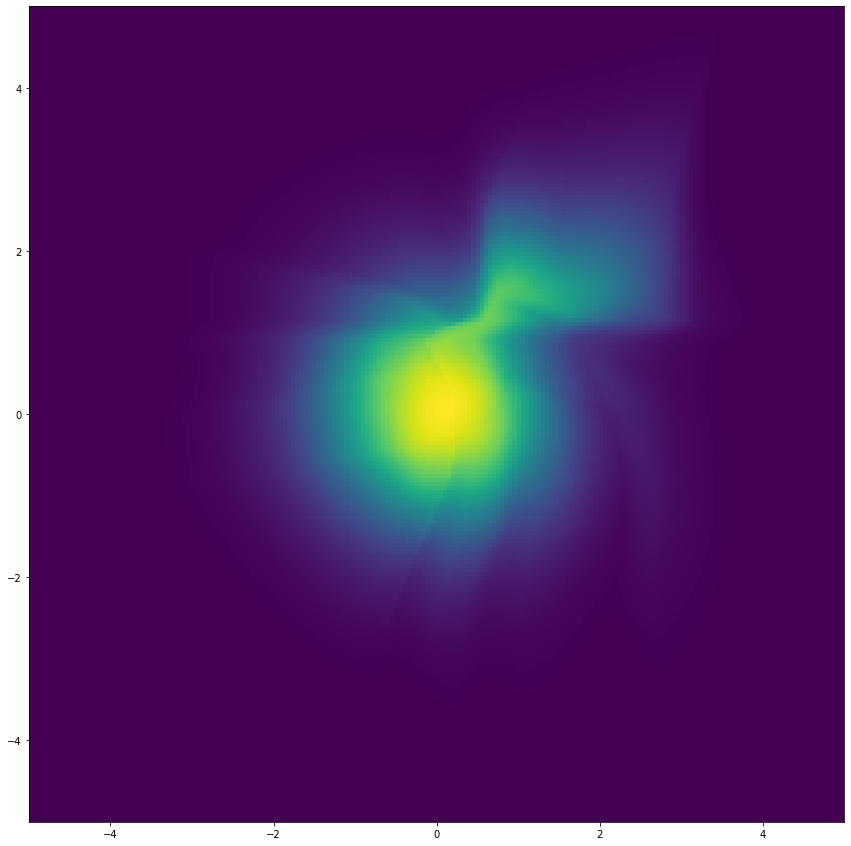

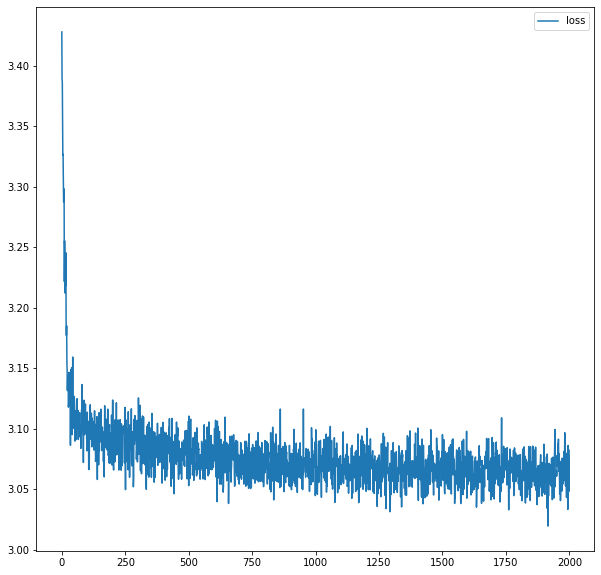

{'max_iter': 2000, 'num_samples': 5000, 'num_segments': 6, 'pow_of_two': 1, 'prob_delta': 0.8, 'dims_dense': [1, 16, 64, 16, 1]} {'loss': 3.0823163986206055, 'Bias_prob_hyp': -0.015193322563171408, 'SqErr_prob_hyp': 0.00023083705050857338}
6 1 2000 5000 [ 1 16 32 16  1]


 12%|█▏        | 248/2000 [00:15<01:57, 14.94it/s]<ipython-input-19-1b55656c51ce>:89: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, prob.data.numpy())
100%|██████████| 2000/2000 [02:16<00:00, 14.66it/s]


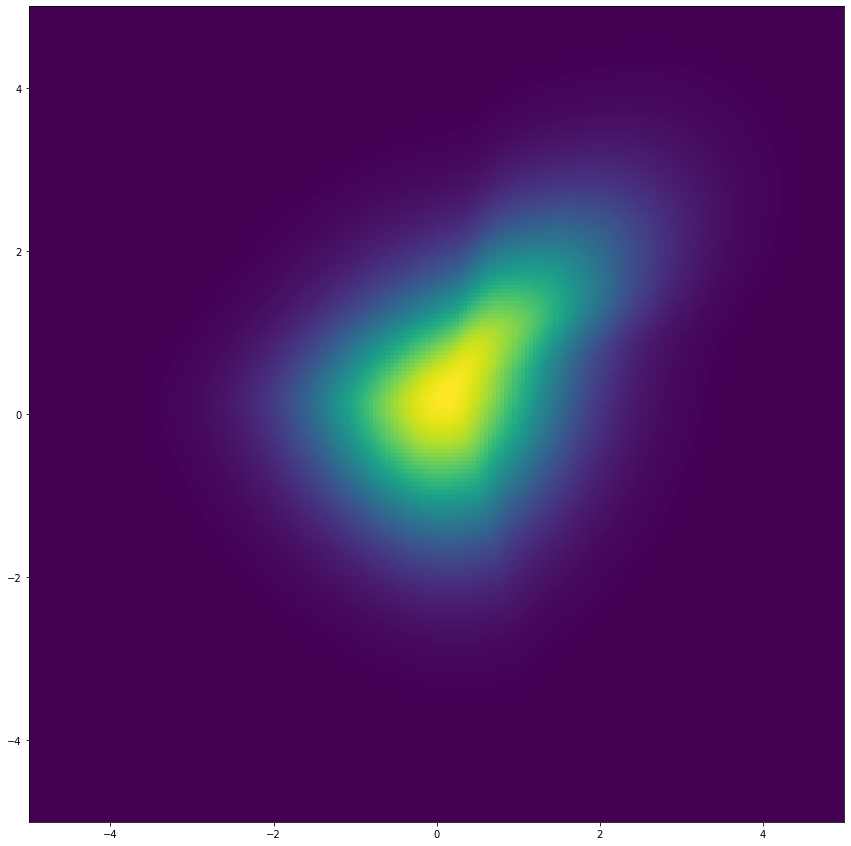

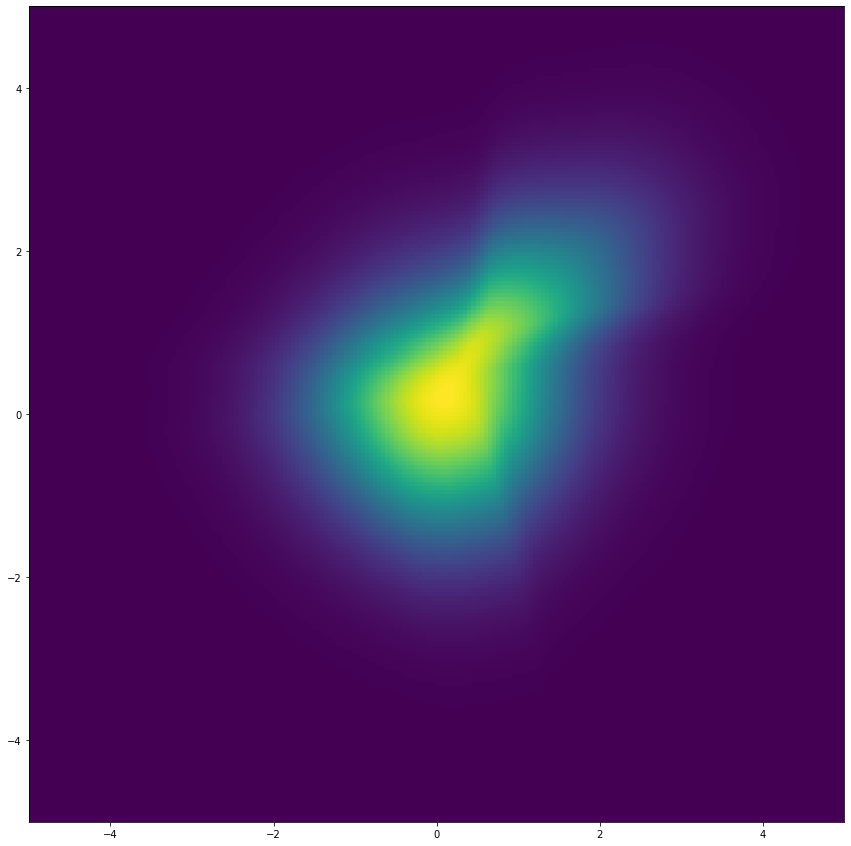

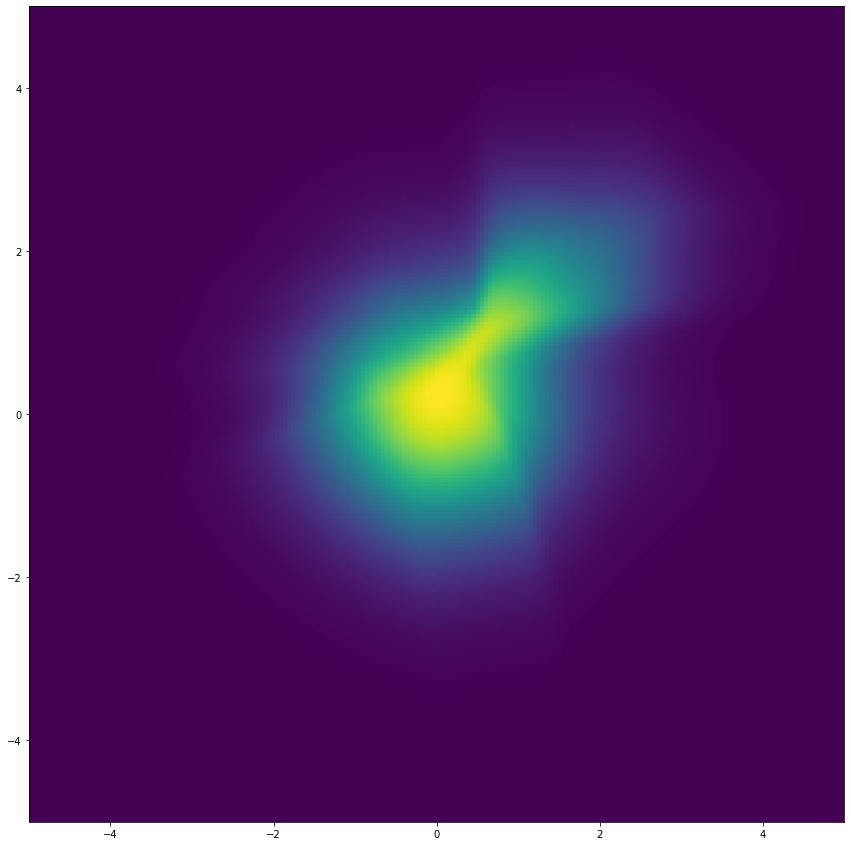

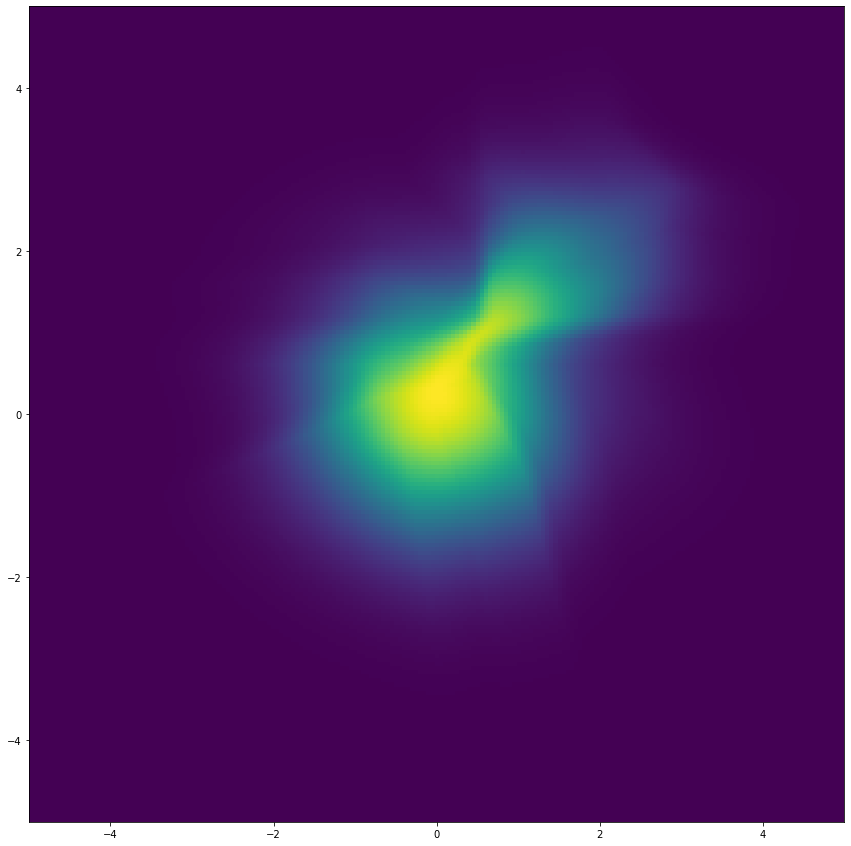

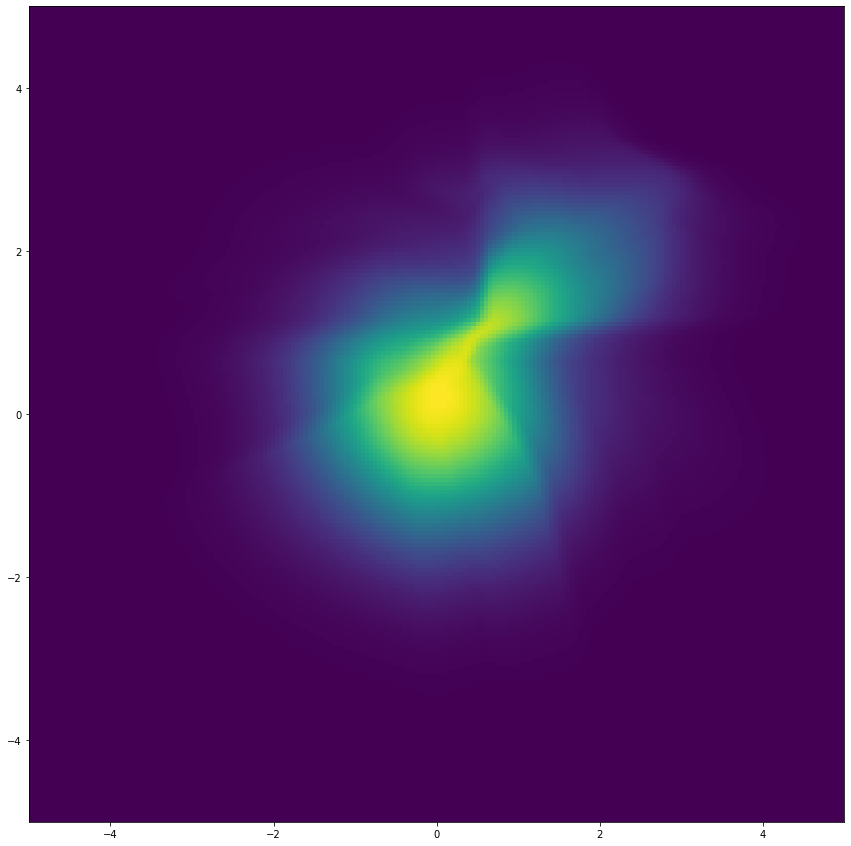

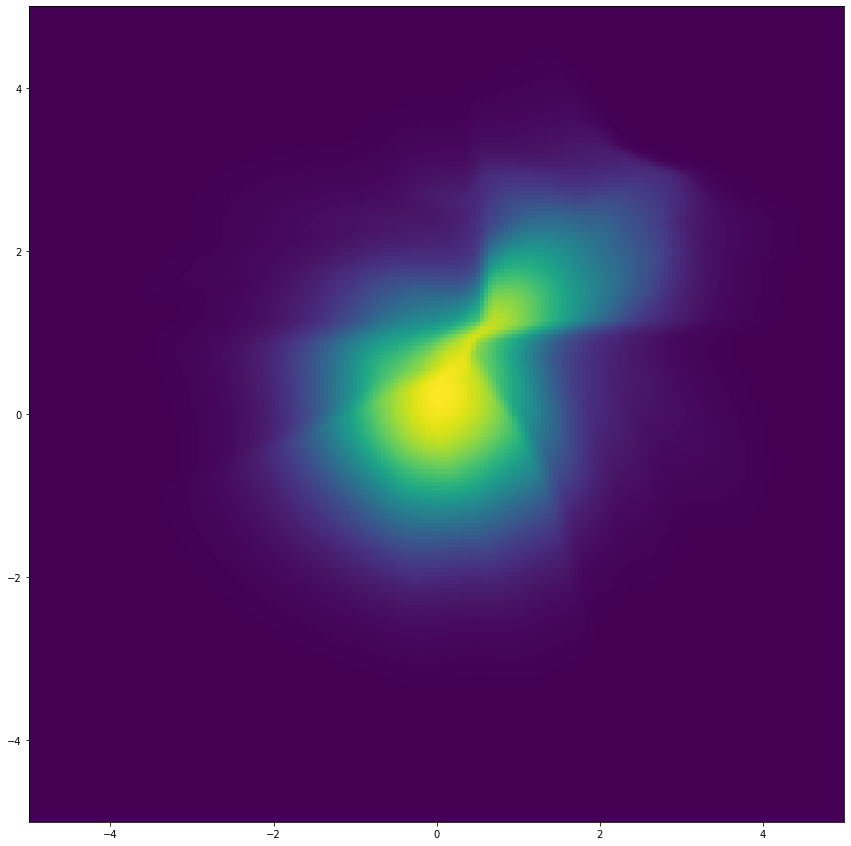

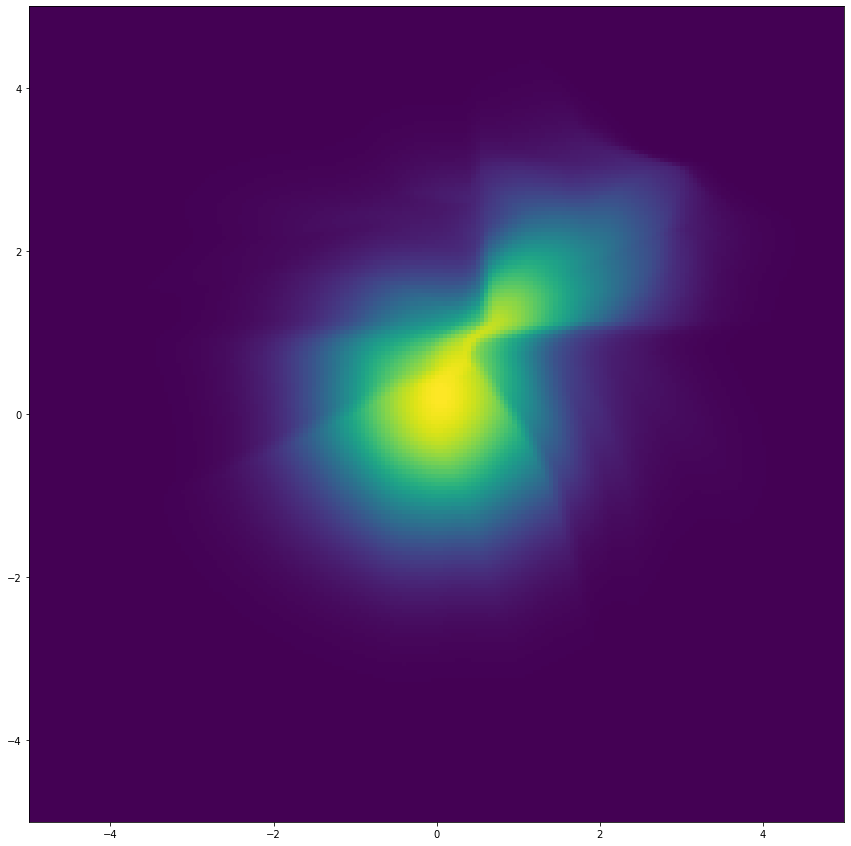

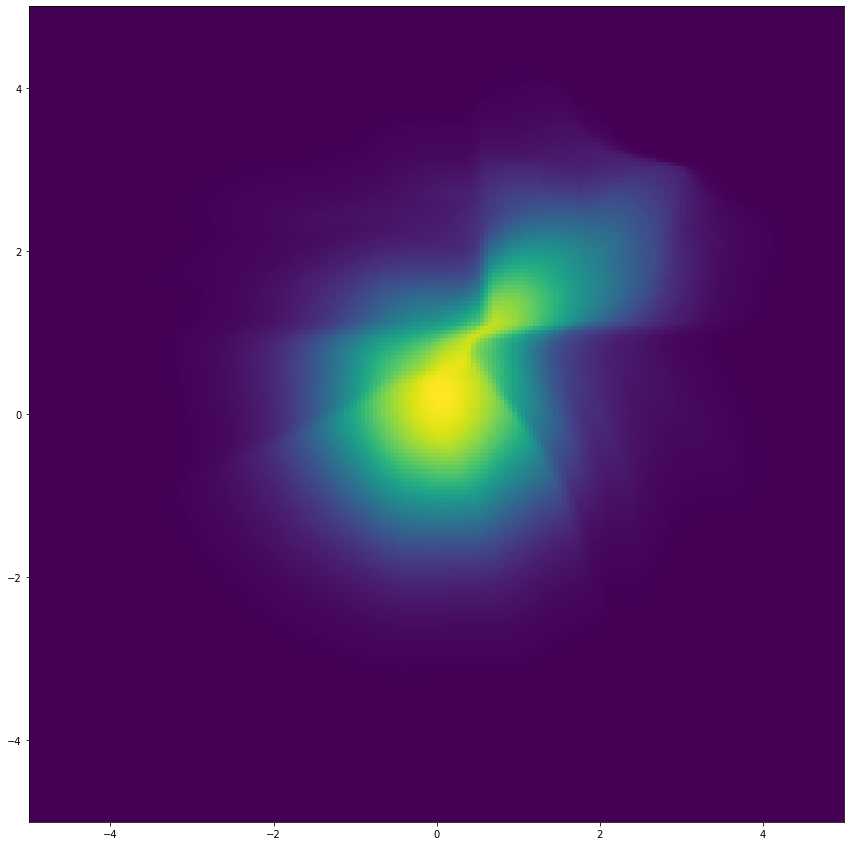

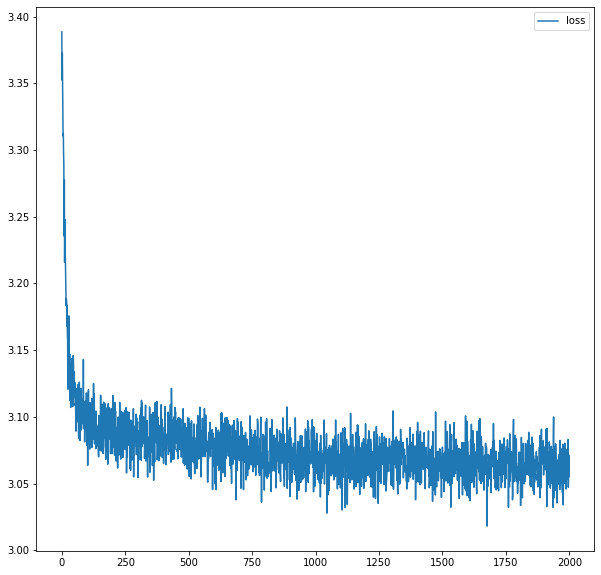

{'max_iter': 2000, 'num_samples': 5000, 'num_segments': 6, 'pow_of_two': 1, 'prob_delta': 0.8, 'dims_dense': [1, 16, 32, 16, 1]} {'loss': 3.0553054809570312, 'Bias_prob_hyp': 0.009906677436828604, 'SqErr_prob_hyp': 9.814225783736895e-05}
6 1 2000 5000 [ 1  4 32  4  1]


 12%|█▏        | 249/2000 [00:15<01:44, 16.73it/s]<ipython-input-19-1b55656c51ce>:89: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, prob.data.numpy())
 88%|████████▊ | 1750/2000 [9:45:48<1:23:41, 20.09s/it]    


KeyboardInterrupt: 

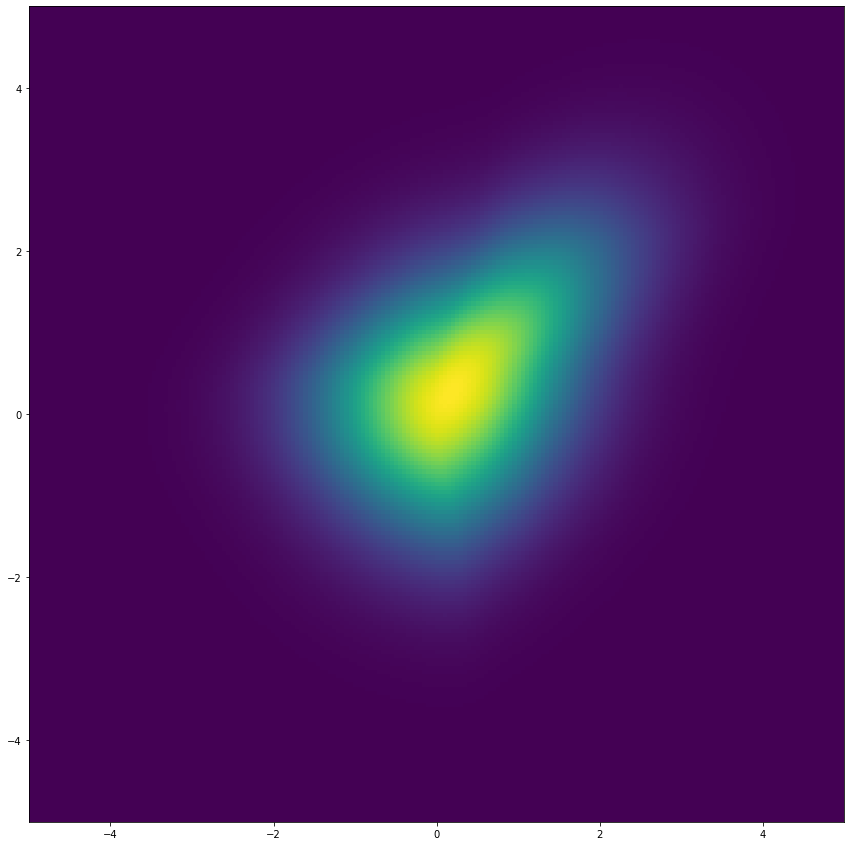

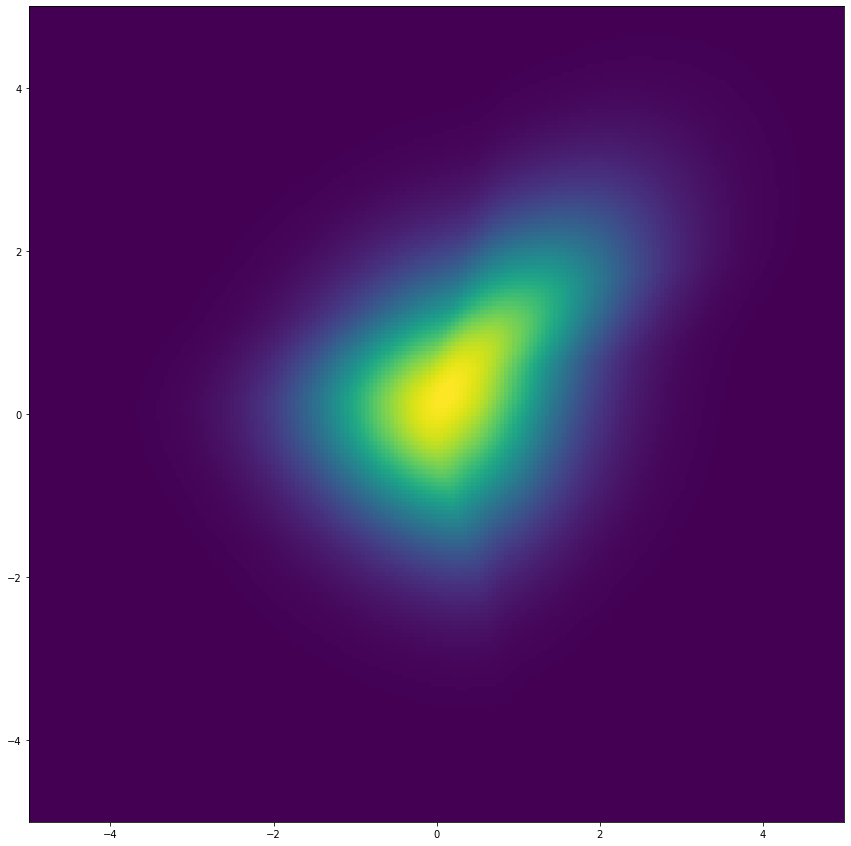

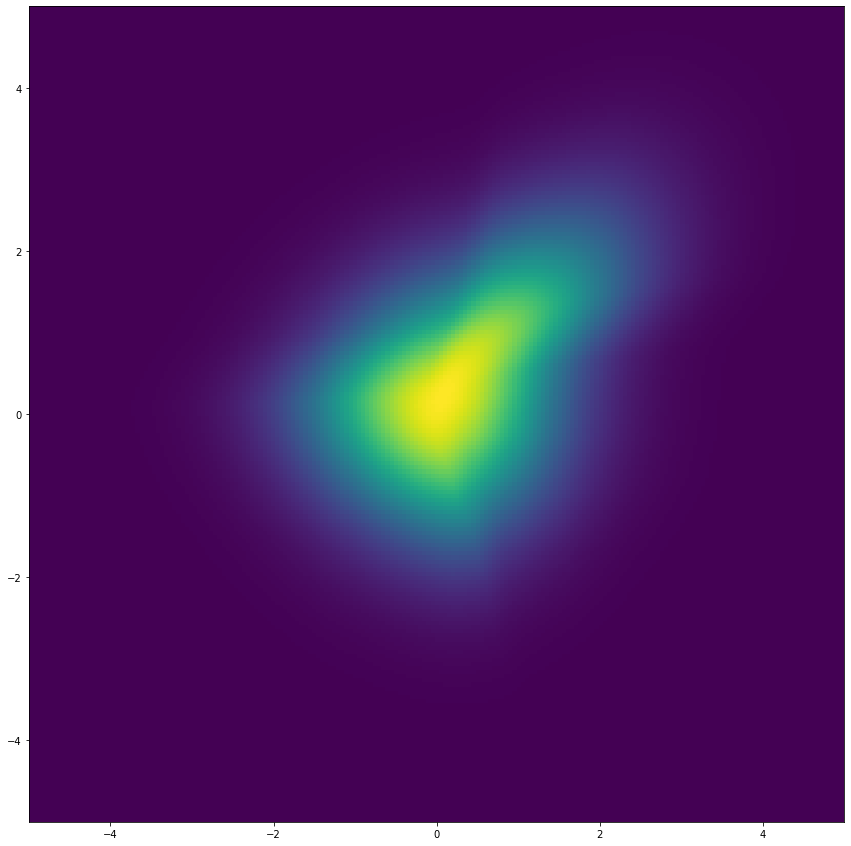

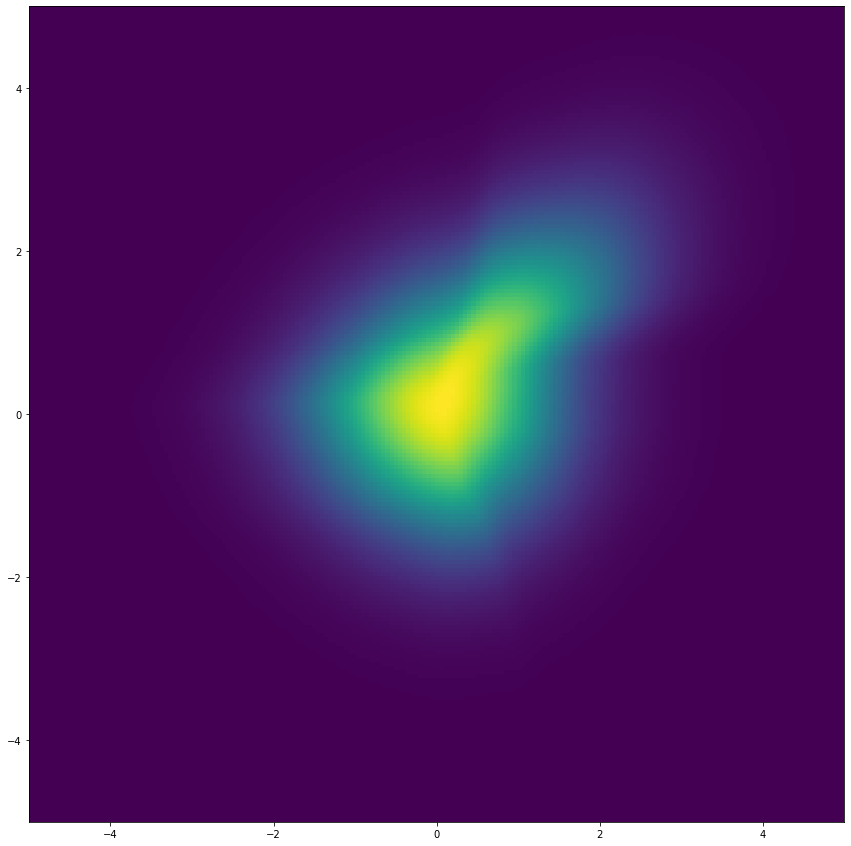

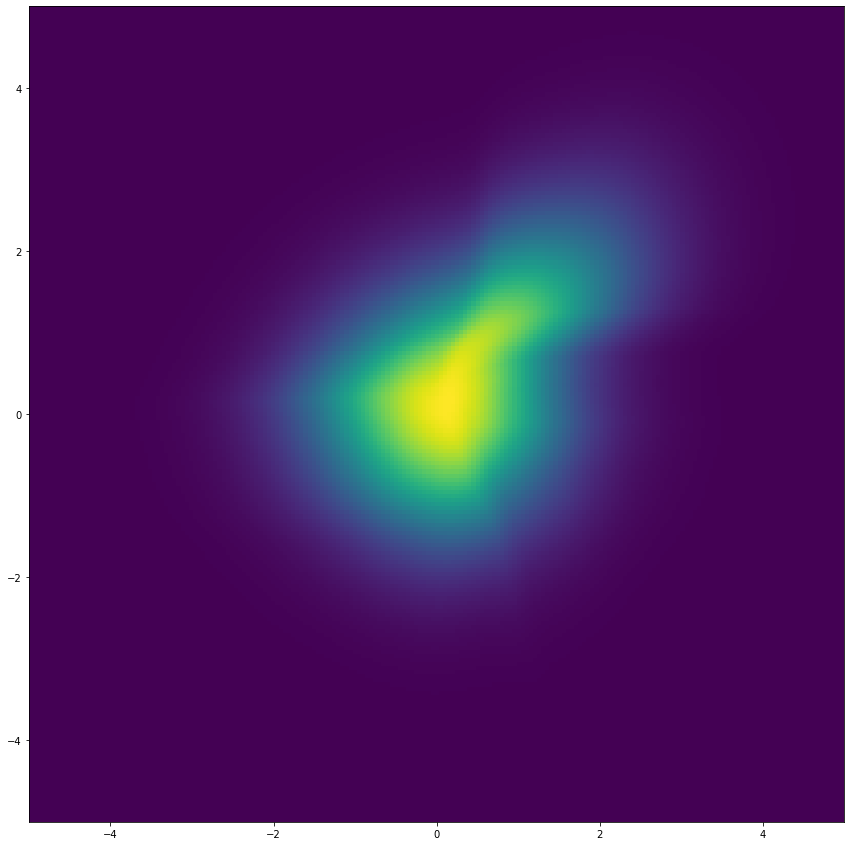

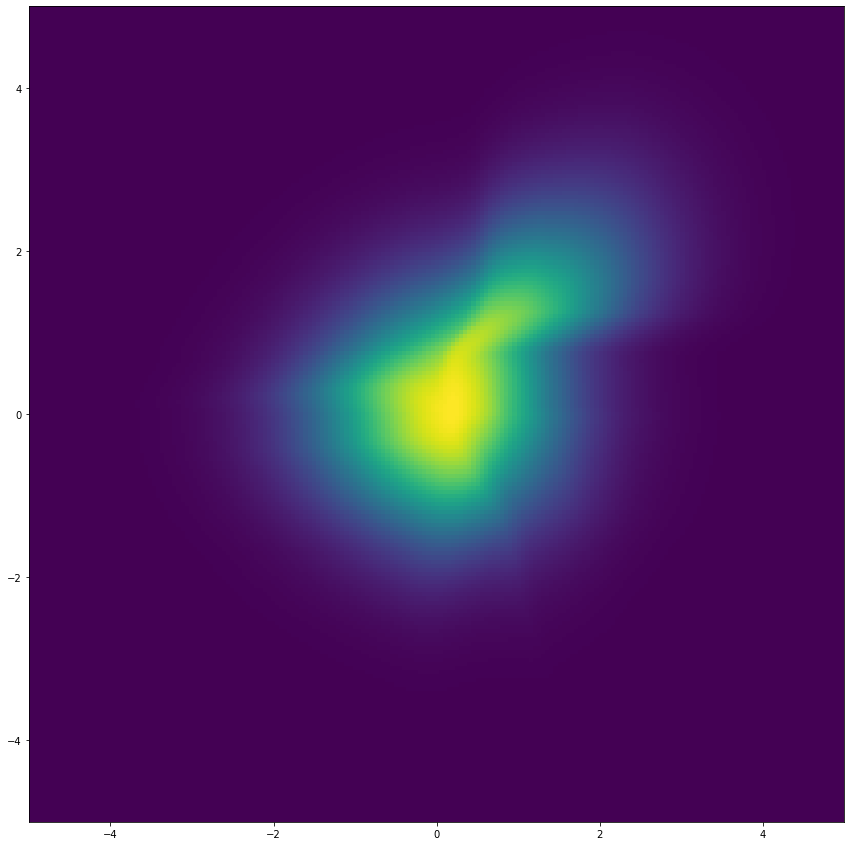

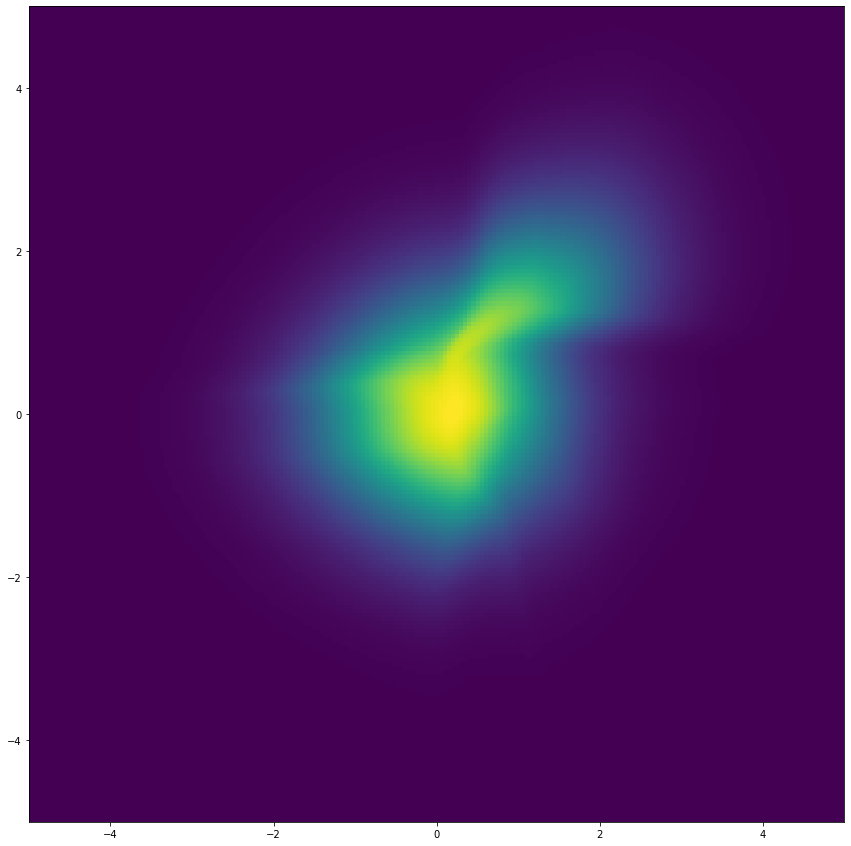

In [21]:
for num_segments, pow_of_two, max_iter, num_samples, dims_dense  in ar:
    print(num_segments, pow_of_two, max_iter, num_samples, dims_dense)
    one_experiment(prob_delta = 0.8, num_segments = int(num_segments), pow_of_two = int(pow_of_two), max_iter = int(max_iter), num_samples = int(num_samples), dims_dense = dims_dense.tolist())